In [19]:
%config Completer.use_jedi = False
# %matplotlib widget



In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
from sklearn import metrics
import pybedtools
import coolbox
from coolbox.api import *
import networkx as nx
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
os.chdir('/home/dcmorgan')
os.getcwd()

'/home/dcmorgan'

In [ ]:
!cut -f2,3,4 ~/data/meta/NC_004252_R0396-MWT.bedgraph

## Raw Gut x pheno

In [3]:
primary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Primary Data')
diet=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Diet Data')
blood_stool=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='blood and stool biomarkers')
secondary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Secondary Data')
MRI=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='MRI scores')

In [ ]:
unibact=pd.read_csv('data/328_krakenuniq_raw.csv',index_col=0)
unibact['spec']=(unibact.index).str.split(';').str[0:6].tolist()
# jeff=pd.DataFrame(unibact['spec'].tolist(),columns=['tmp','tmp','tmp','tmp','tmp','species'])
# jeff=jeff.fillna(method='ffill',axis=1)


In [ ]:
unibact.columns=unibact.columns.str.split('-').str[0].tolist()

In [ ]:
PP=primary[primary.index.isin(unibact.columns)]



In [ ]:
sub_uni=unibact[primary.index[primary.index.isin(unibact.columns)]]
sub_uni.columns=PP['Hypertension Category by 24h BP w/o considering antihypertensive med']
# sub_uni

### corr network

In [ ]:
aa=np.corrcoef((sub_uni[2]).astype(float))
# aa=aa[aa!=1]
a=plt.hist(aa.flatten(),bins=100,log=True,alpha=.65)

bb=np.corrcoef((sub_uni[1]).astype(float))
# bb=bb[bb!=1]
b=plt.hist(bb.flatten(),bins=100,log=True,alpha=.5)

cc=np.corrcoef((sub_uni[0]).astype(float))
# cc=cc[cc!=1]
c=plt.hist(cc.flatten(),bins=100,log=True,alpha=.35)

In [ ]:
a=nx.from_numpy_array(aa[1:100,1:100])
b=nx.from_numpy_array(bb[1:100,1:100])
c=nx.from_numpy_array(cc[1:100,1:100])

# cc.shape

In [ ]:
nx.draw(a)
nx.draw(b)
nx.draw(c)

In [ ]:
# nx.from_numpy_array(aa[(aa>.5)&(aa[1:100,1:100])])
nx.average_clustering(a)

In [ ]:
aa=np.array(stats.spearmanr(sub_uni[2],axis=1))
# aa=aa[aa!=1]
a=plt.hist(aa.flatten(),bins=100,log=True,alpha=.65)

bb=np.array(stats.spearmanr(sub_uni[1],axis=1))
# bb=bb[bb!=1]
b=plt.hist(bb.flatten(),bins=100,log=True,alpha=.5)

cc=np.array(stats.spearmanr(sub_uni[0],axis=1))
# cc=cc[cc!=1]
c=plt.hist(cc.flatten(),bins=100,log=True,alpha=.35)

In [ ]:
ww=plt.hist(bb-cc,bins=100,alpha=.65,log=True)
ww=plt.hist(bb-aa,bins=100,alpha=.5,log=True)
ww=plt.hist(aa-cc,bins=100,alpha=.35,log=True)

In [ ]:
from scipy import stats
cc=np.array(stats.spearmanr(unibact.values[0:1000,0:1000])).flatten()
cc=cc[cc!=1]
# np.array(cc)
cc=plt.hist(cc,bins=100,log=True)

## OriC data

In [ ]:
oric=pd.read_csv('data/doric10/tubic_bacteria.csv') #remove 'note' and 'nt*' from file

In [ ]:
oric['oric_start']=oric['Location of replication origin'].str.split('.').str[0].str.split(',').str[0].str.split(';').str[0].tolist()
oric['oric_end']=oric['Location of replication origin'].str.split('.').str[2].str.split(',').str[0].str.split(';').str[0].tolist()
oric['gene_start']=oric['Location of replication genes'].str.split('.').str[0].str.split(',').str[0].str.split(';').str[0].tolist()
oric['gene_end']=oric['Location of replication genes'].str.split('.').str[2].str.split(',').str[0].str.split(';').str[0].tolist()

In [ ]:
oric['OriC AT content']=np.round(oric['OriC AT content']*100).astype(int)
oric['orgA']=oric['Organism'].str.split(' ').str[0].tolist()
oric['orgB']=oric['Organism'].str.split(' ').str[1].tolist()
oric['Organism']=oric['orgA']+'_'+oric['orgB']


In [ ]:
oric[['oric_start','oric_end','gene_start','gene_end']]=oric[['oric_start','oric_end','gene_start','gene_end']].replace('-','1')
oric=oric.fillna('1')

In [ ]:
oric[['gene_start']]=oric[['gene_start']].astype(int)
oric[['gene_end']]=oric[['gene_end']].astype(int)
oric[['oric_start']]=oric[['oric_start']].astype(int)
oric[['oric_end']]=oric[['oric_end']].astype(int)

In [ ]:
oric['end']=np.amax(oric[['gene_start','oric_end','gene_start','gene_end']],1)
oric['start']=np.amin(oric[['gene_start','oric_end','gene_start','gene_end']],1)

In [ ]:
oric[['Refseq','start','end','OriC AT content','Organism']].to_csv('data/doric10/OriC_db.bed',sep='\t',header=True,index=False)

### process figures

In [ ]:
zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]
plt.figure(figsize=(20, 5))

plt.bar(data=zzz[(zzz['start']>3000000)&(zzz['end']<3500000)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')

plt.axes([.2, .6, .6, .2])
plt.bar(data=zzz[(zzz['start']>np.int(np.round(tmp['start'].item(),-1))-100) &(zzz['end']<np.int(np.round(tmp['end'].item(),-1))+100)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')


plt.xlabel("OriC ranges from "+str(tmp['start'].item())+" to "+str(tmp['end'].item())+" for "
        +str(tmp['Organism'].item())+" in "+str(os.path.basename(jac).split('_')[2].split('.')[0])+
           "max= "+np.max(zzz['relAb'])+" at "+str(zzz[zzz['relAb']==np.max(zzz['relAb'])][['start']].index.values)+"; median= "+np.median(zzz['relAb']),fontsize=14)
 

In [ ]:
traces= glob.glob('data/meta_unfilt/*bedgraph')
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')

for jac in traces:
    zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
    tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]
    
    plt.figure(figsize=(20, 5))
    try:
        print('running: '+str(tmp['Organism'].item())+" in "+str(os.path.basename(jac).split('_')[2].split('.')[0]))
        ss=np.int(np.round(tmp['start'].item(),-1))
        tt=np.int(np.round(tmp['end'].item(),-1))
        plt.bar(data=zzz[(zzz['start']>ss-250000)&(zzz['end']<tt+250000)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
        plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
        plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')

        plt.axes([.2, .6, .6, .2])
        plt.bar(data=zzz[(zzz['start']>ss-100) &(zzz['end']<tt+100)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
        plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
        plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')

        plt.xlabel("OriC ranges from "+str(tmp['start'].item())+" to "+str(tmp['end'].item())+" for "
            +str(tmp['Organism'].item())+" in "+str(os.path.basename(jac).split('_')[2].split('.')[0])+"max= "+
                   np.max(zzz['relAb'])+" between "+str(np.int(zzz[zzz['relAb']==np.max(zzz['relAb'])][['start']].values))+" and "+str(np.int(zzz[zzz['relAb']==np.max(zzz['relAb'])][['end']].values))+"; median= "+np.median(zzz['relAb']),fontsize=14)
        plt.savefig('img/oric/'+str(os.path.basename(jac).split('.')[0])+'.png',dpi=300,bbox_inches = "tight")

    except TypeError:
        pass
    except ValueError:
        pass

In [ ]:
ori[ori['Organism']=='Staphylococcus_aureus']

In [ ]:
tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]

# analyze and score OriC v rest

In [25]:

def run_vRand(dataset,table,n):
    aa=dataset.loc[dataset.index.isin(np.unique(table['subj']))]
    aa['ecoli']=1
    aa=aa.select_dtypes(include=np.number)
    aa=aa.dropna(how='any',axis=1)

    bb=dataset.loc[~dataset.index.isin(np.unique(table['subj']))]
    bb['ecoli']=0
    bb=bb.select_dtypes(include=np.number)
    bb=bb.dropna(how='any',axis=1)

    for i in aa.columns:
        try:
            cc=stats.kruskal(aa[i].dropna(),bb[i].dropna())
            dd=stats.mannwhitneyu(aa[i].dropna(),bb[i].dropna())
            ee=stats.ttest_ind(aa[i].dropna(),bb[i].dropna())
            # ff=stats.wilcoxon(aa[i].dropna(),bb[i].dropna())
            if ((cc.pvalue<0.005) & (dd.pvalue<0.005)&(ee.pvalue<0.005)):
                print (i,cc.pvalue,dd.pvalue,ee.pvalue)

        except:
            pass

    for i in np.arange(n):
        jeff=np.random.permutation(dataset.index)[0:len(np.unique(table['subj']))]
        aa=dataset.loc[dataset.index.isin(jeff)]
        aa=aa.select_dtypes(include=np.number)
        aa=aa.dropna(how='any',axis=1)

        bb=dataset.loc[~dataset.index.isin(jeff)]
        bb=bb.select_dtypes(include=np.number)
        bb=bb.dropna(how='any',axis=1)
        for i in aa.columns:
            try:
                cc=stats.kruskal(aa[i].dropna(),bb[i].dropna())
                dd=stats.mannwhitneyu(aa[i].dropna(),bb[i].dropna())
                ee=stats.ttest_ind(aa[i].dropna(),bb[i].dropna())
                # ff=stats.wilcoxon(aa[i].dropna(),bb[i].dropna())
                if ((cc.pvalue<0.005) & (dd.pvalue<0.005)&(ee.pvalue<0.005)):
                    print (i,cc.pvalue,dd.pvalue,ee.pvalue)

            except:
                pass

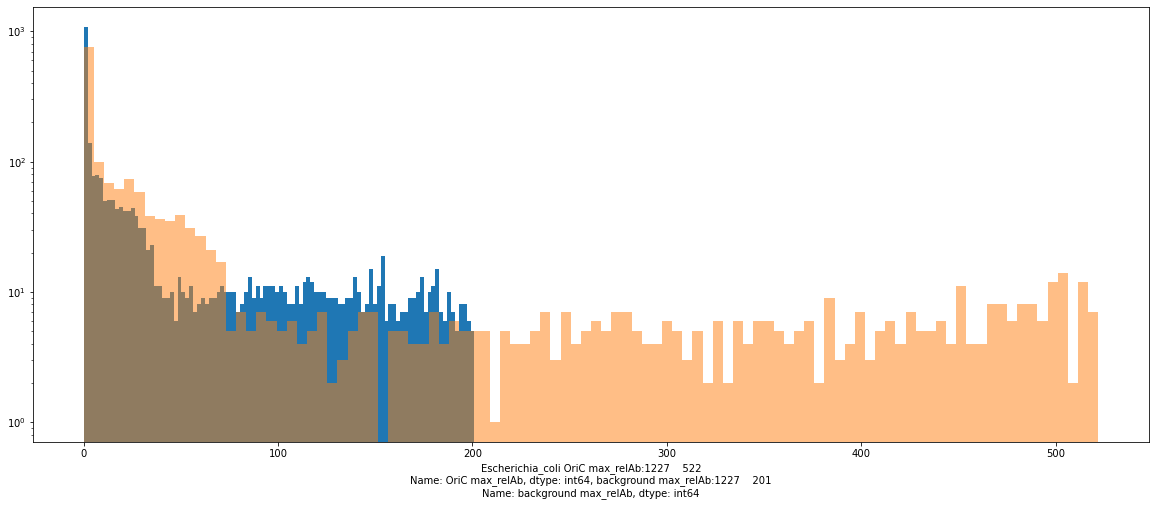

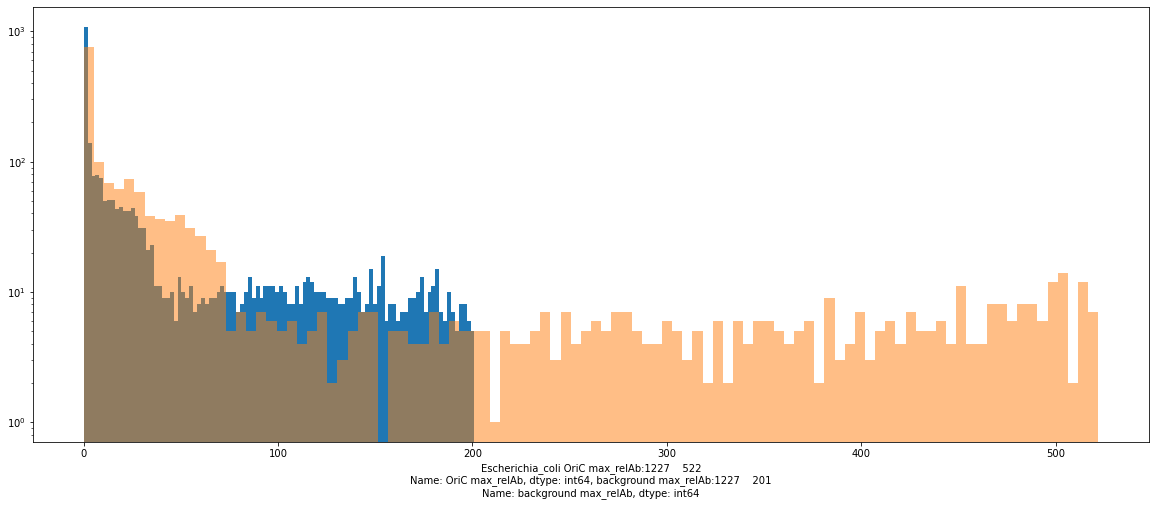

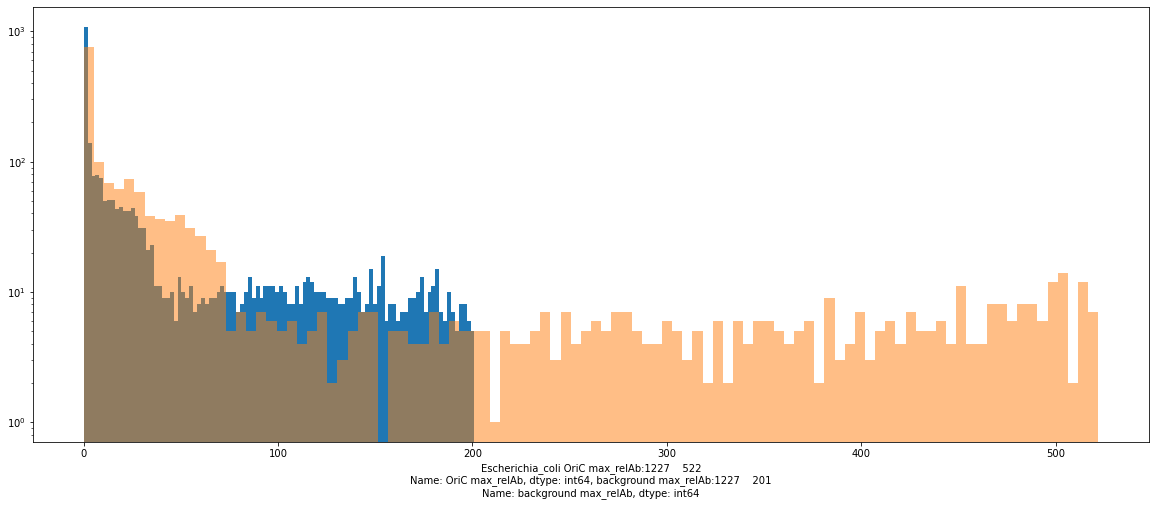

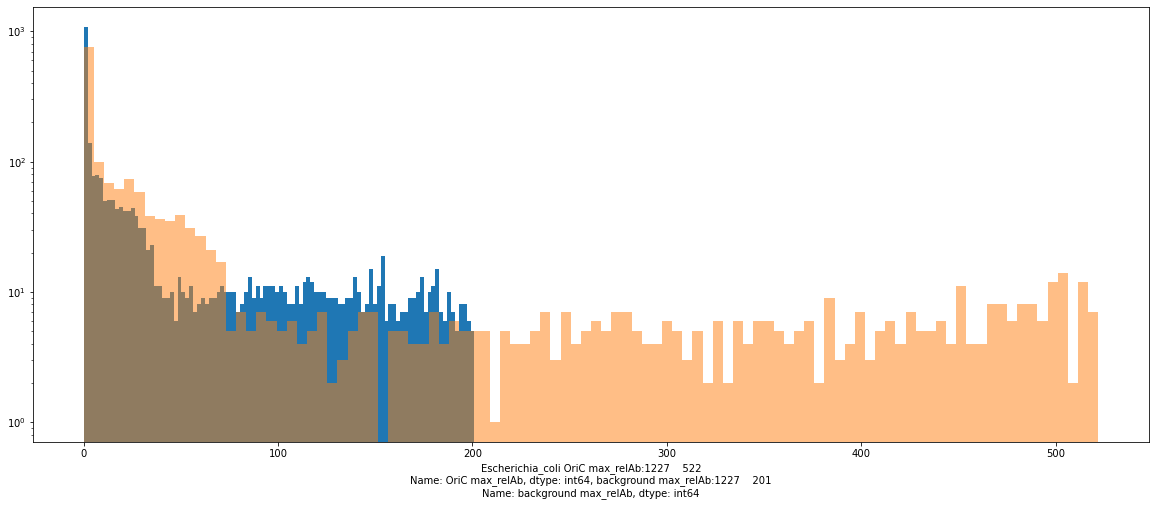

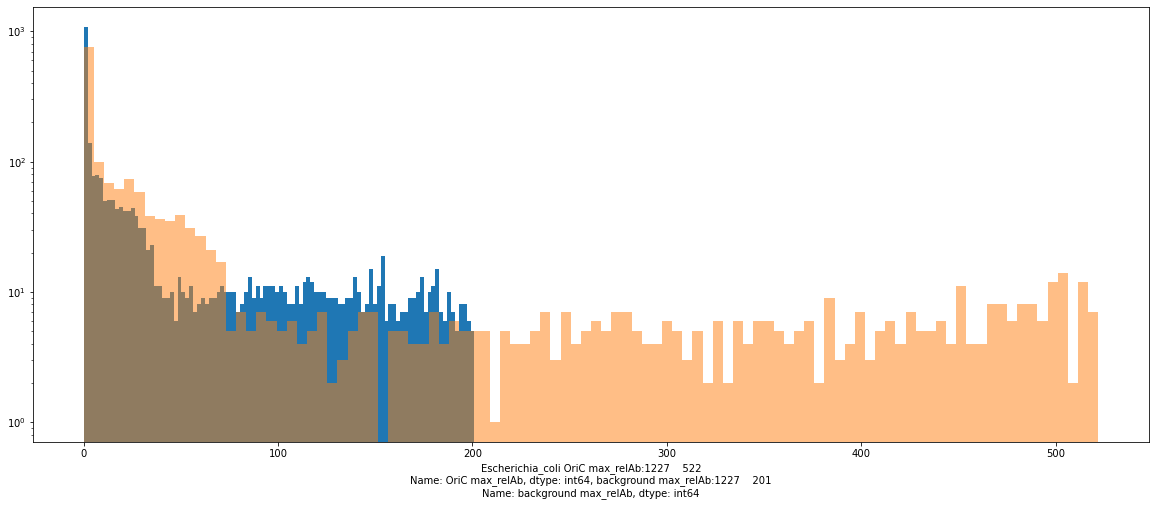

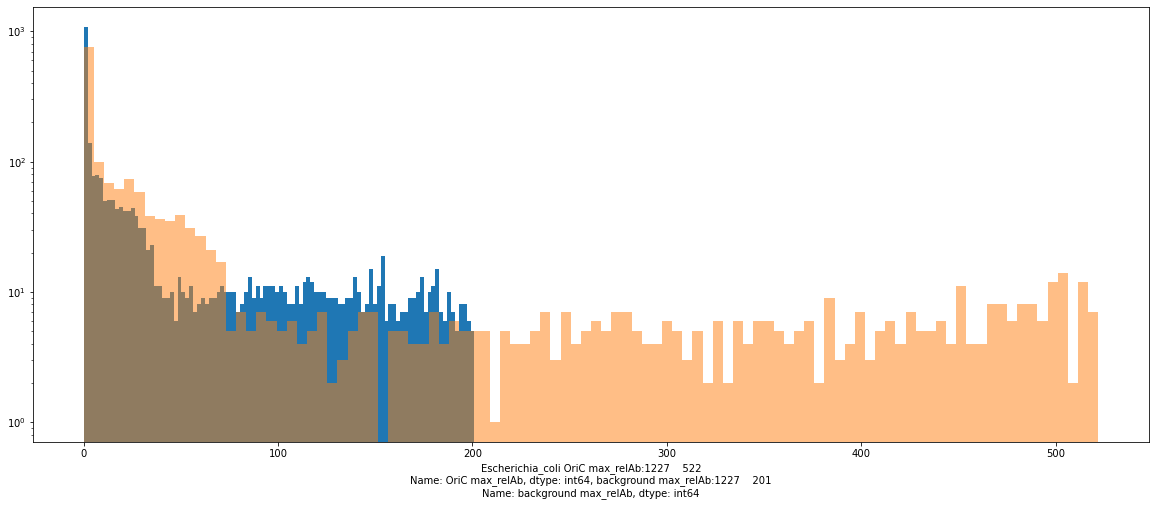

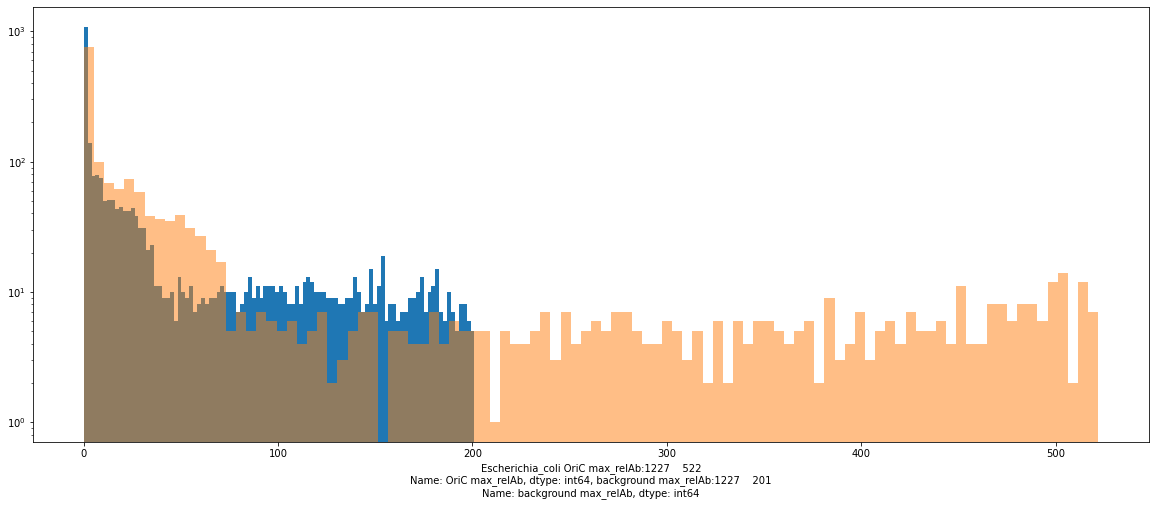

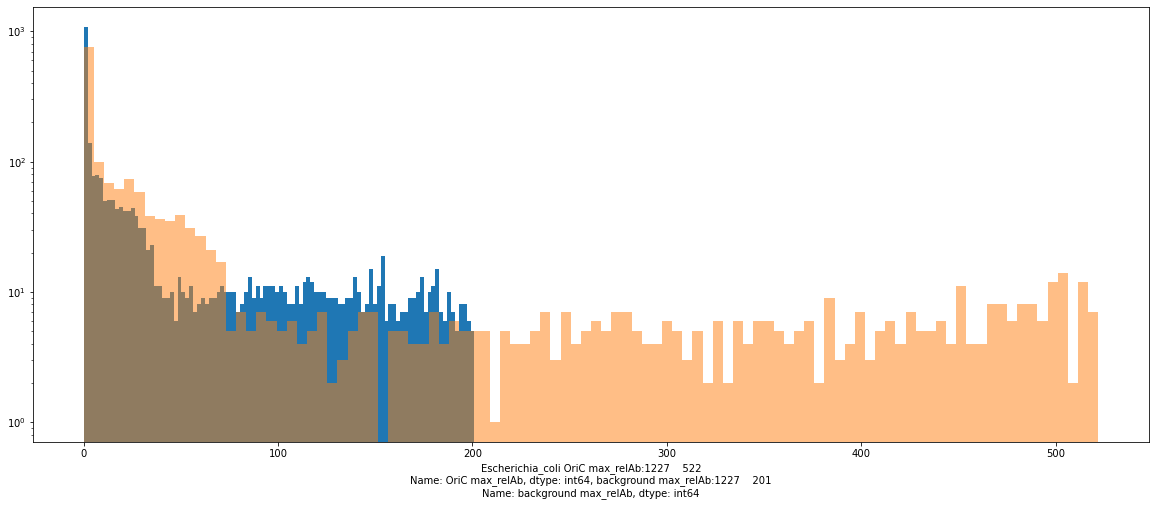

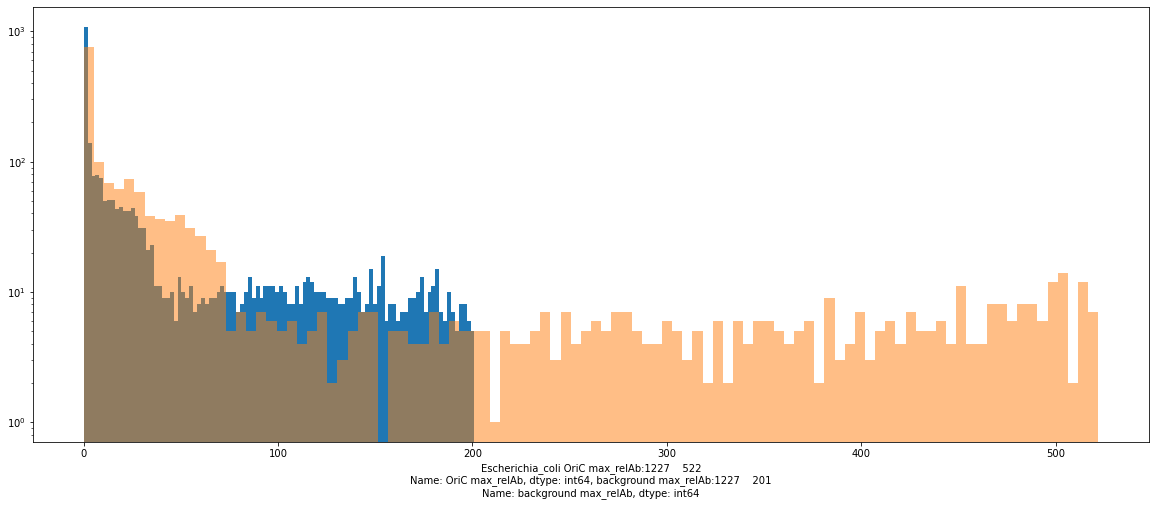

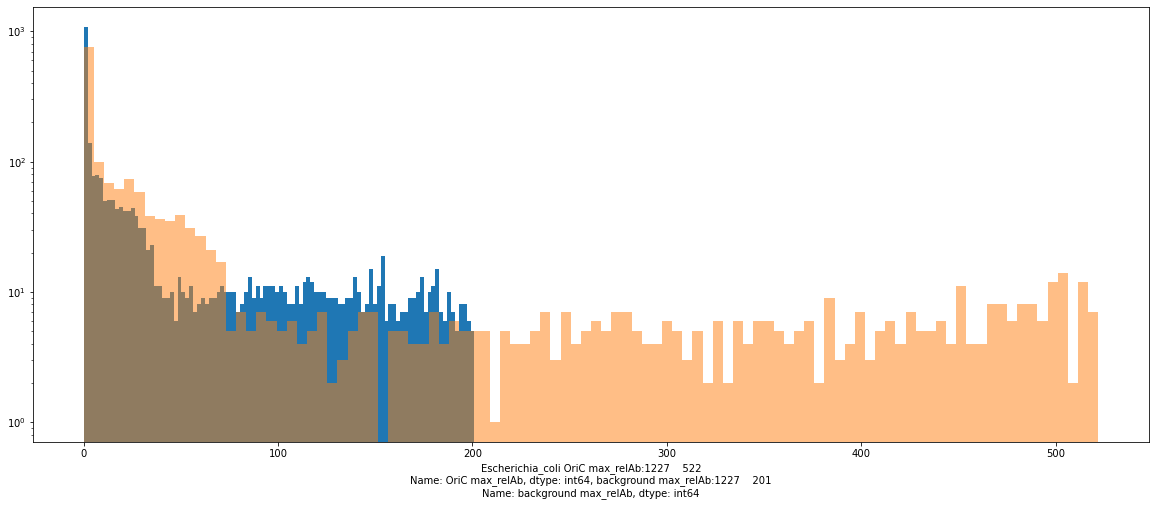

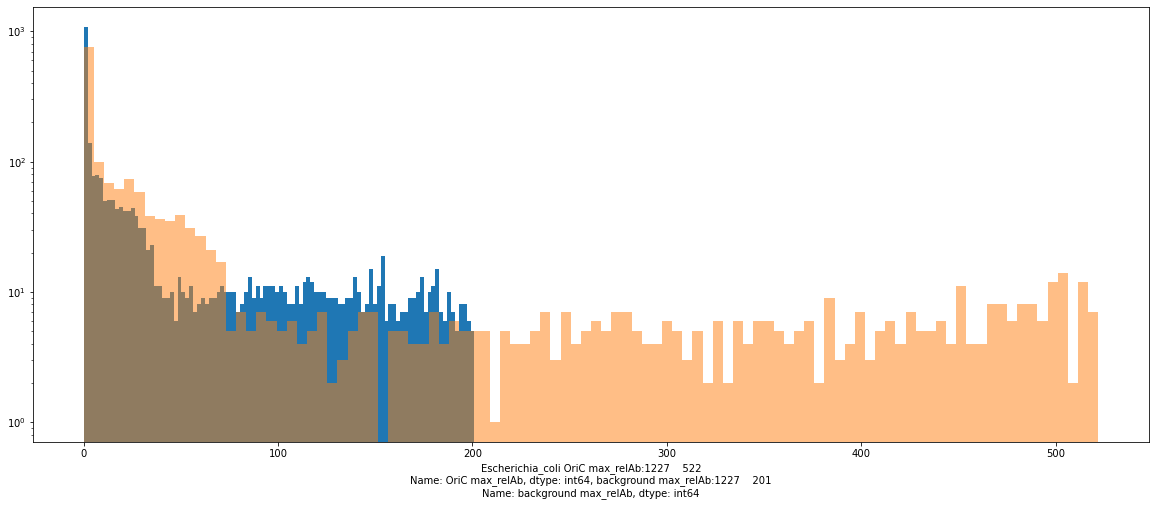

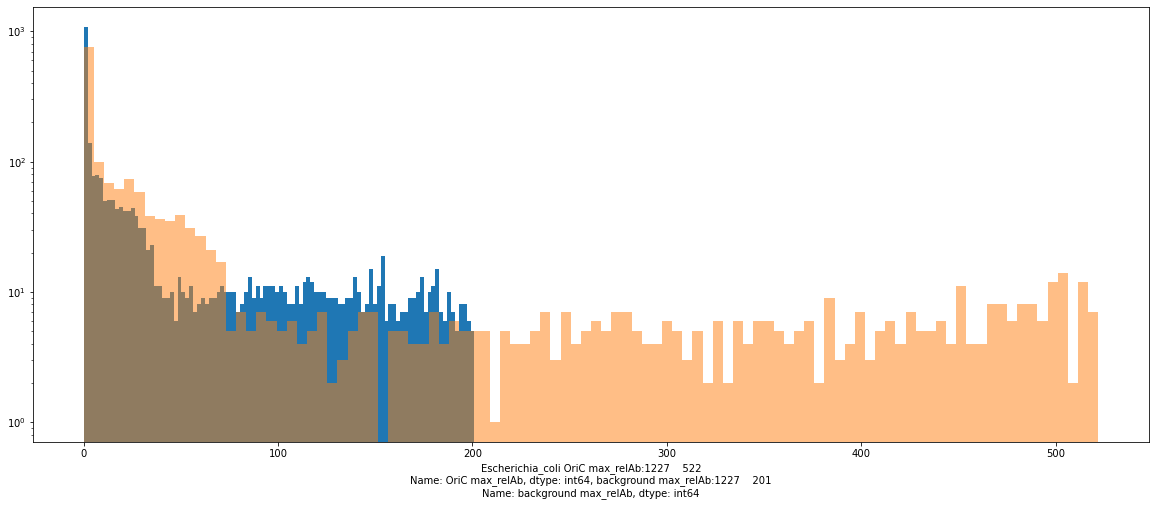

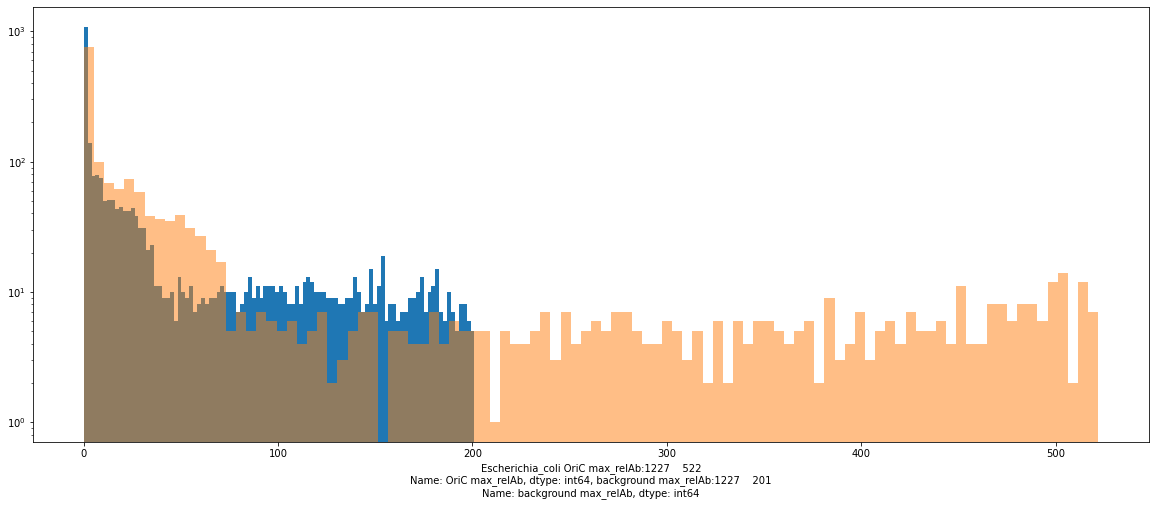

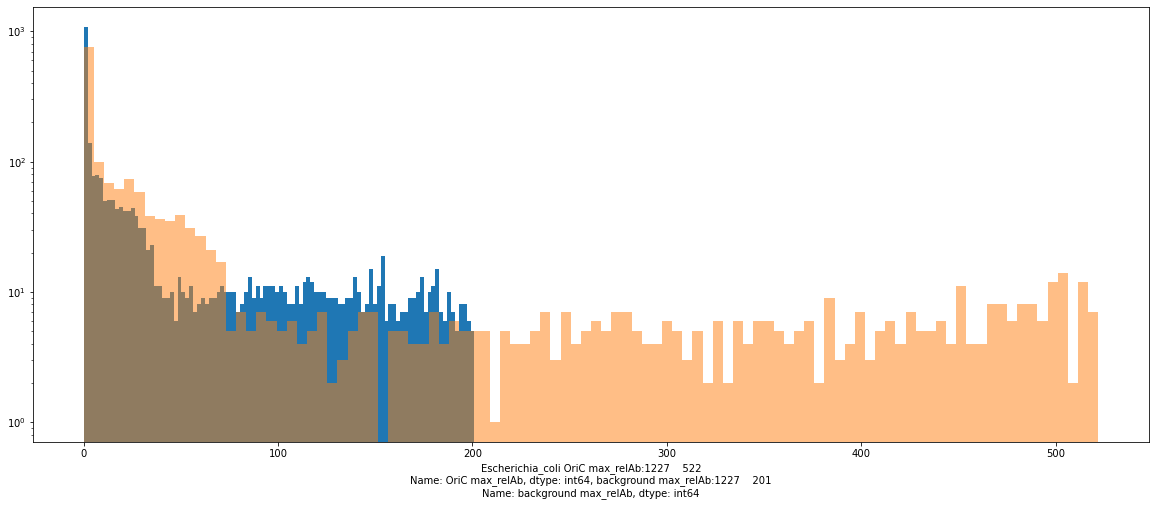

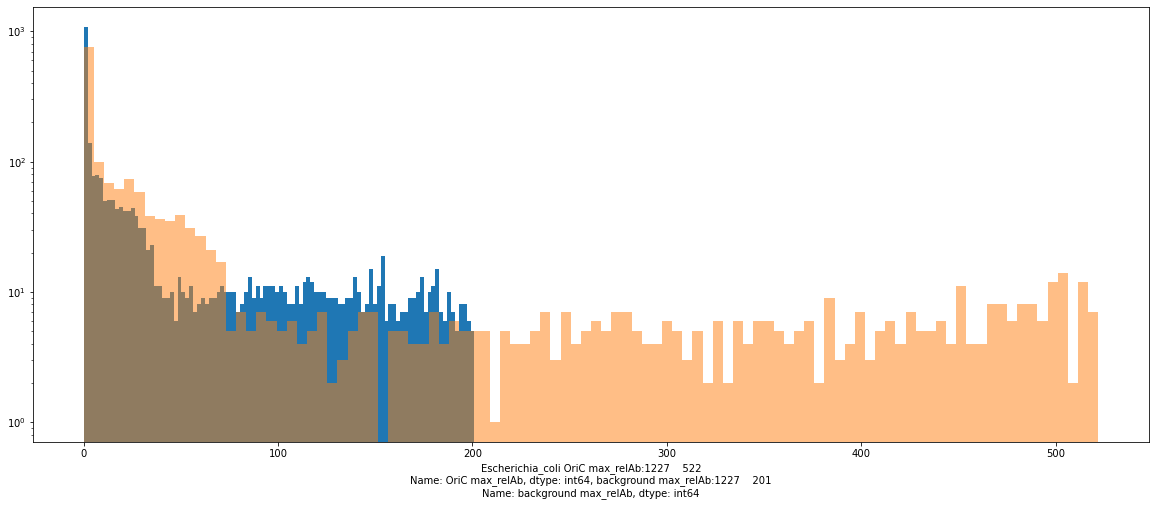

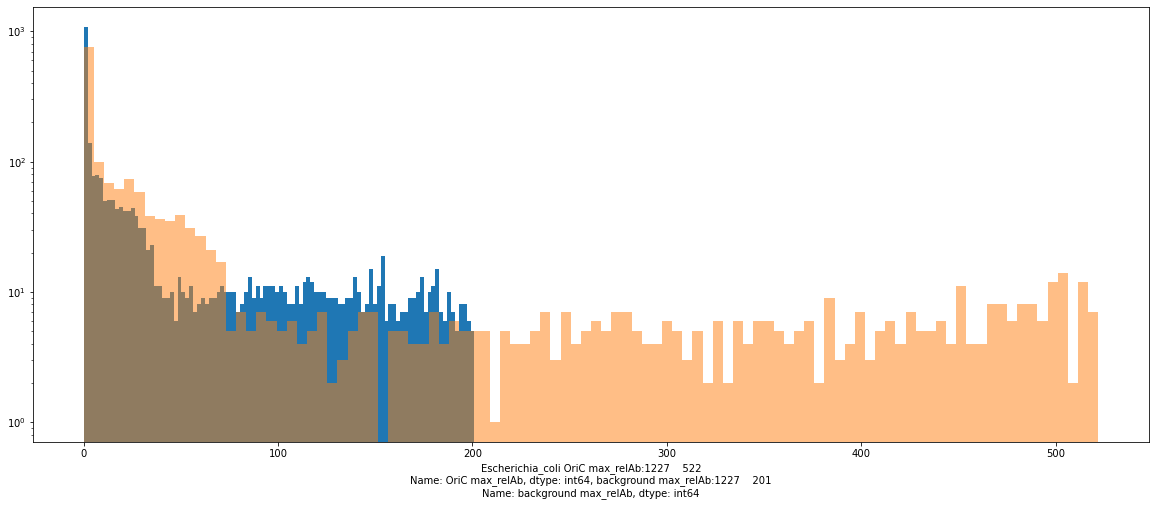

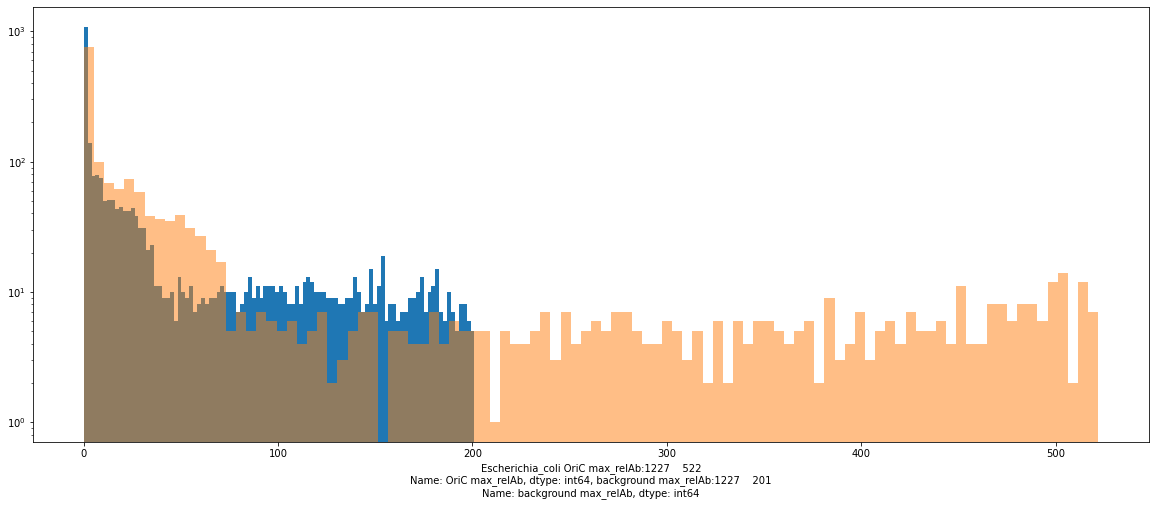

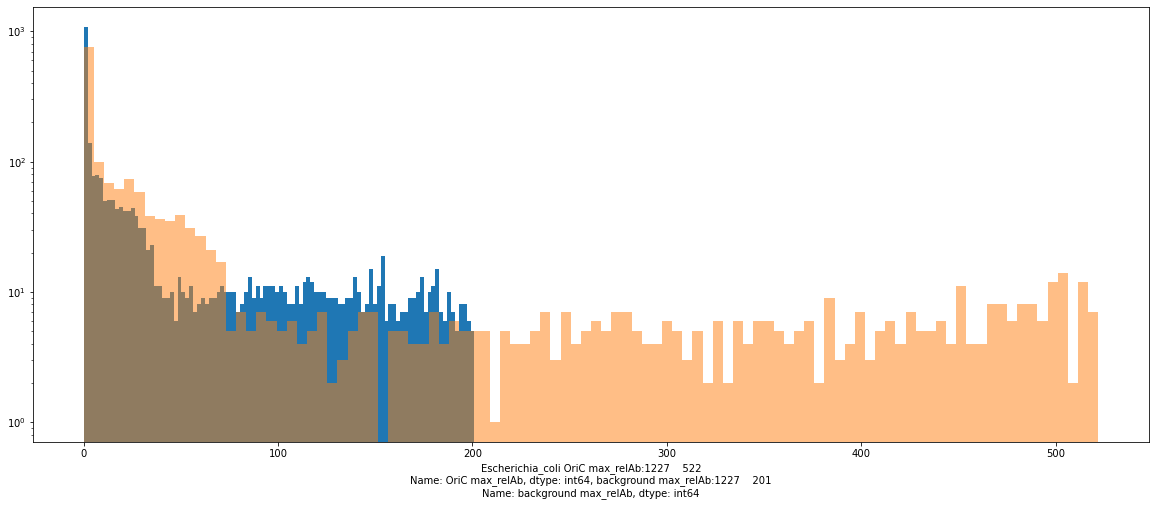

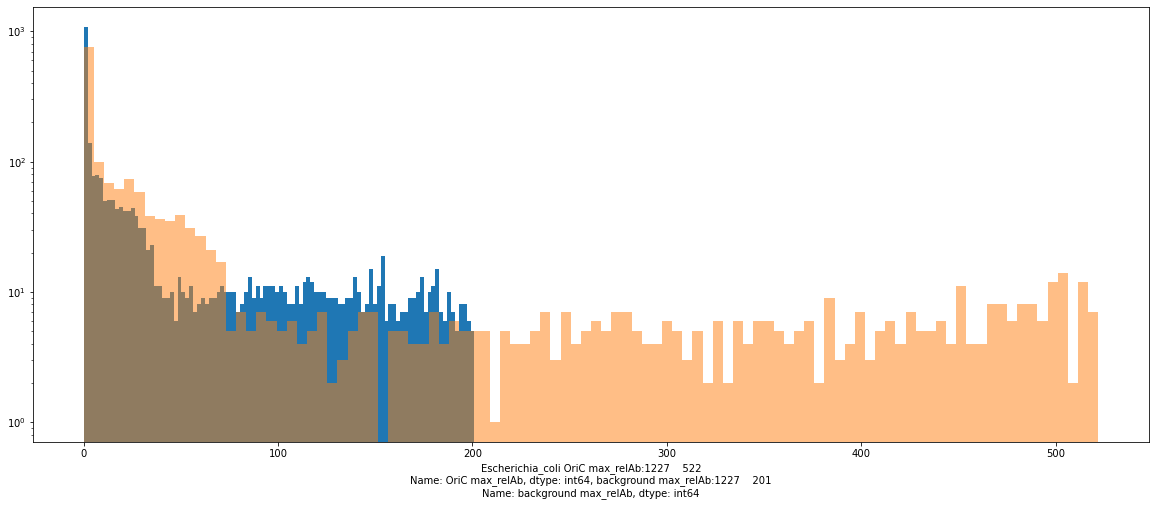

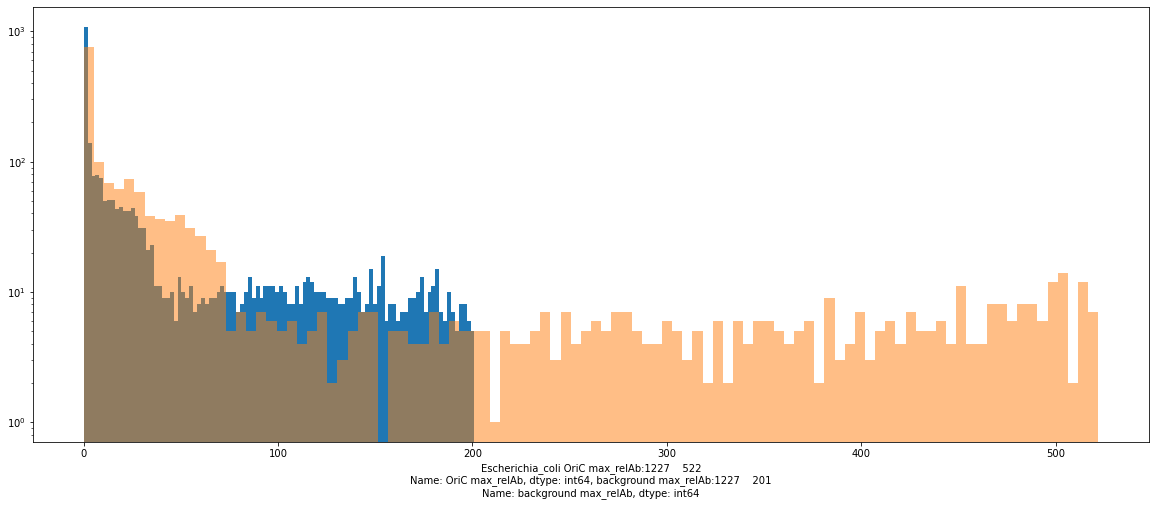

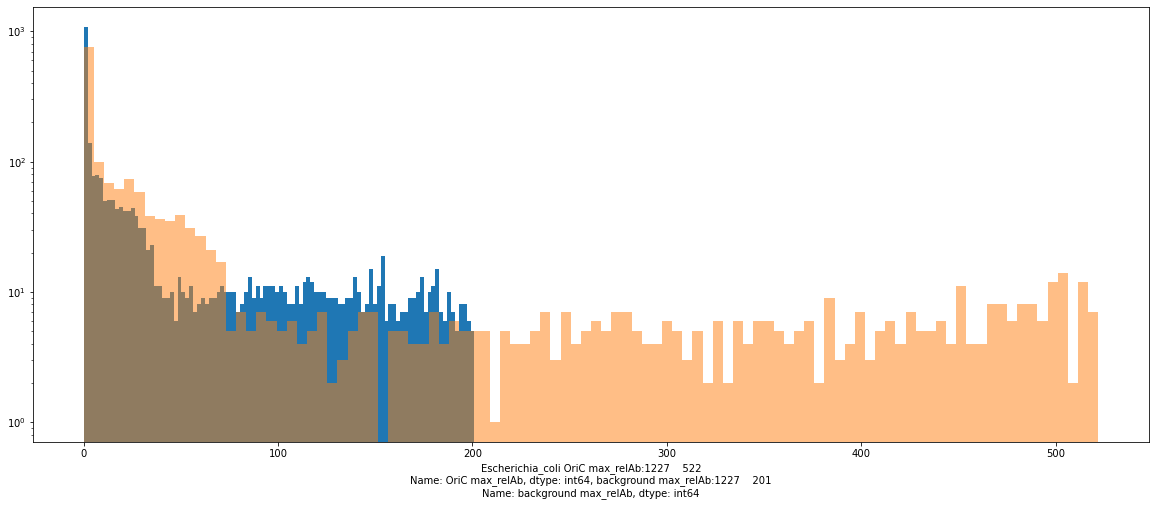

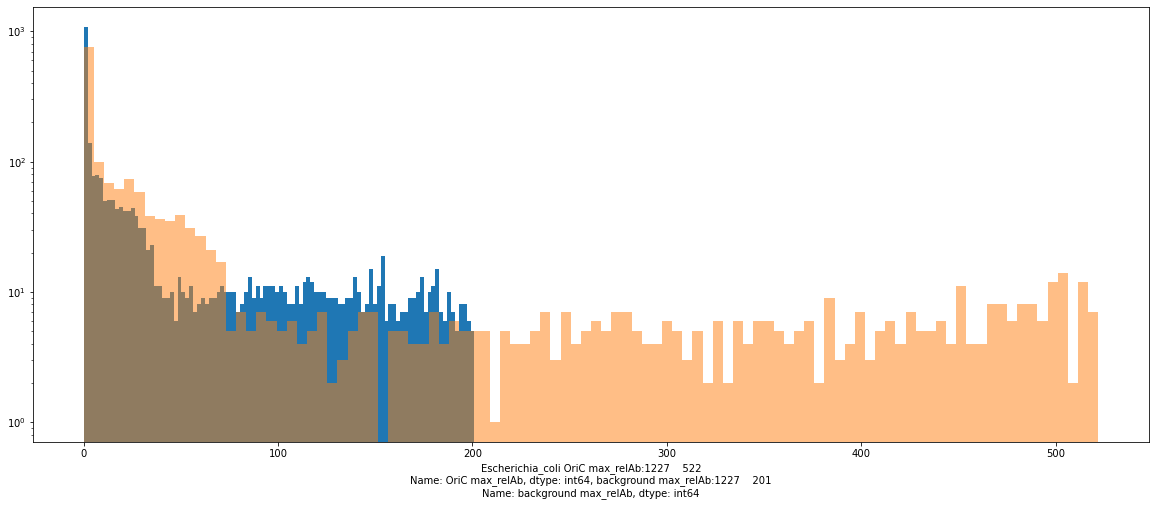

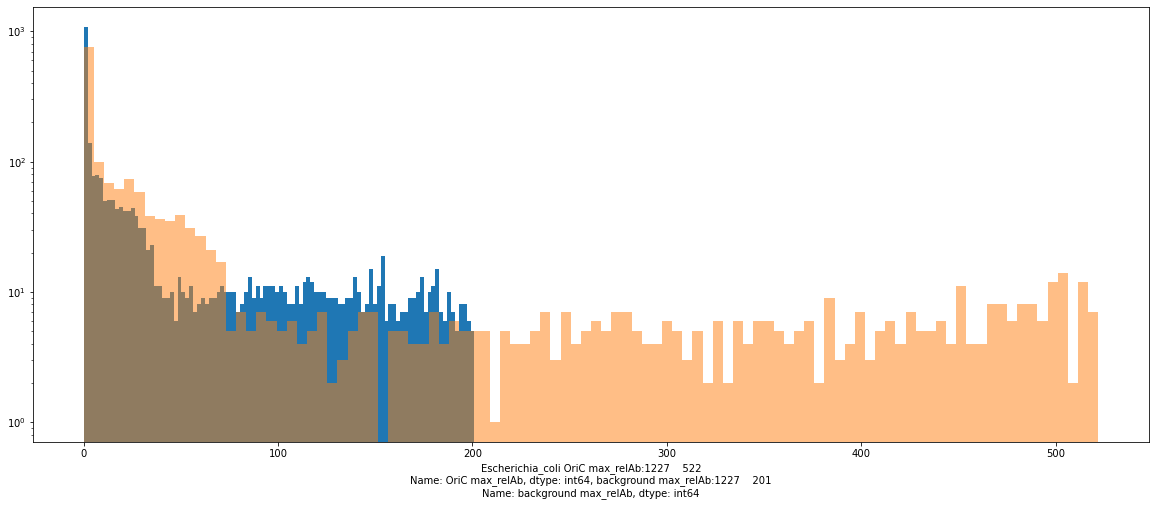

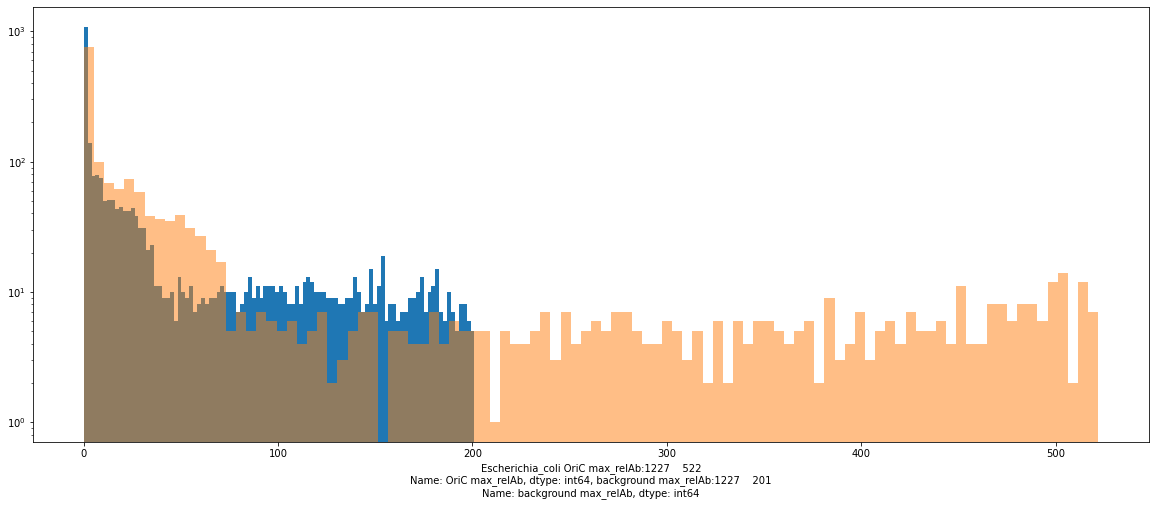

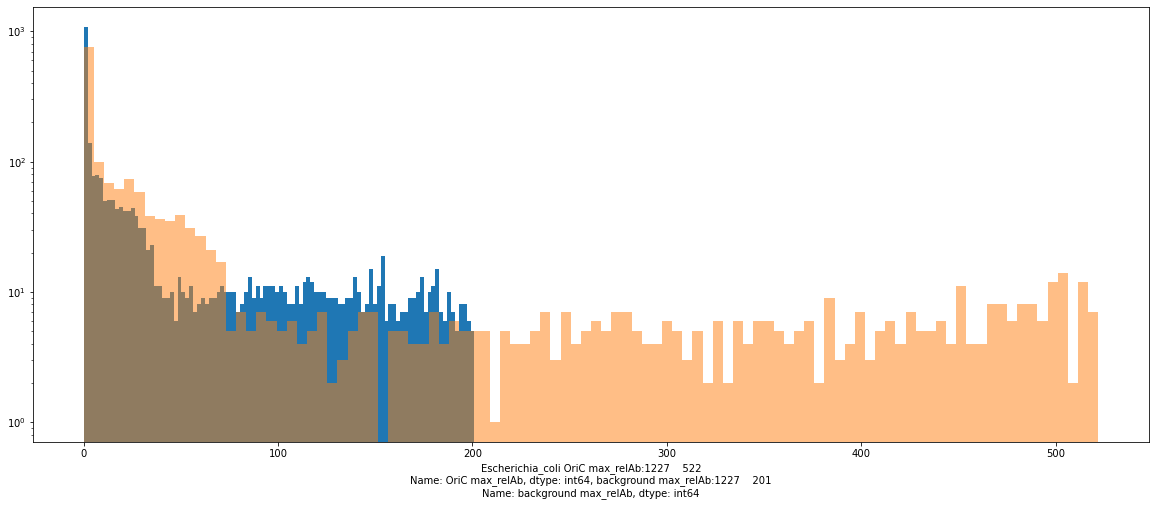

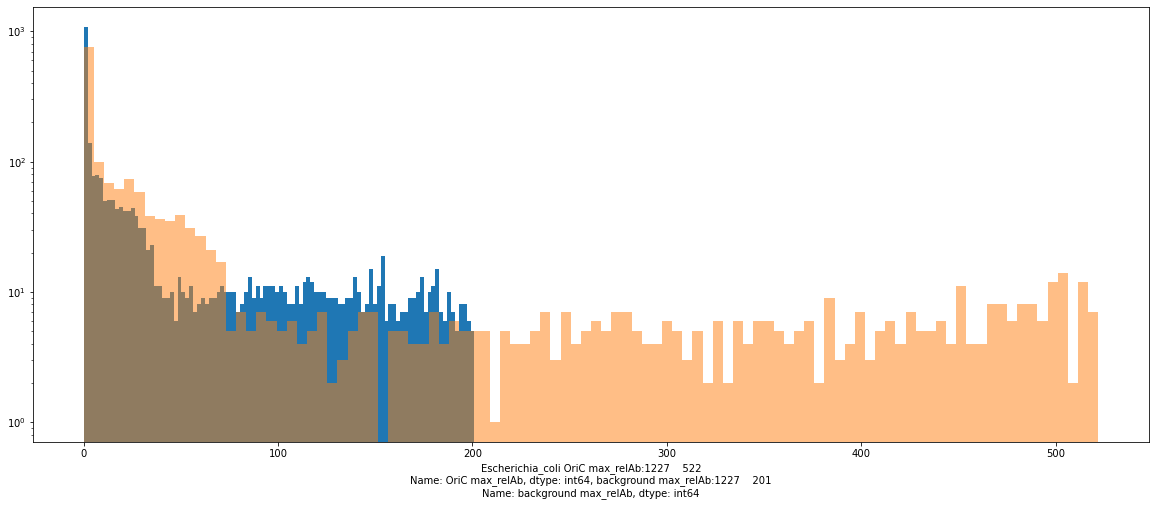

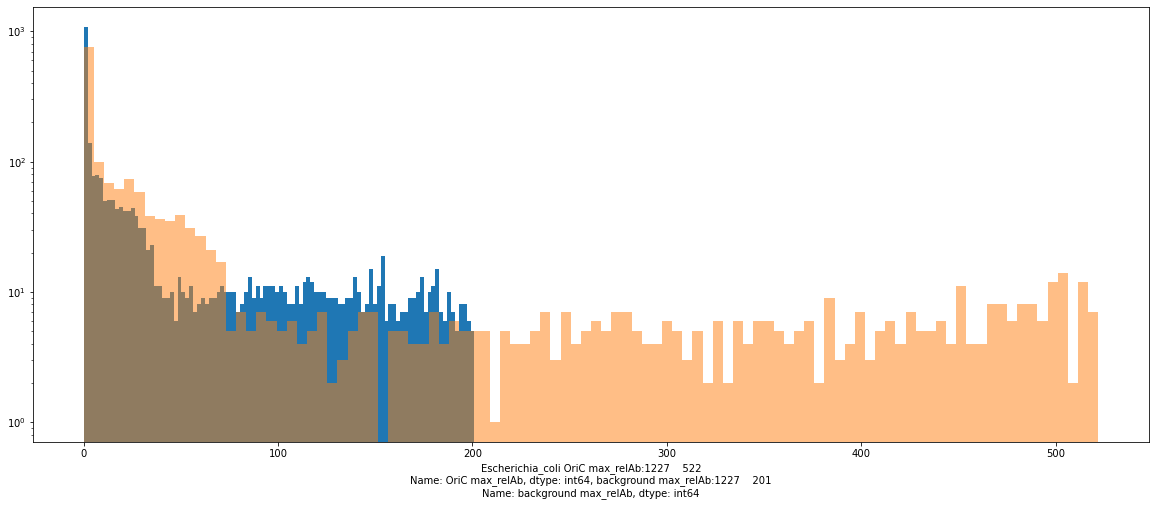

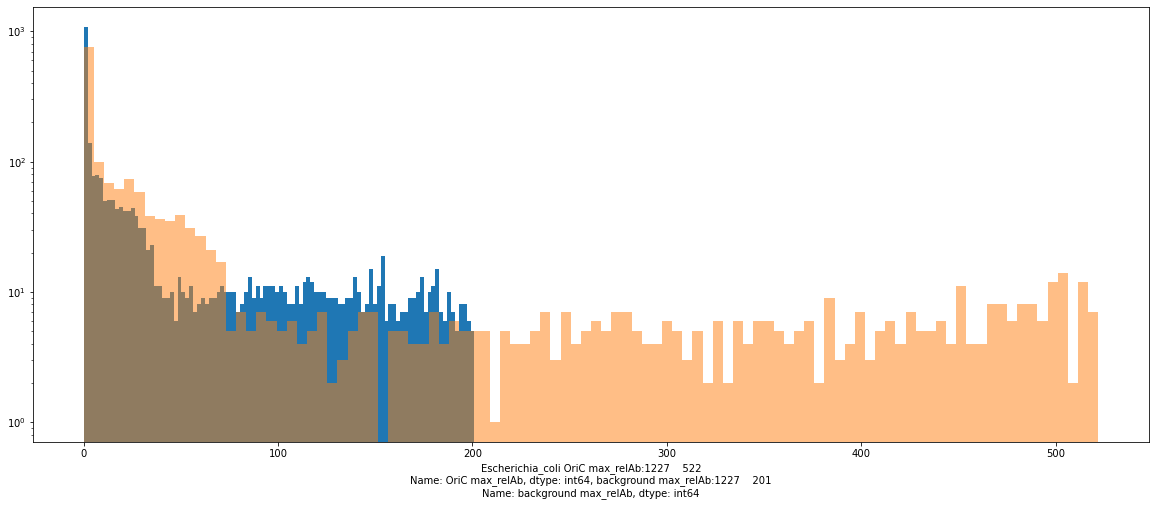

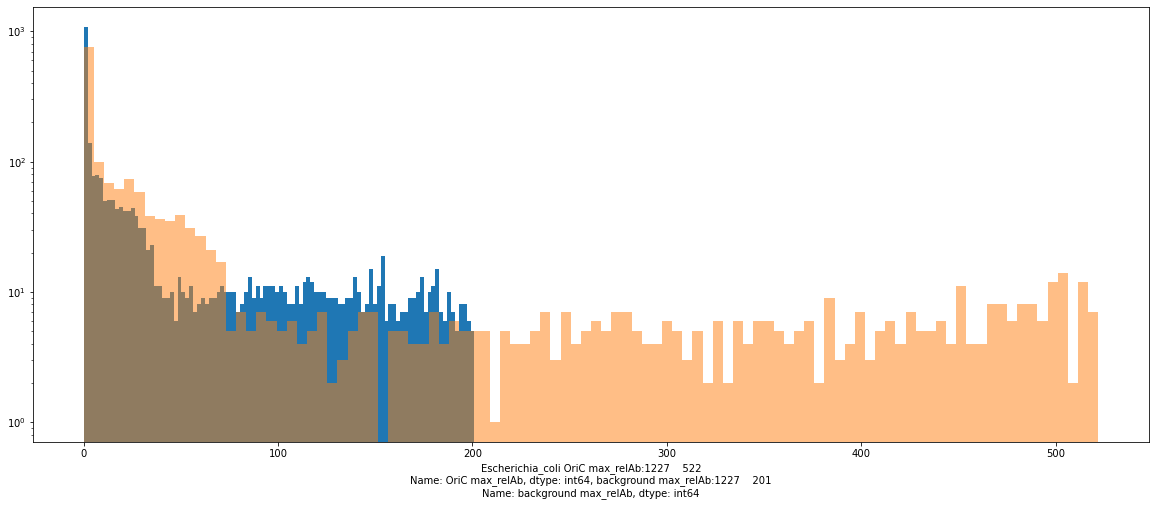

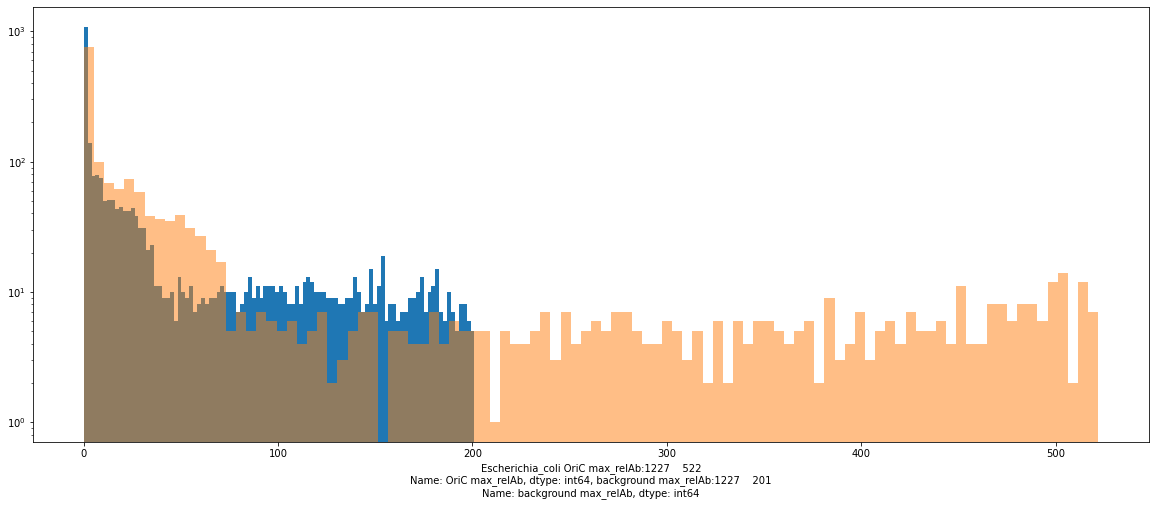

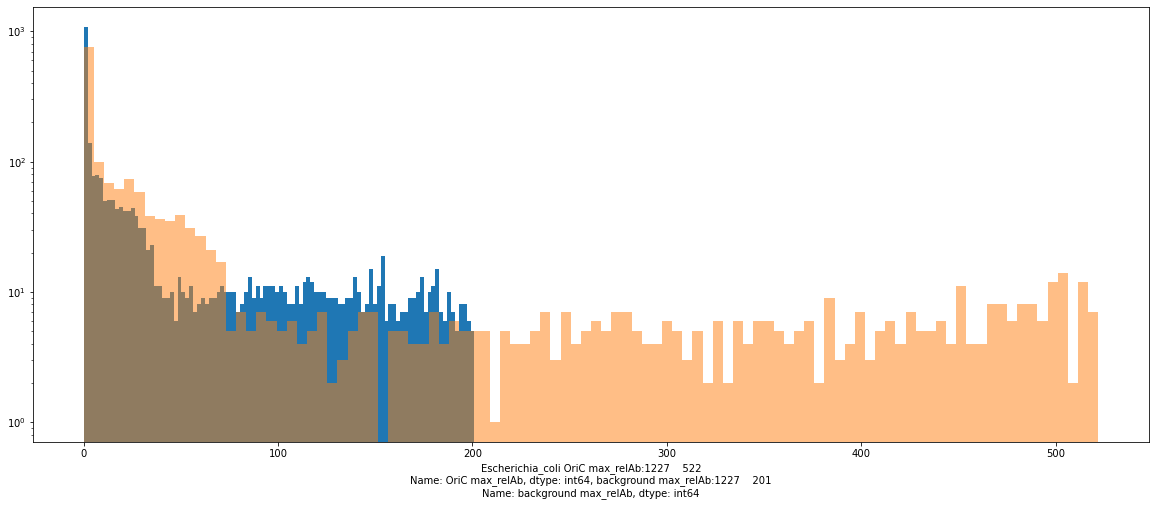

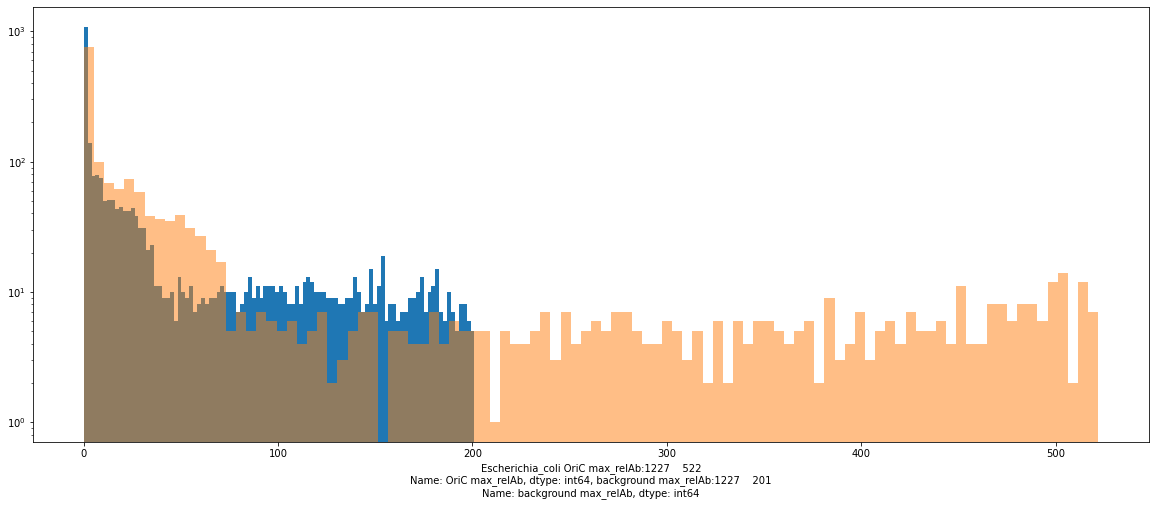

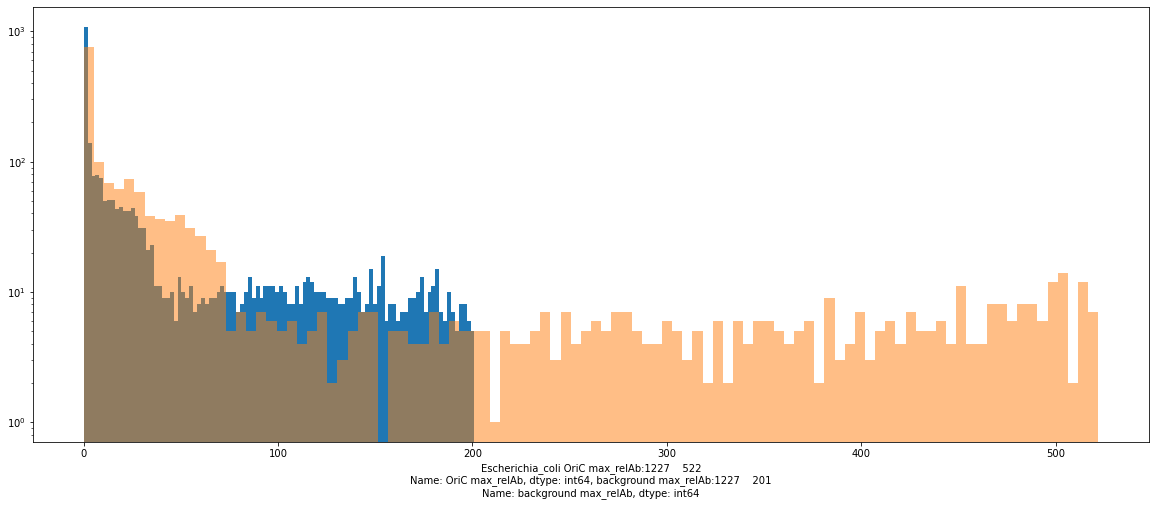

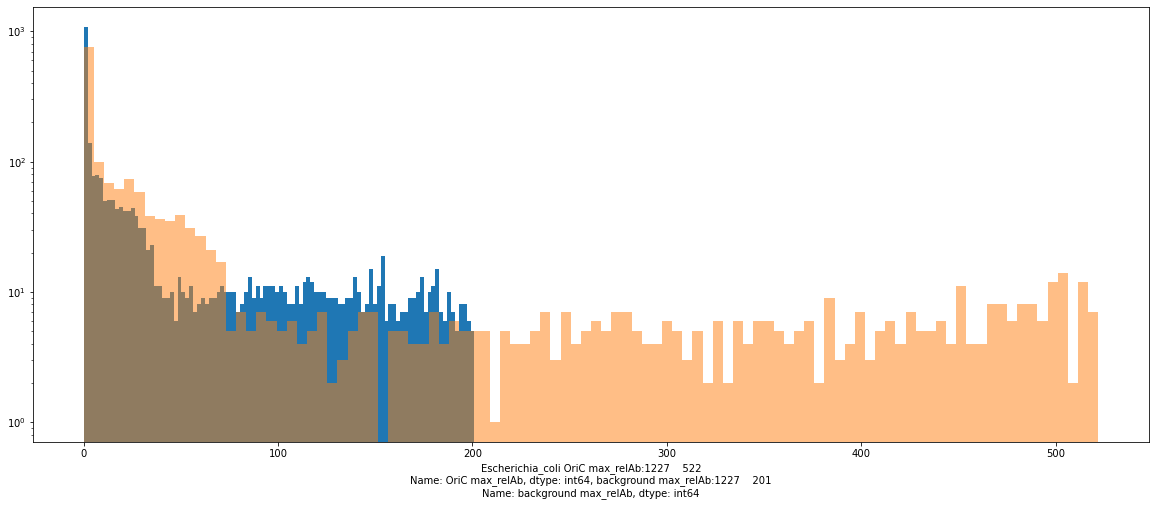

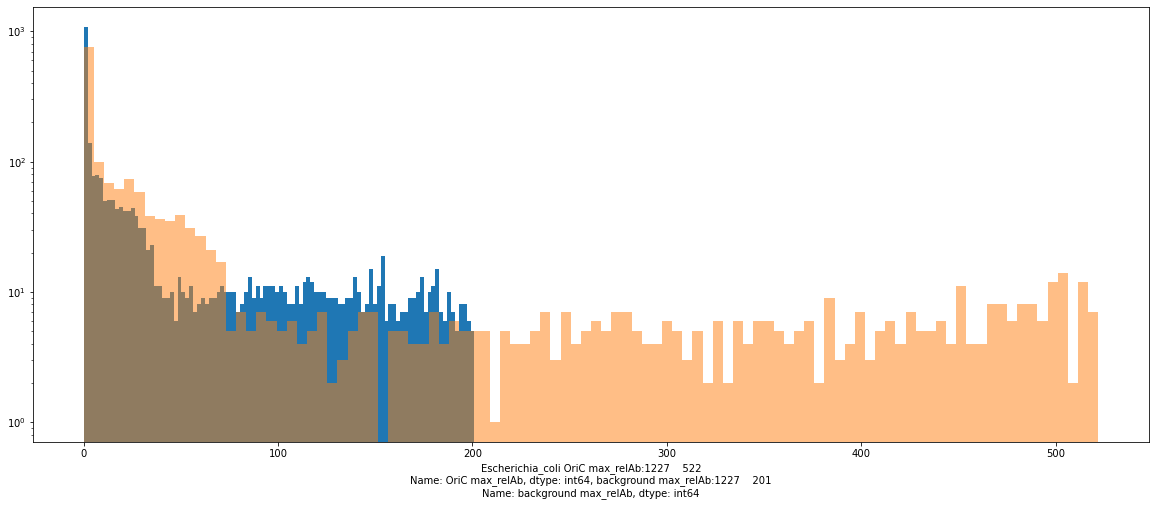

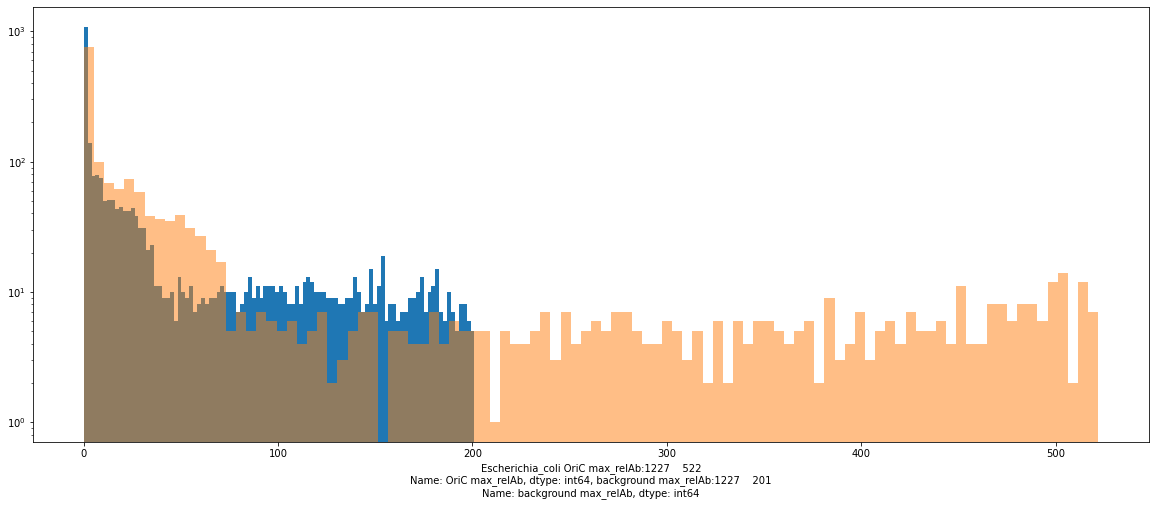

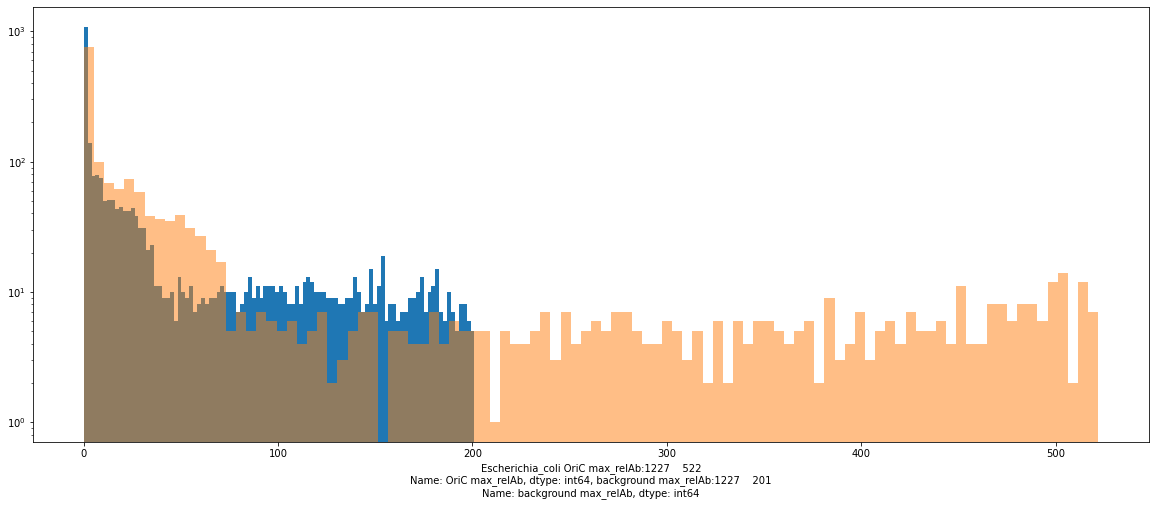

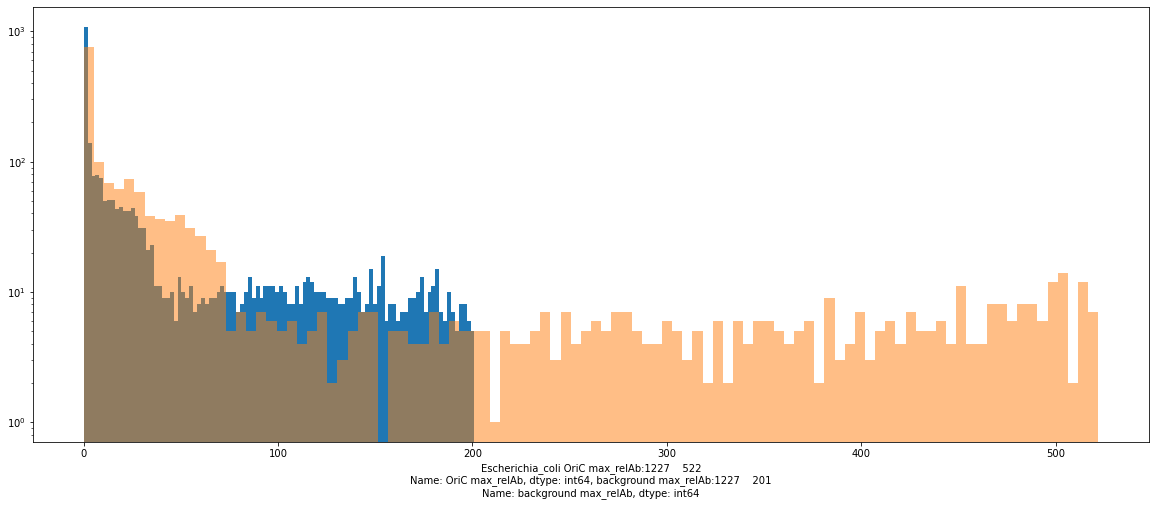

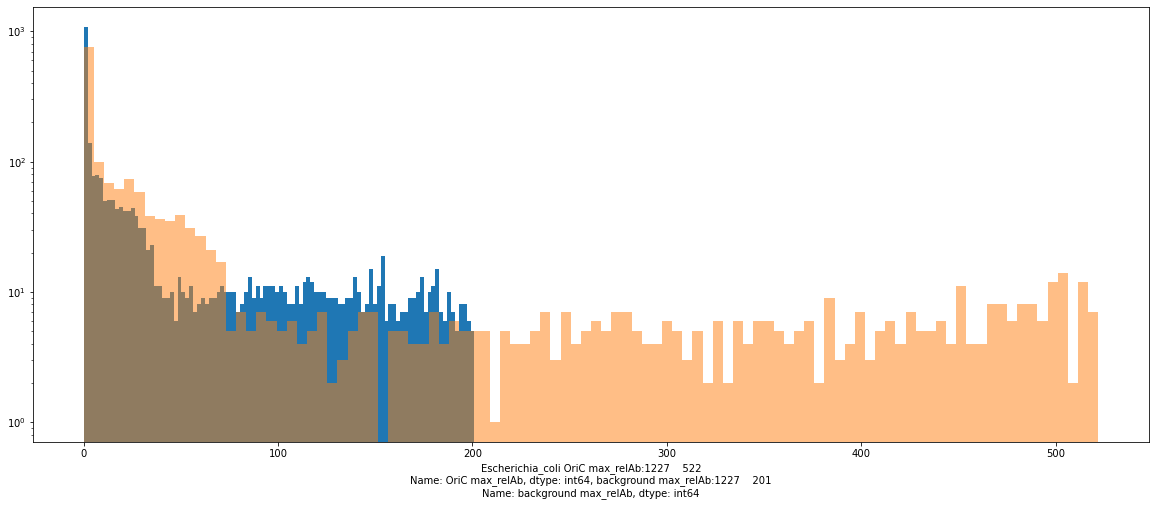

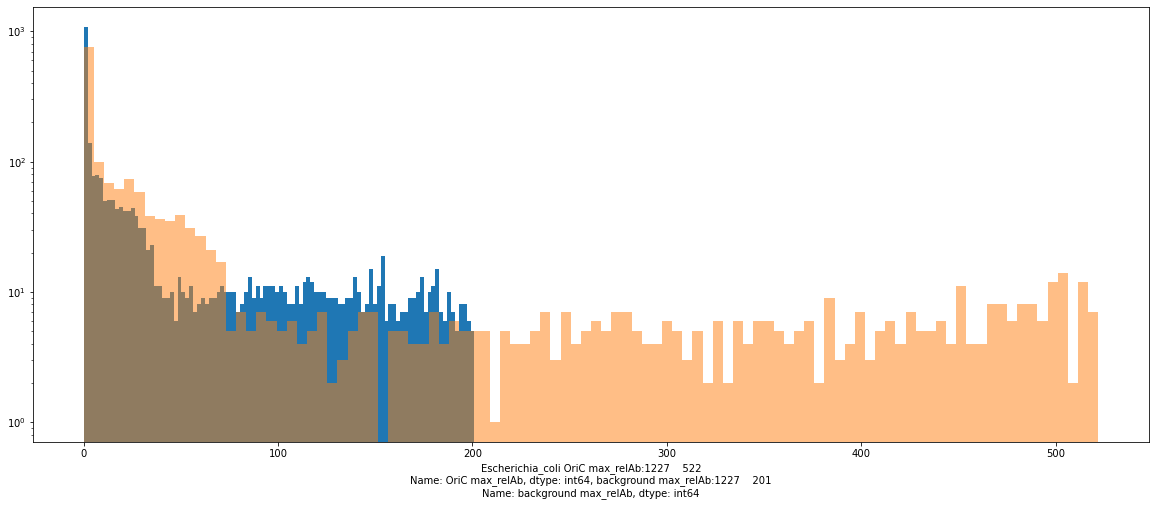

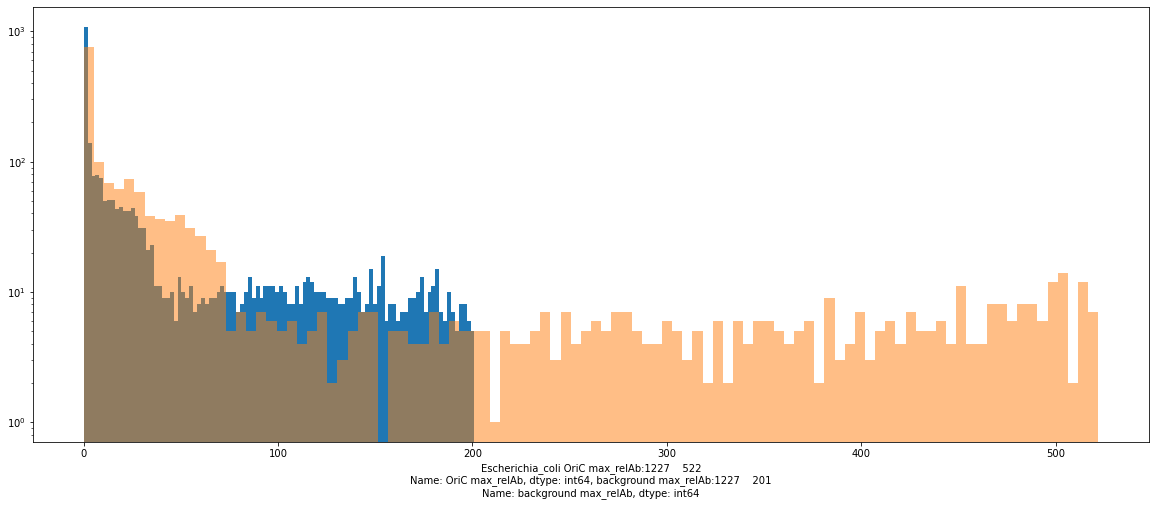

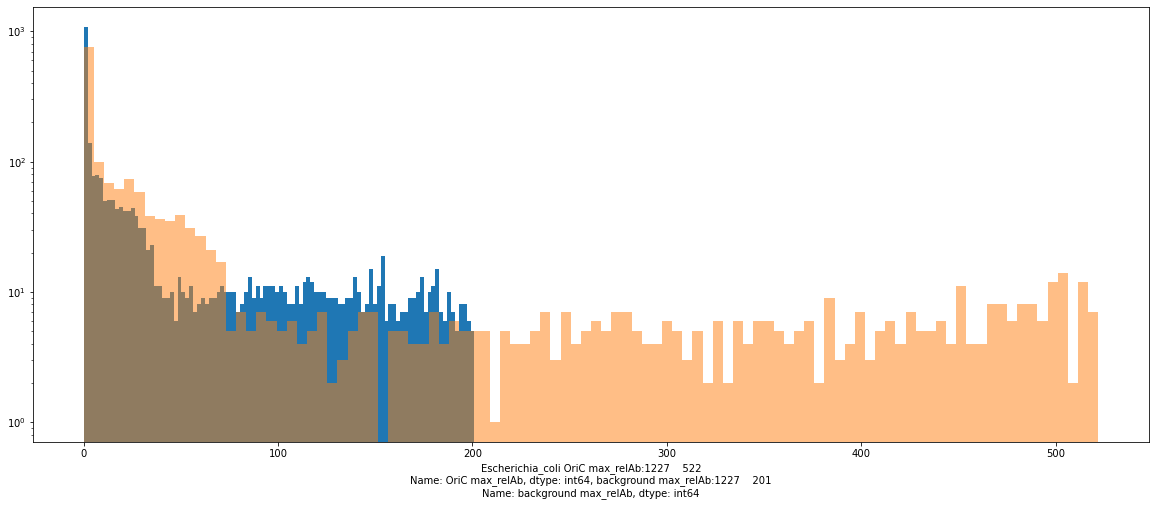

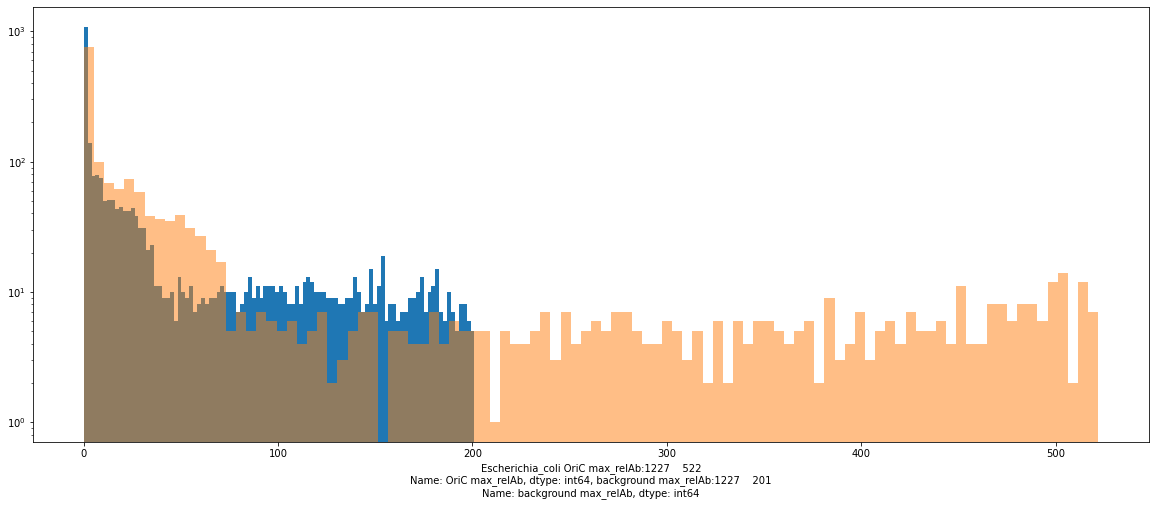

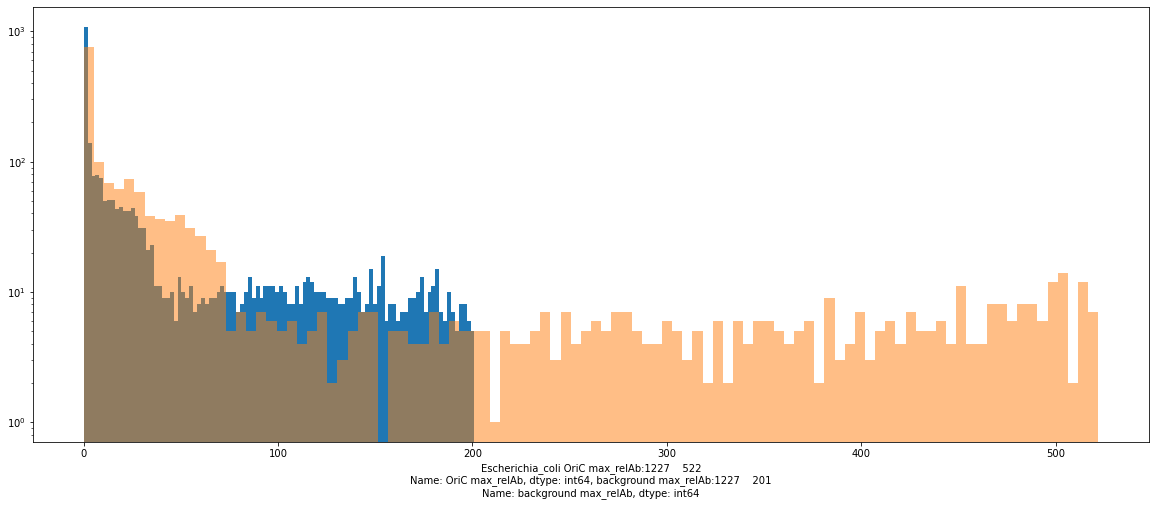

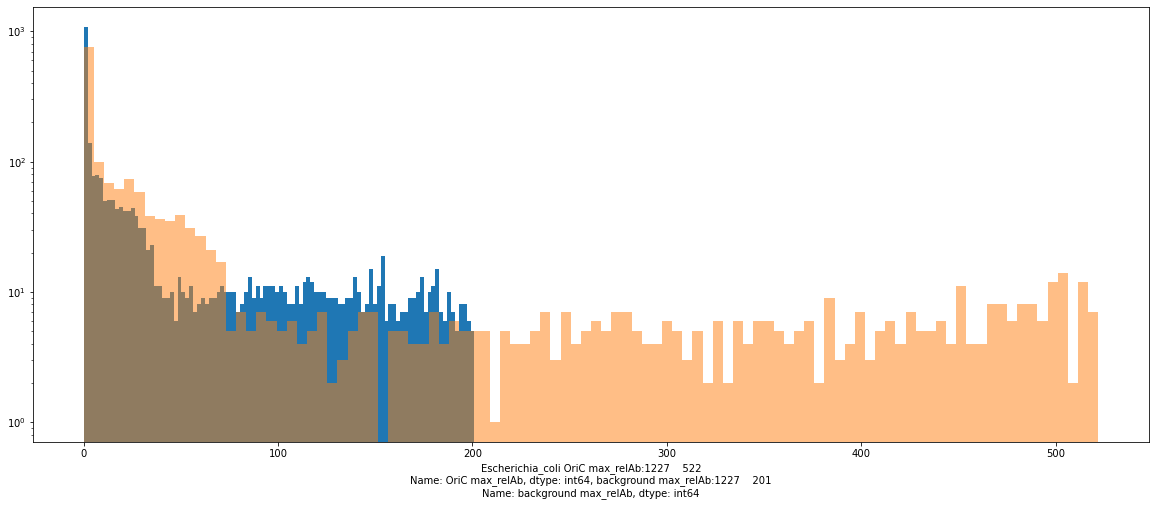

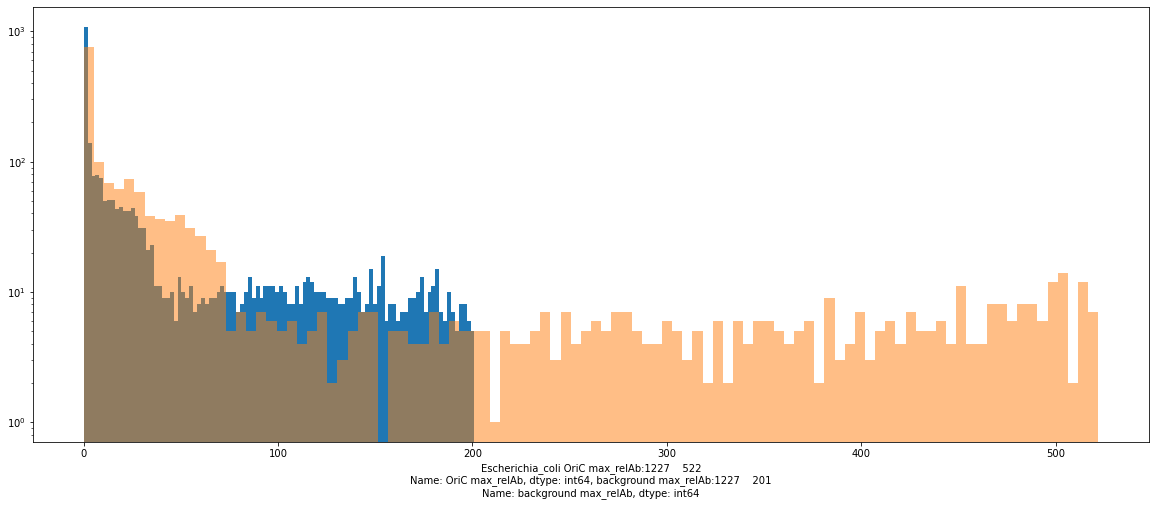

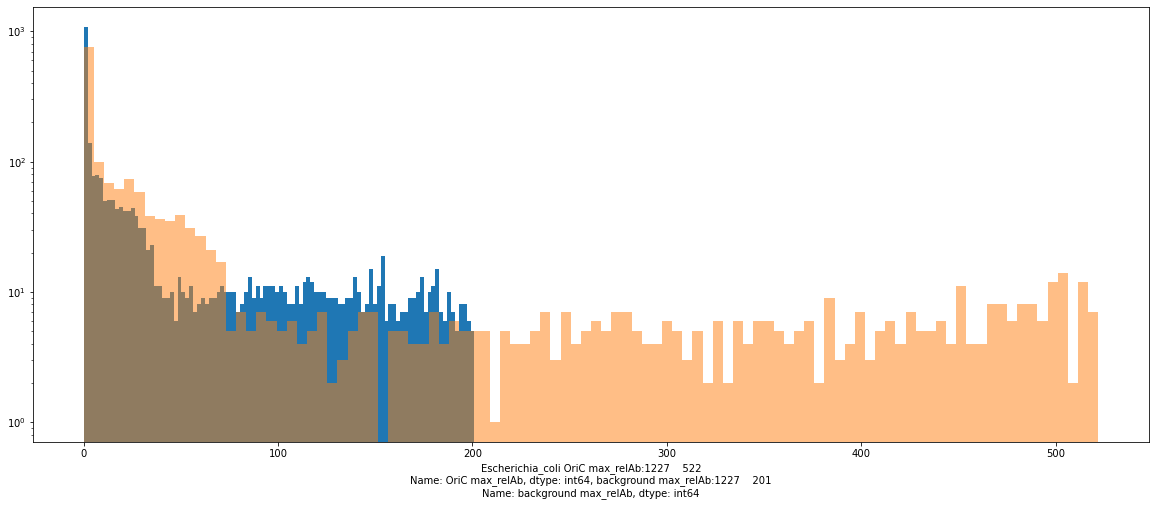

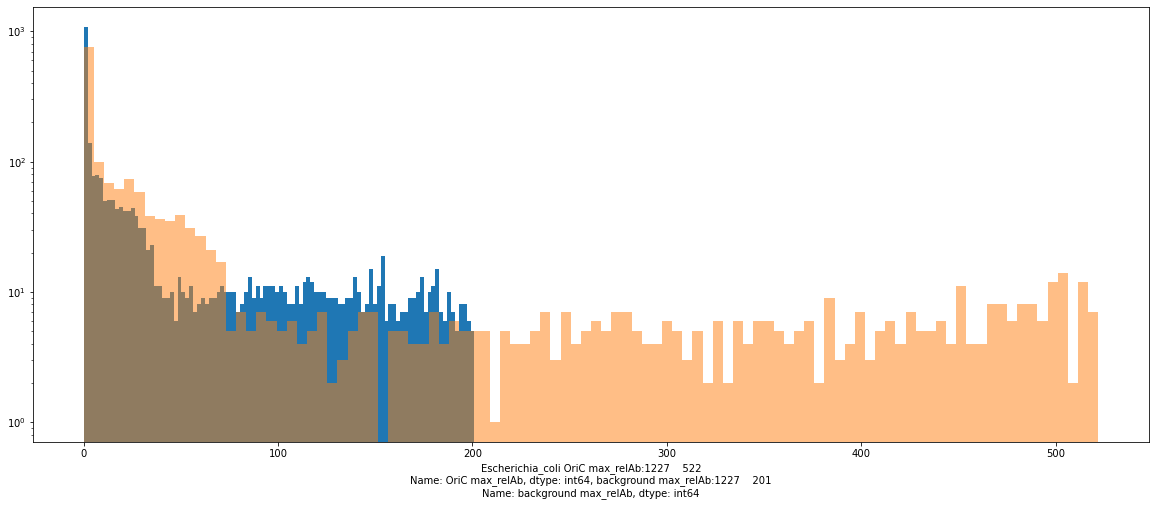

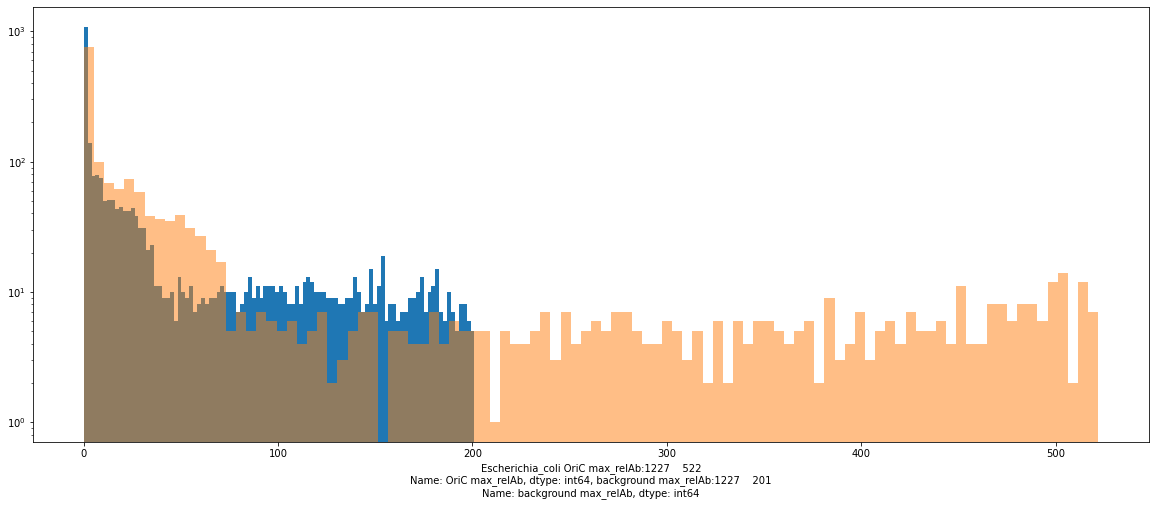

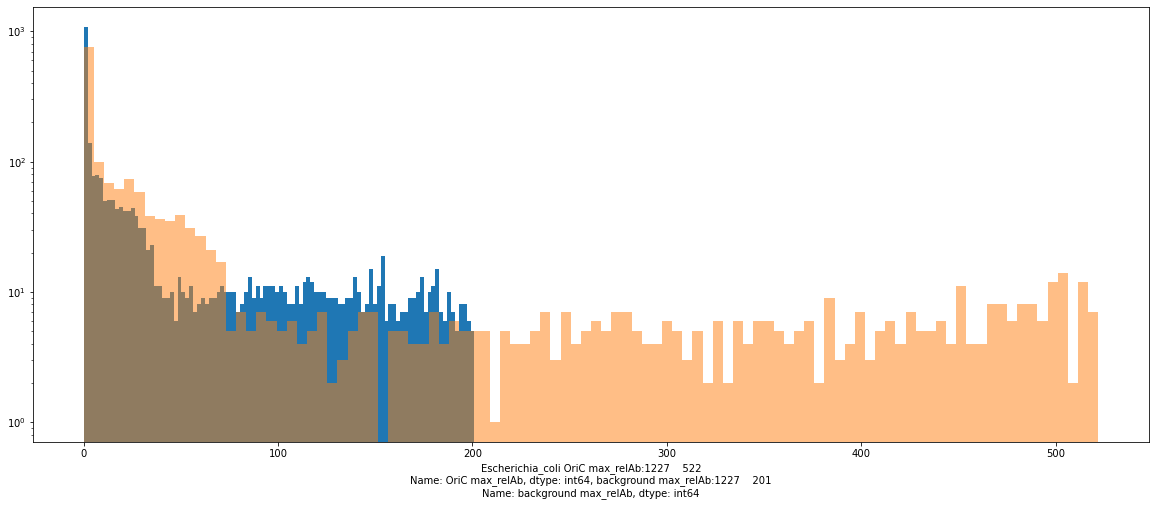

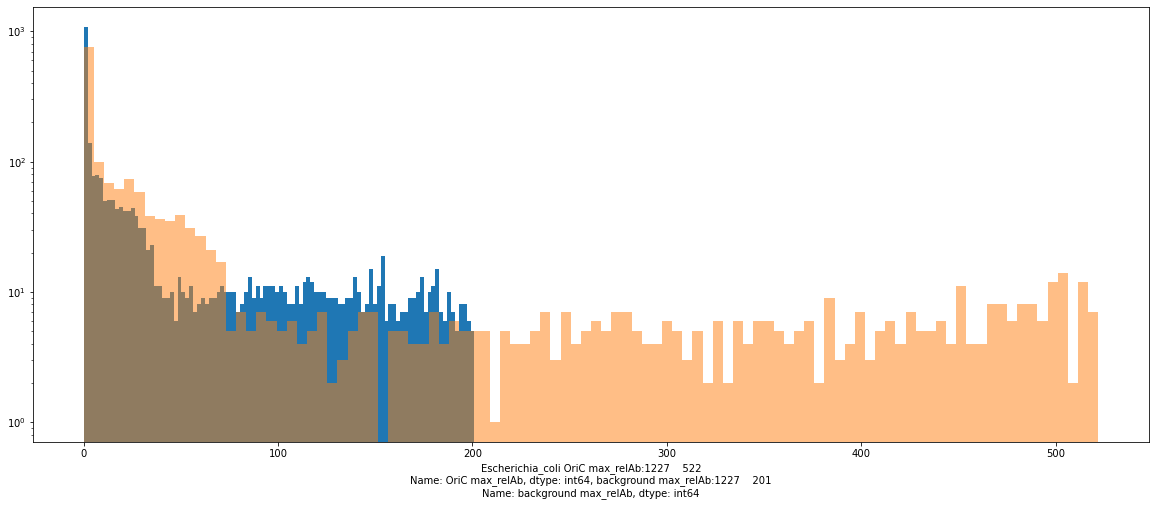

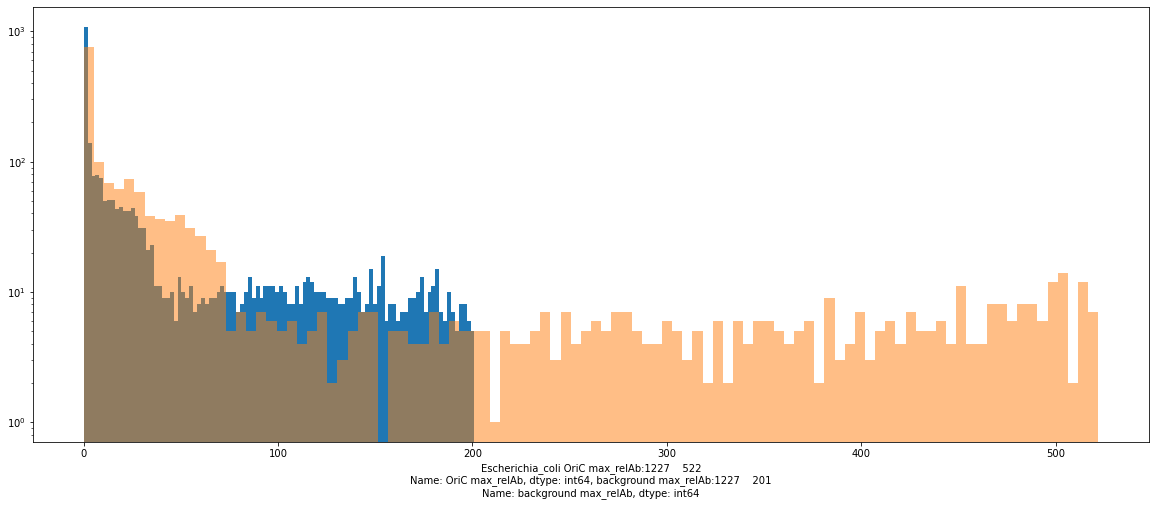

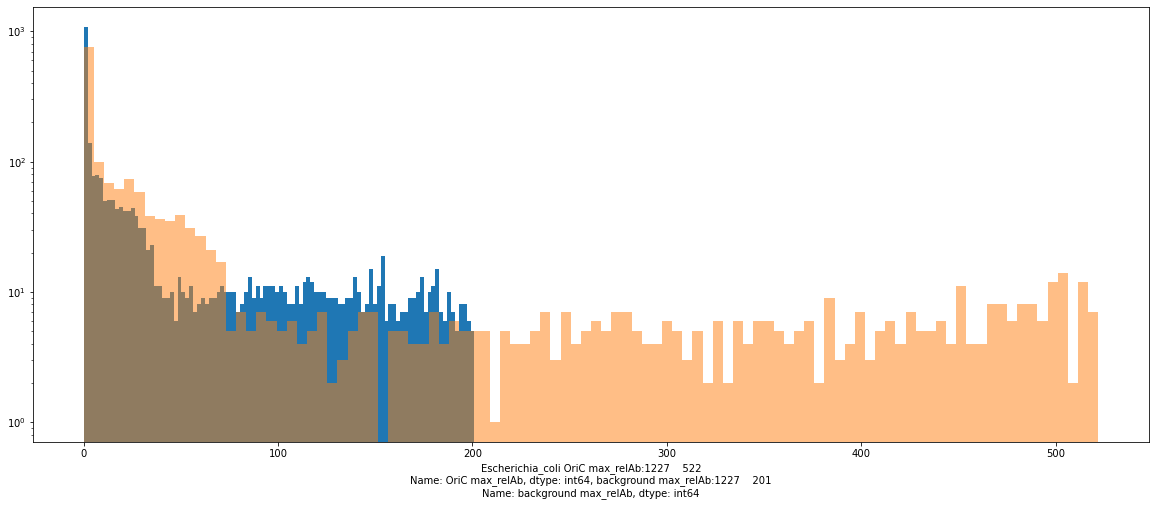

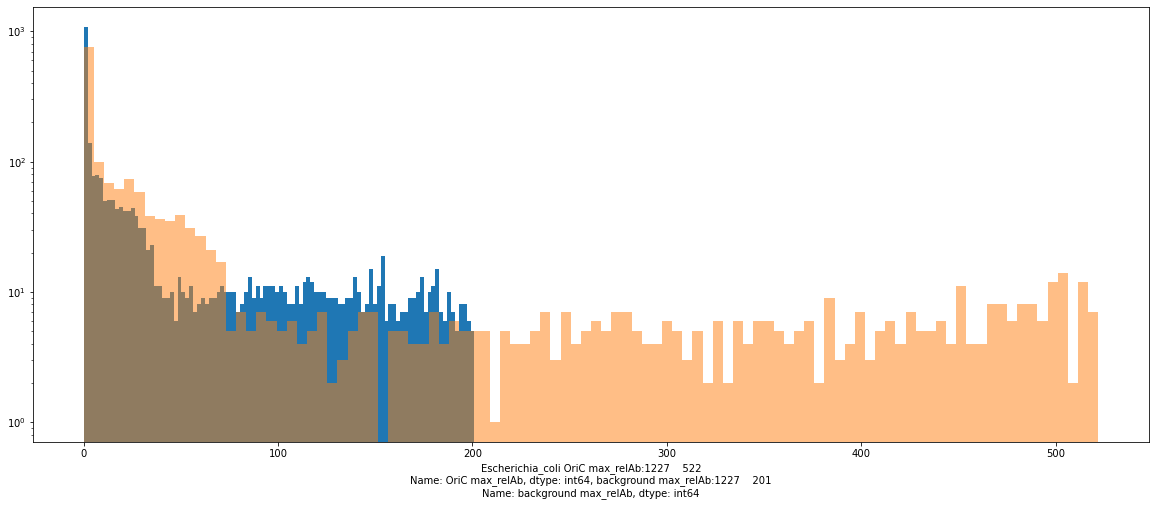

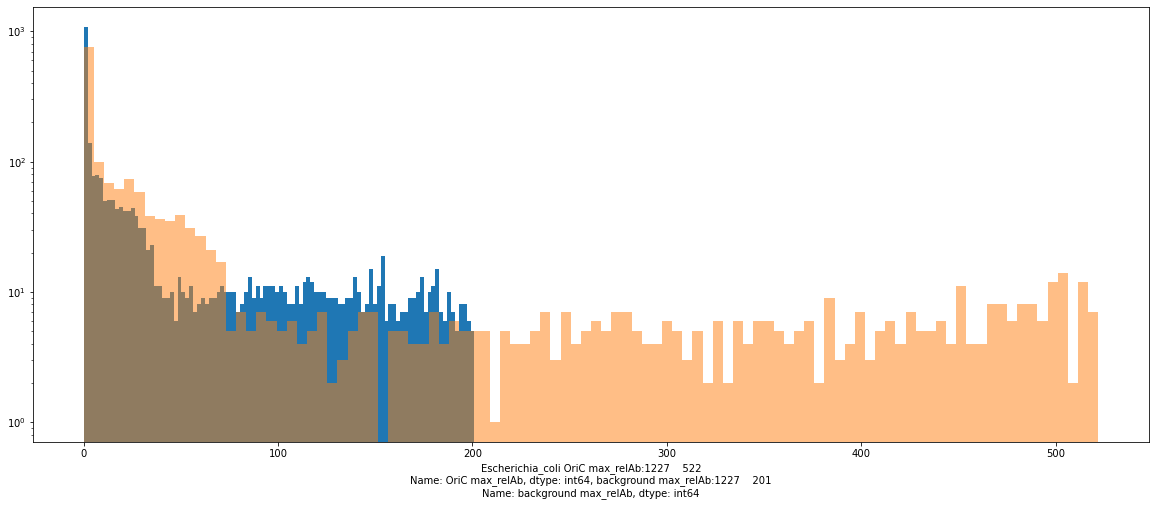

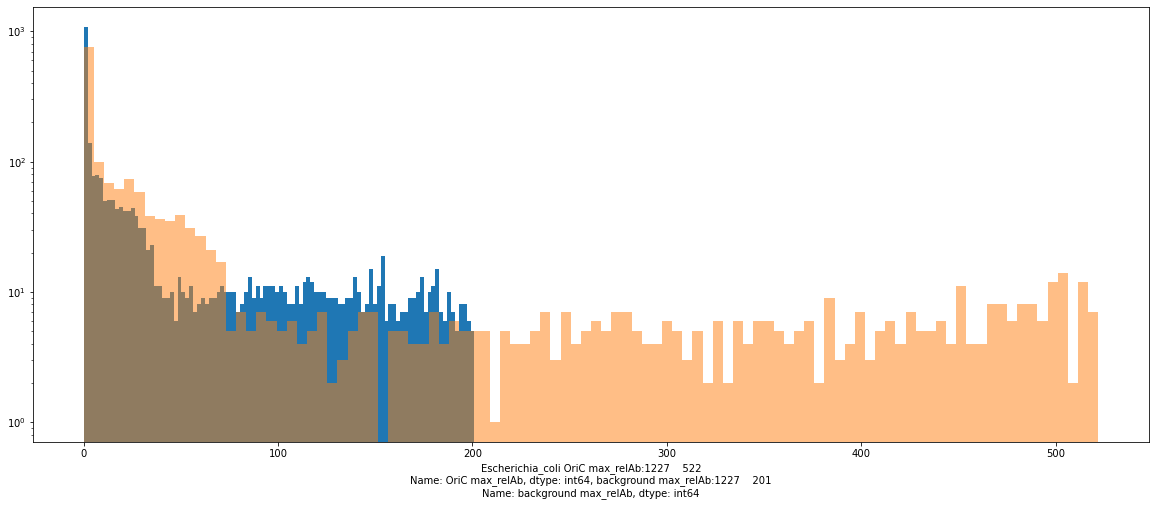

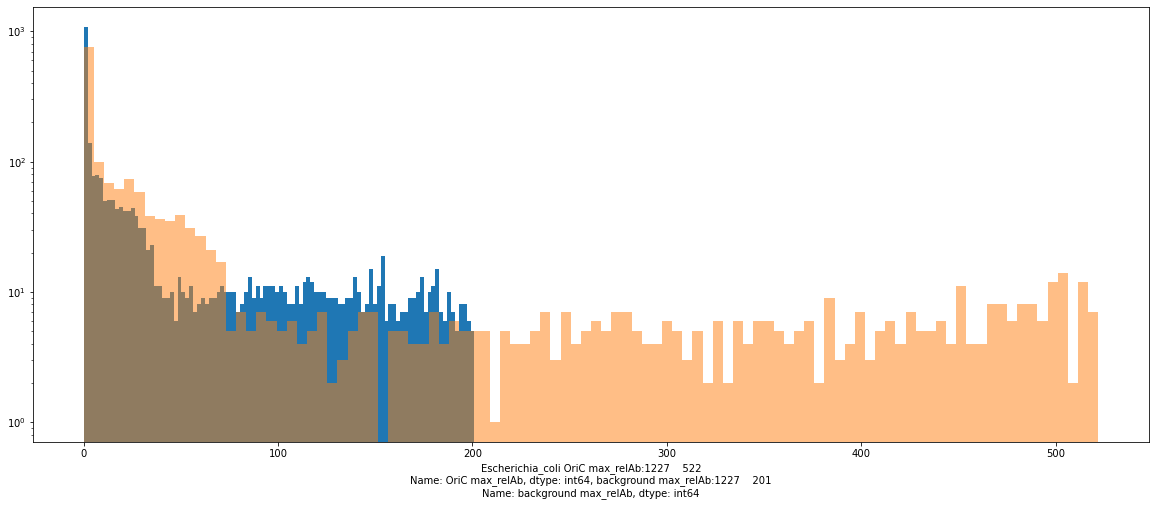

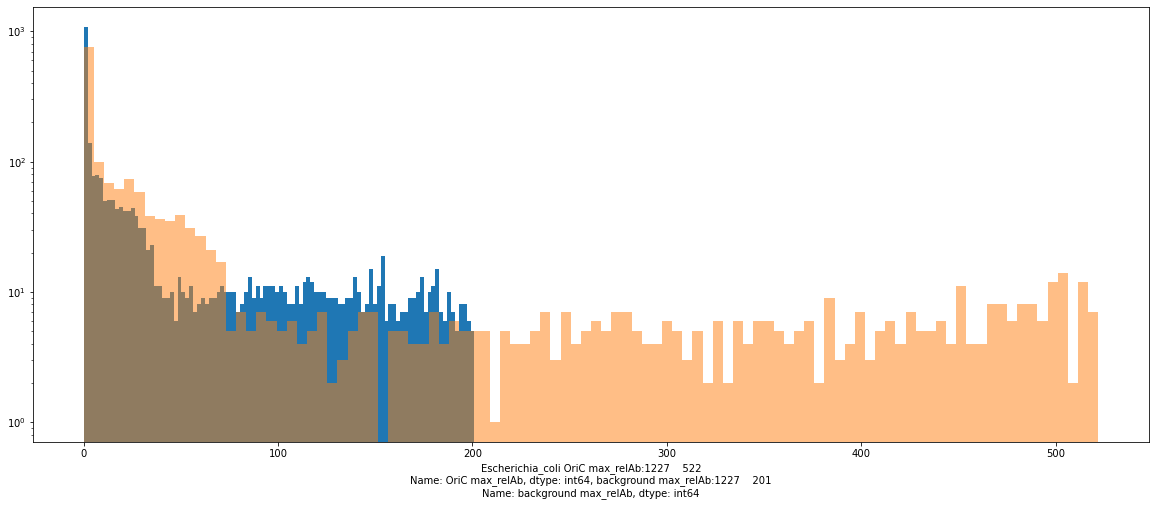

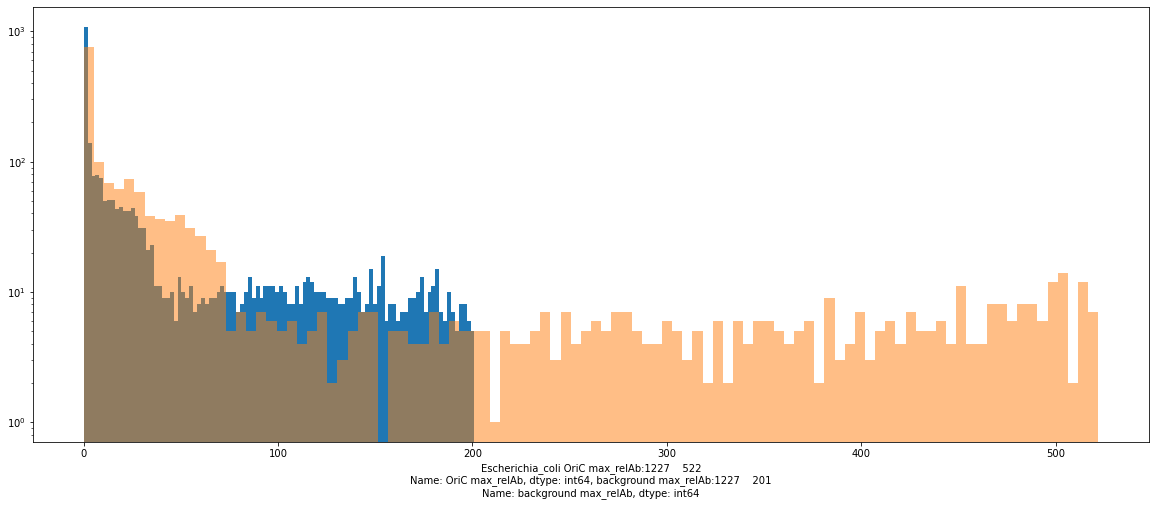

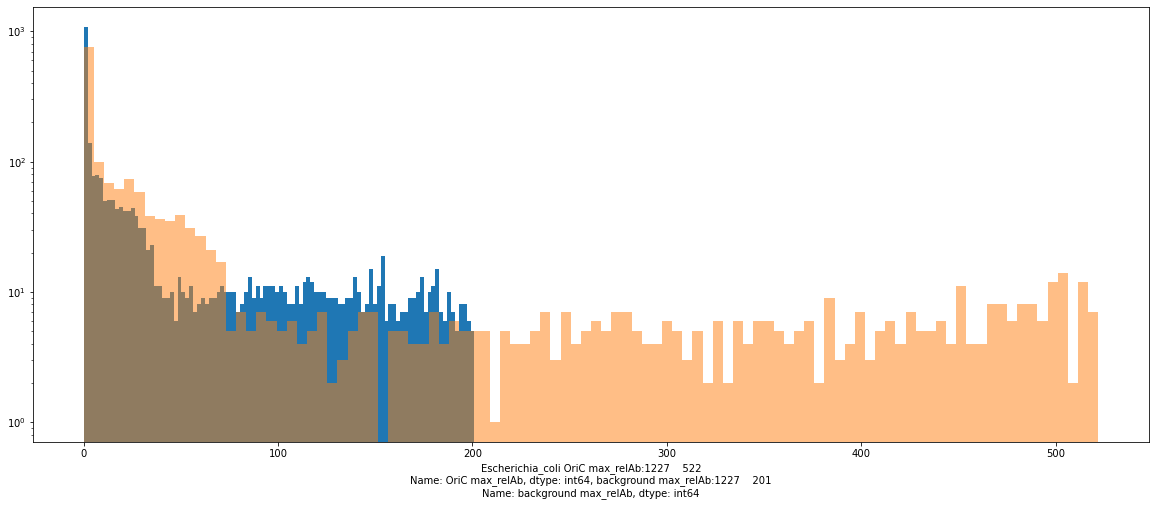

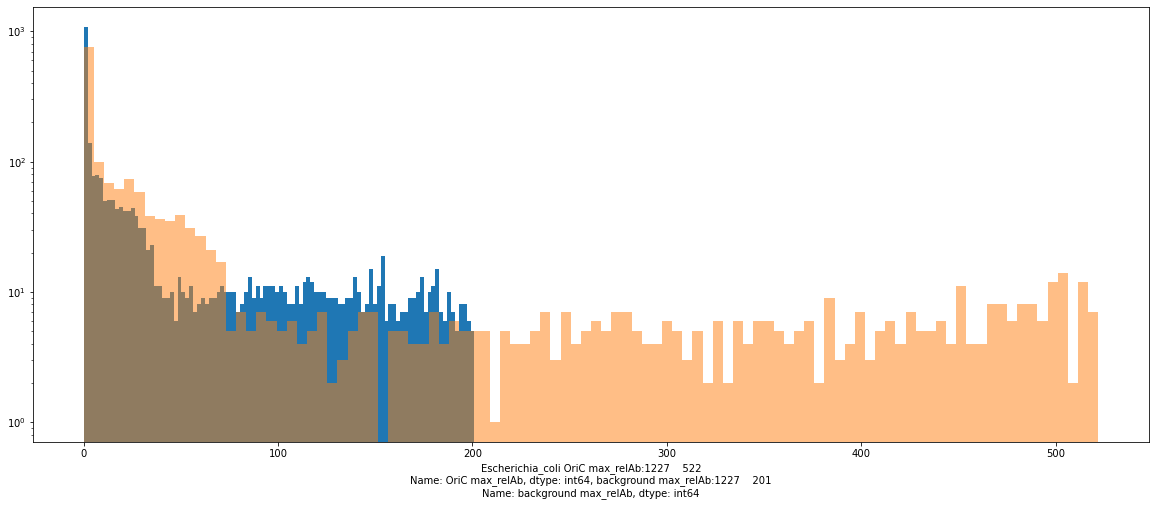

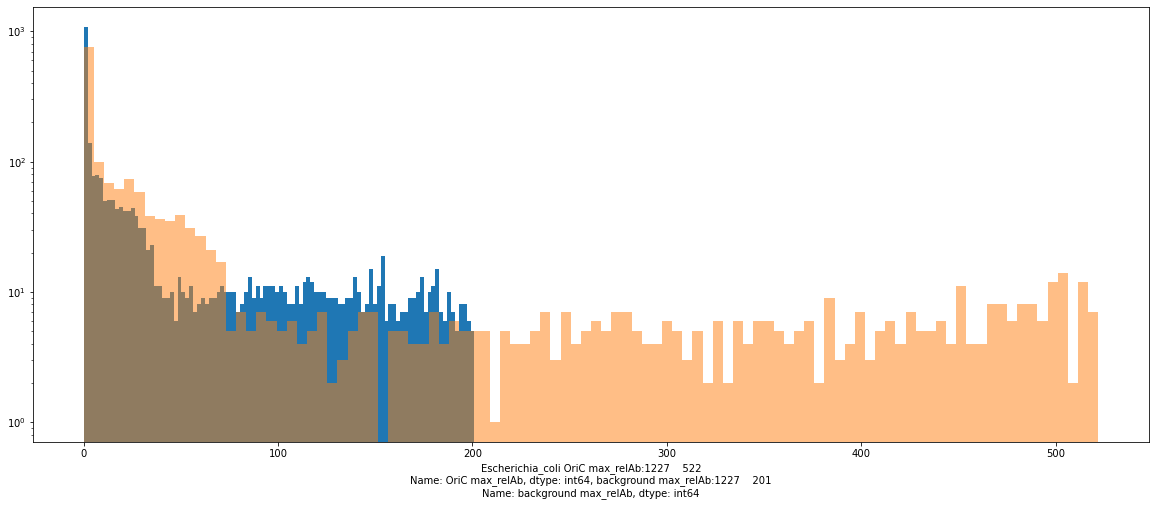

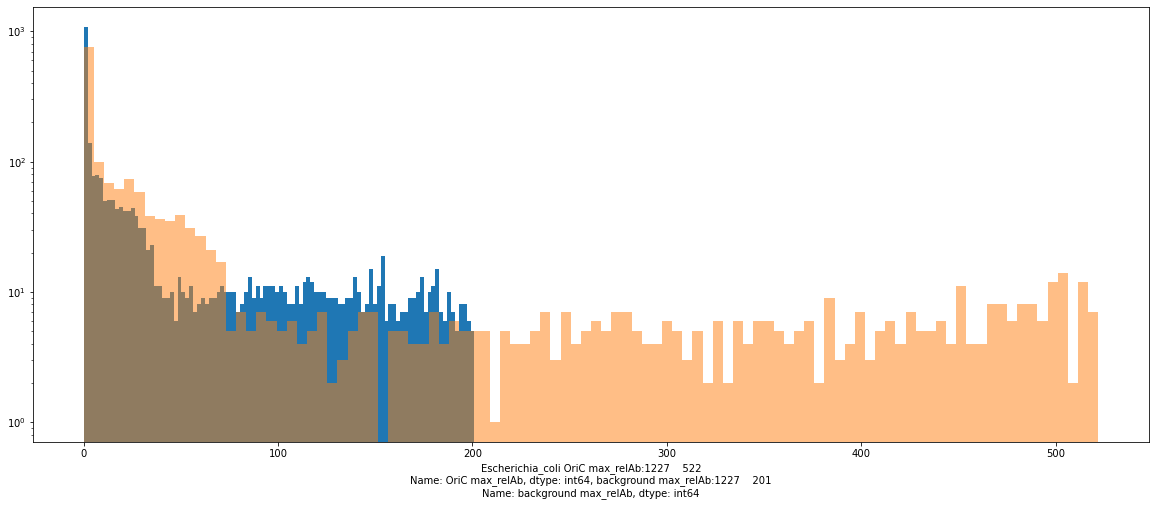

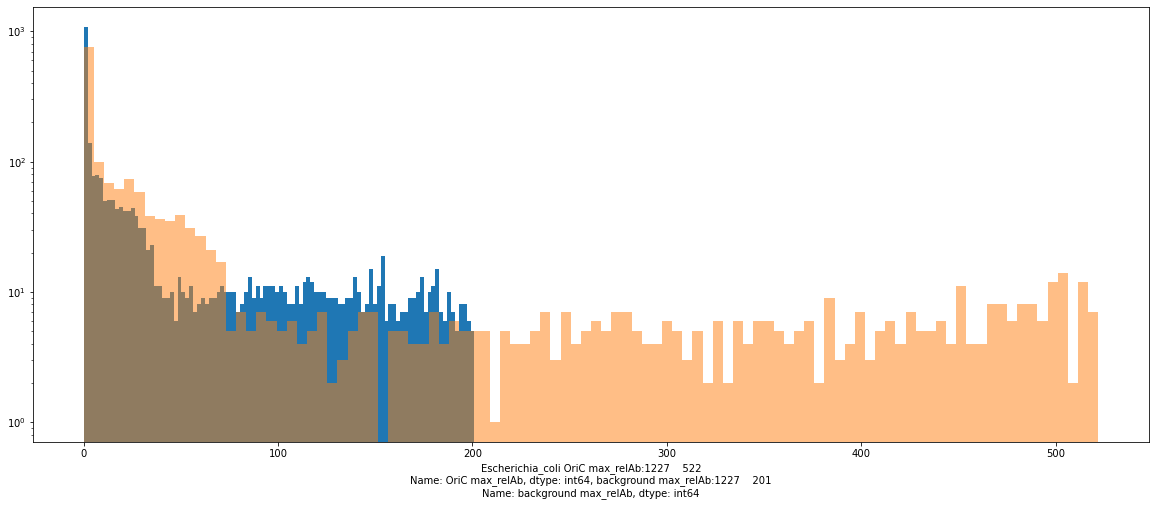

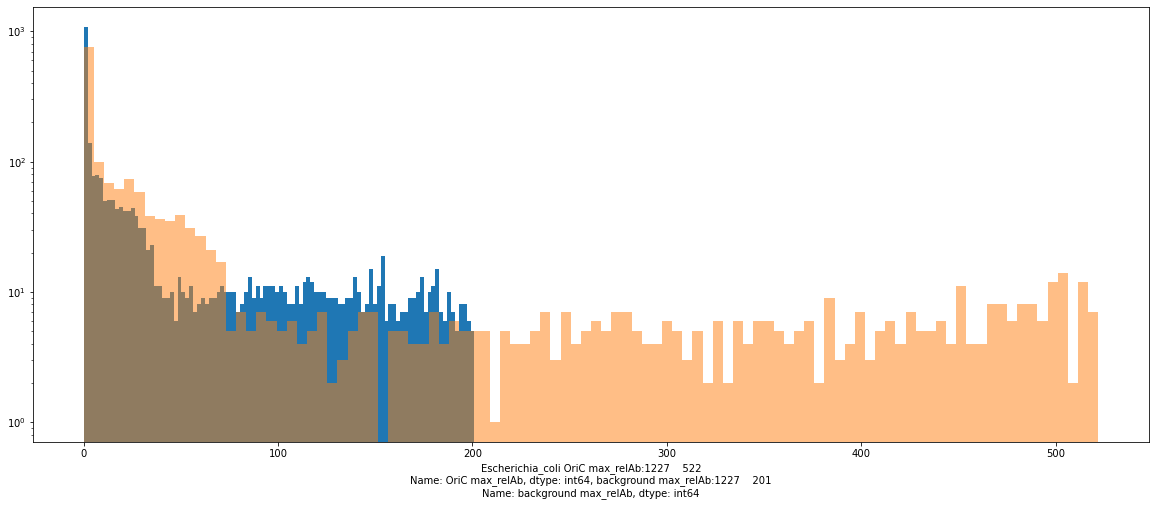

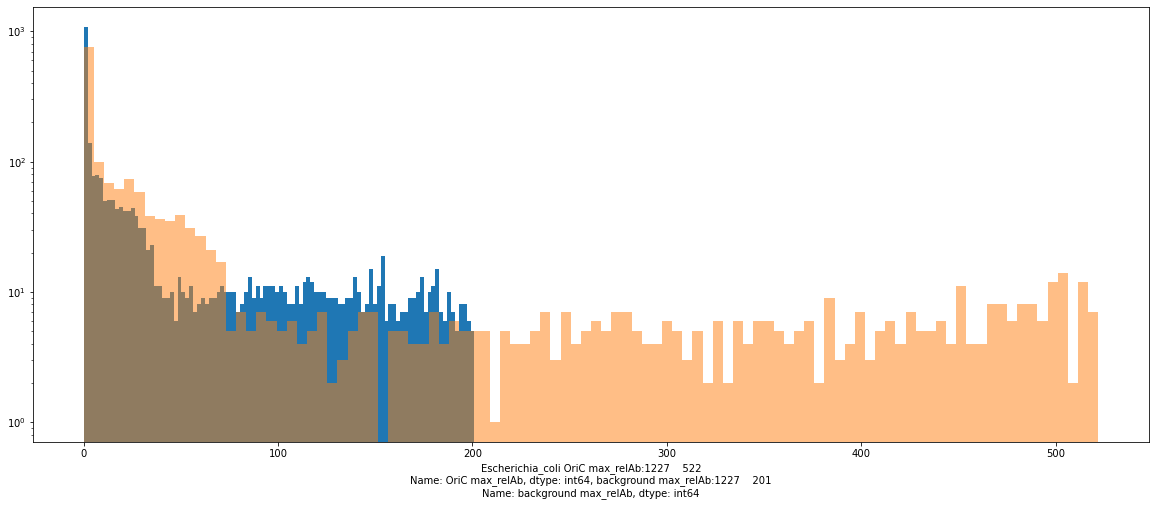

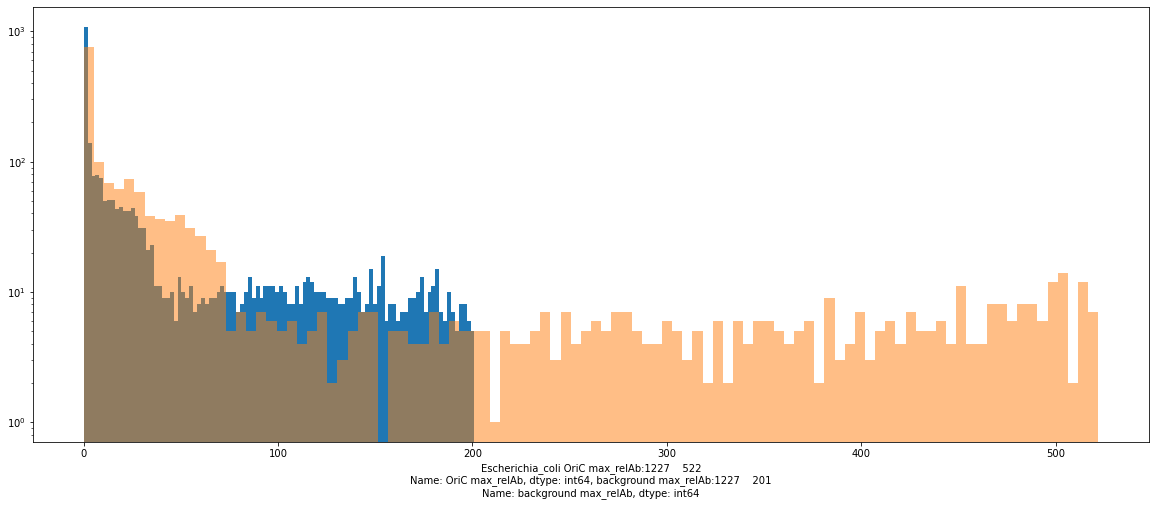

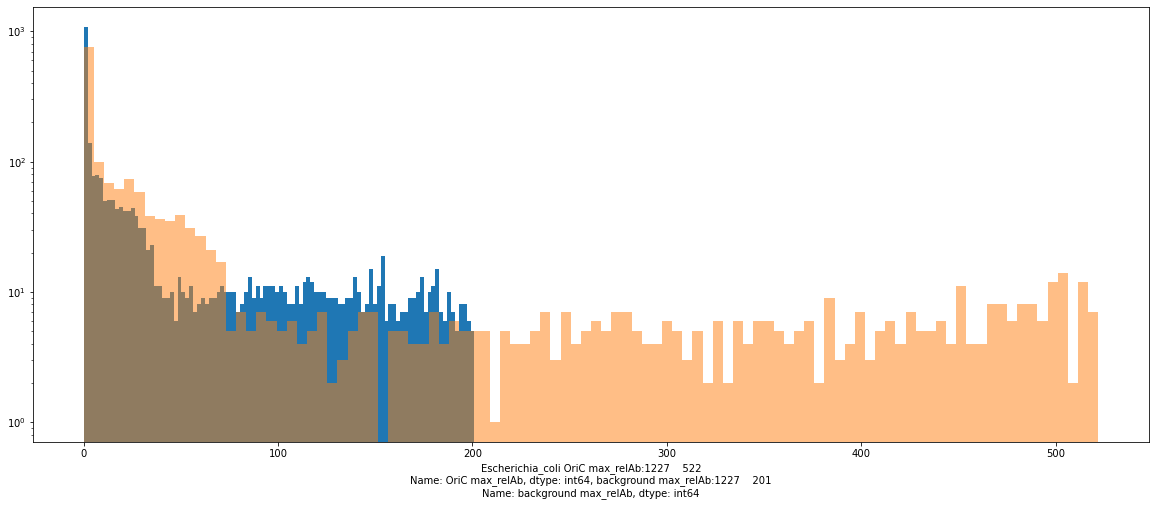

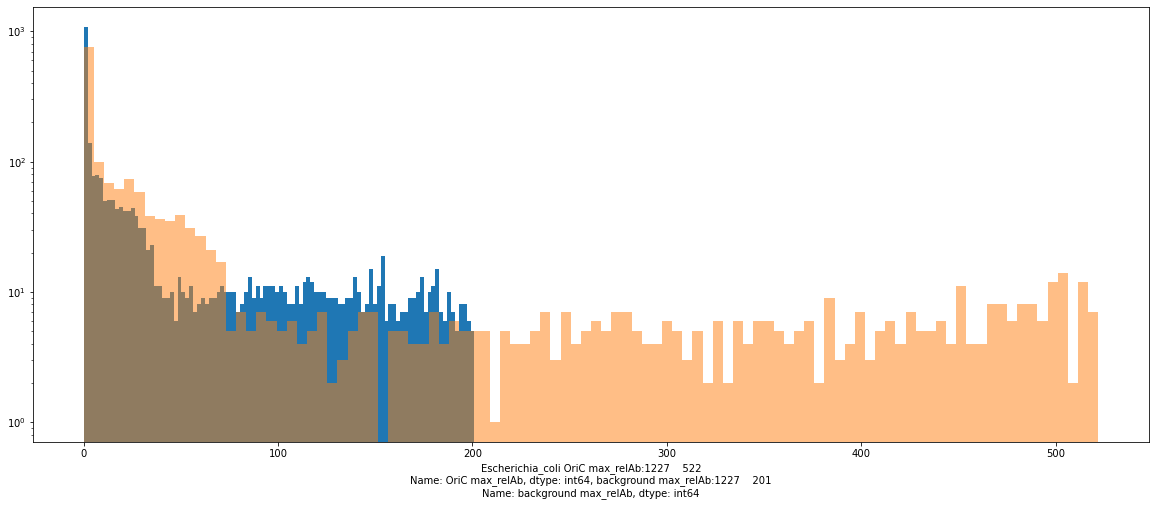

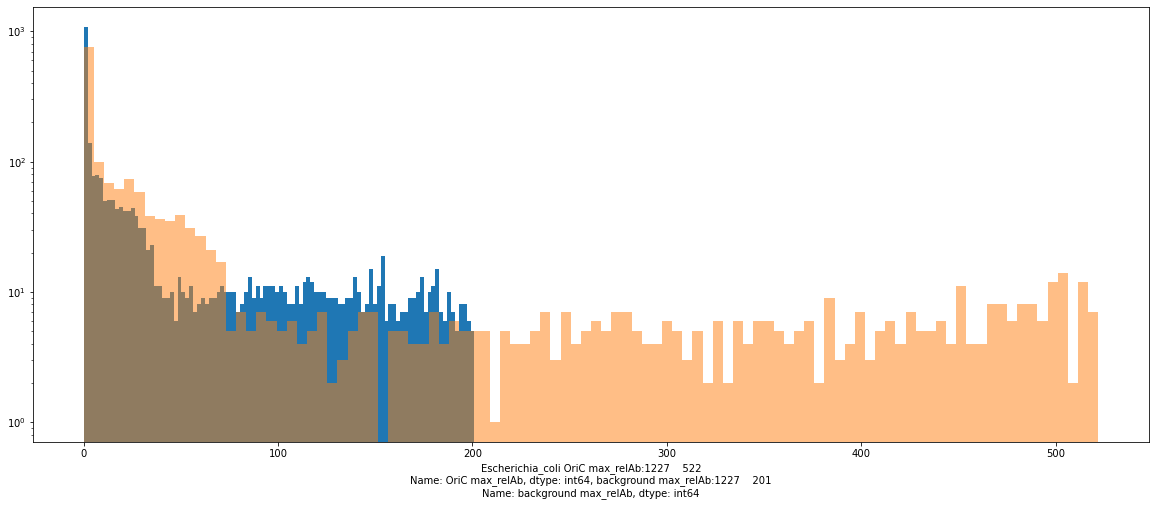

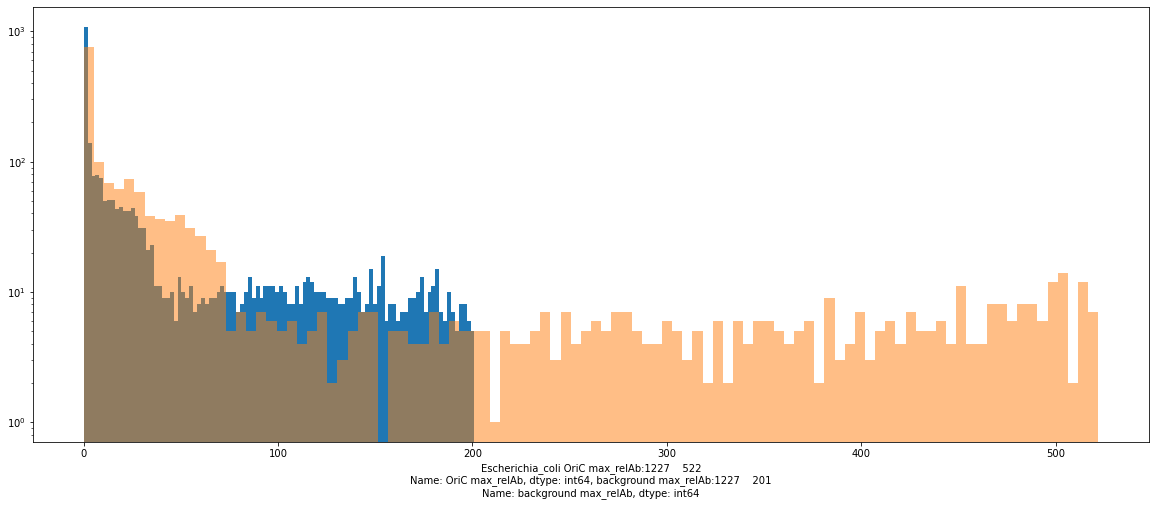

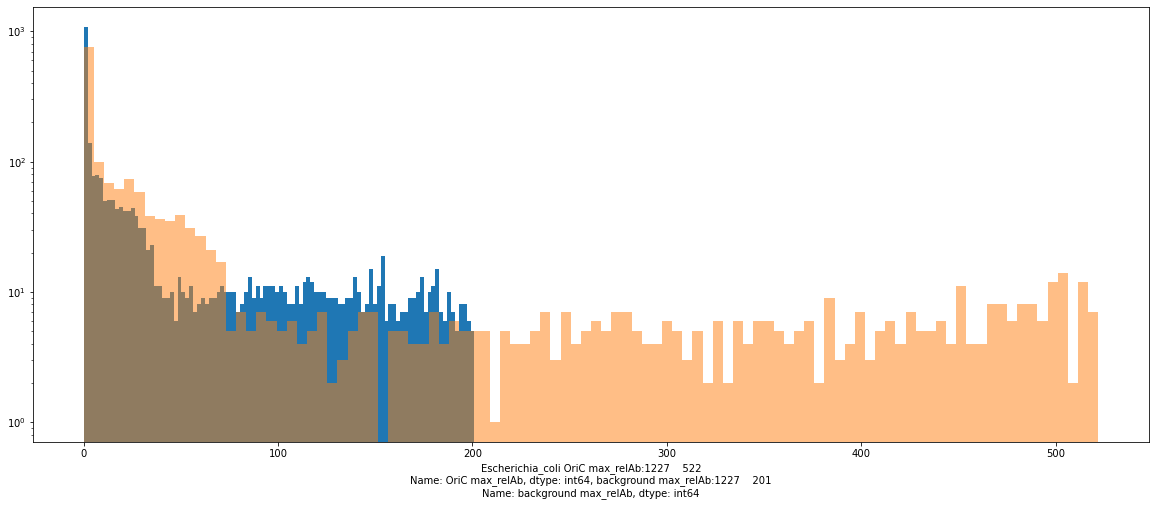

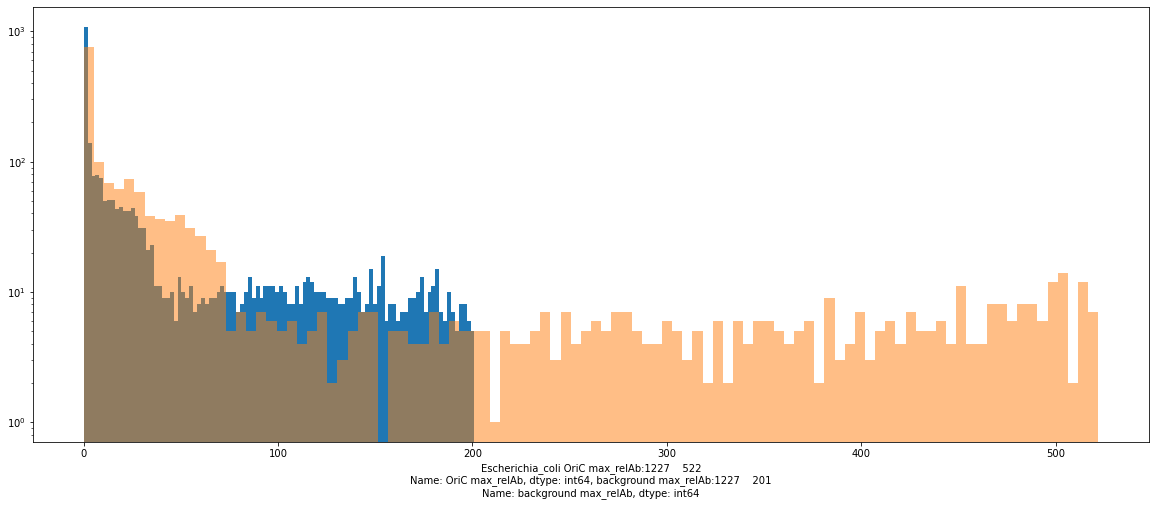

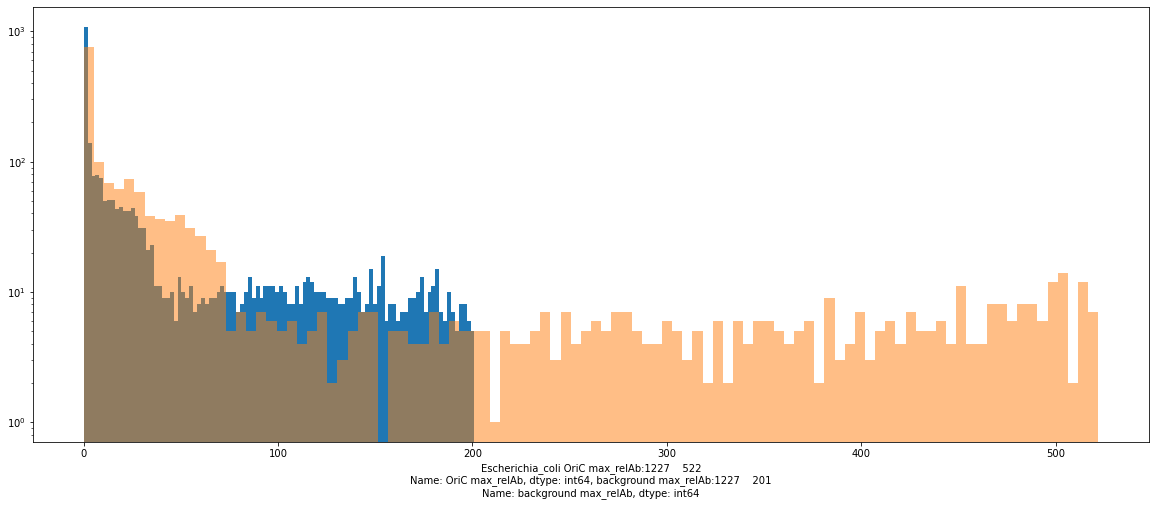

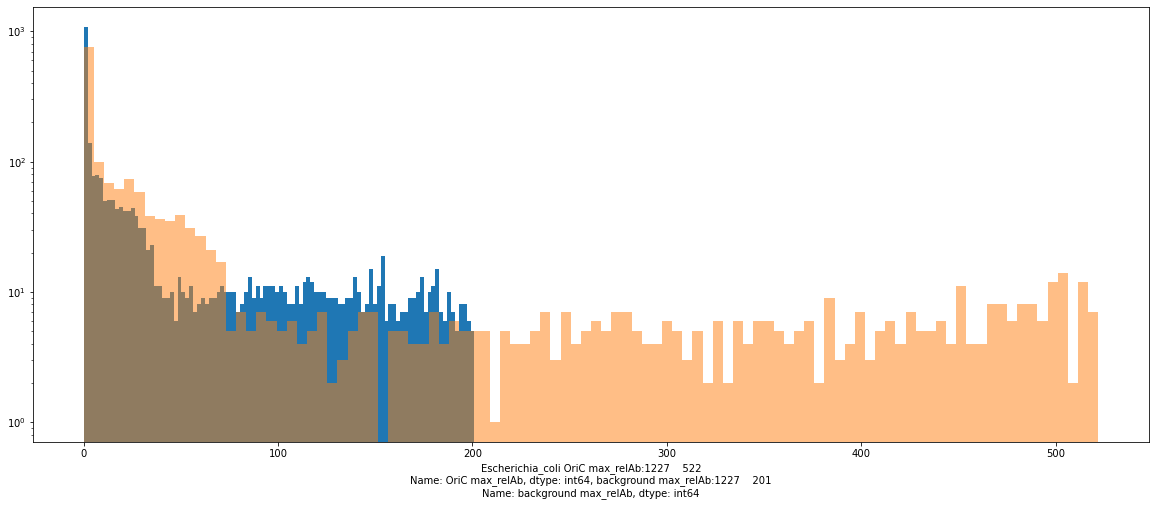

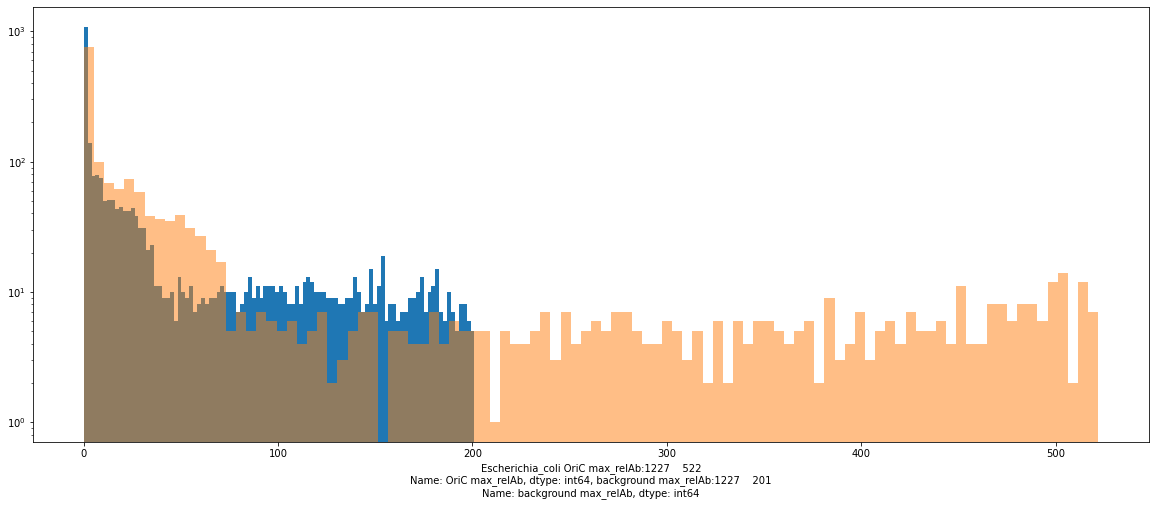

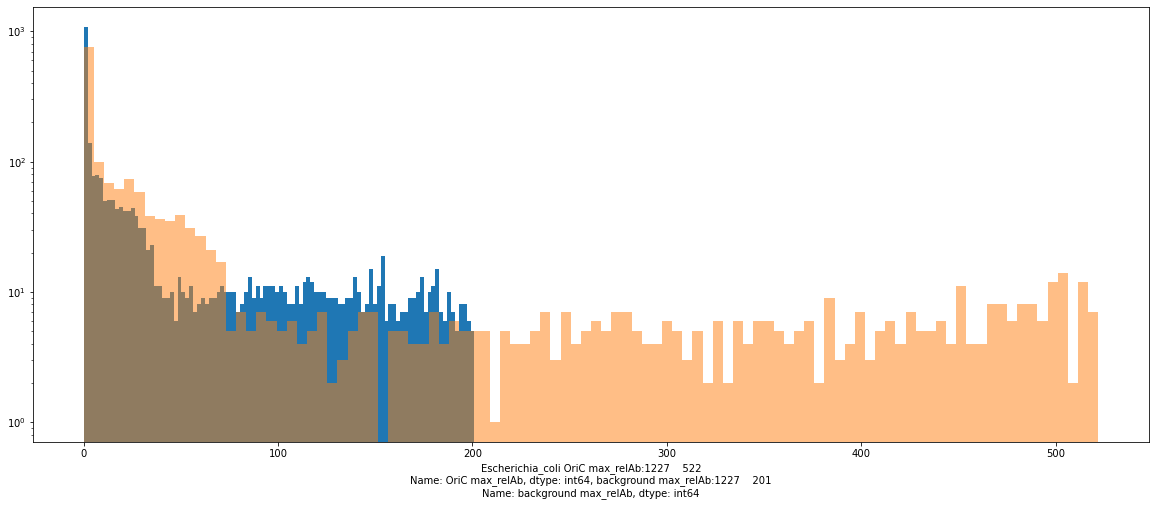

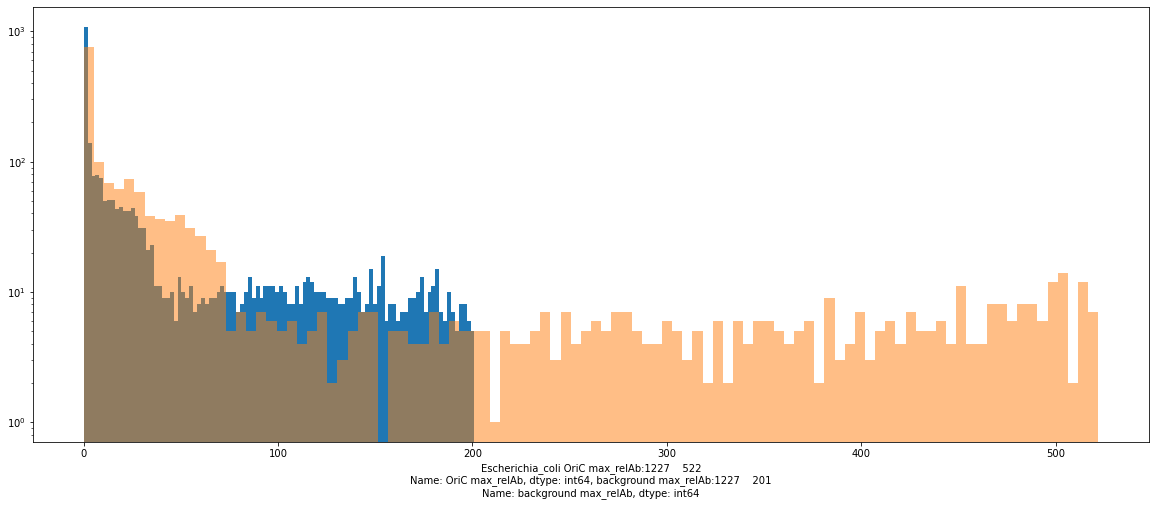

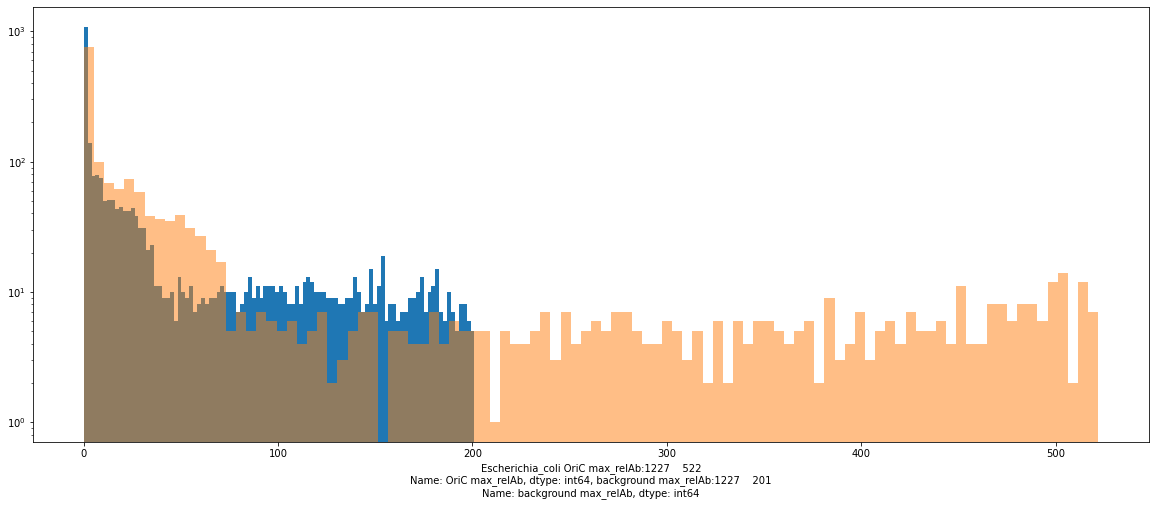

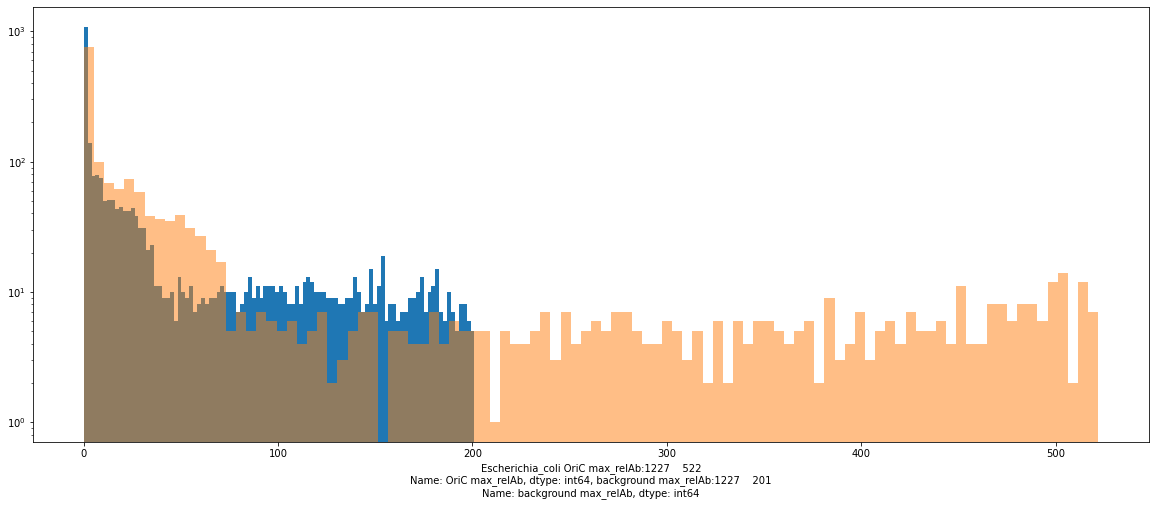

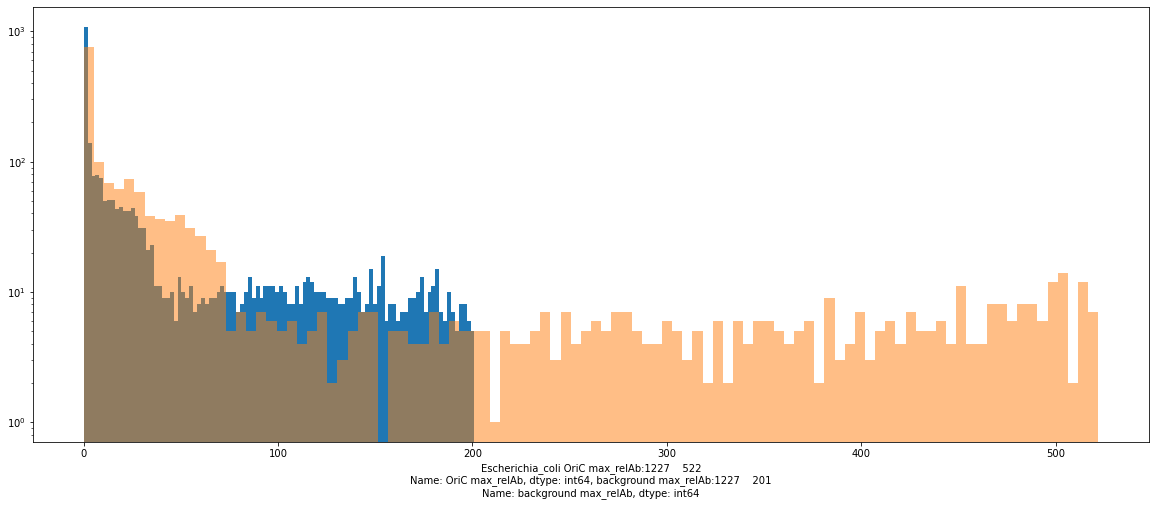

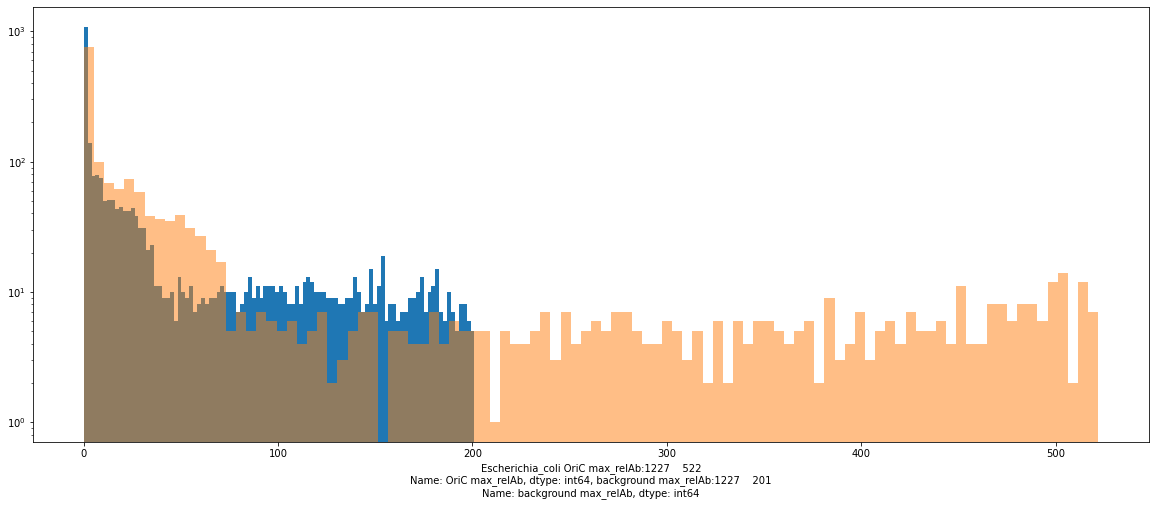

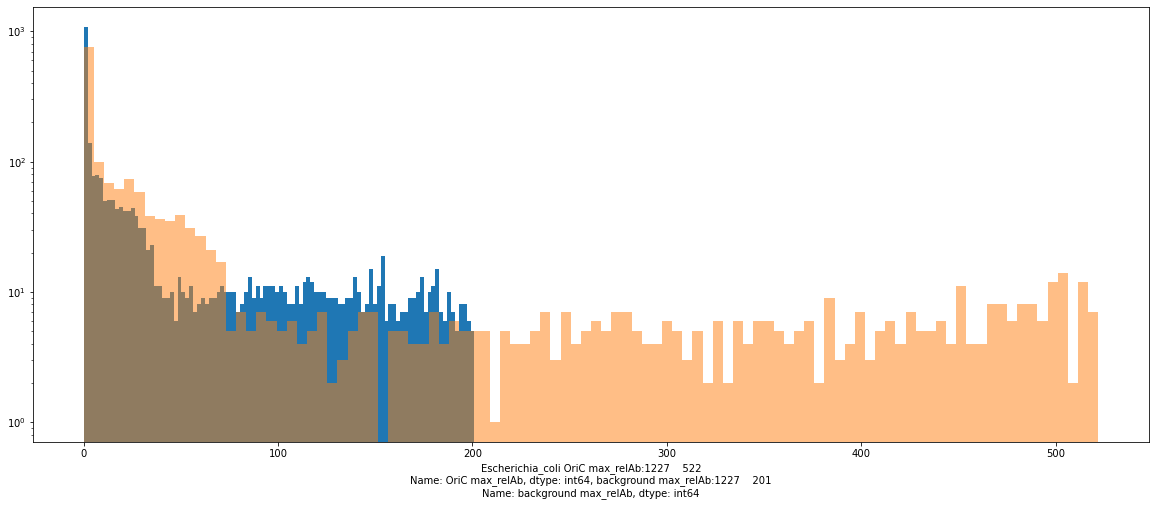

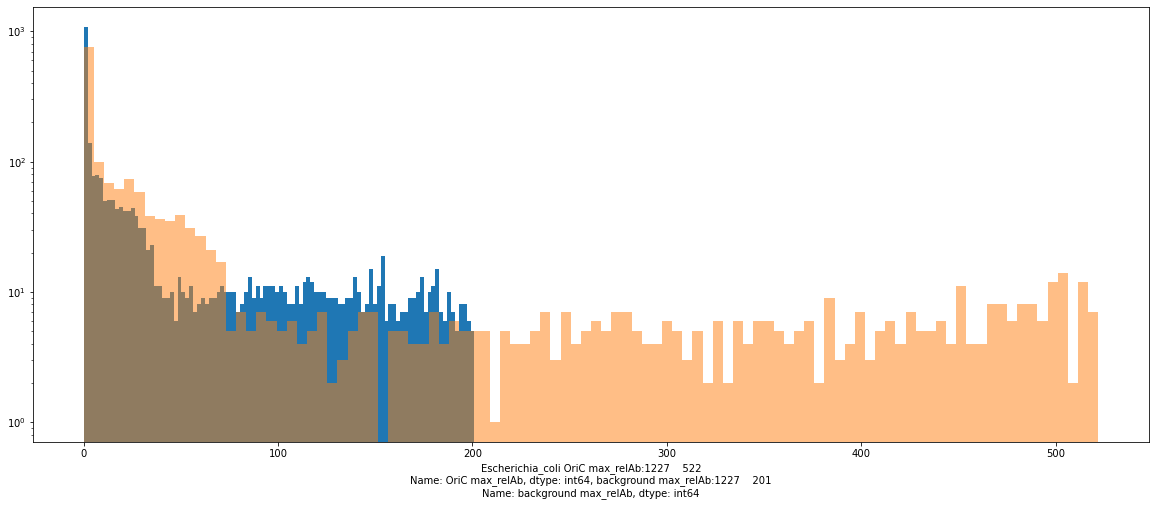

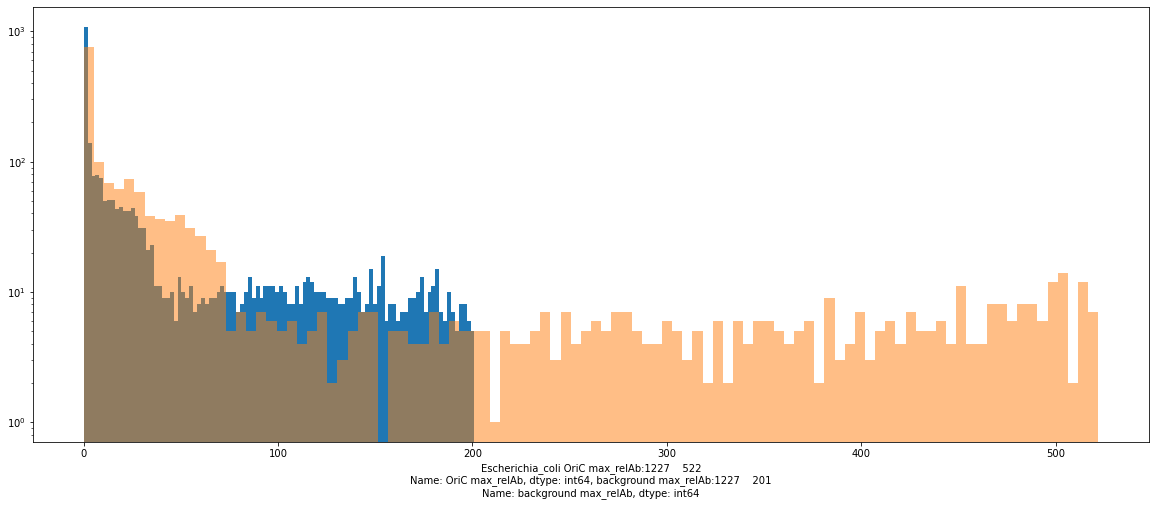

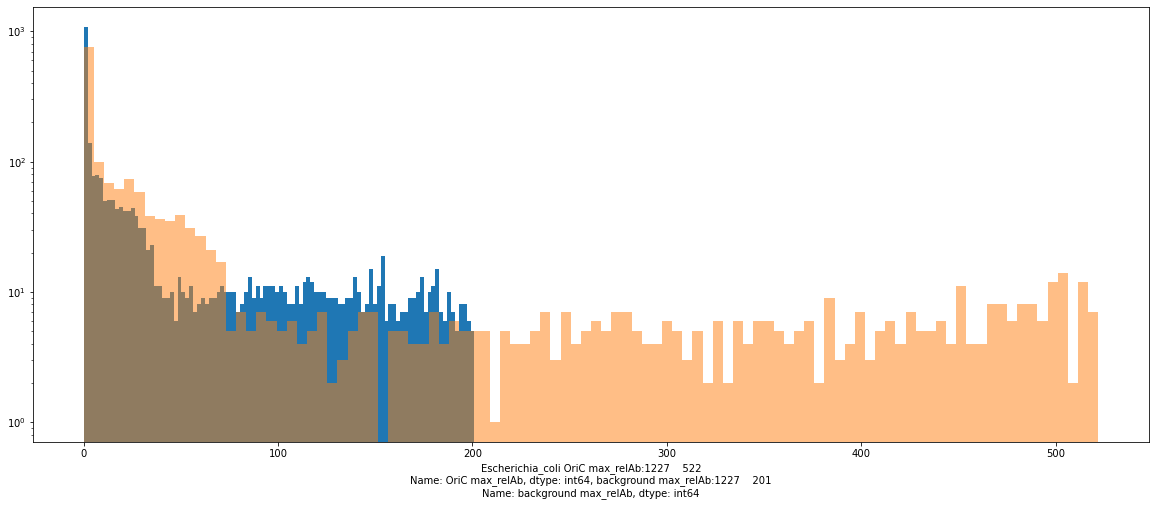

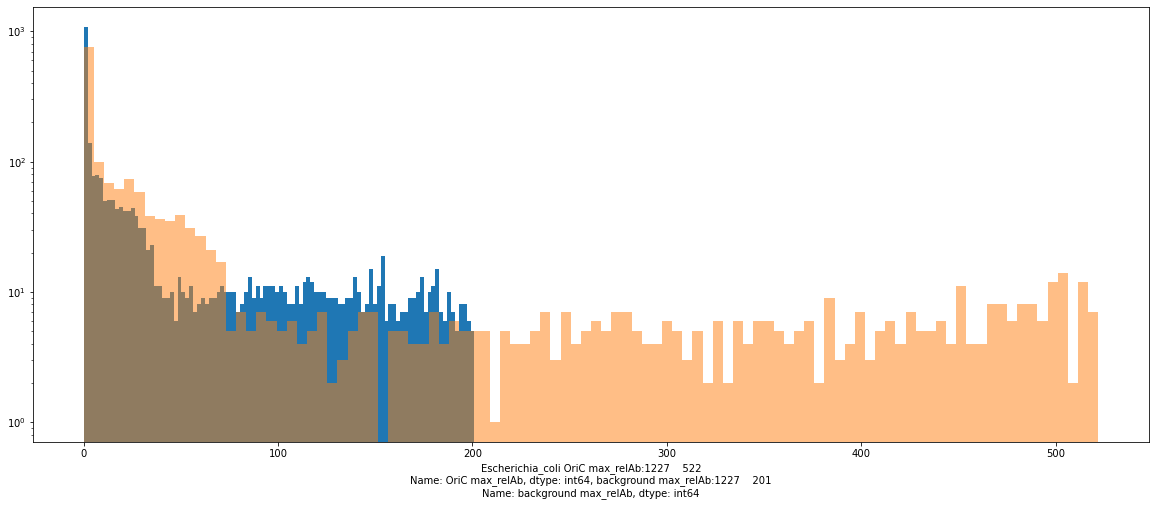

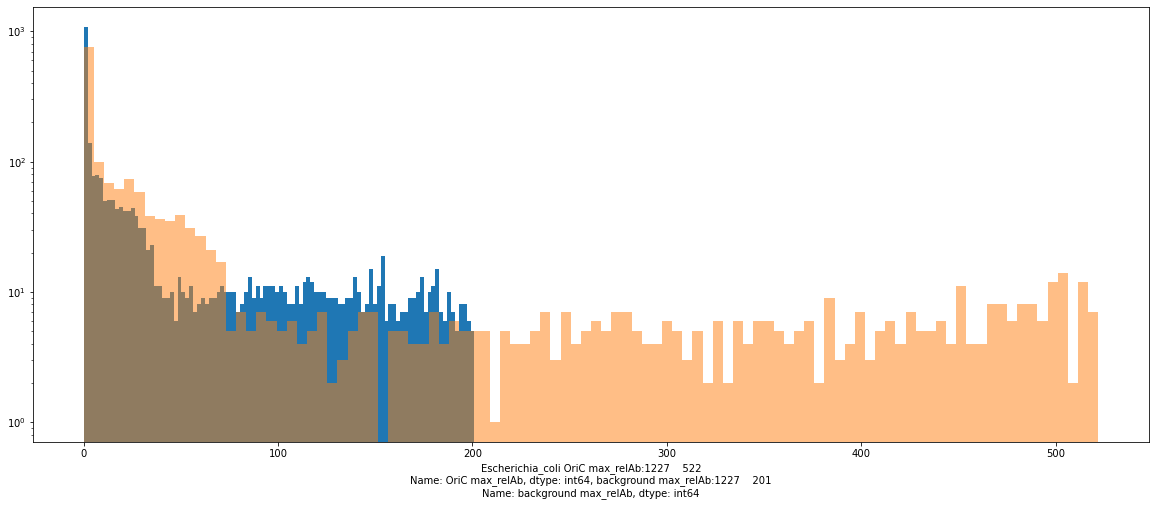

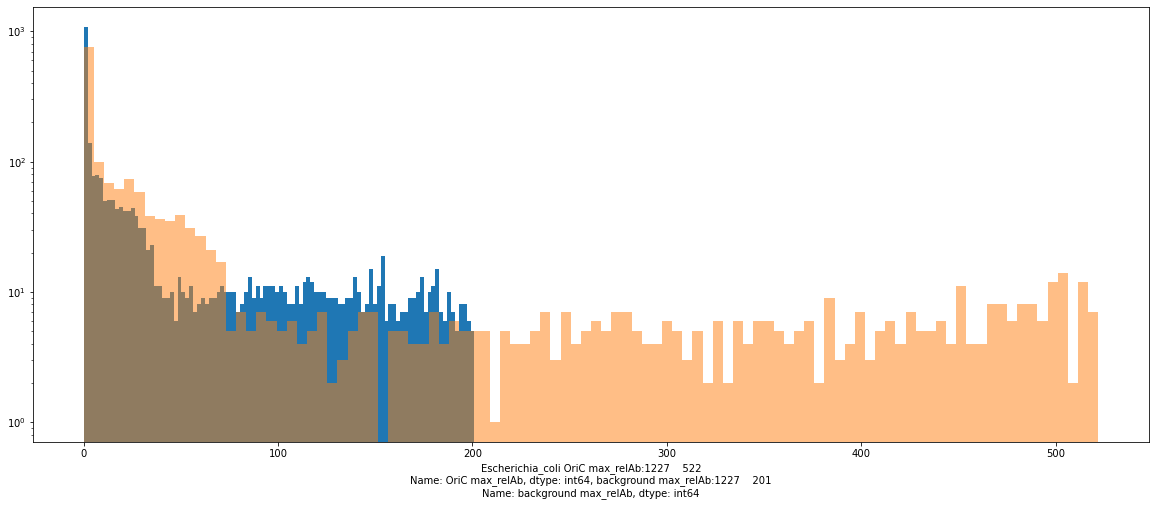

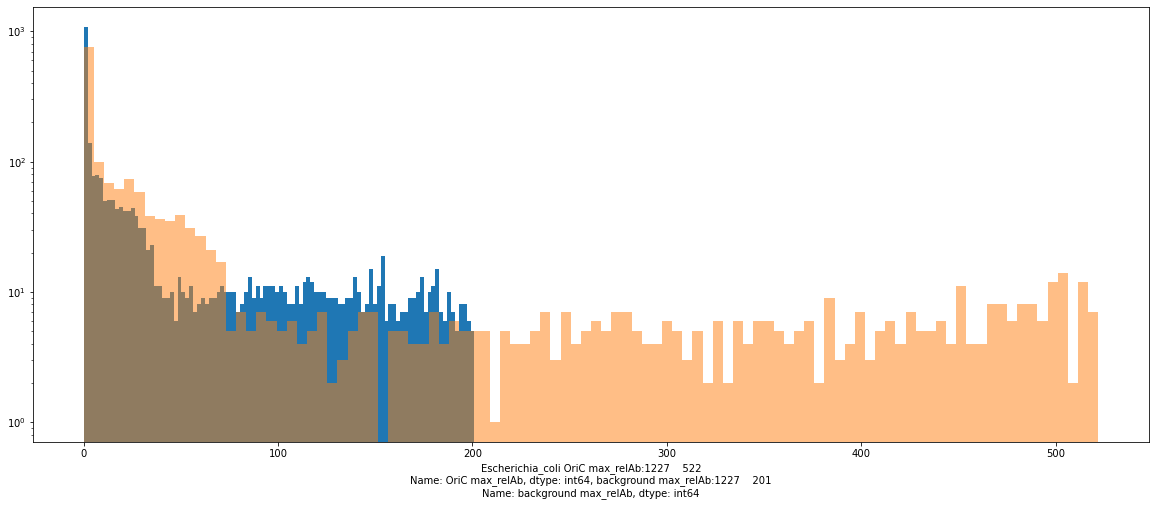

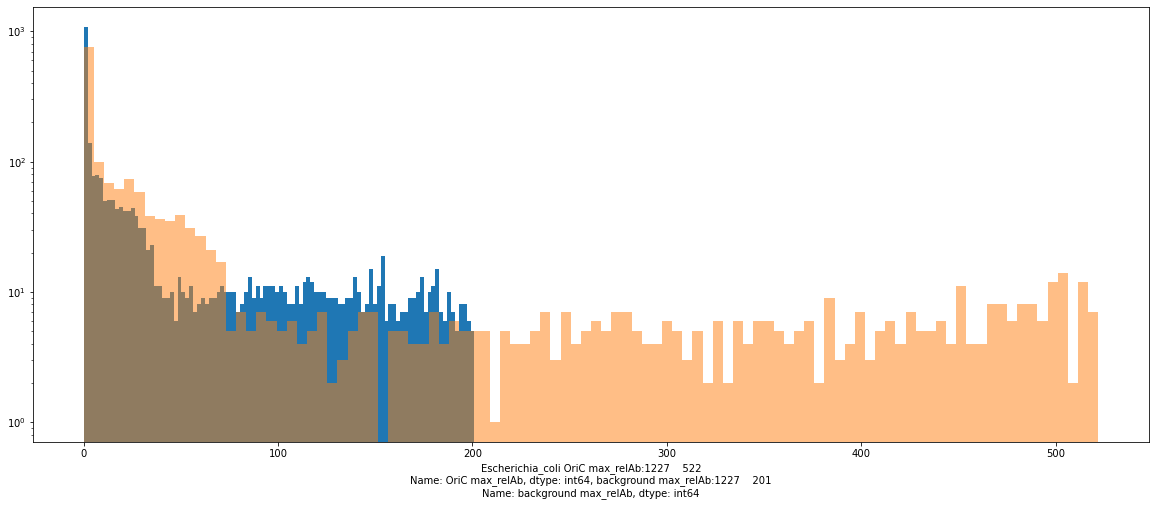

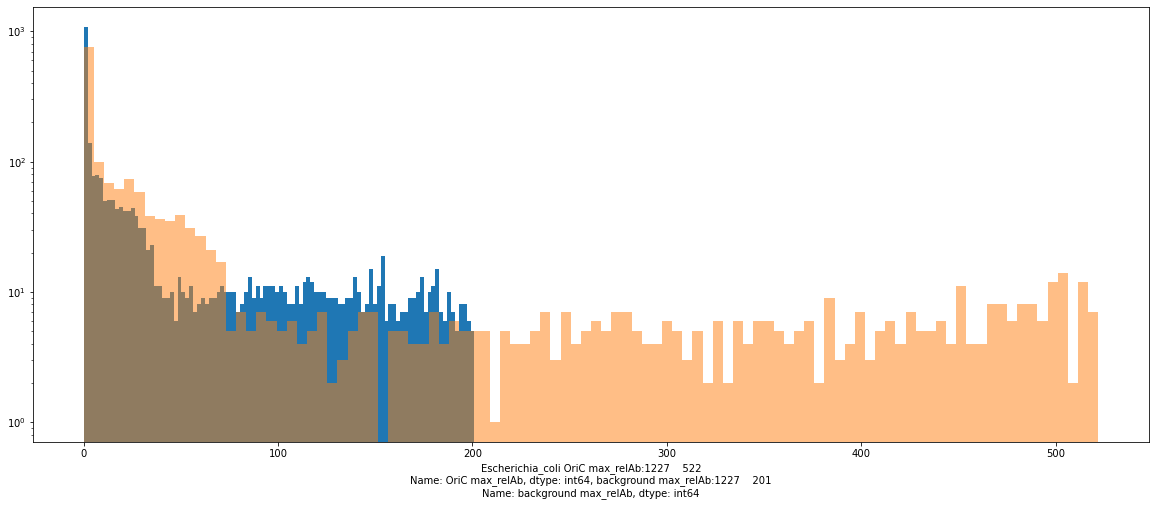

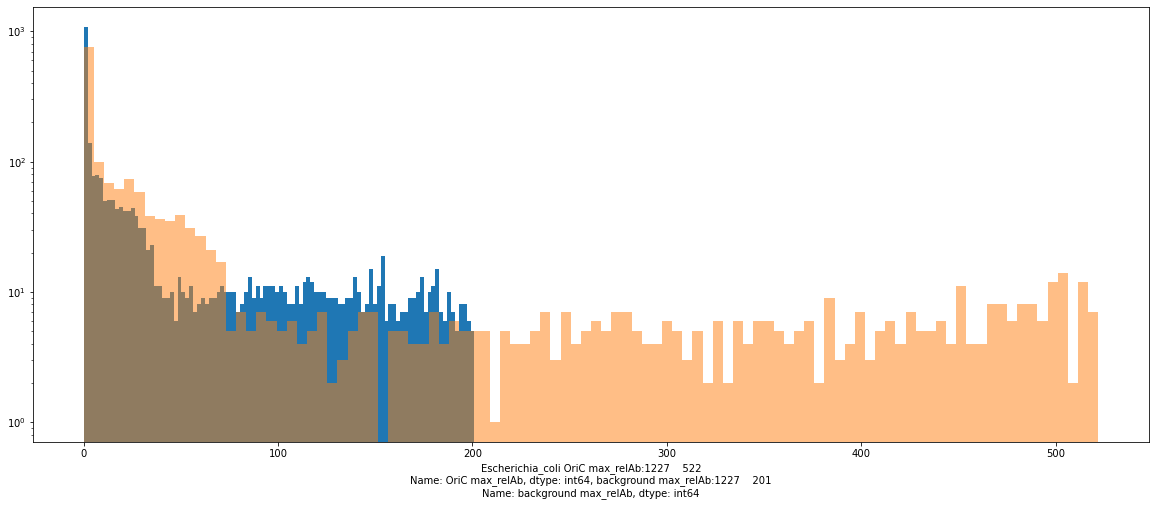

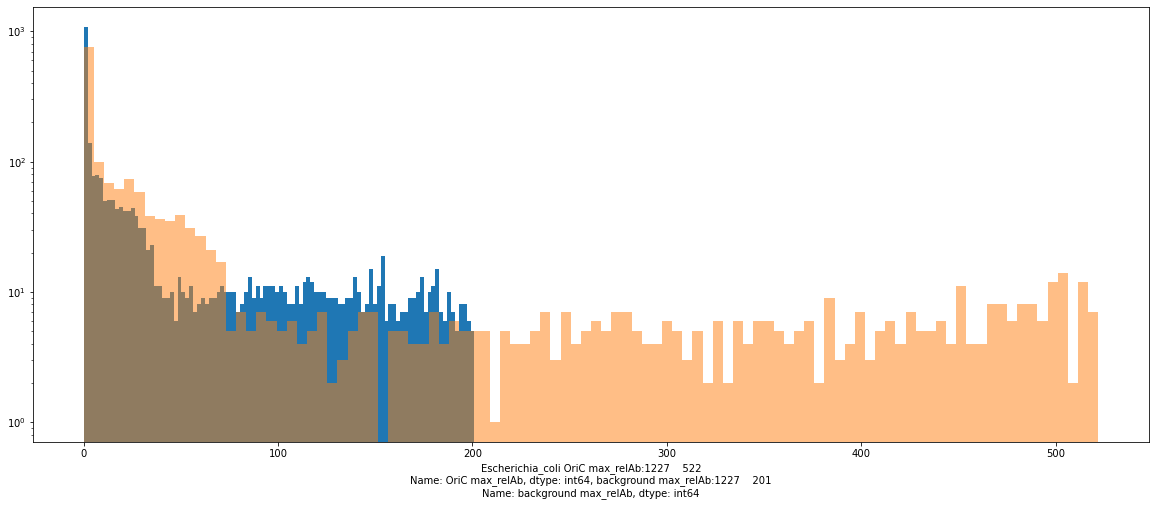

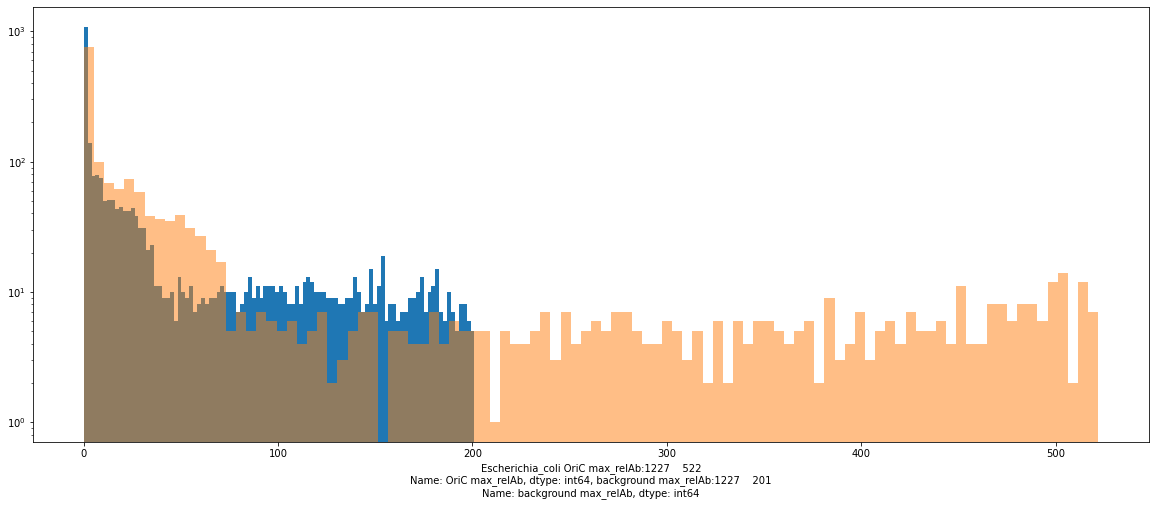

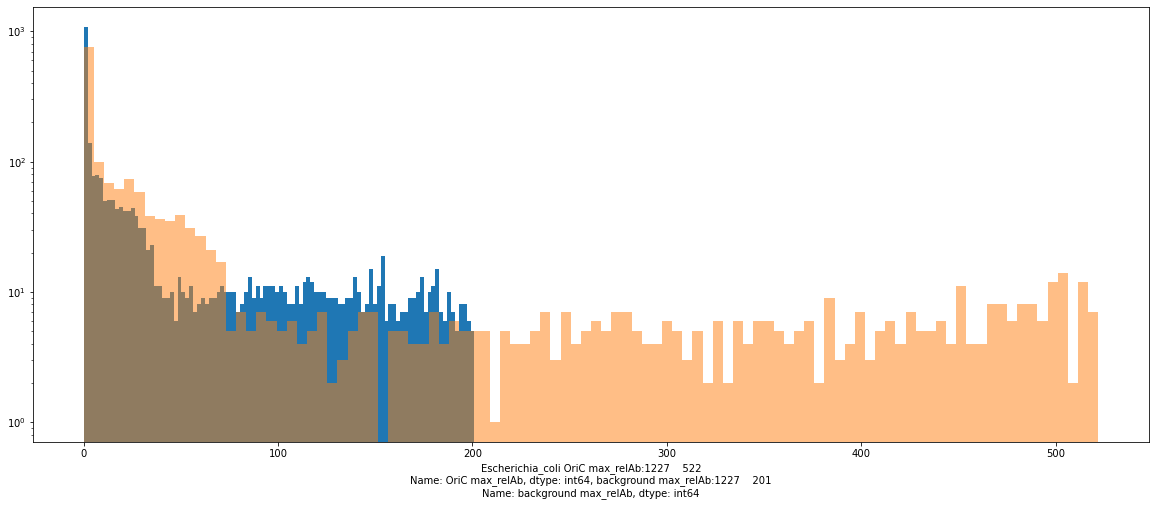

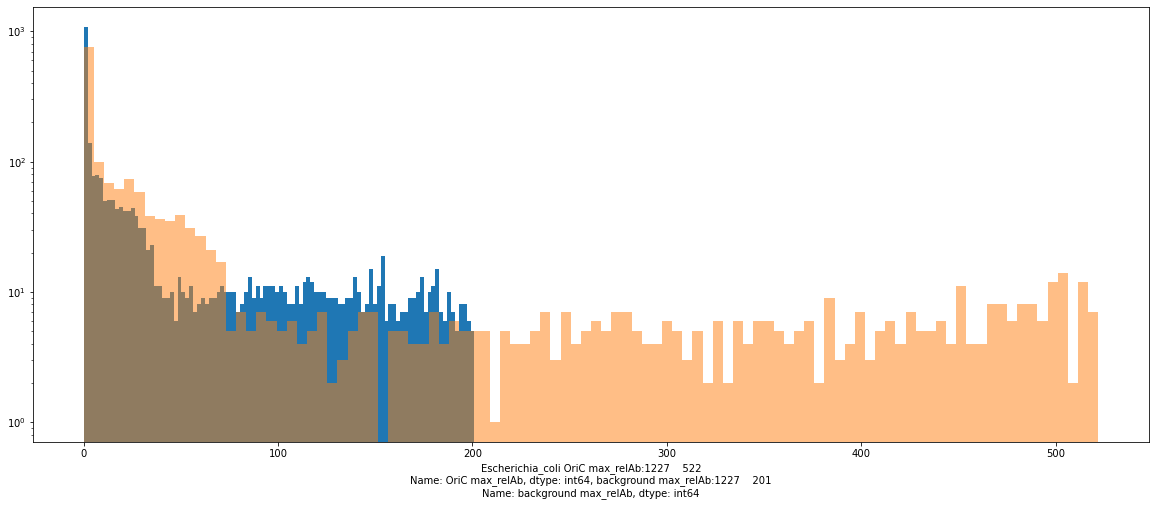

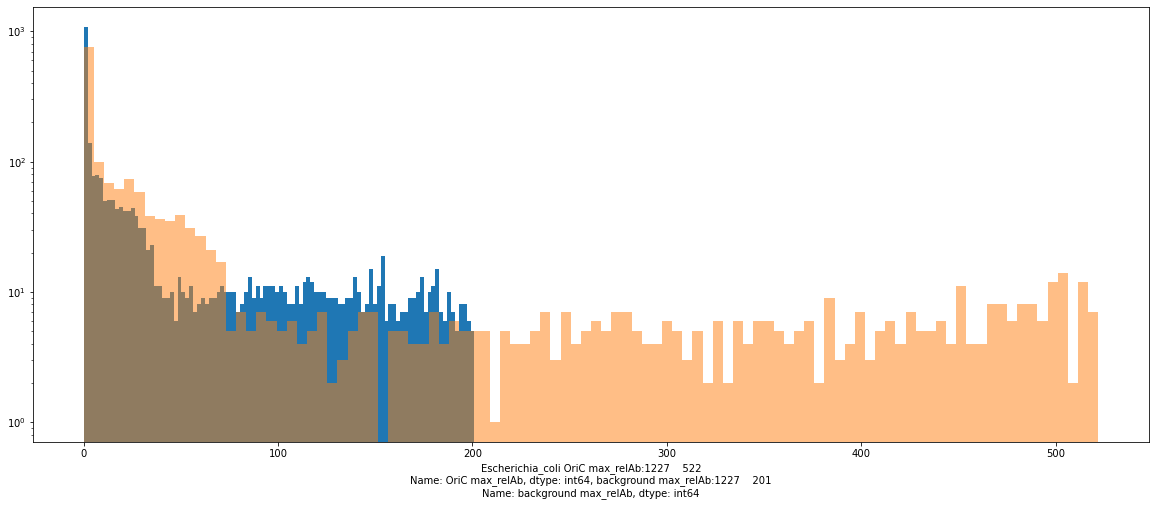

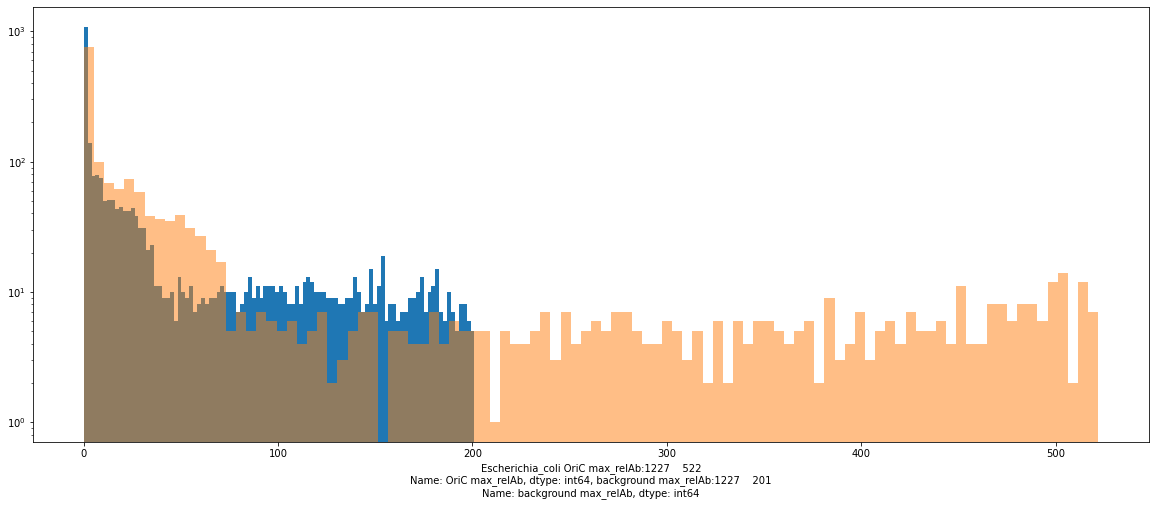

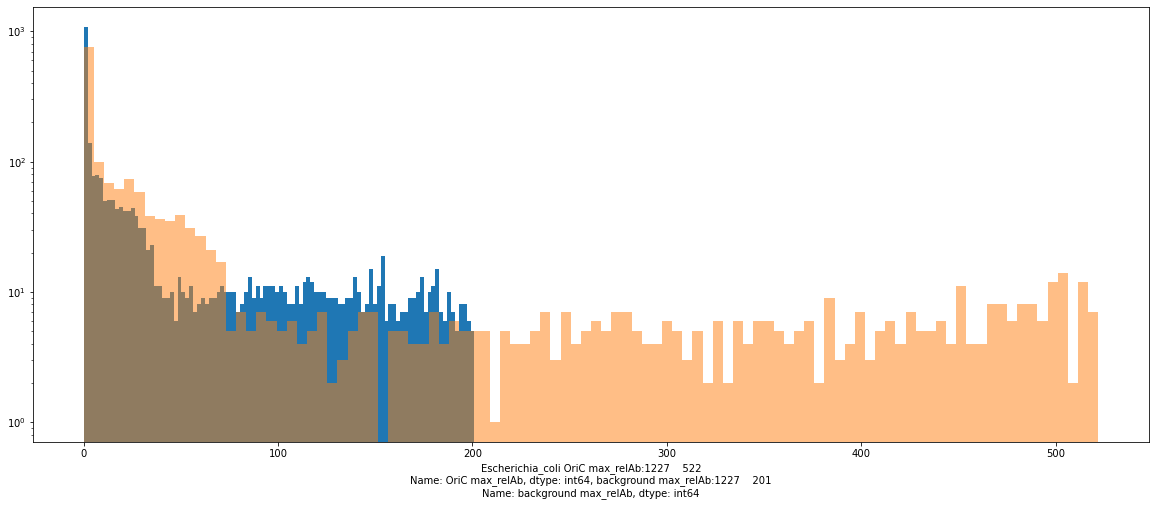

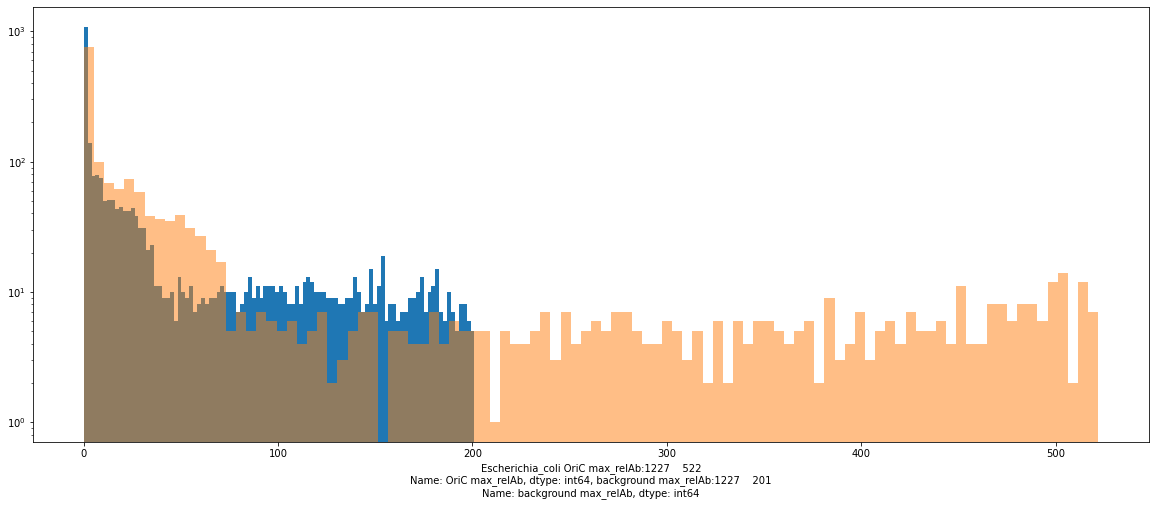

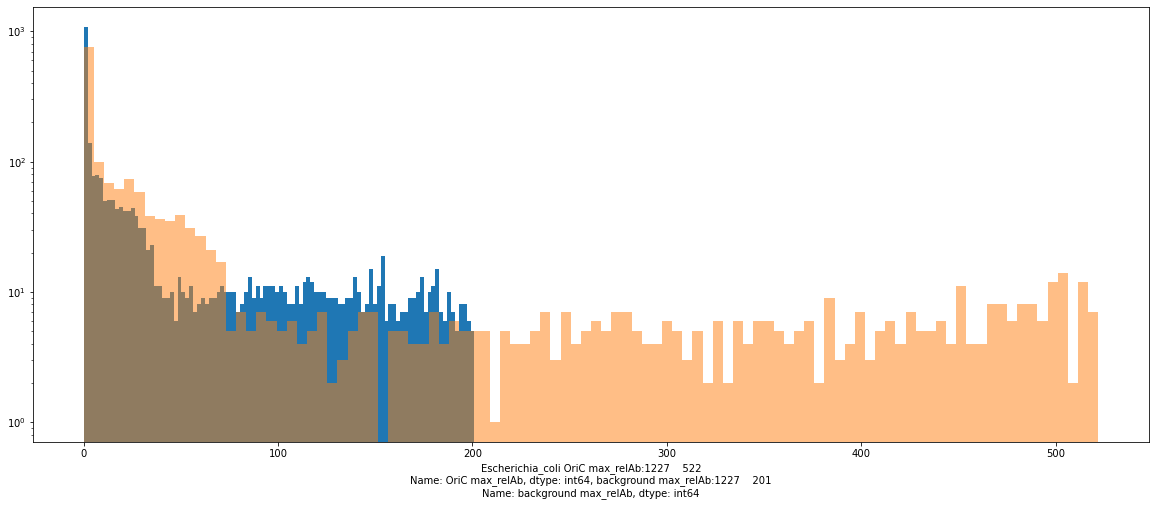

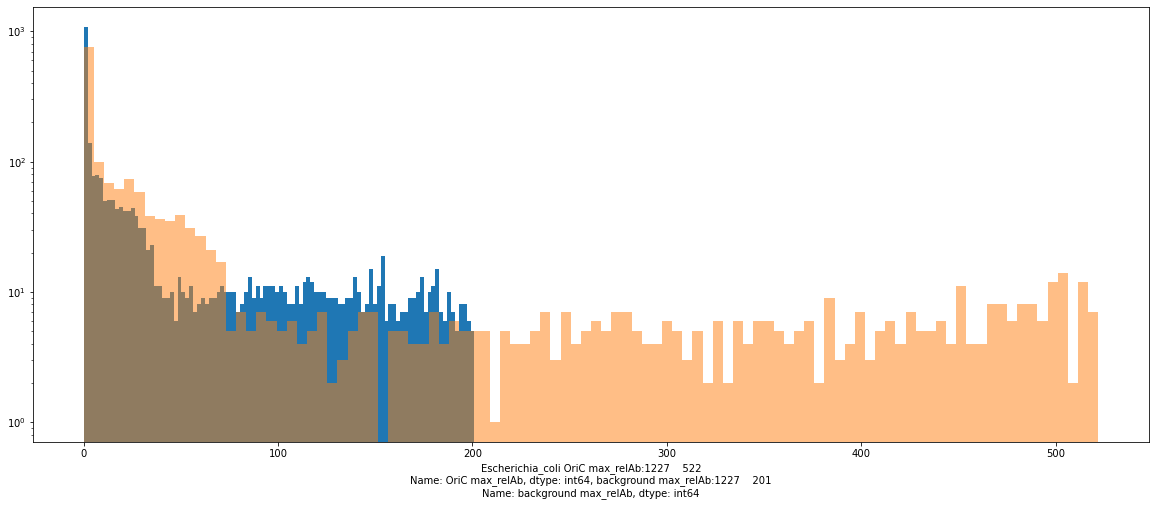

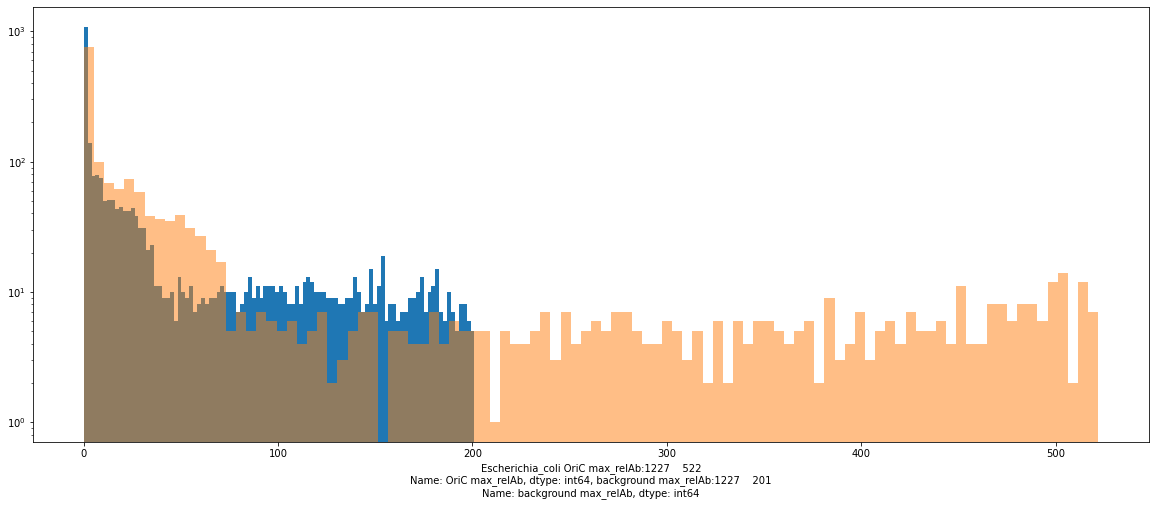

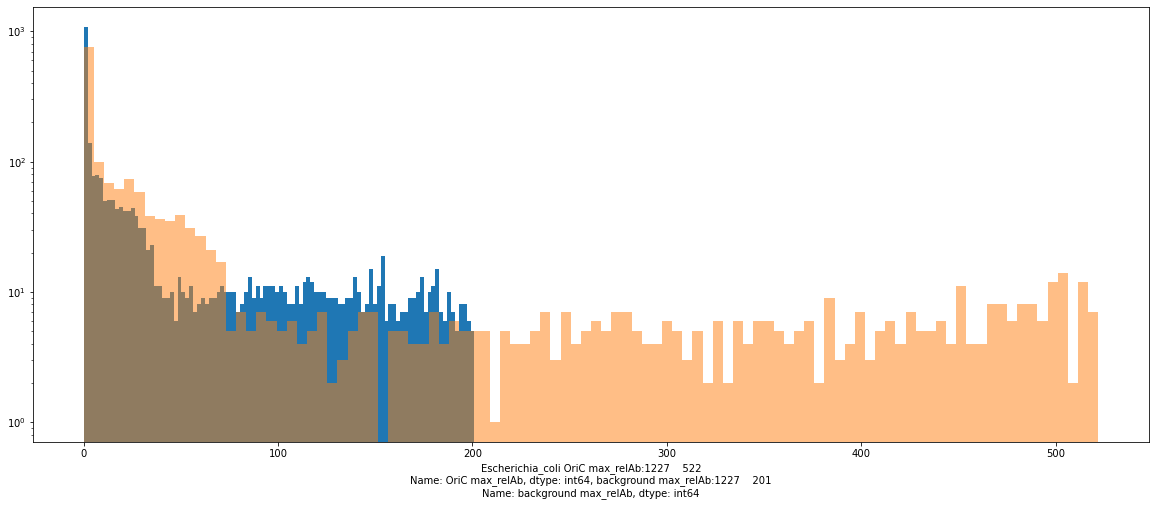

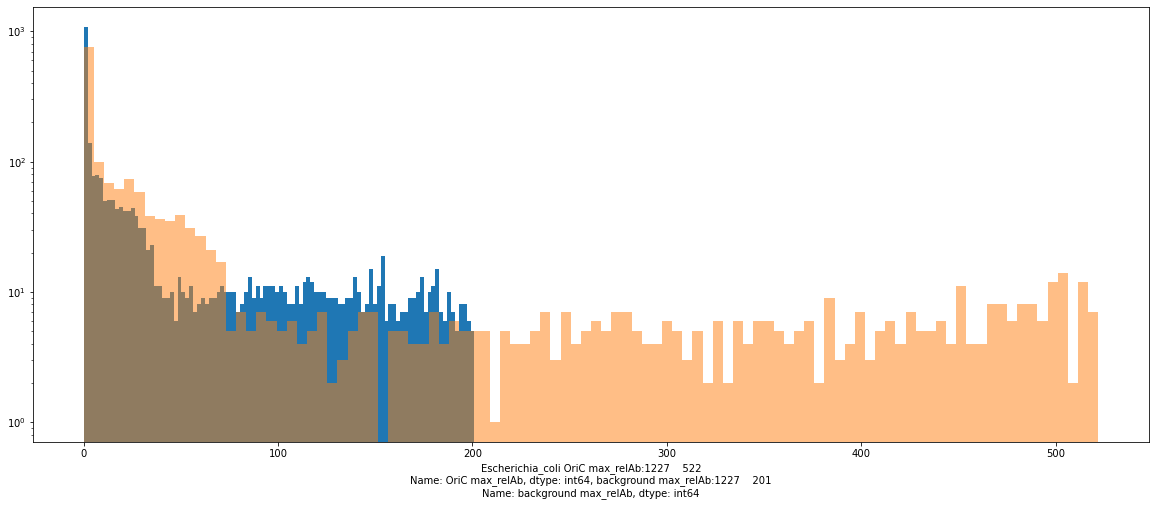

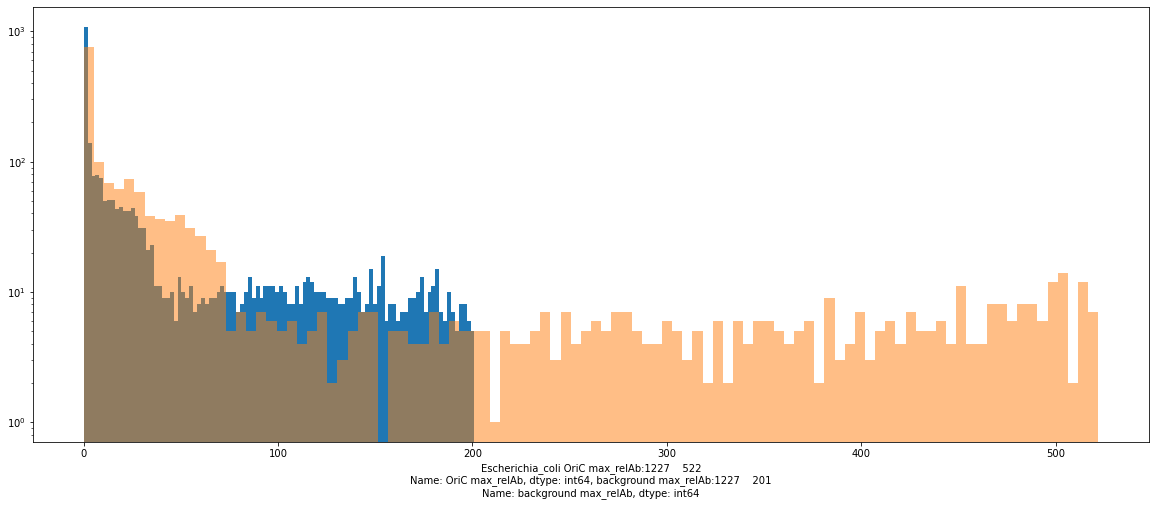

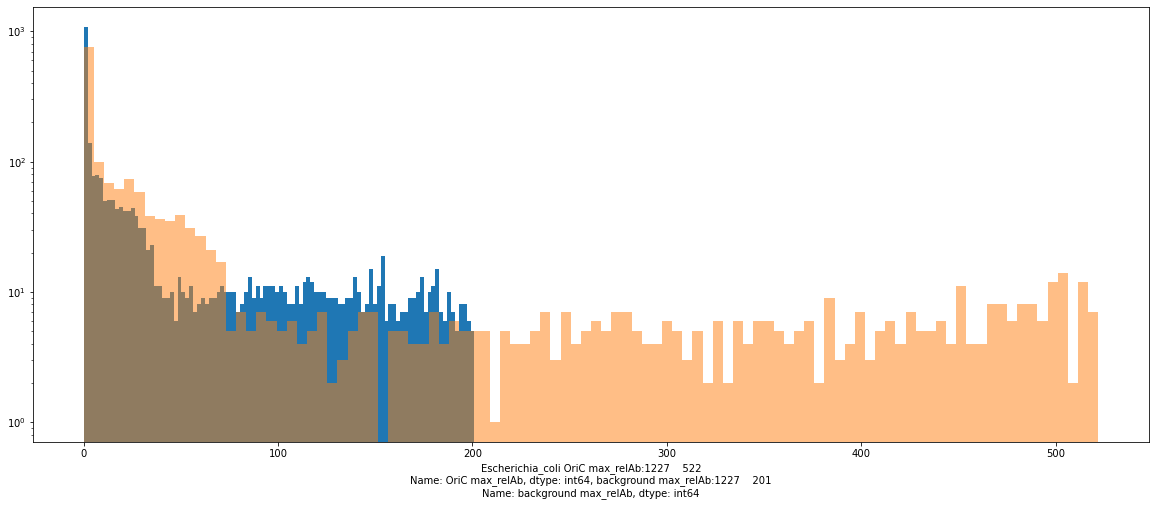

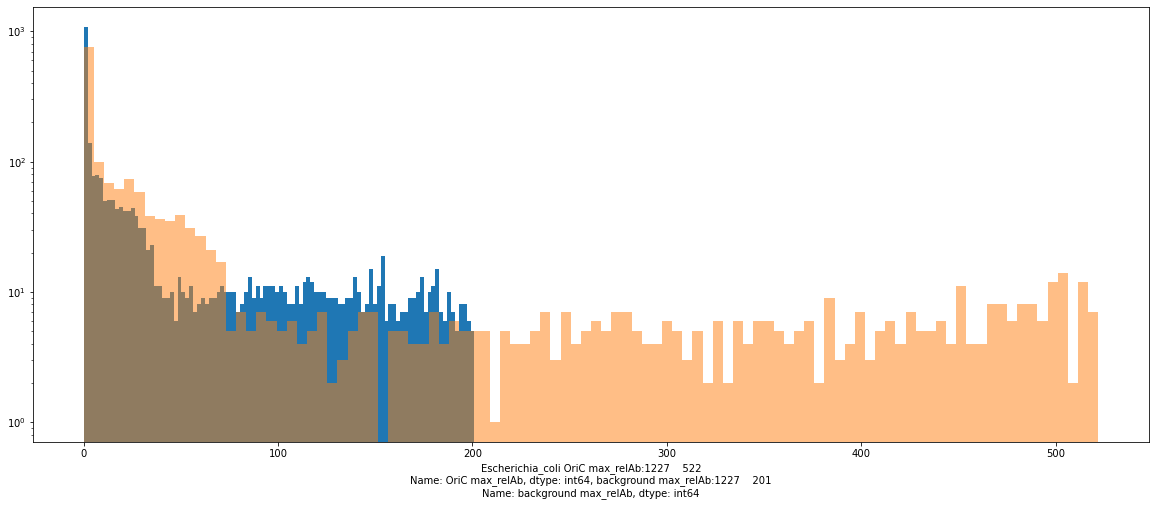

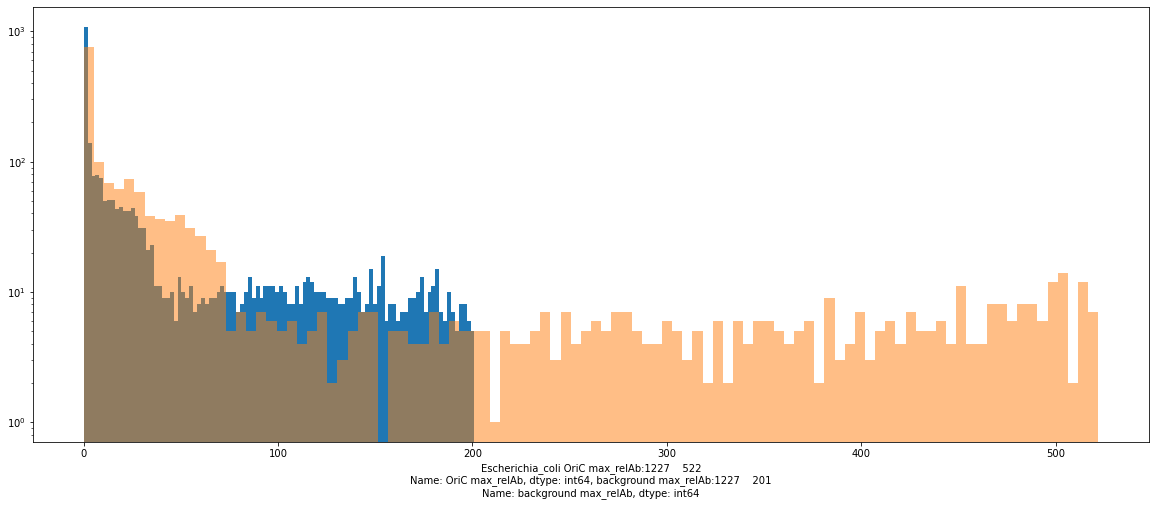

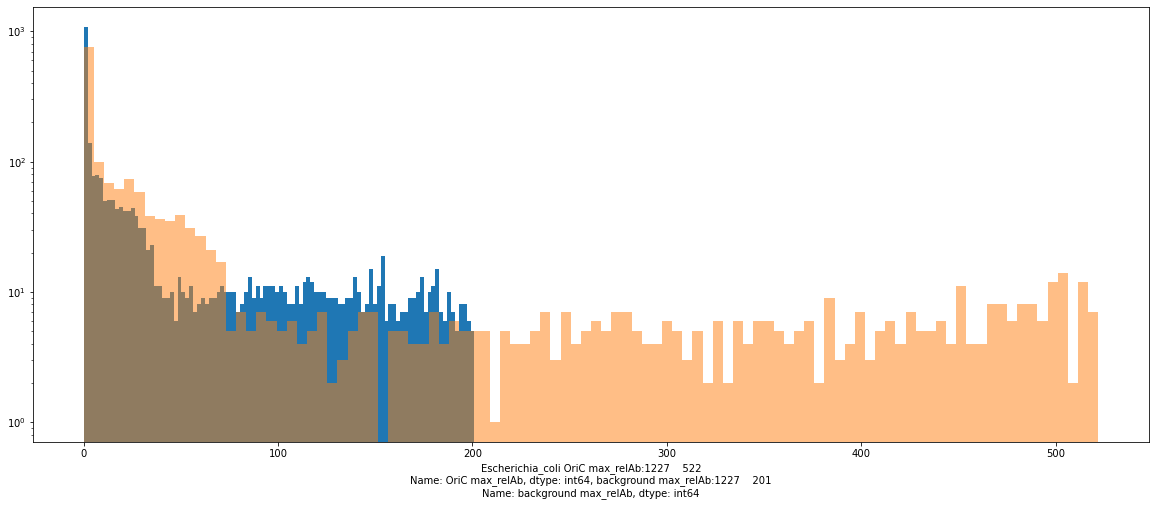

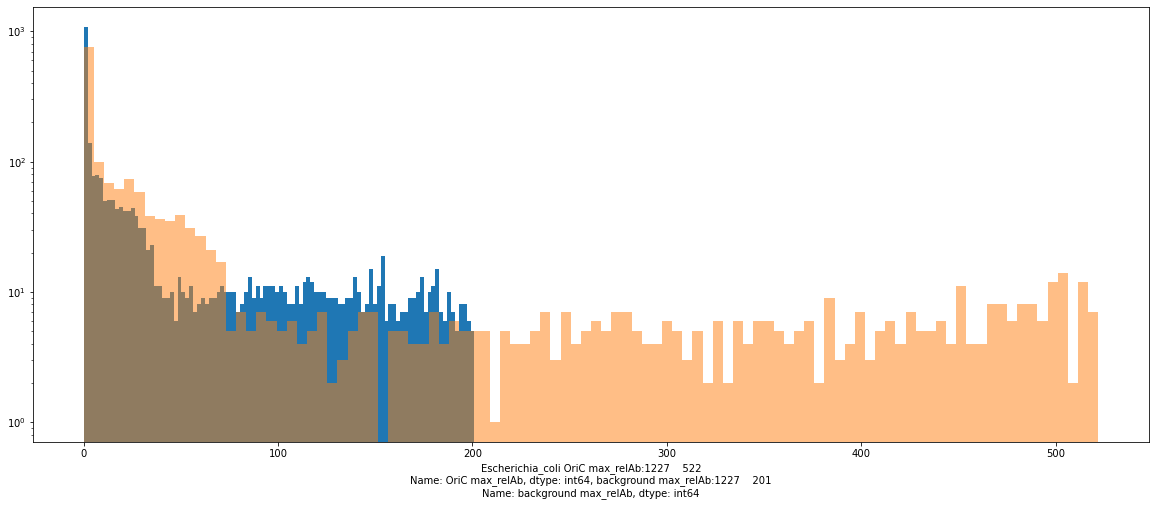

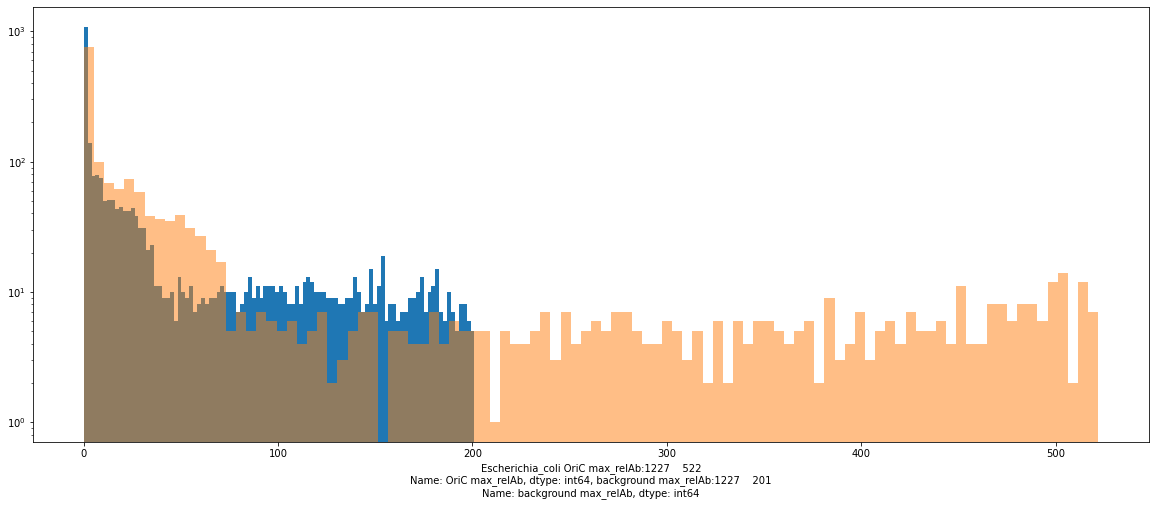

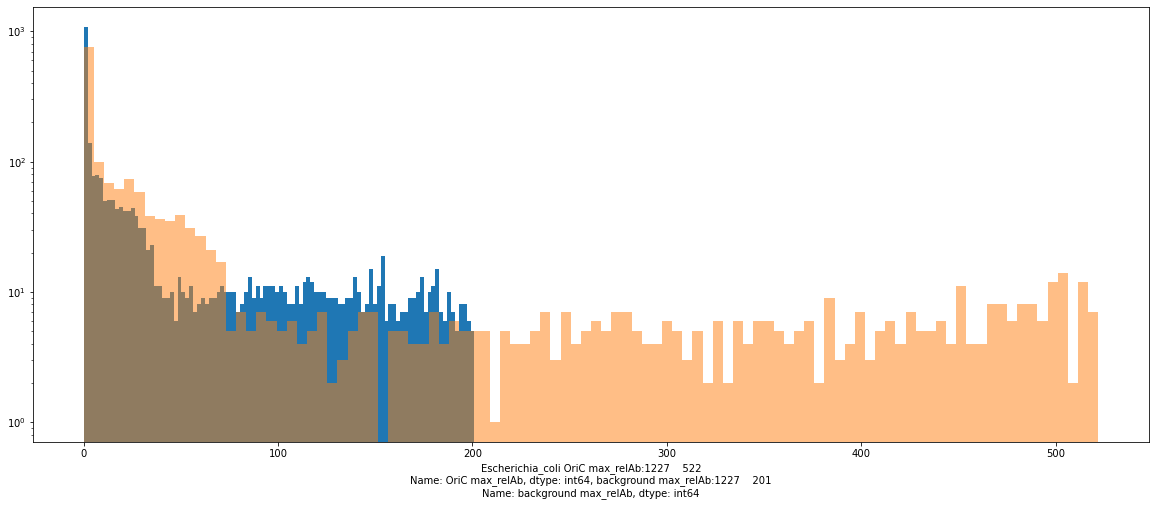

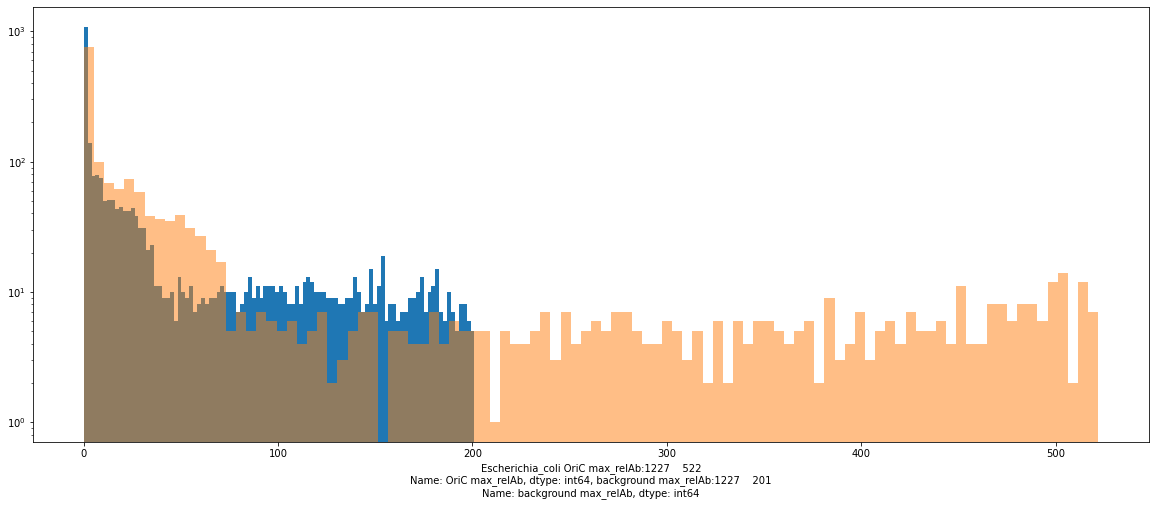

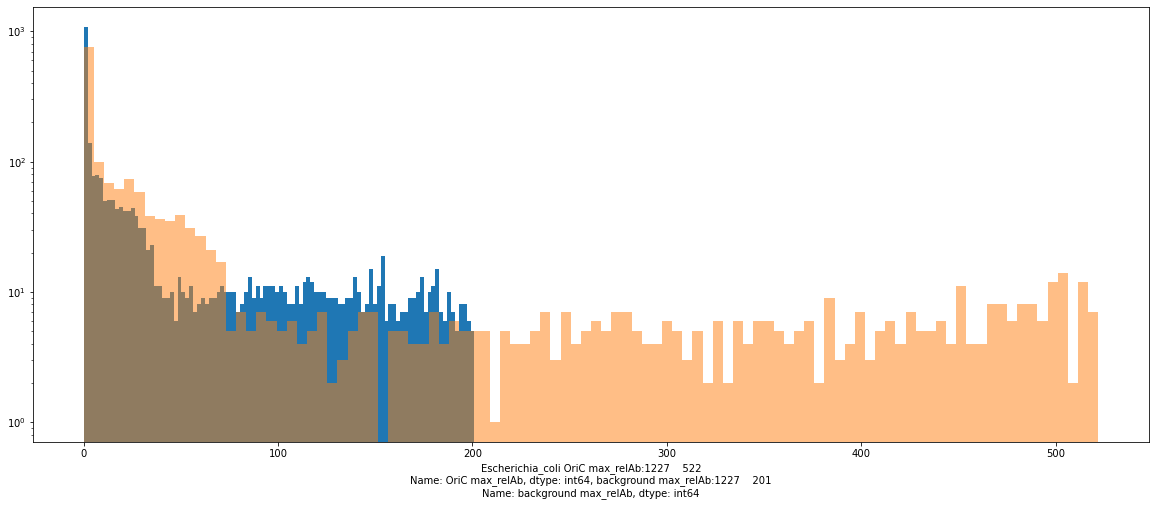

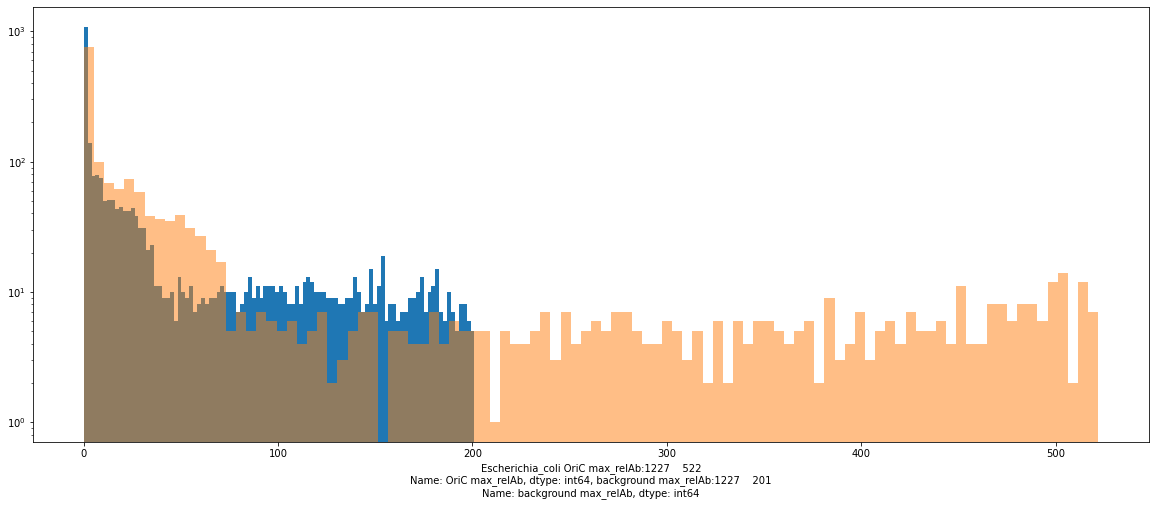

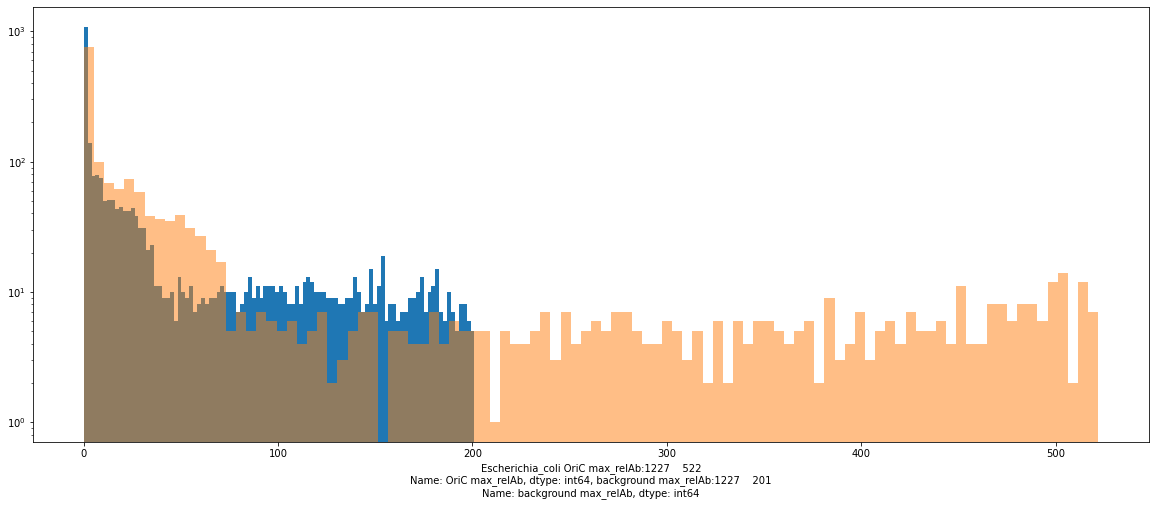

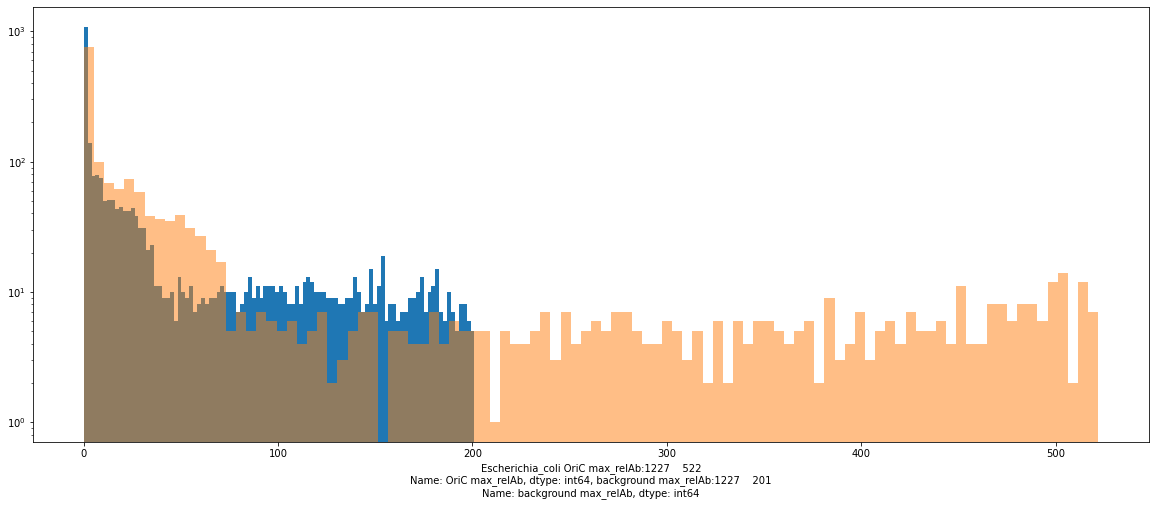

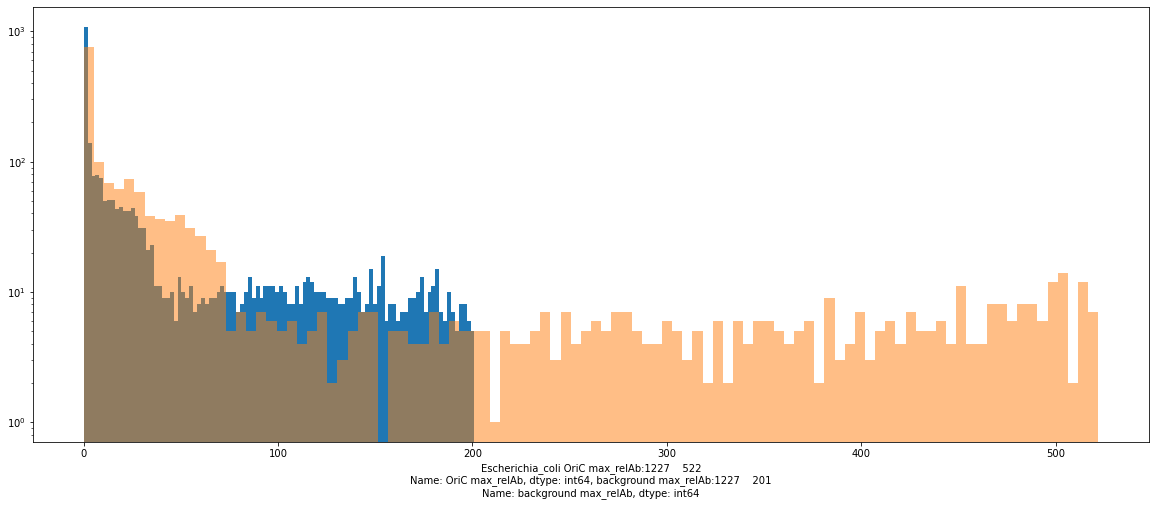

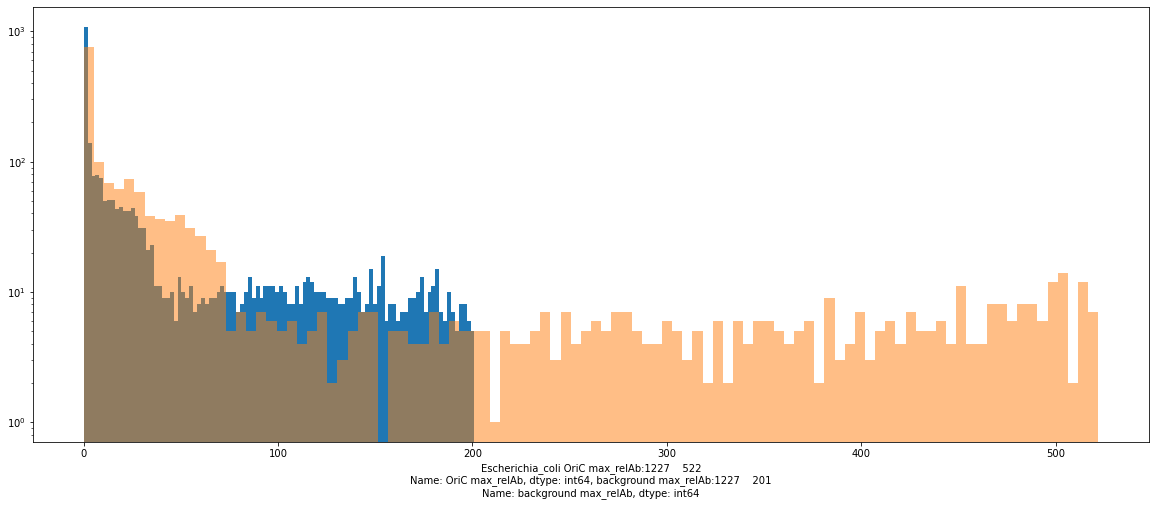

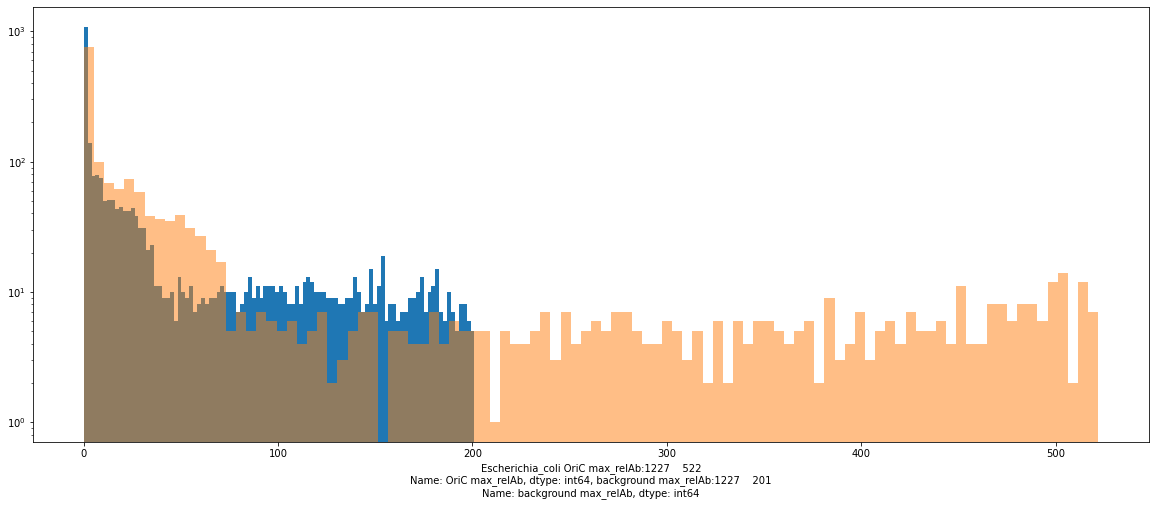

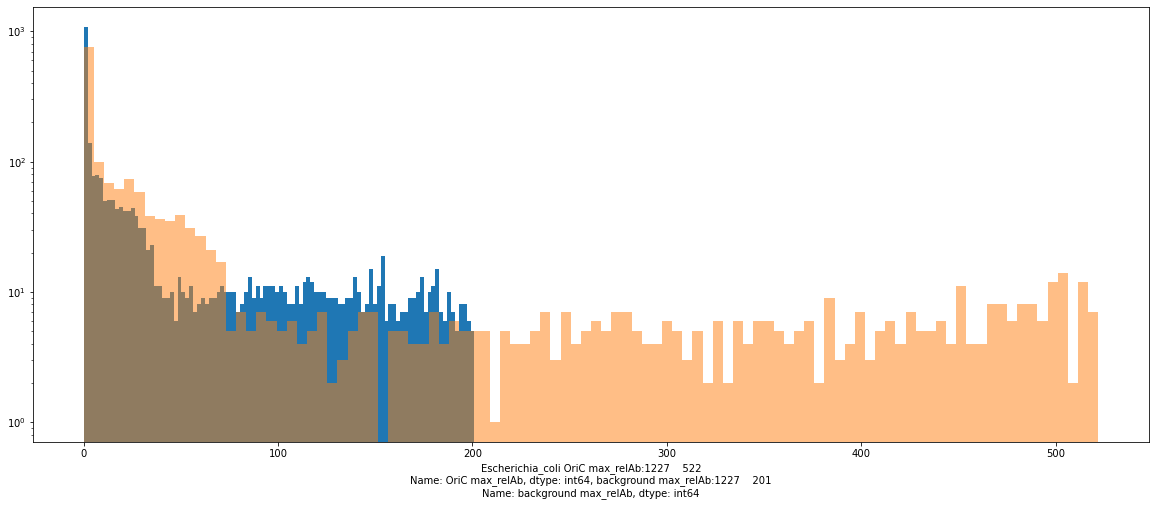

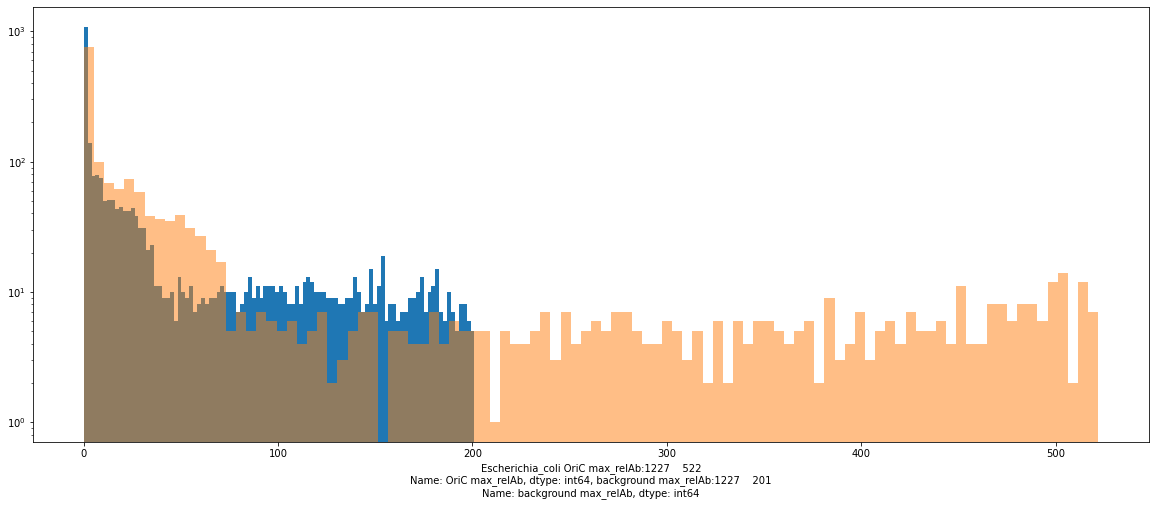

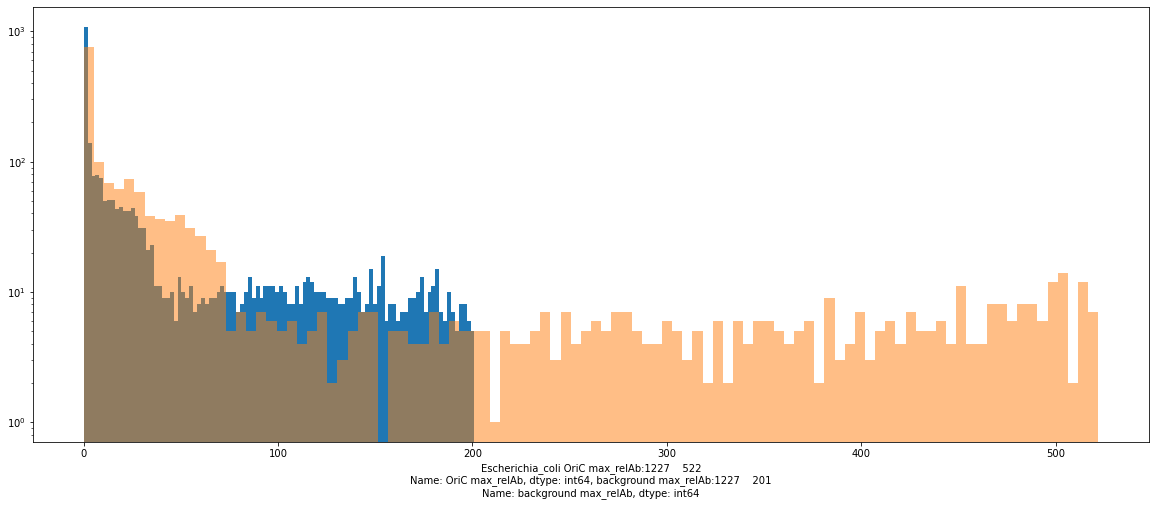

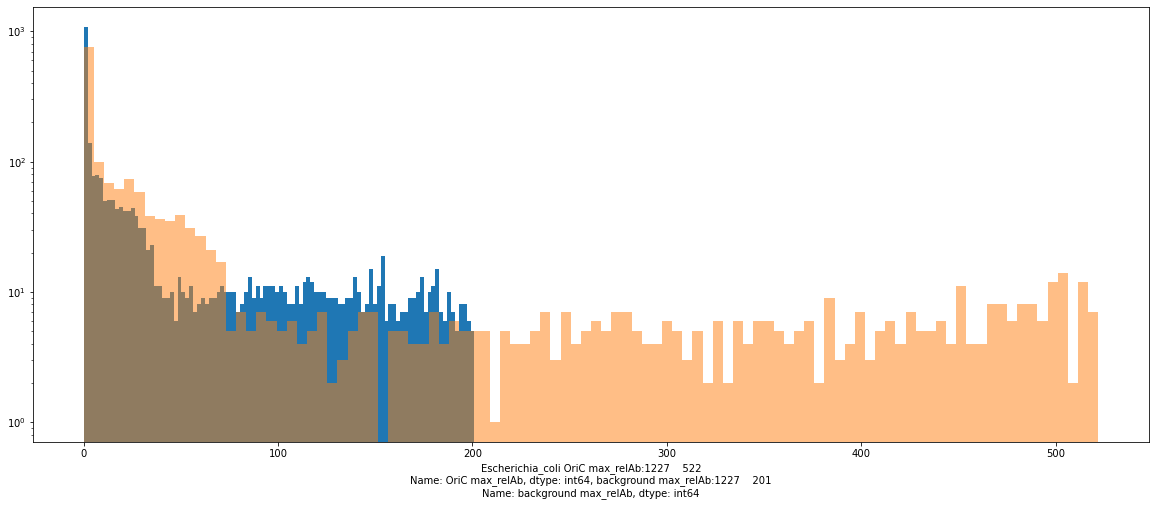

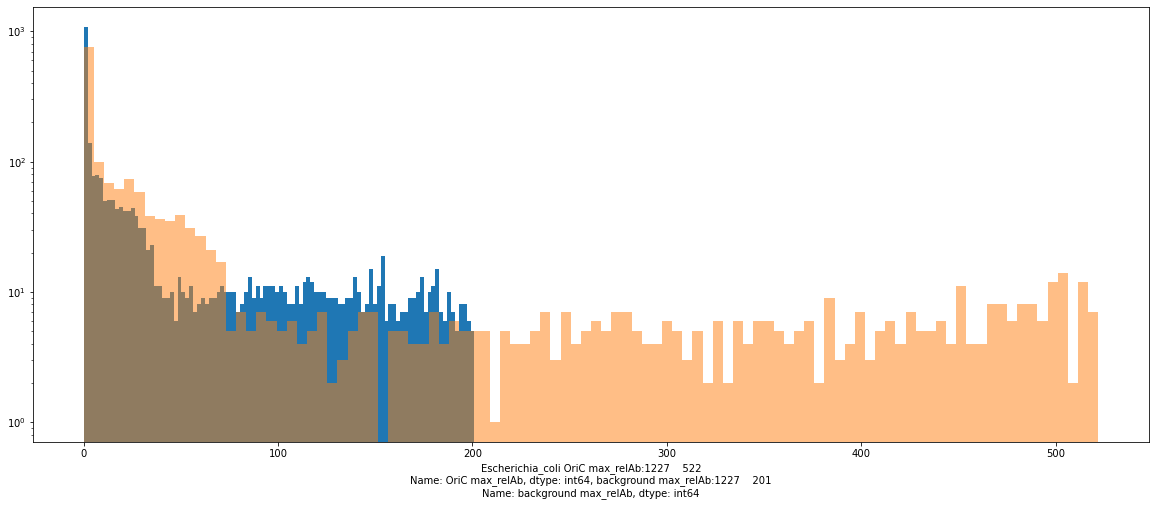

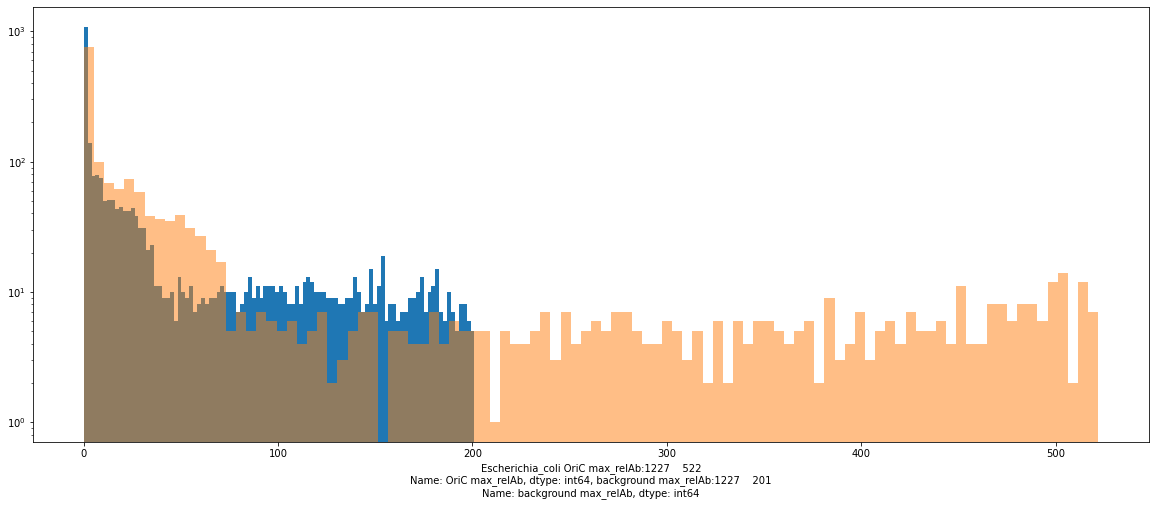

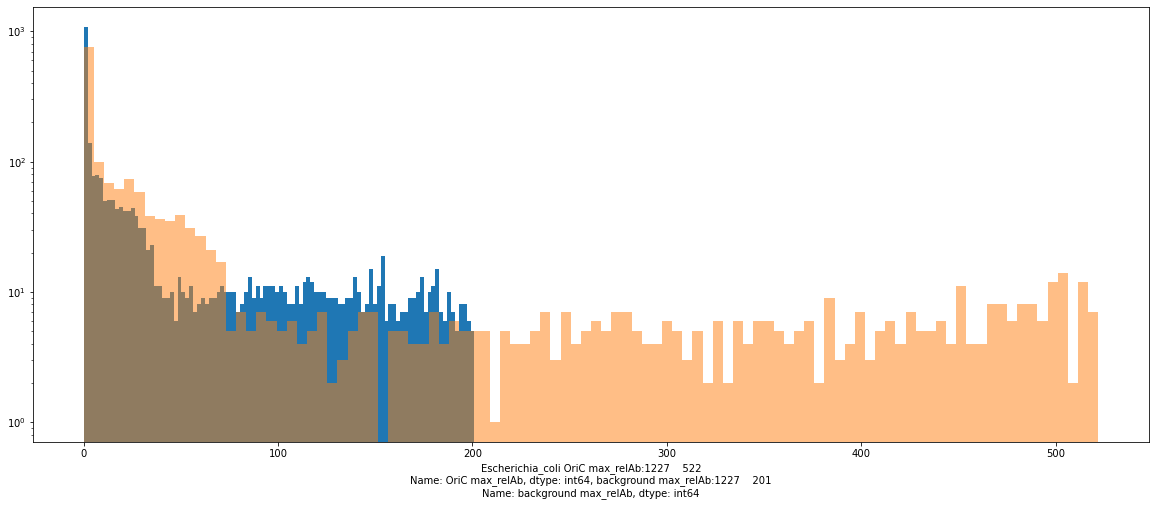

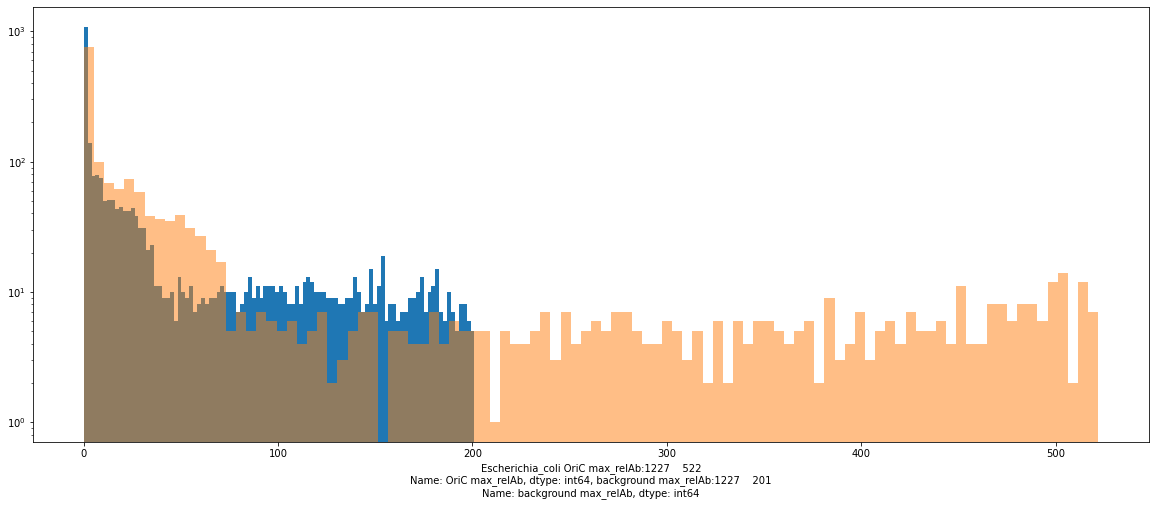

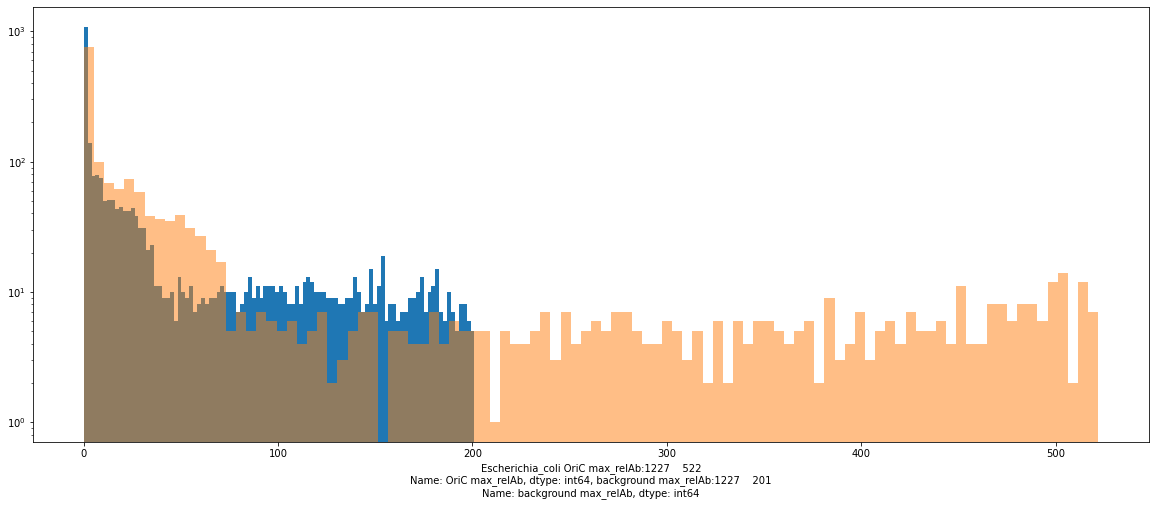

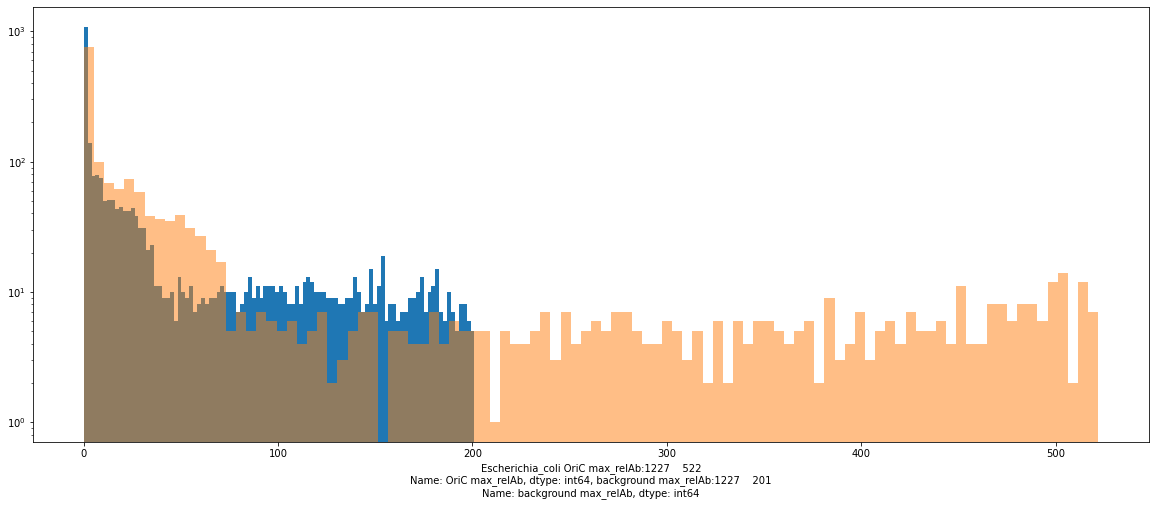

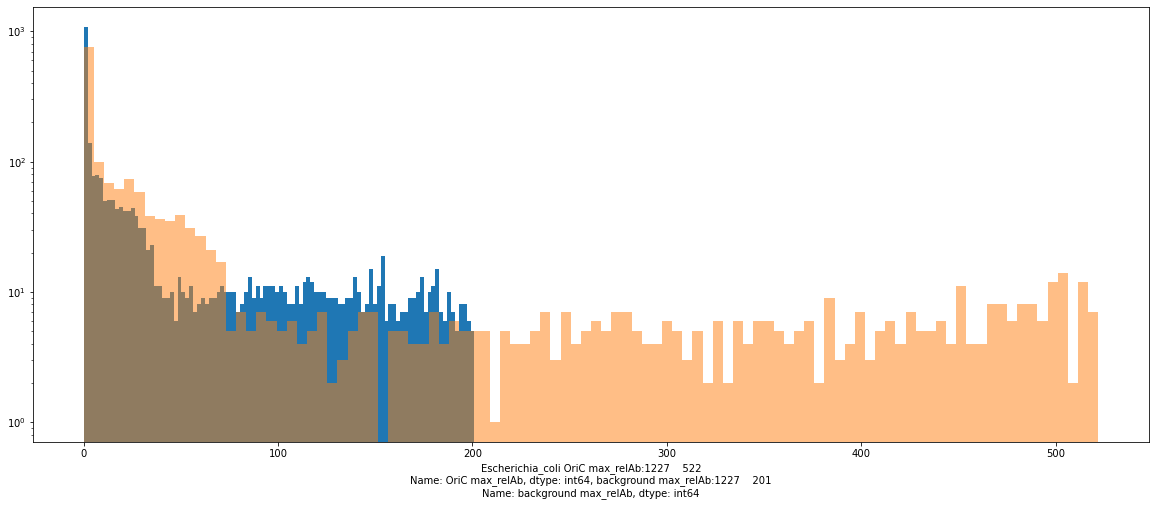

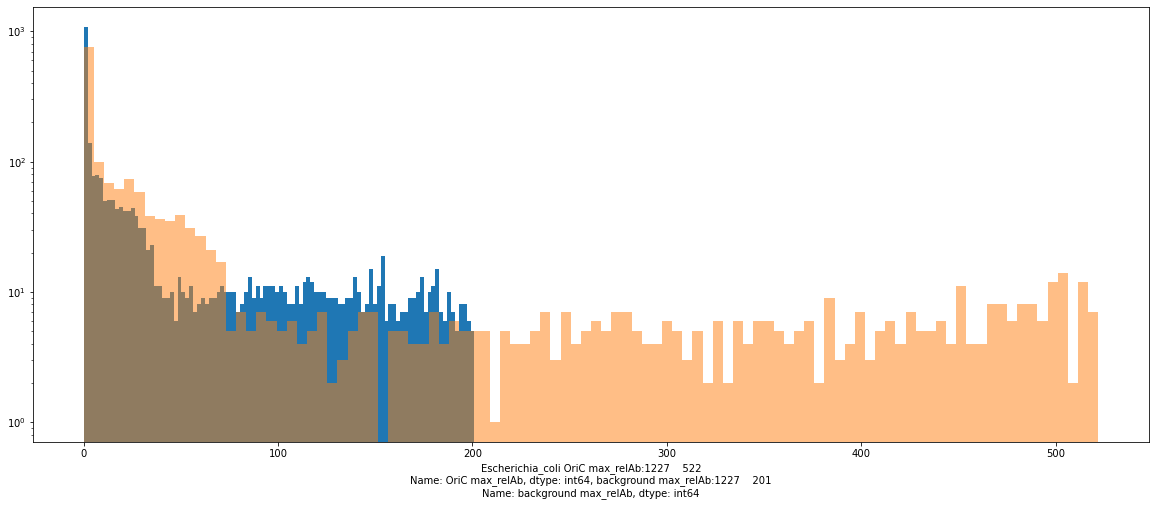

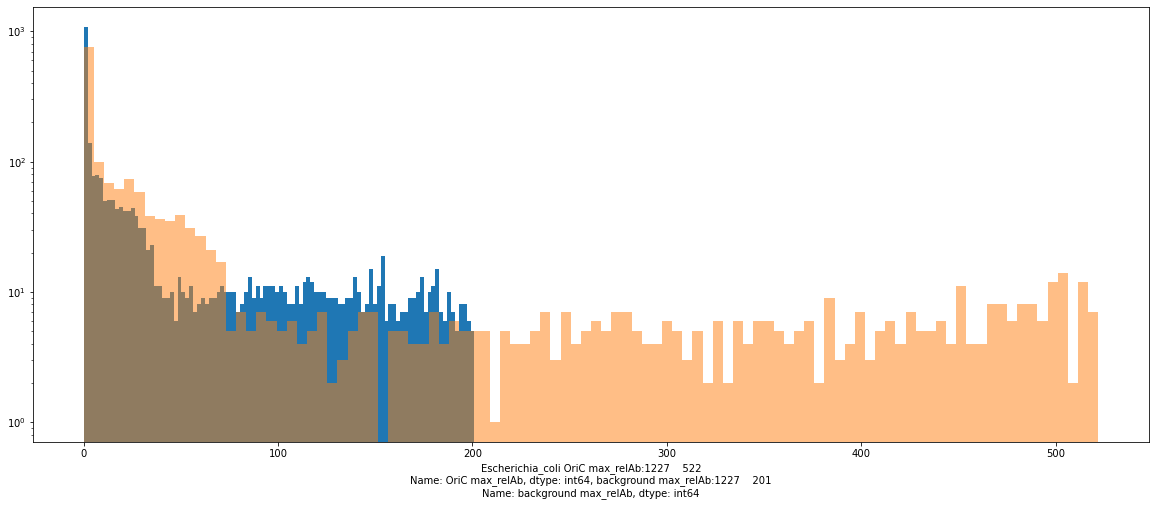

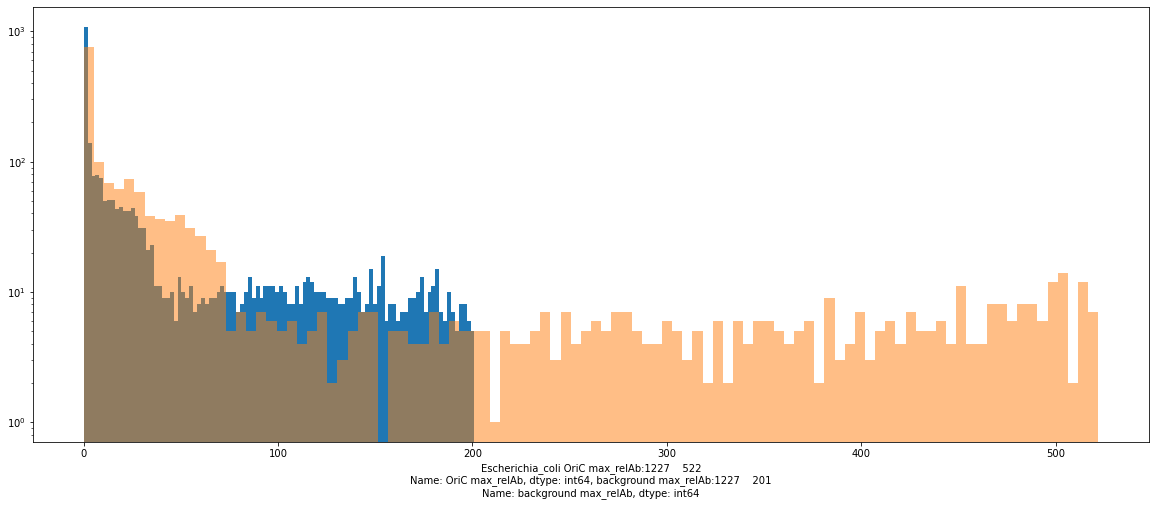

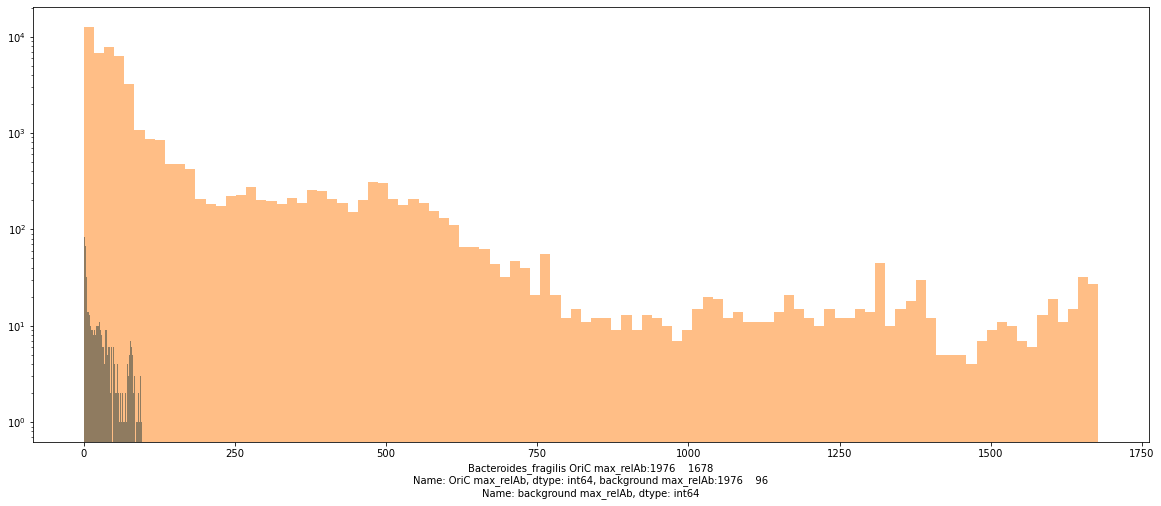

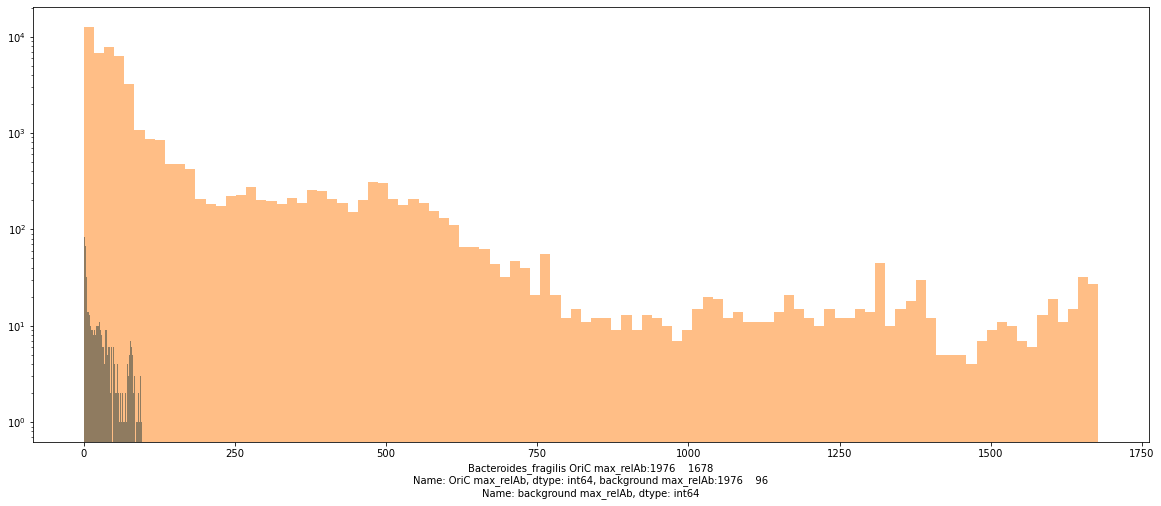

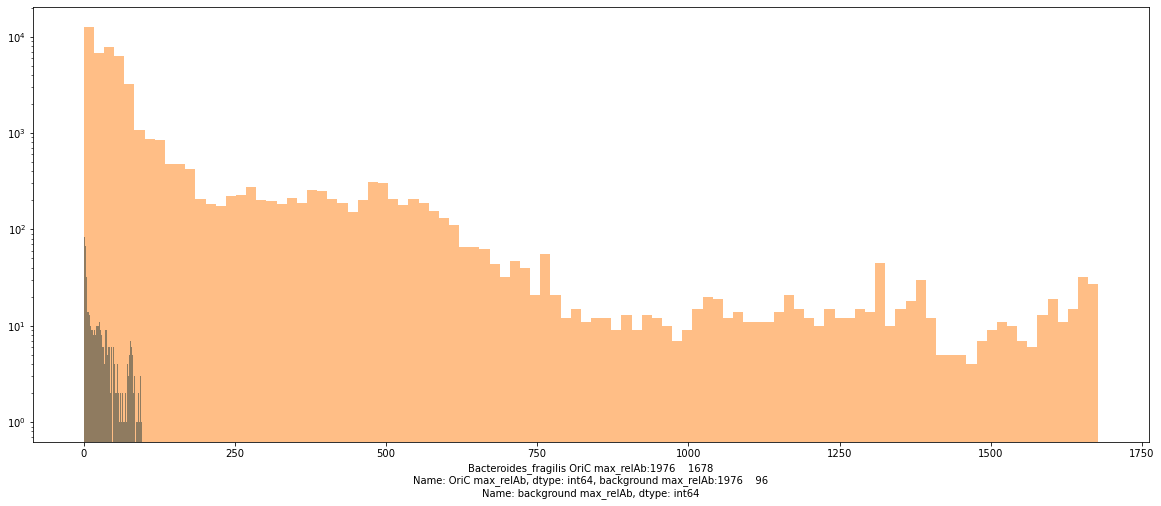

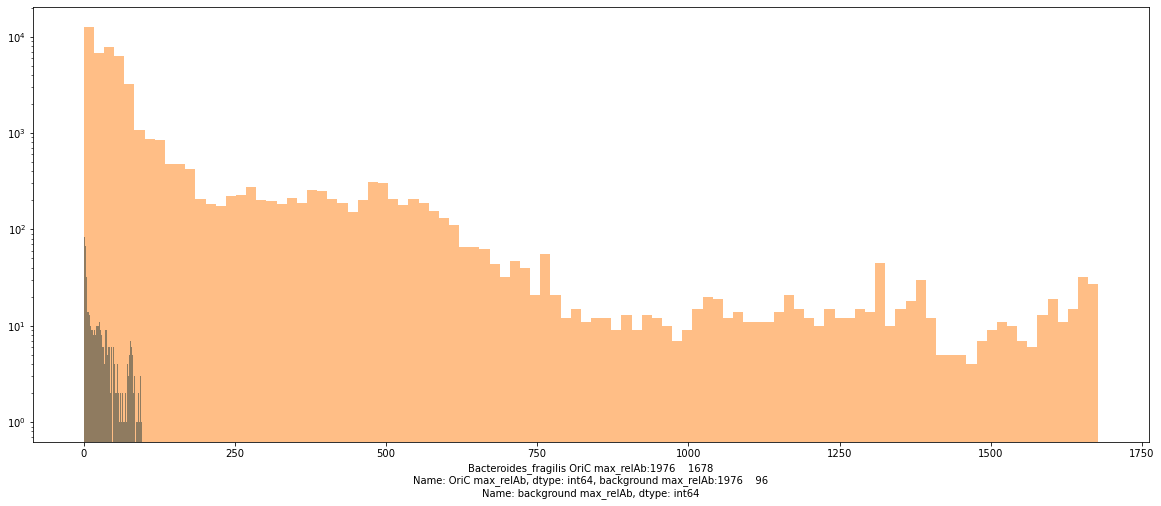

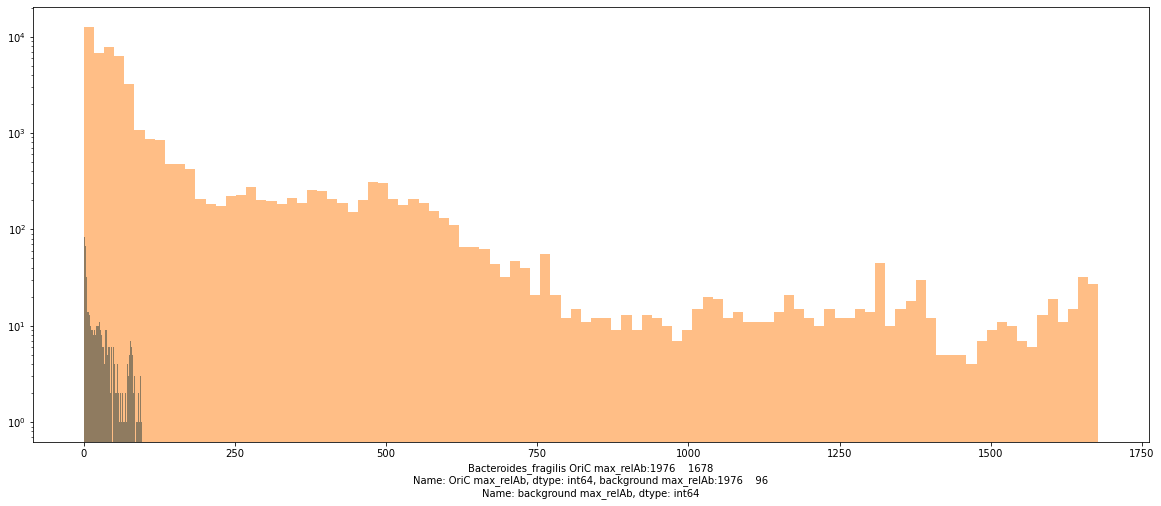

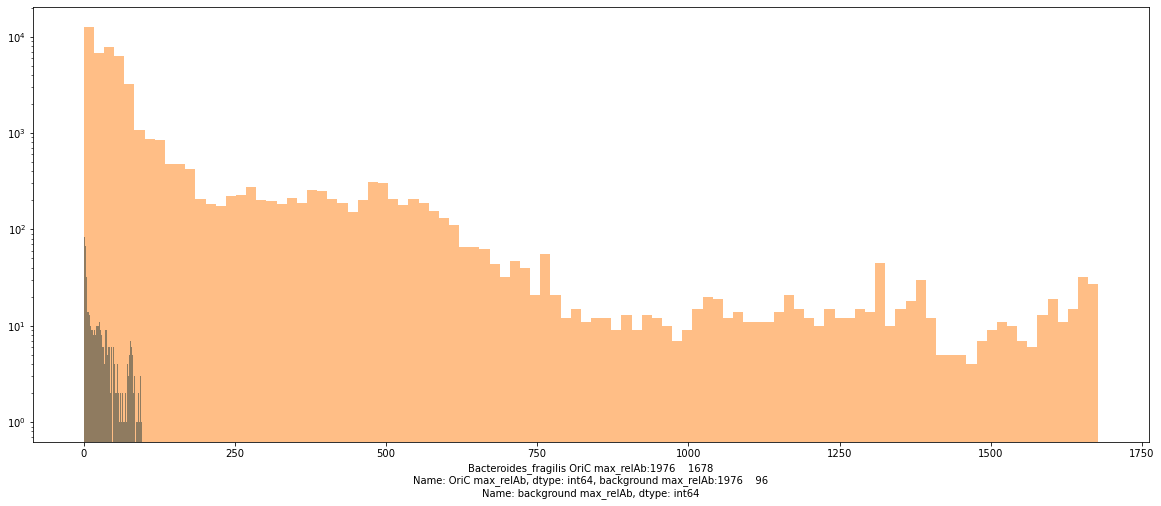

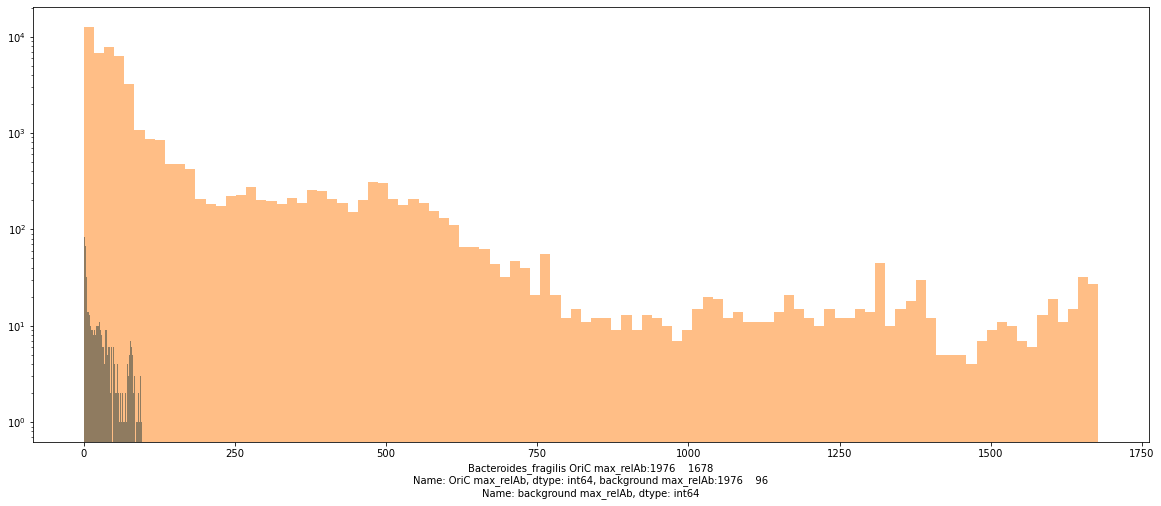

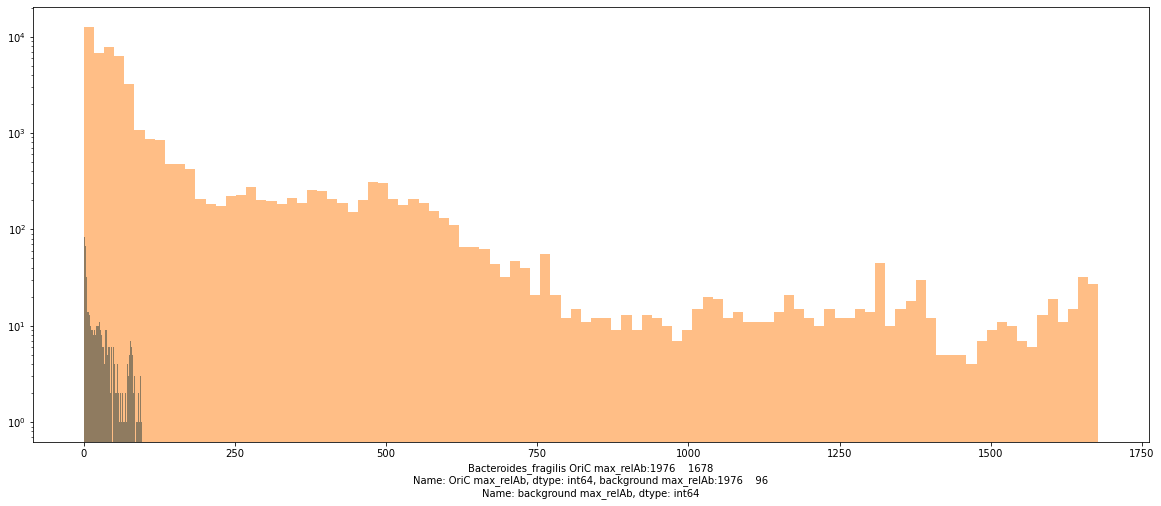

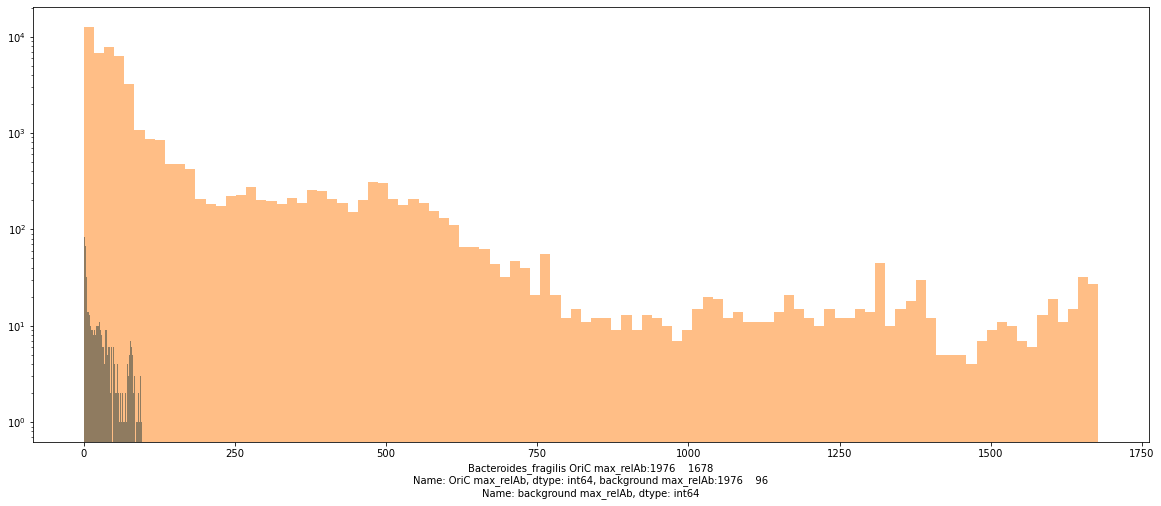

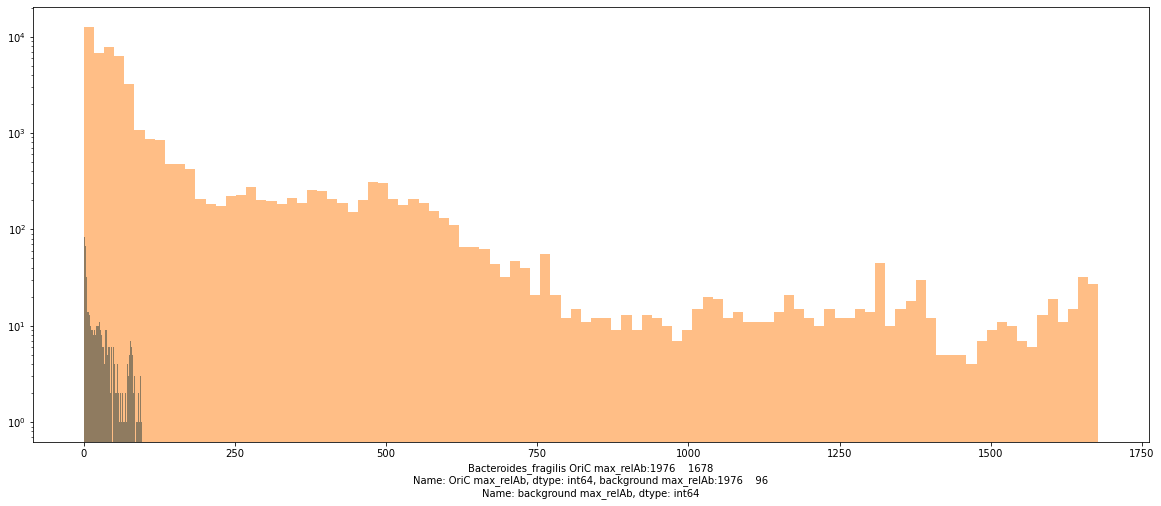

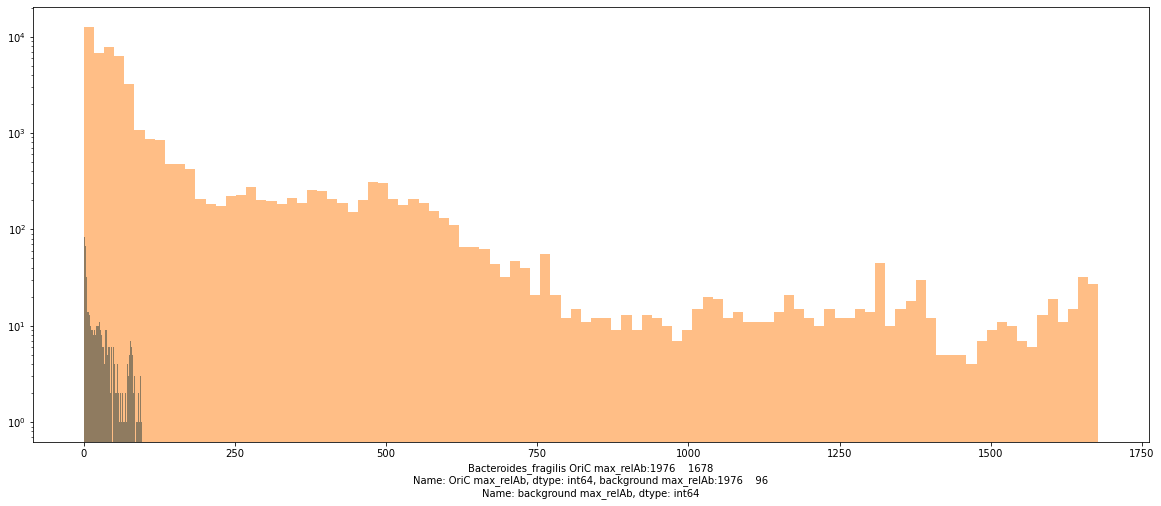

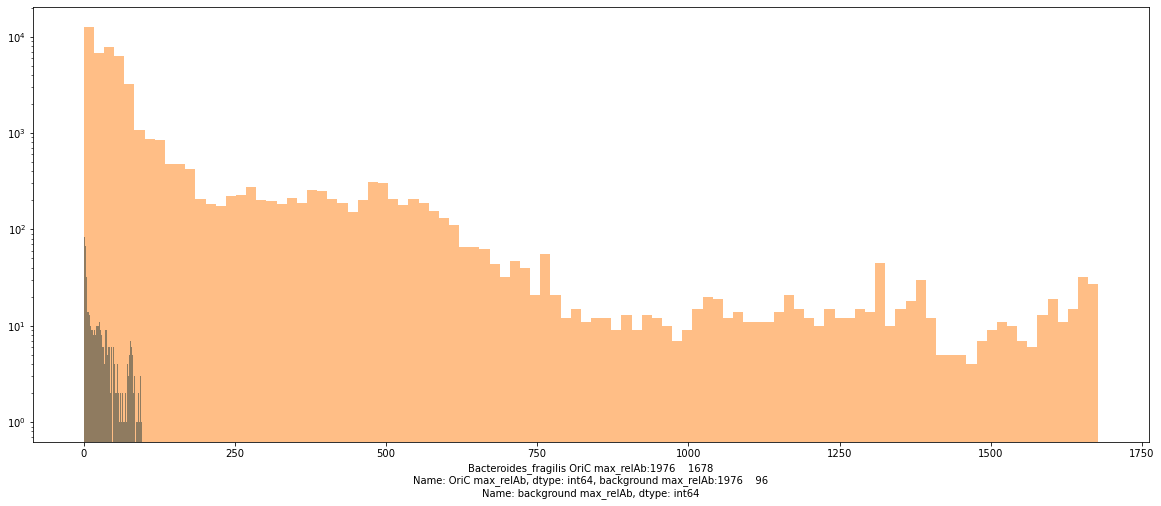

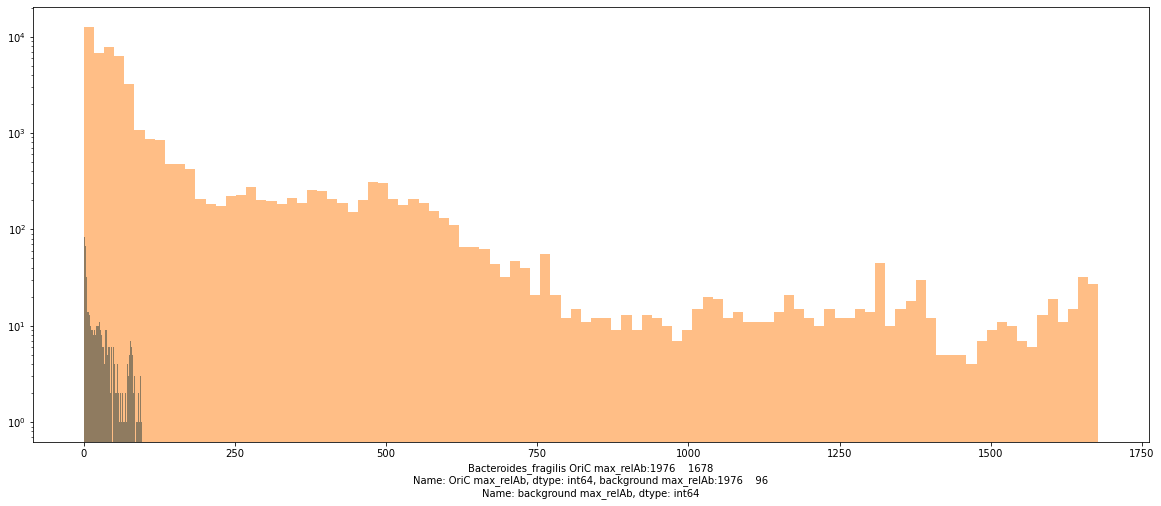

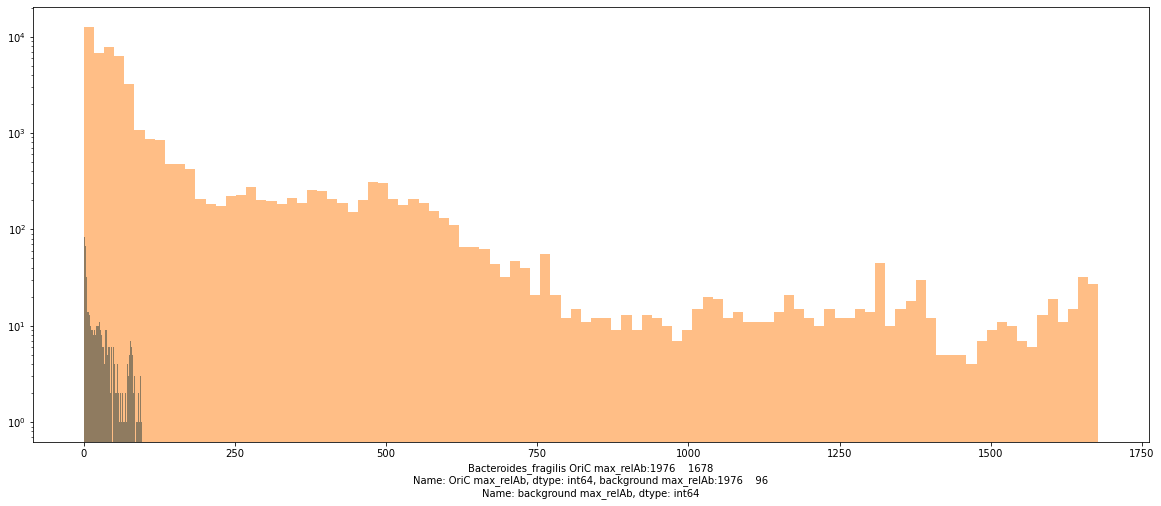

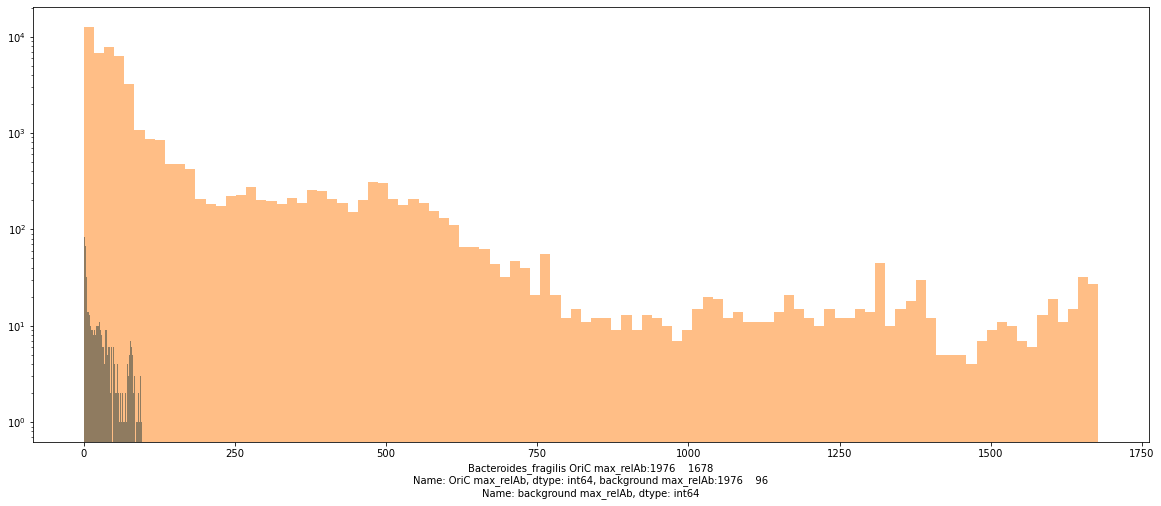

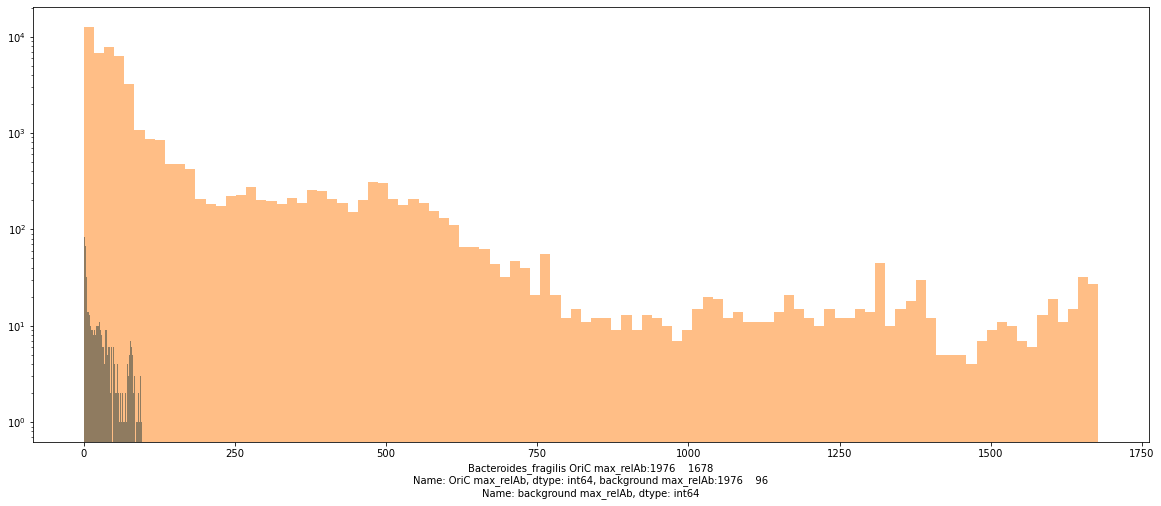

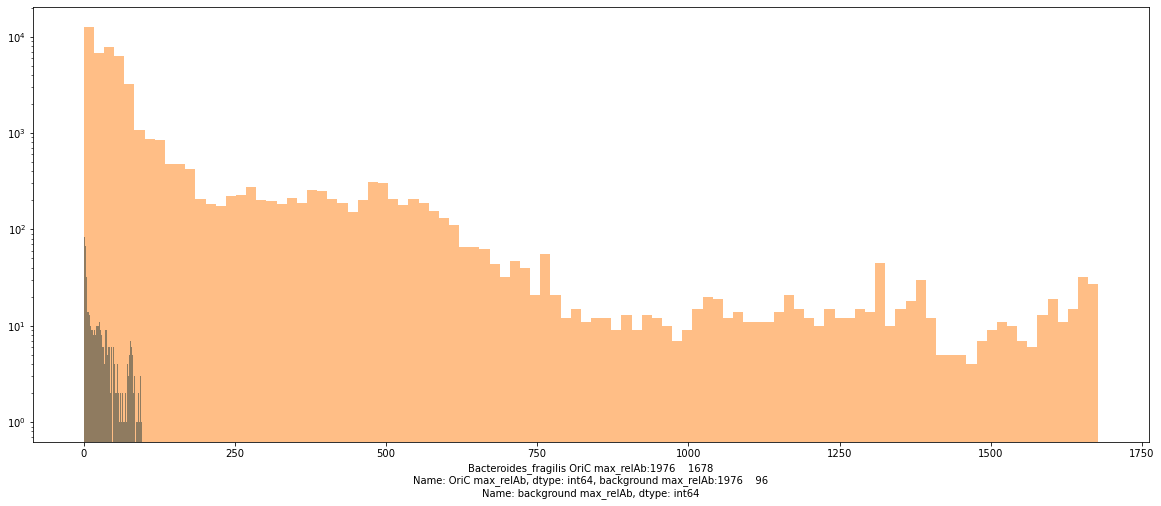

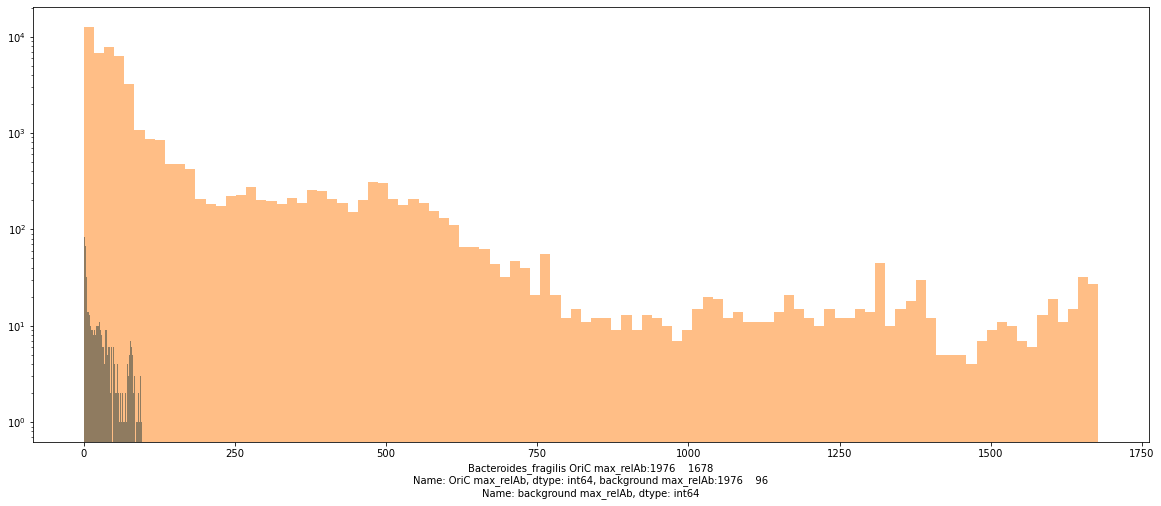

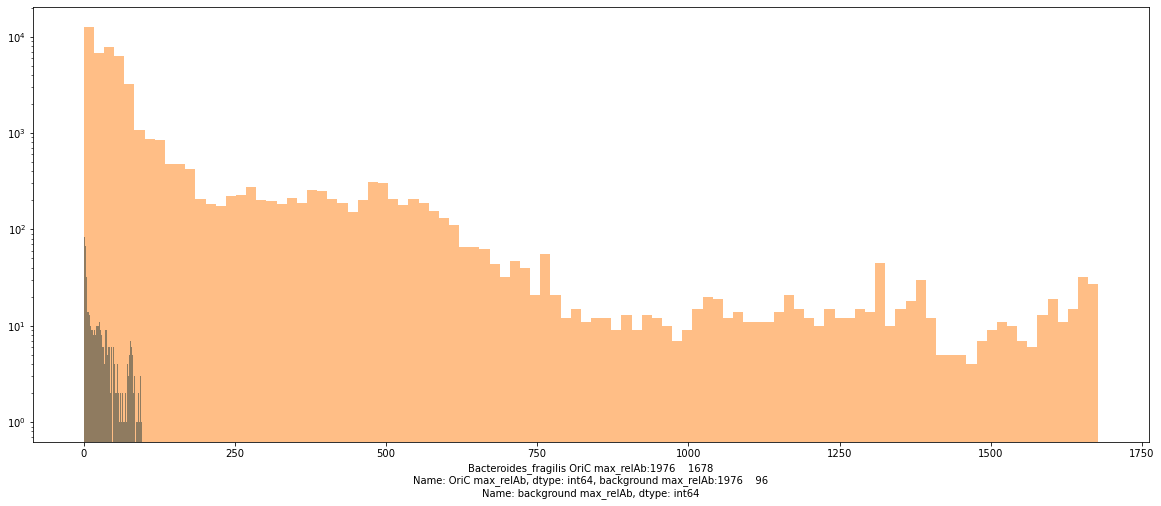

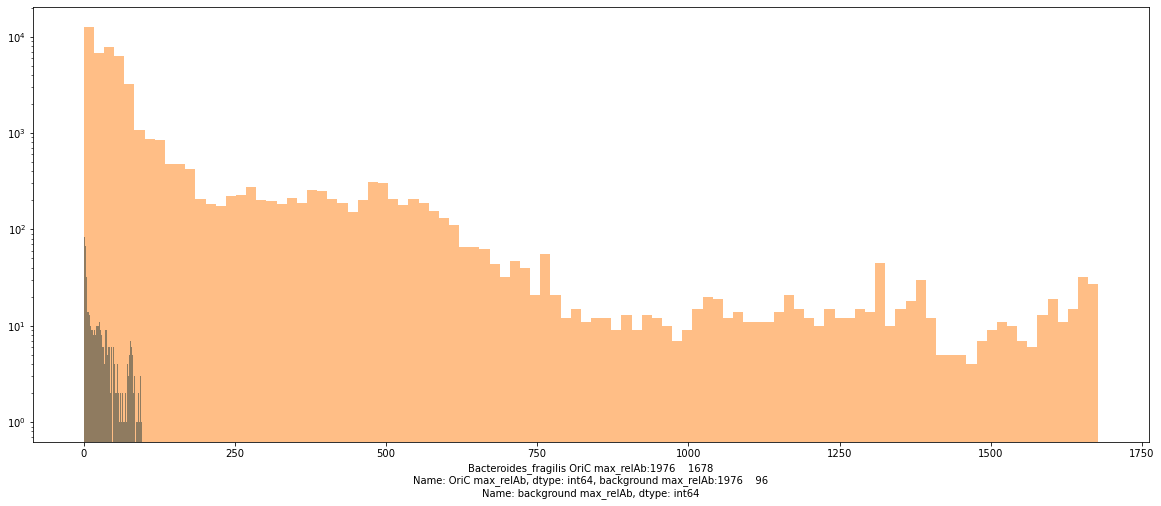

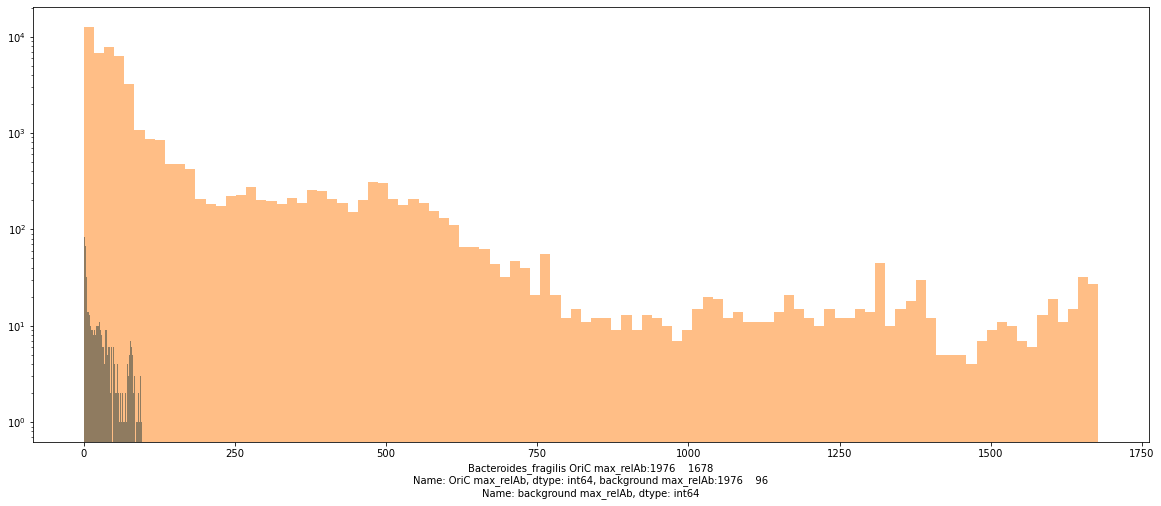

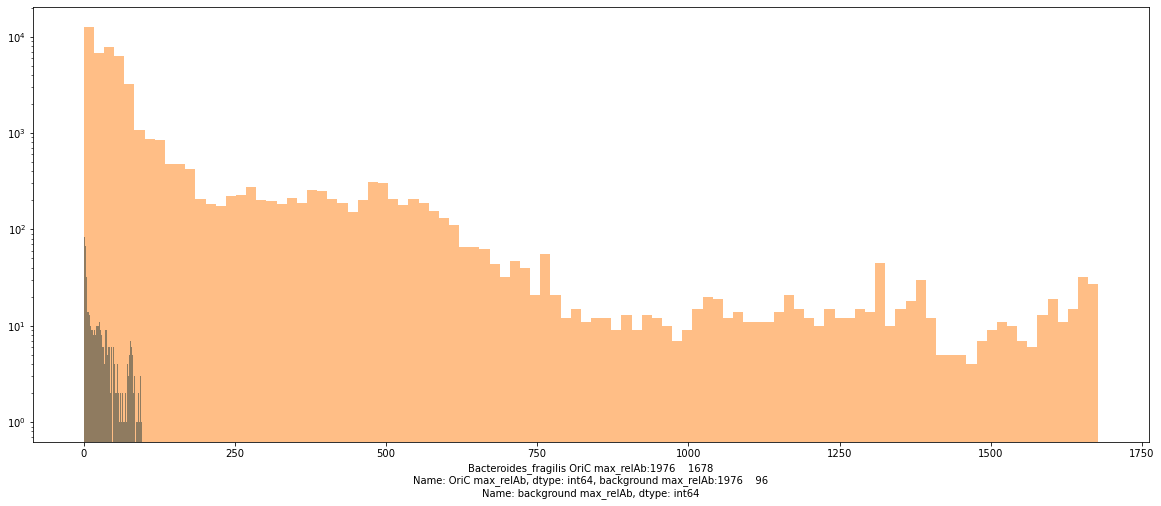

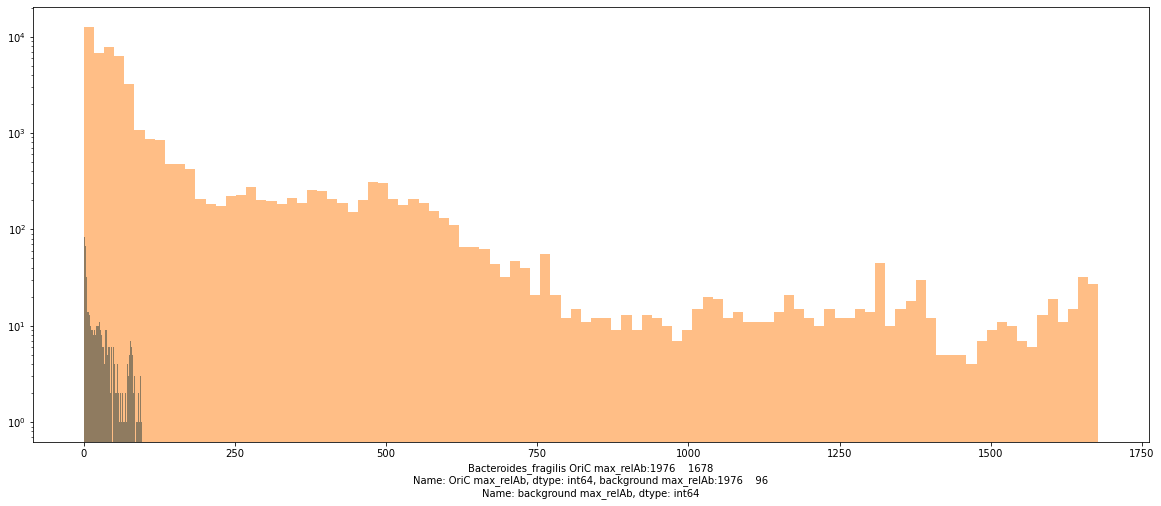

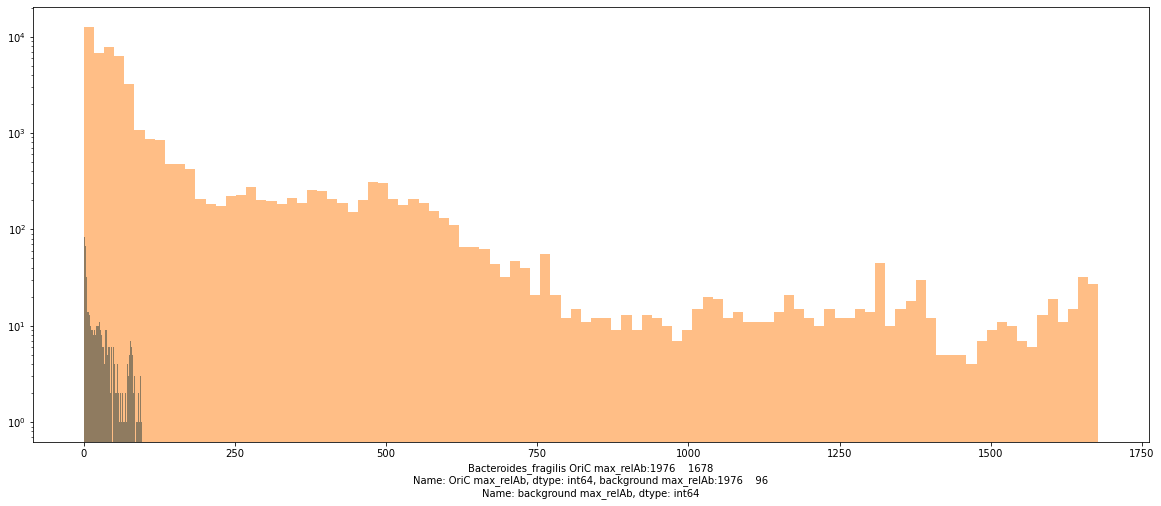

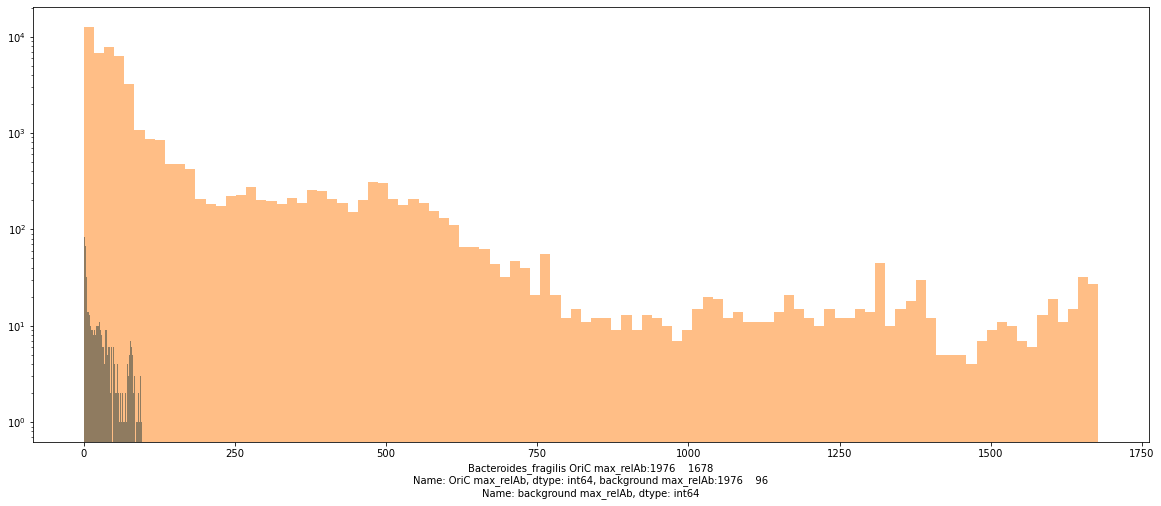

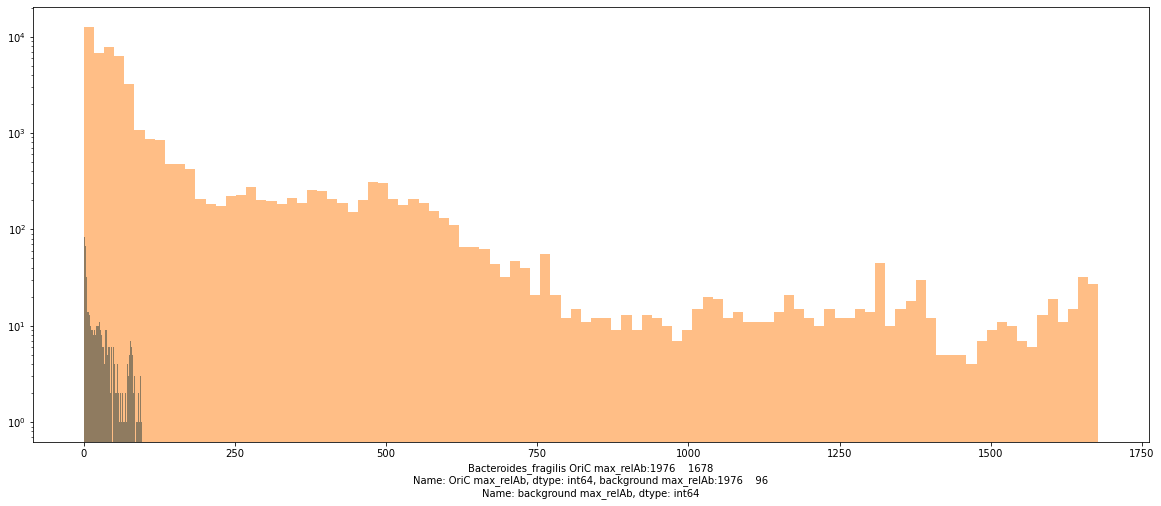

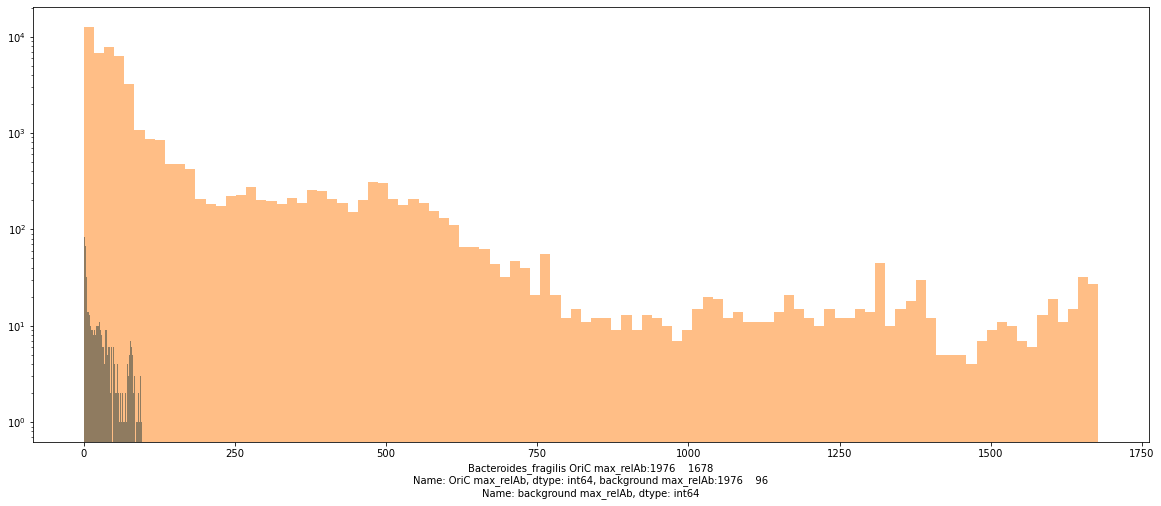

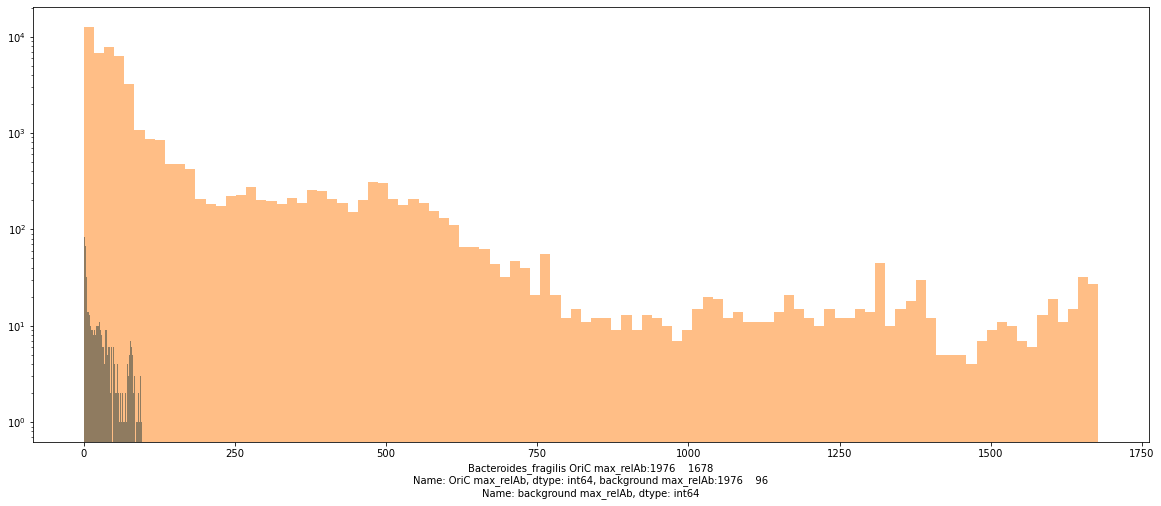

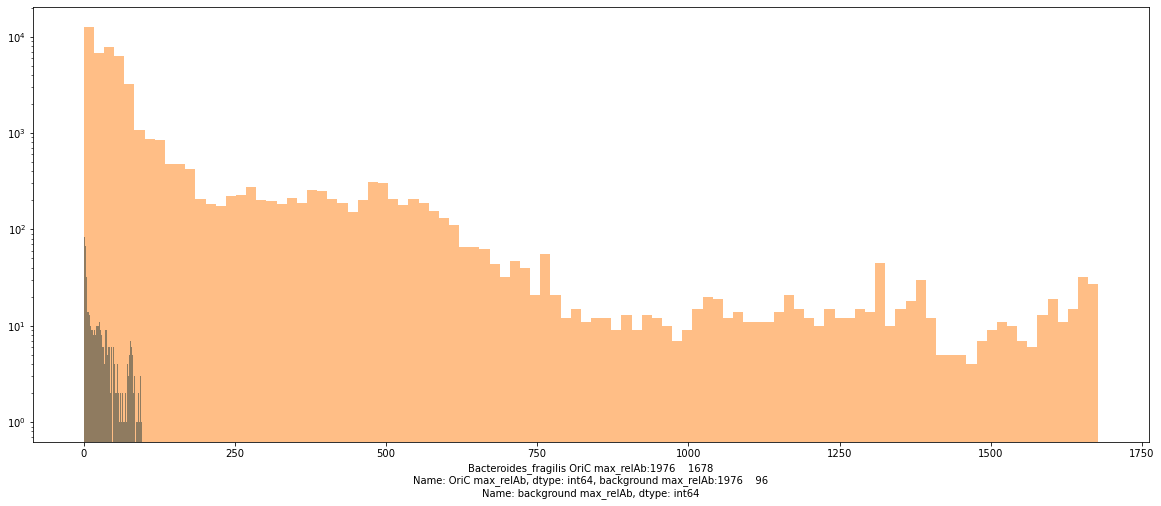

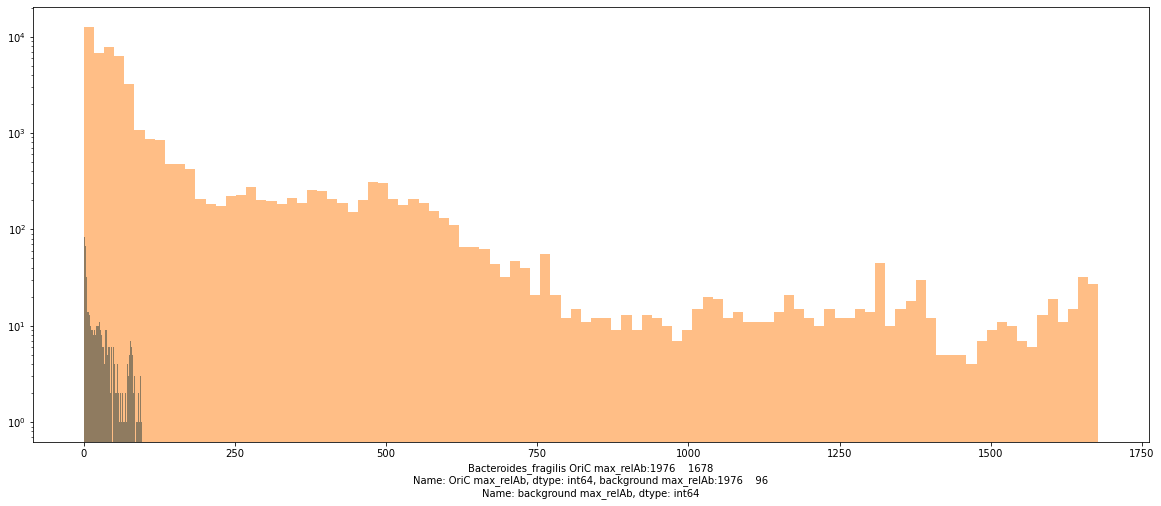

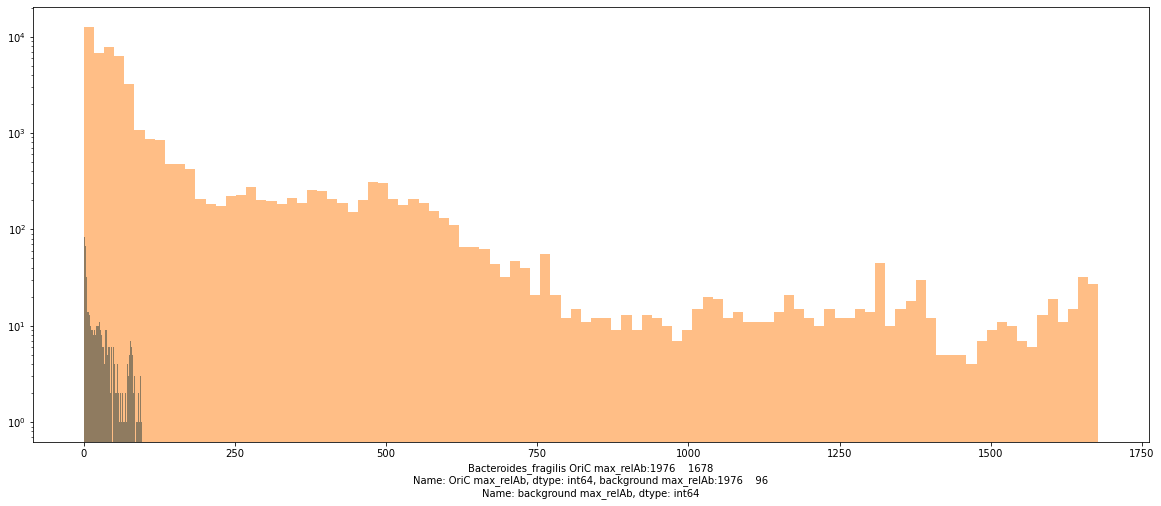

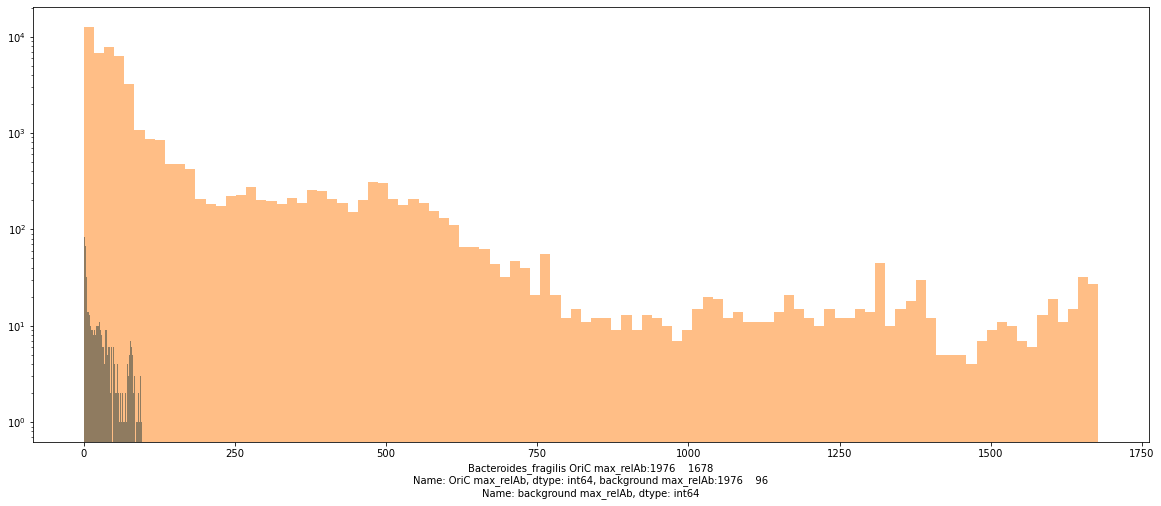

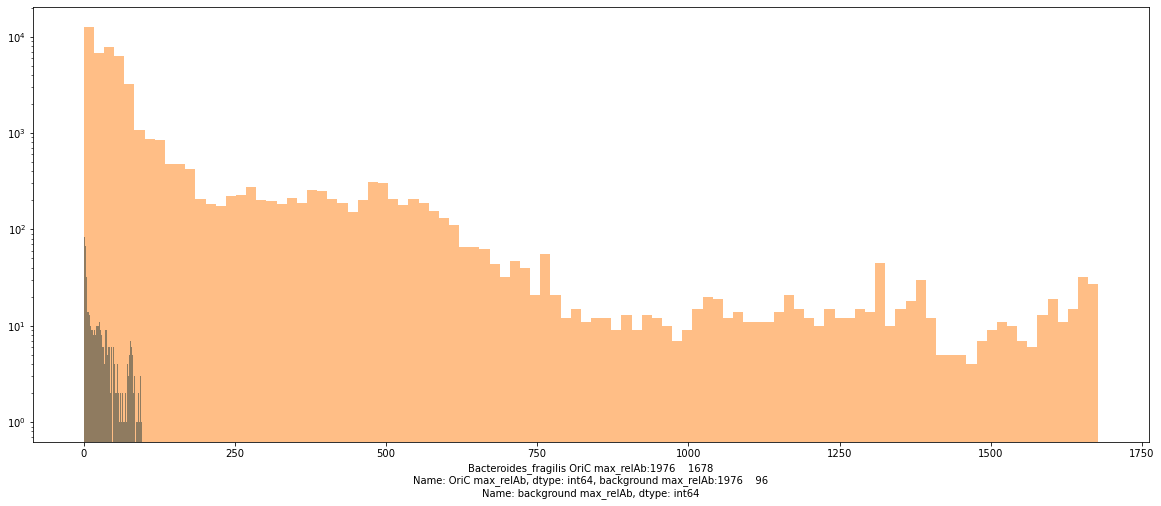

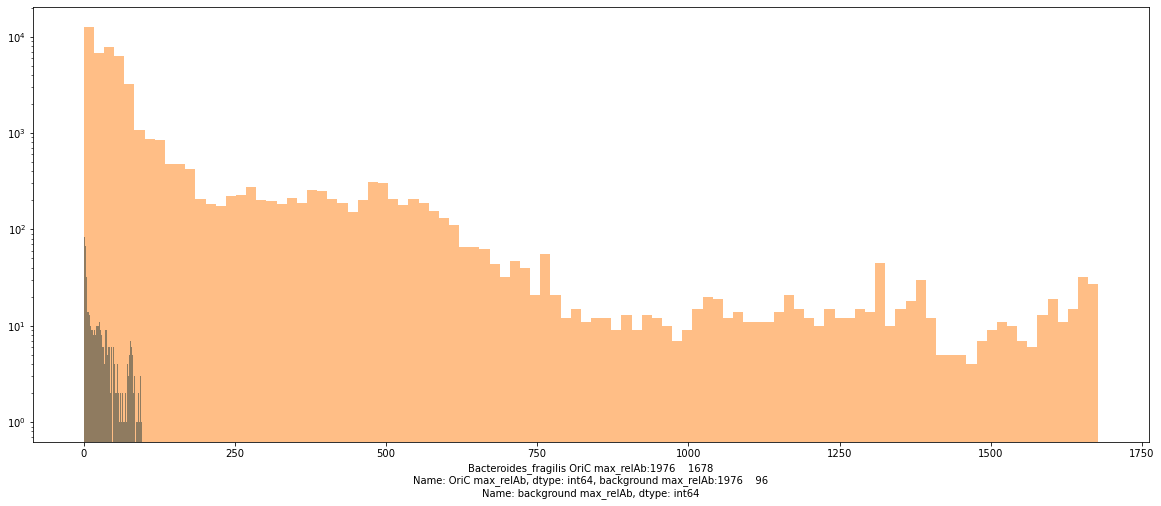

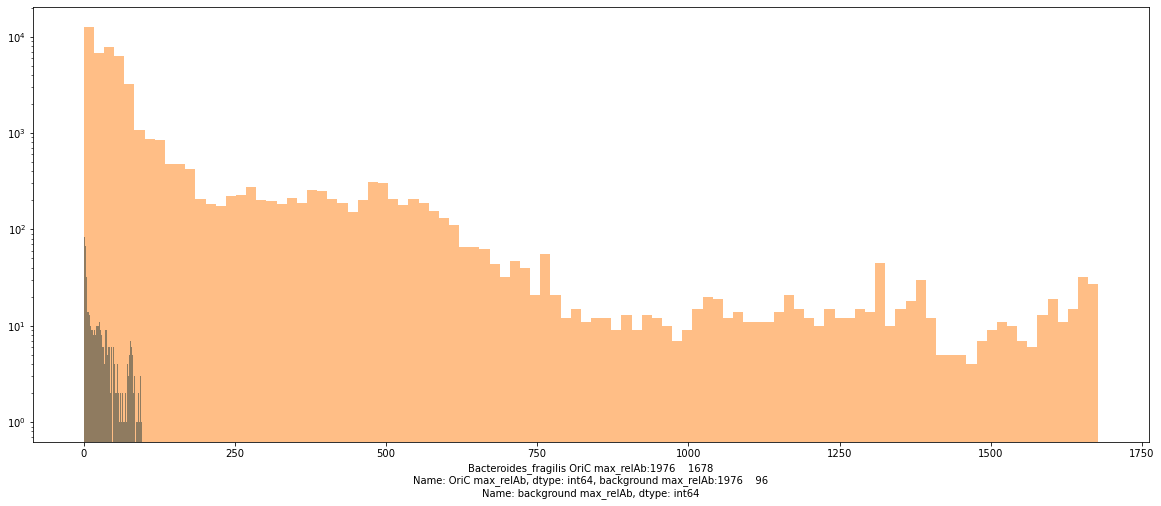

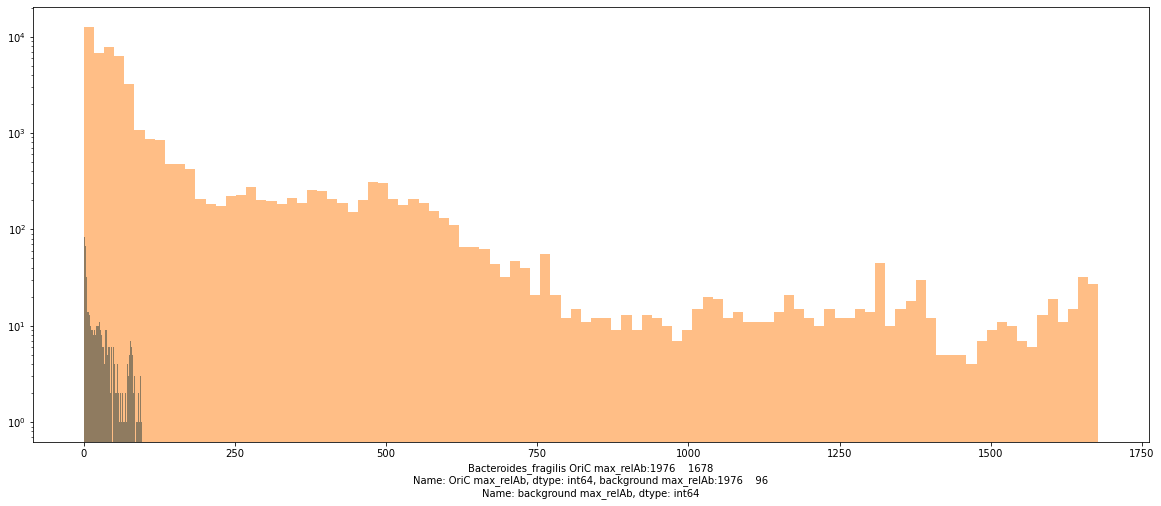

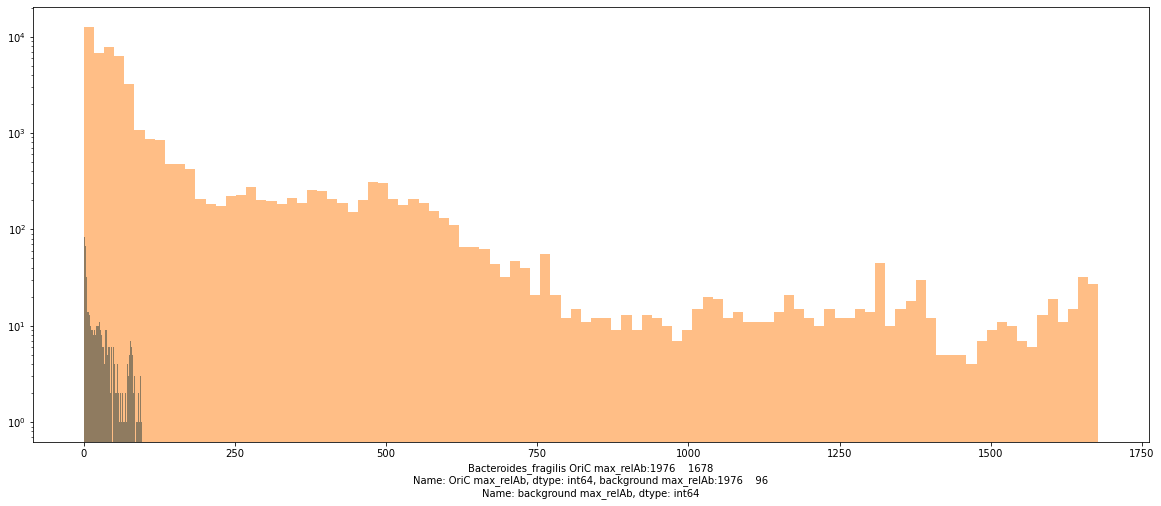

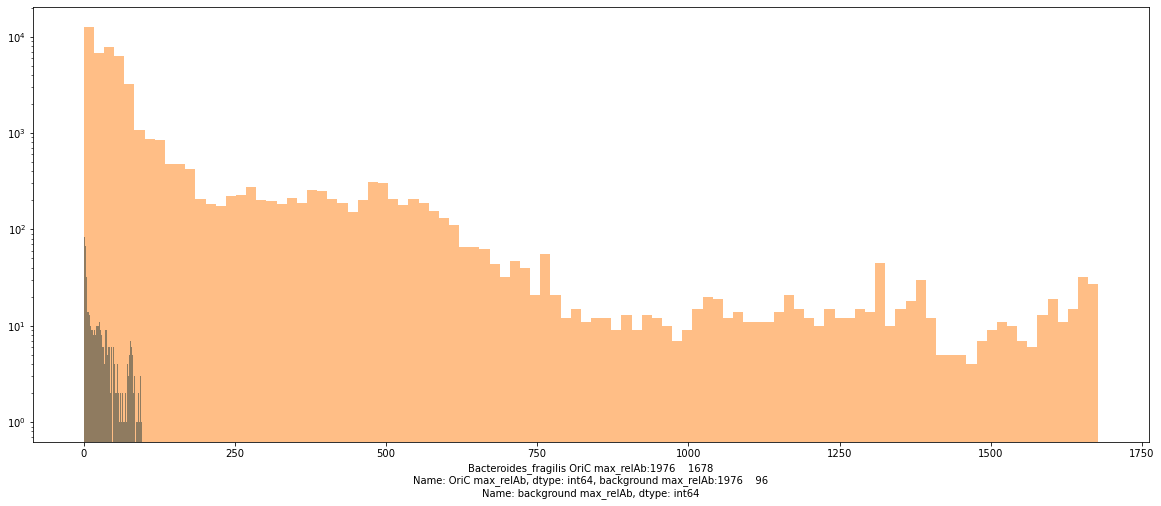

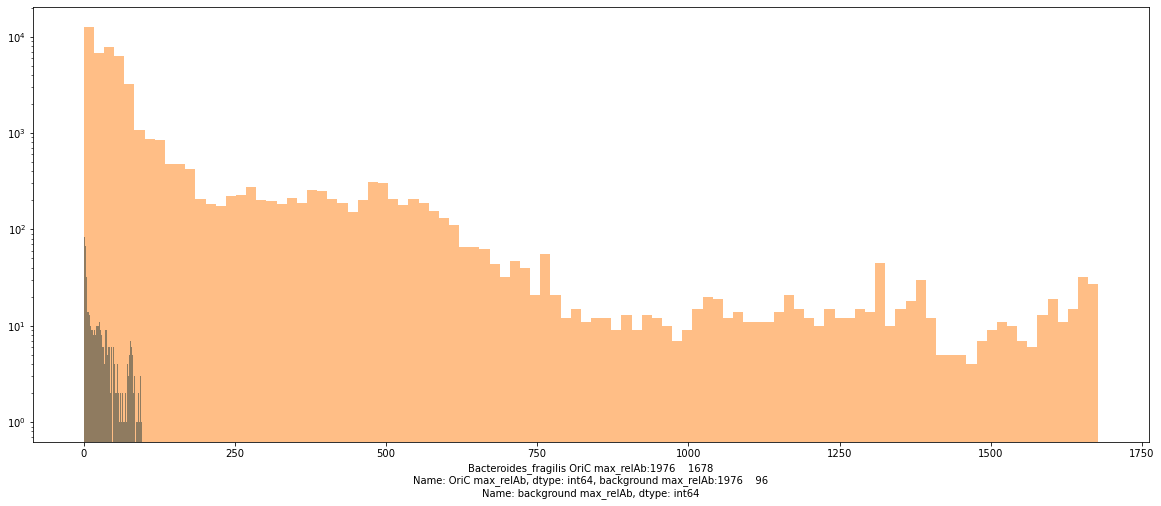

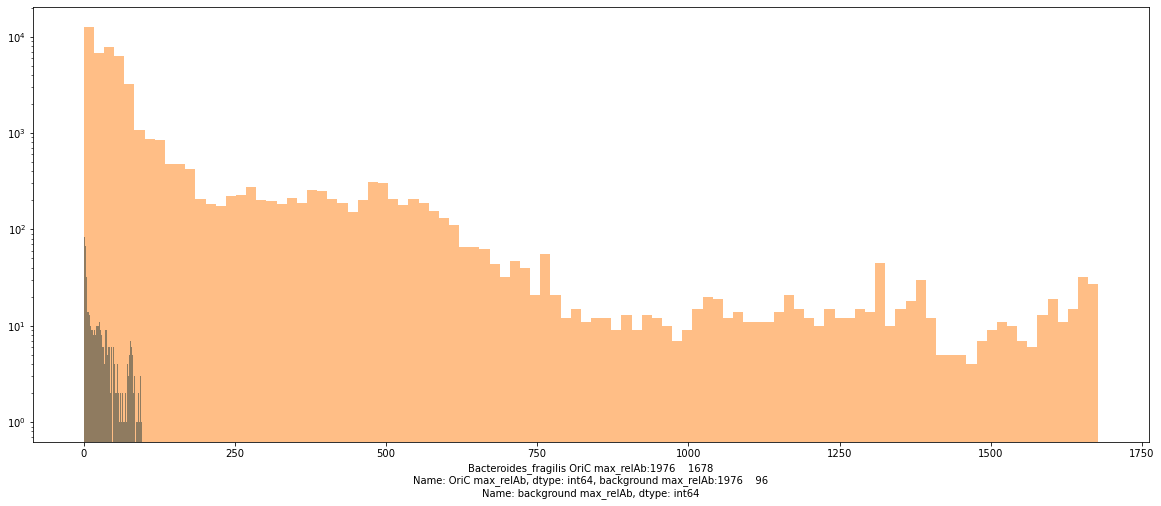

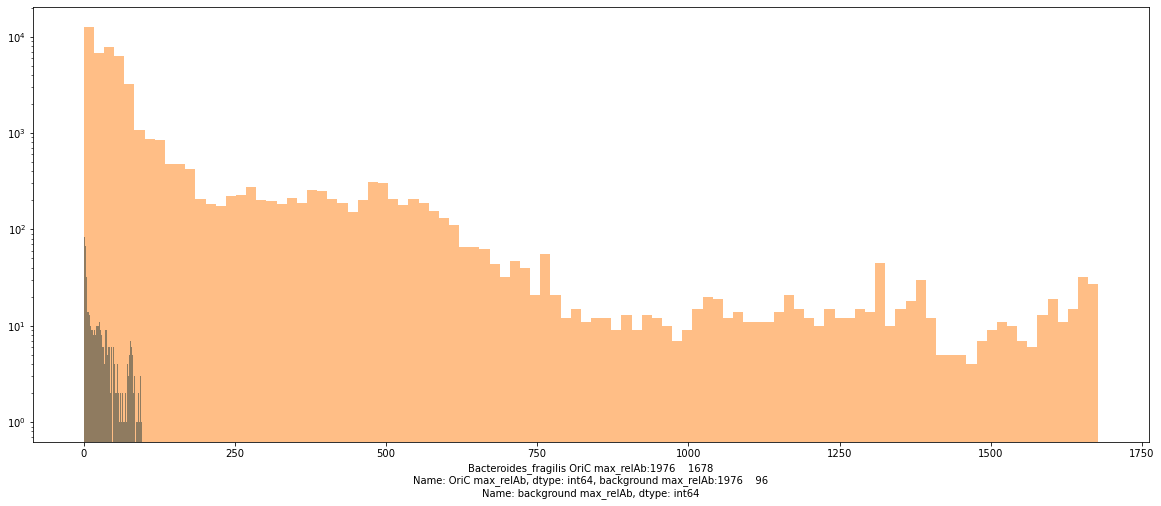

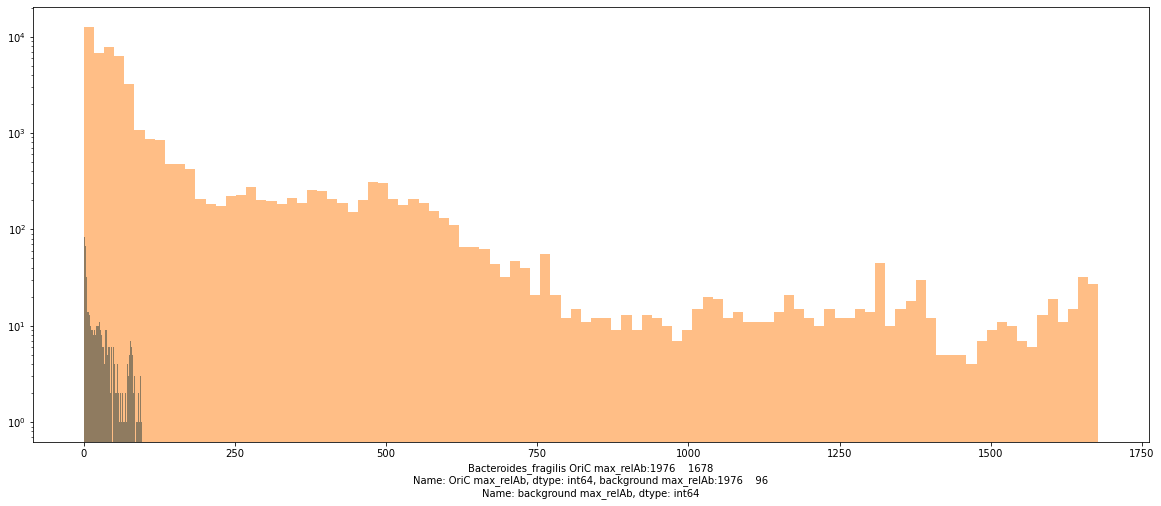

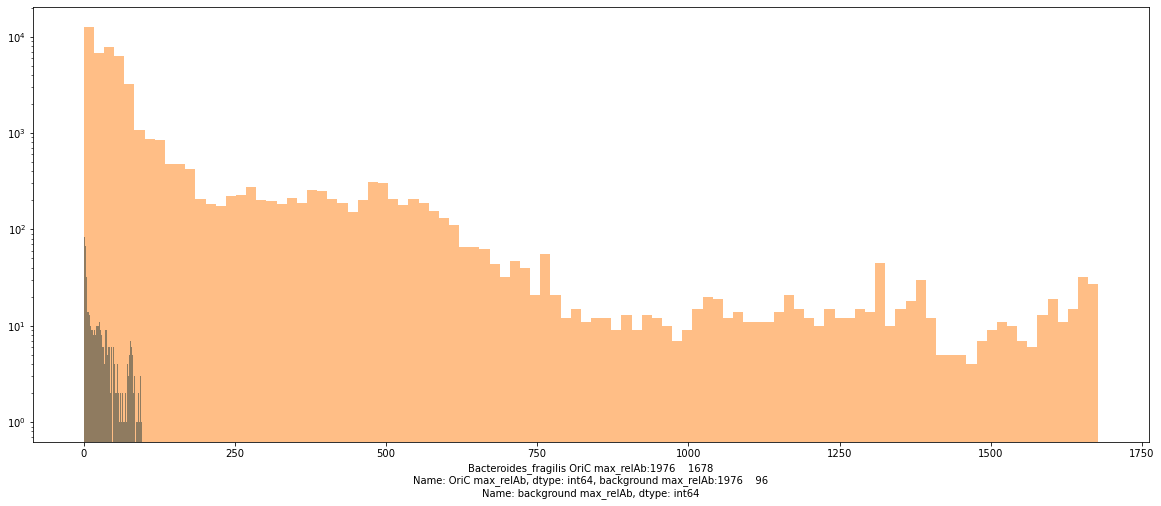

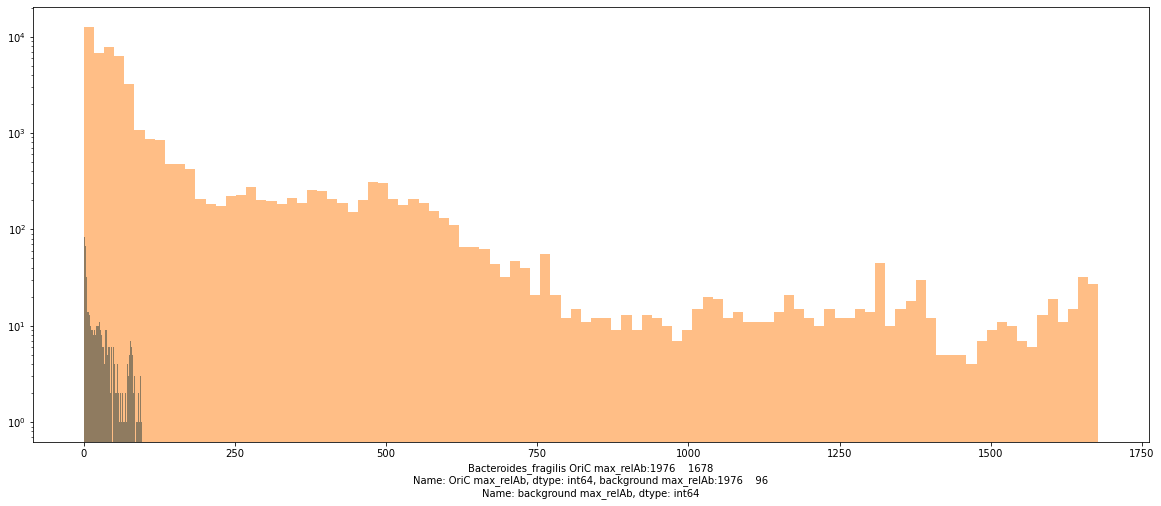

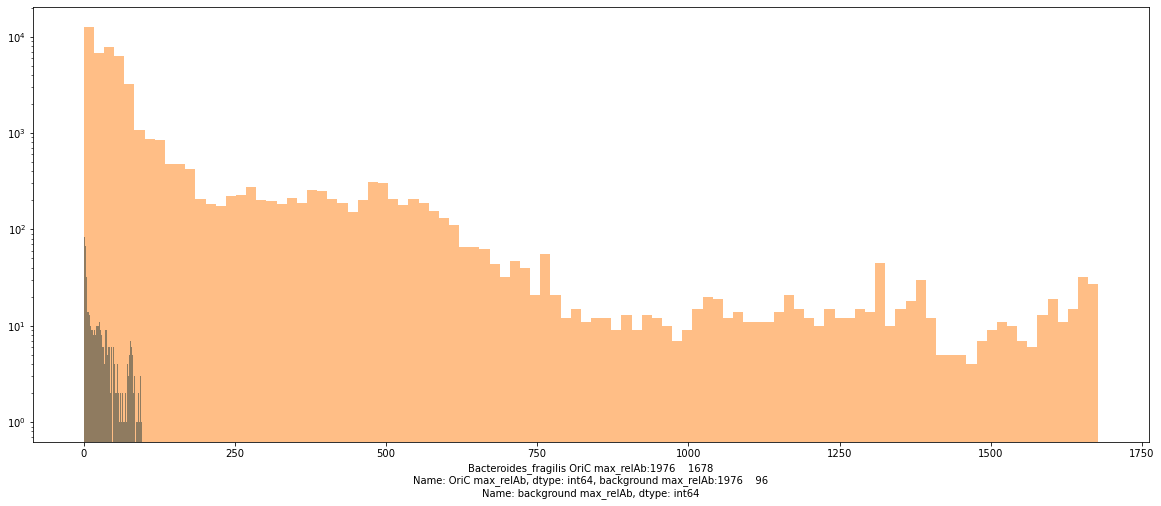

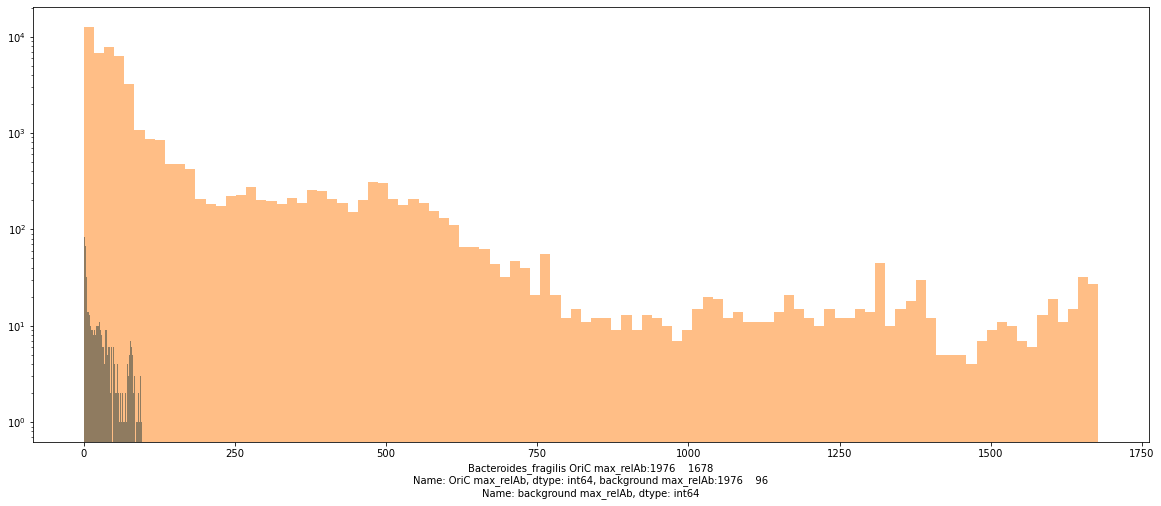

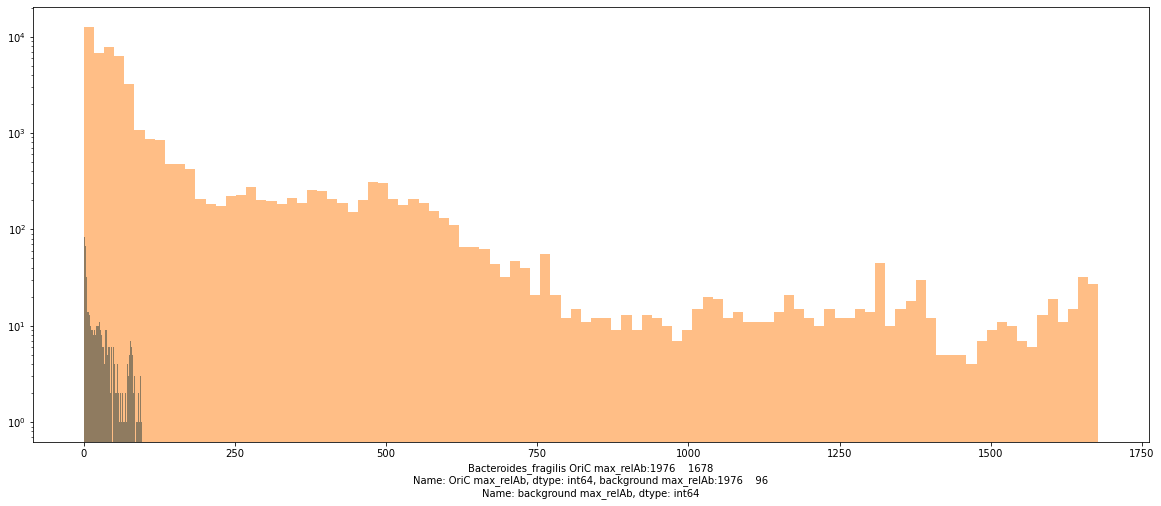

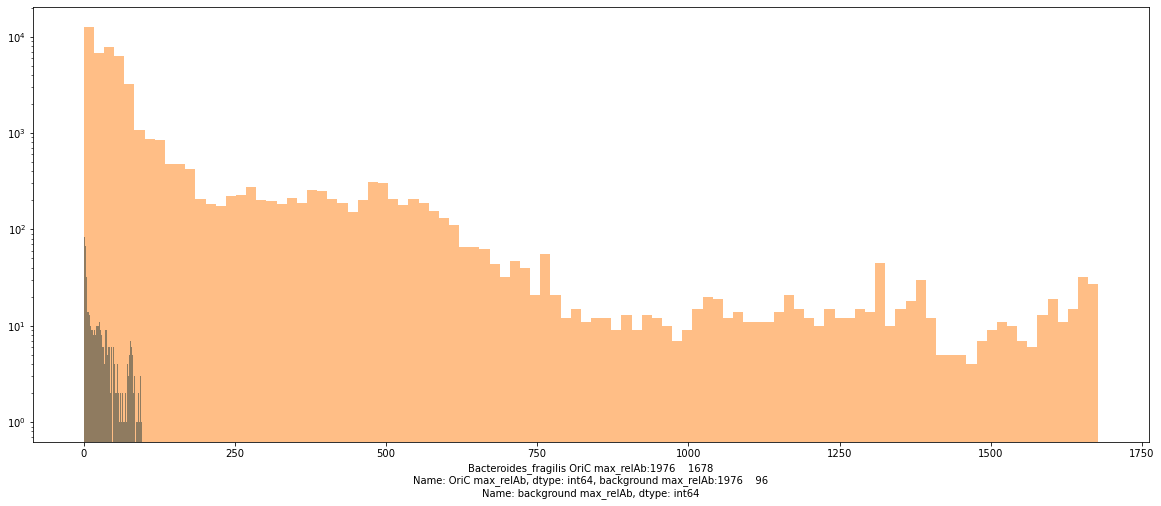

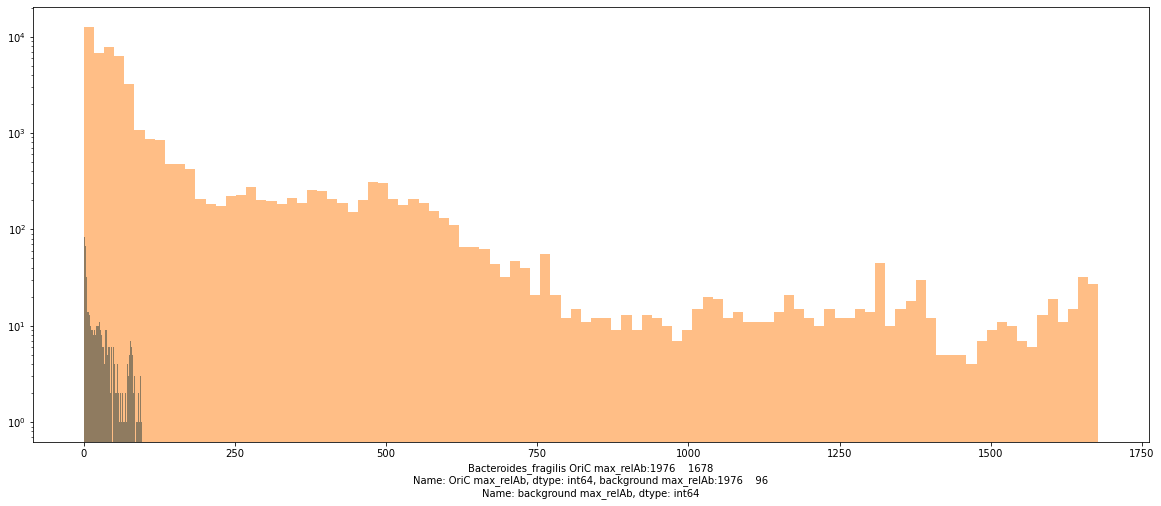

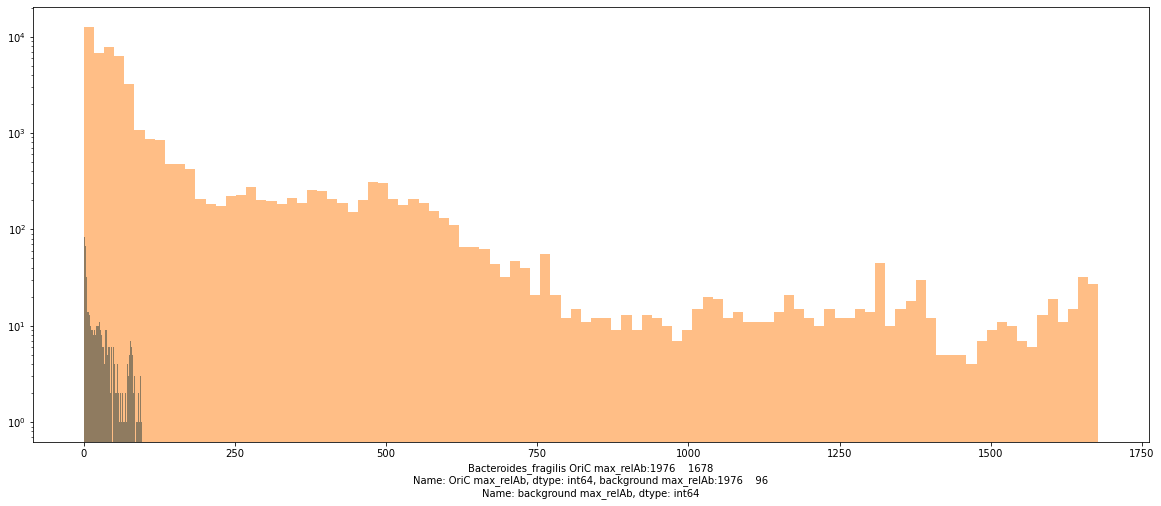

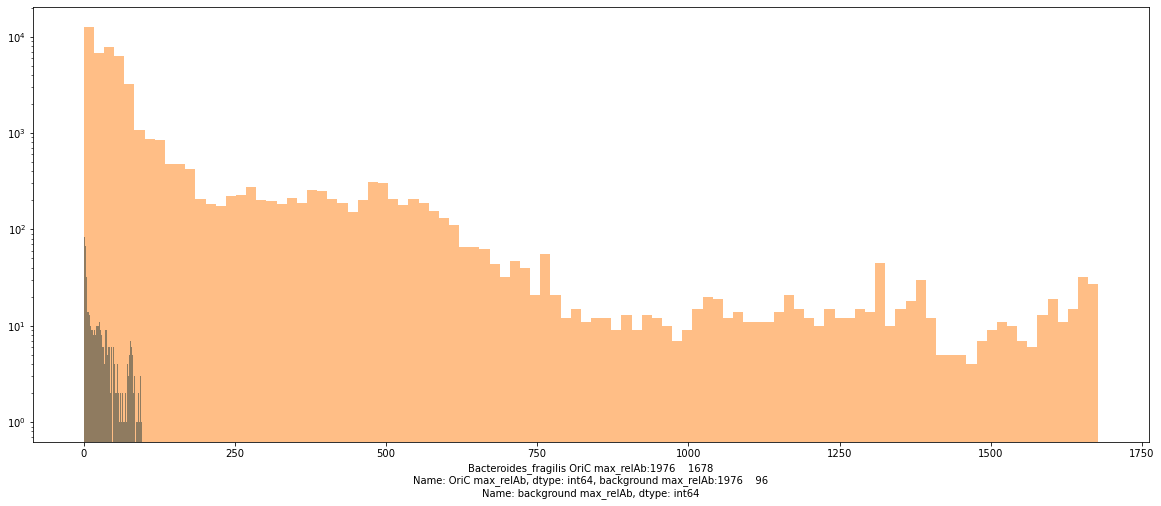

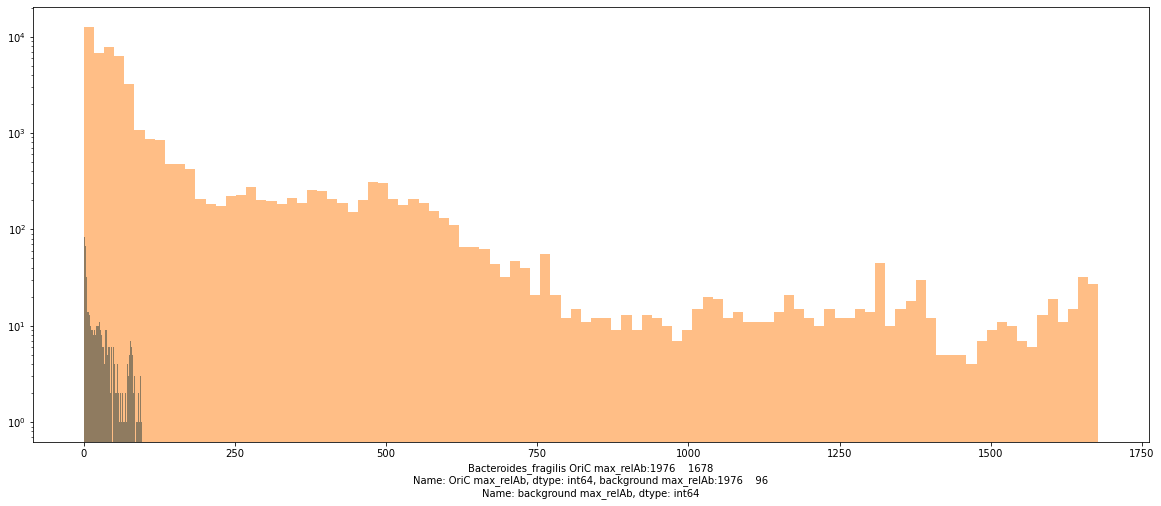

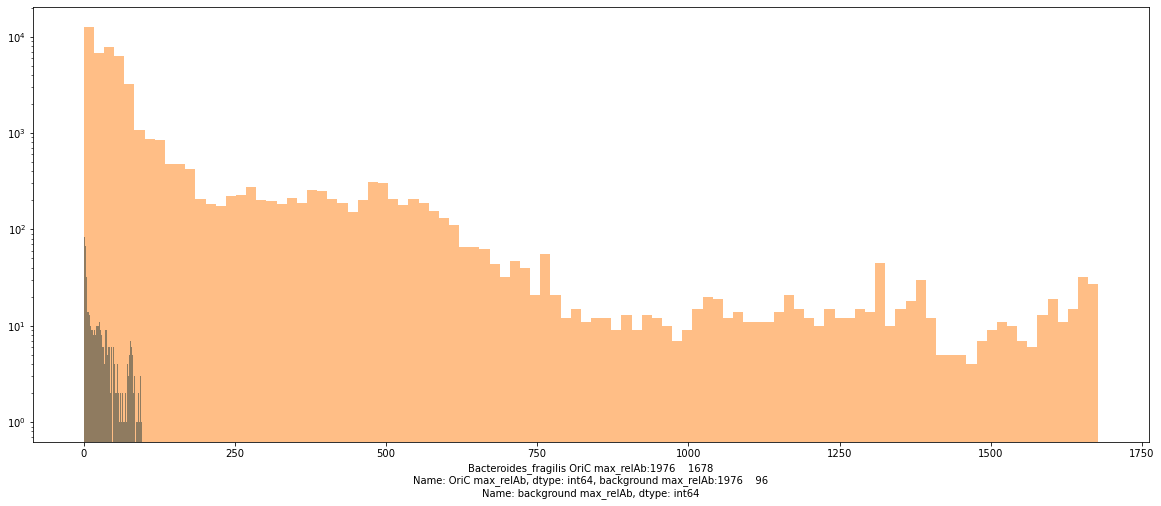

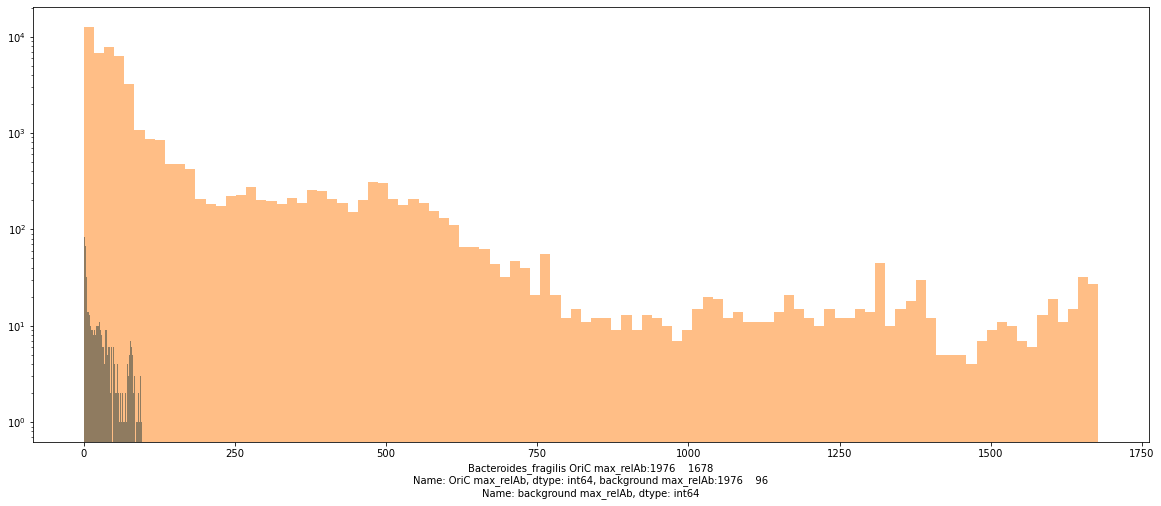

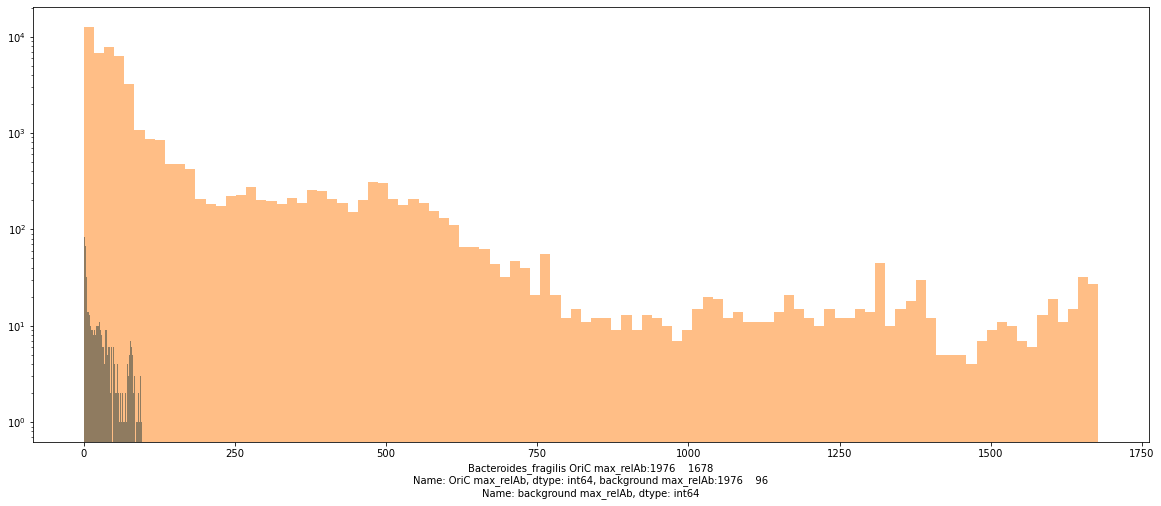

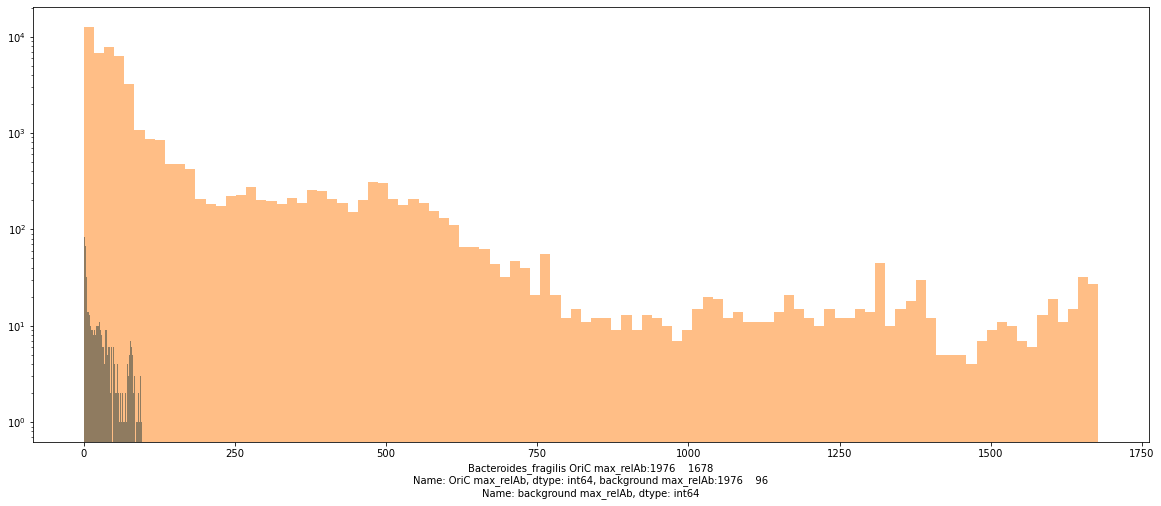

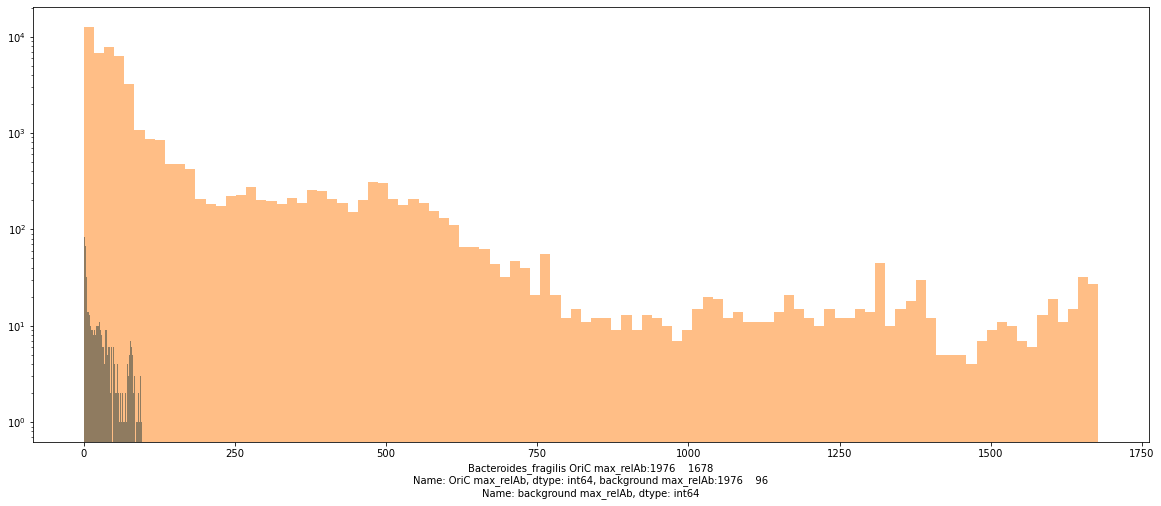

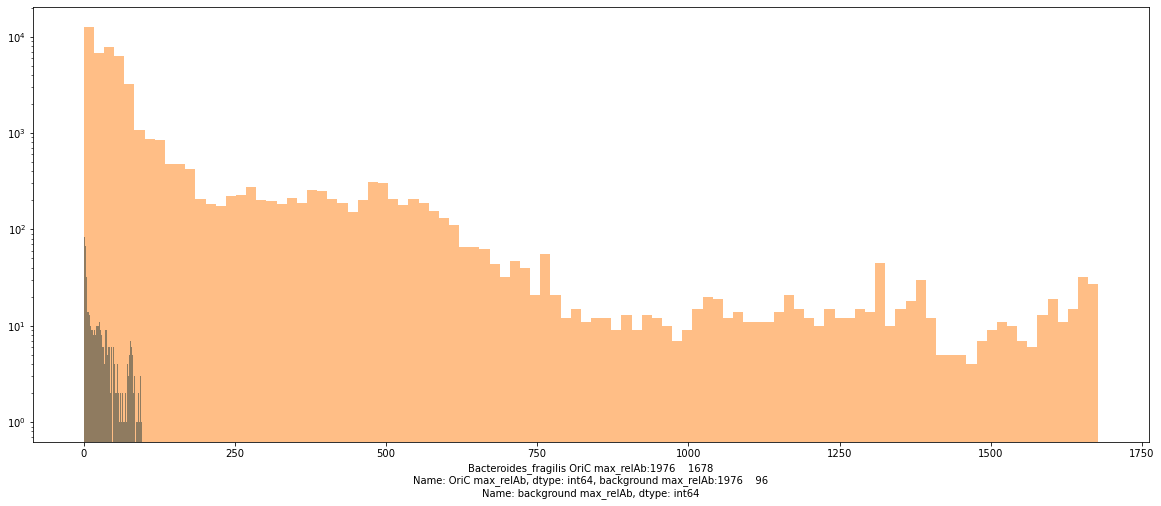

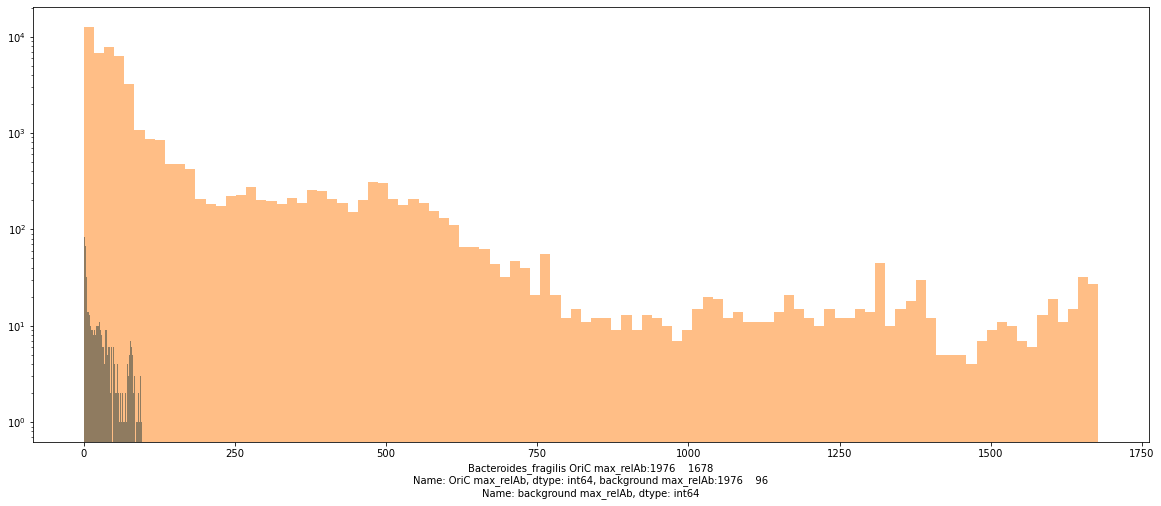

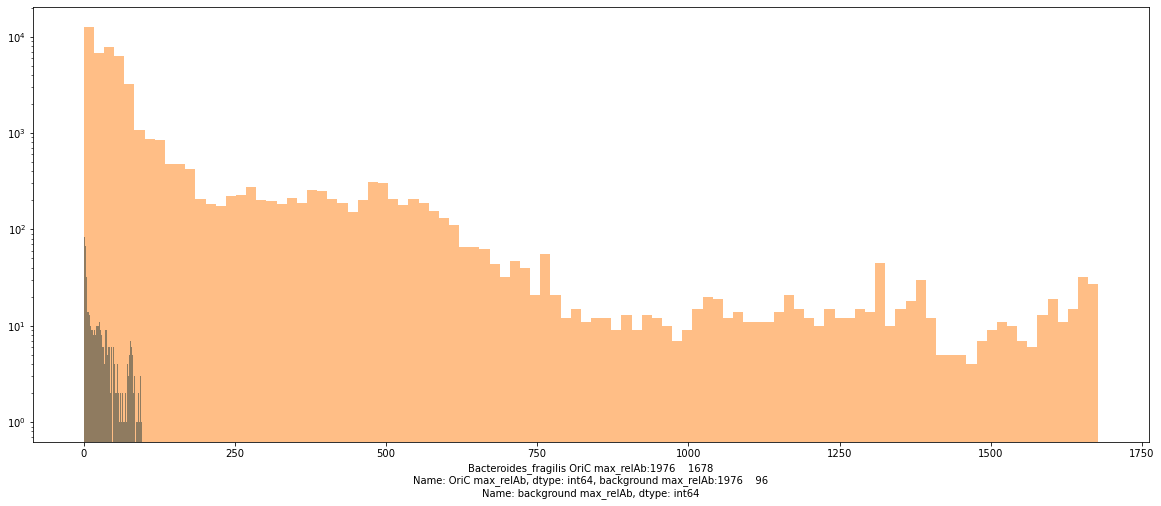

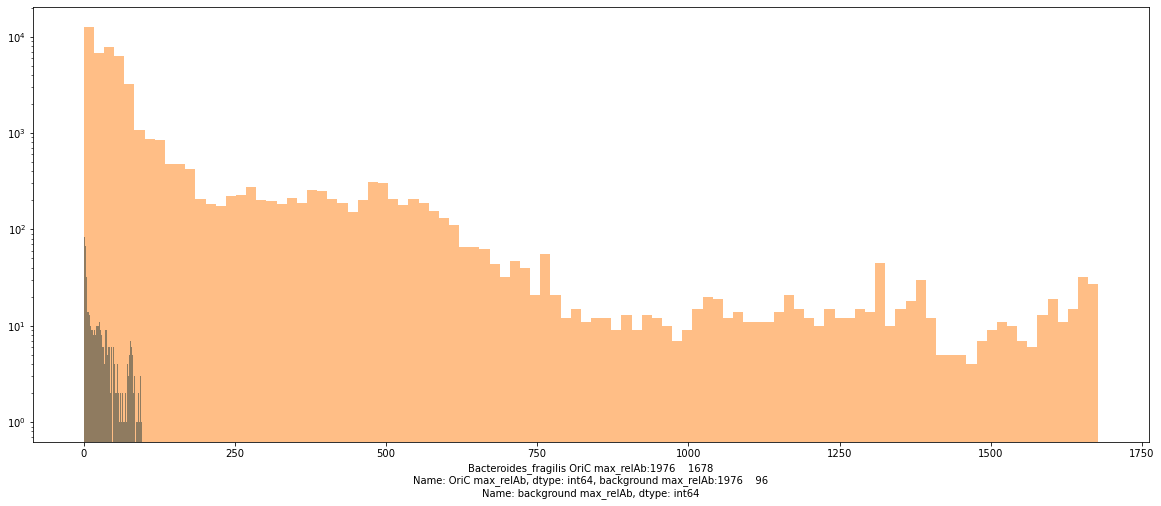

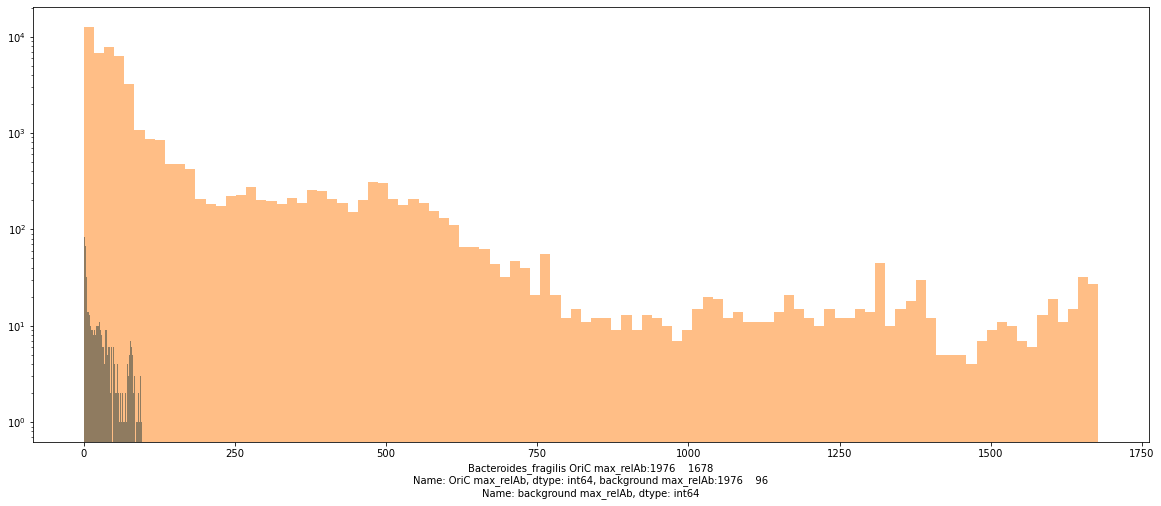

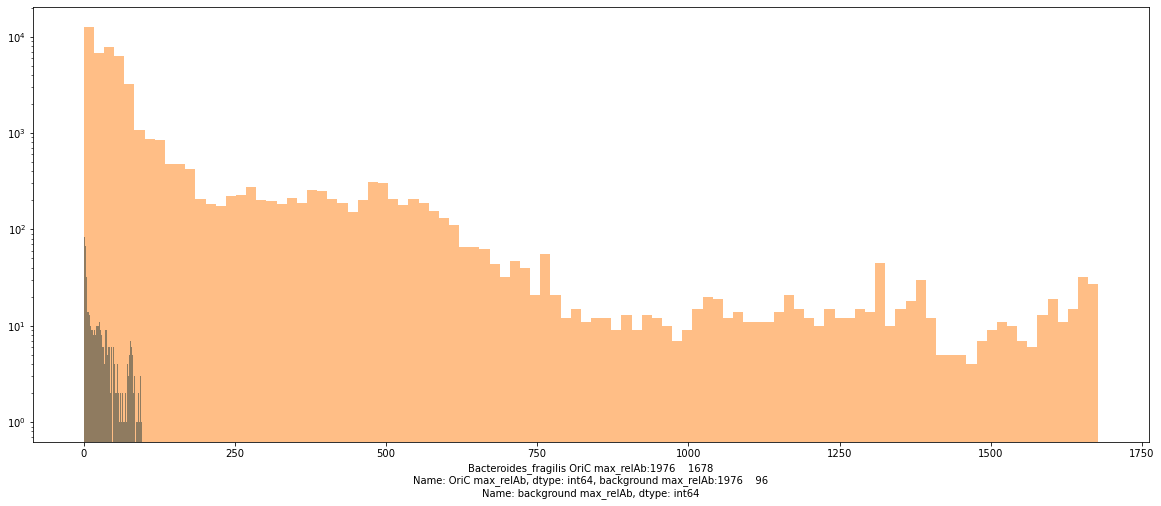

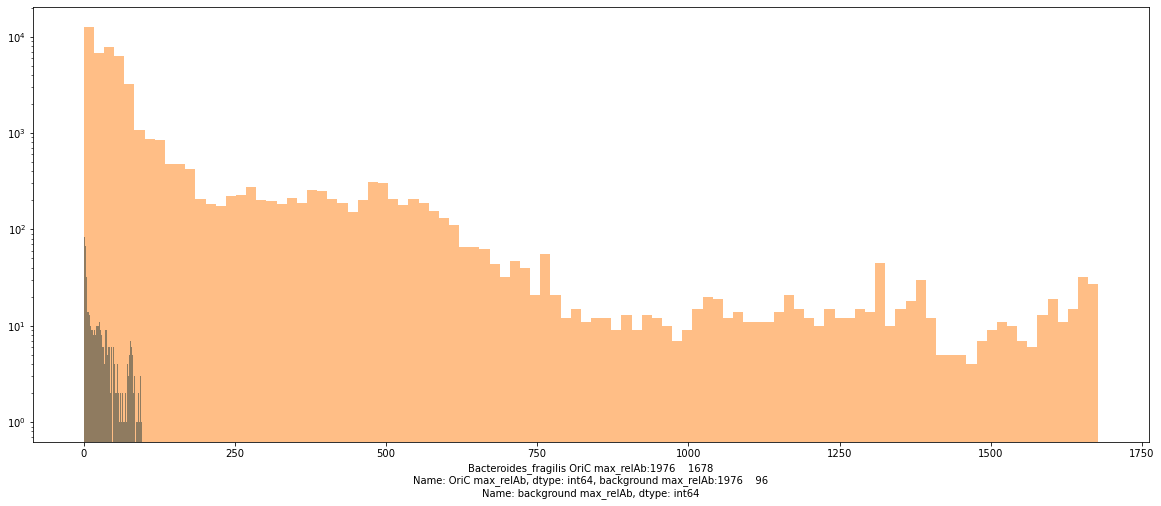

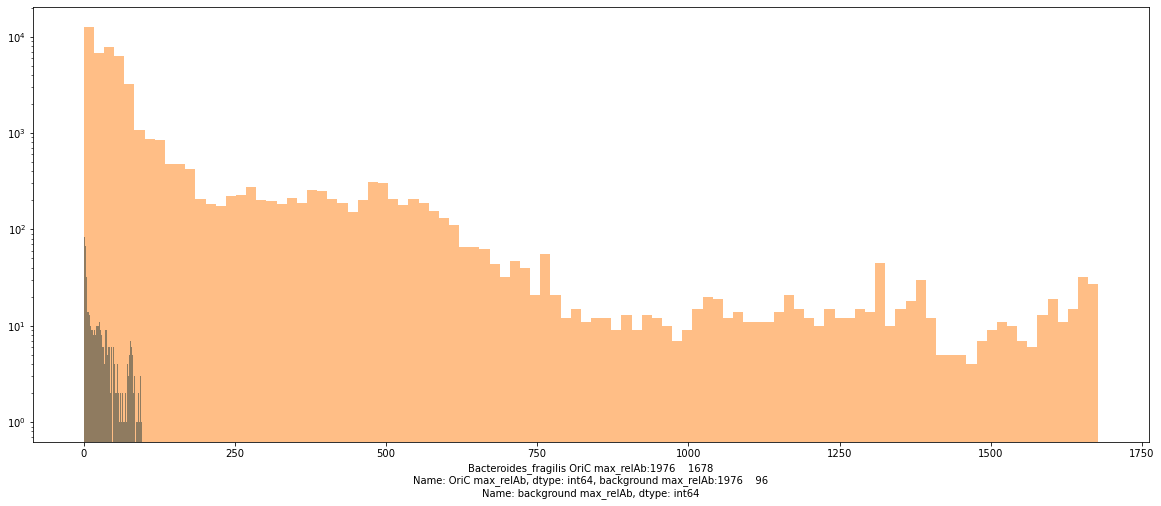

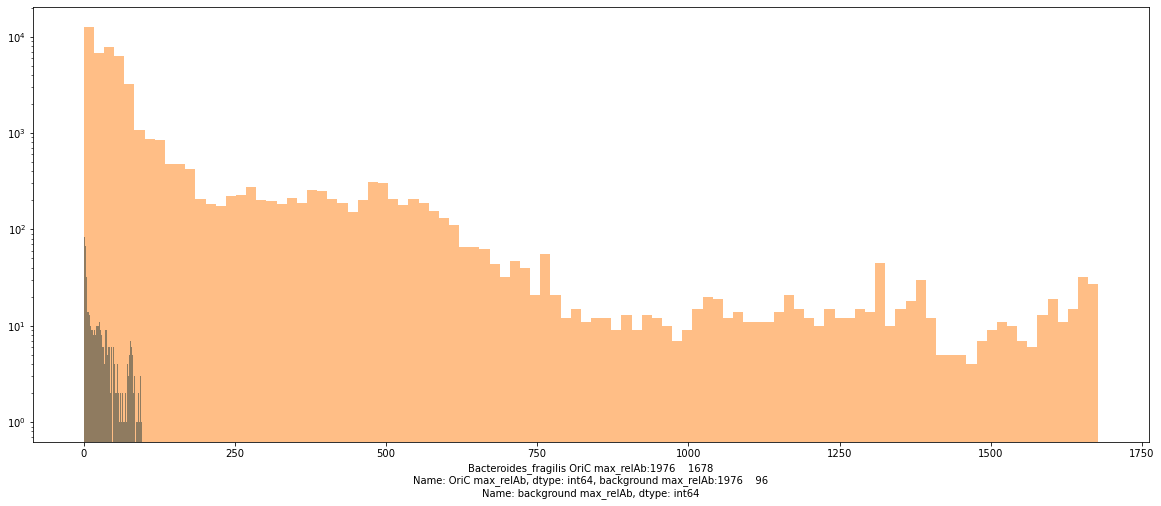

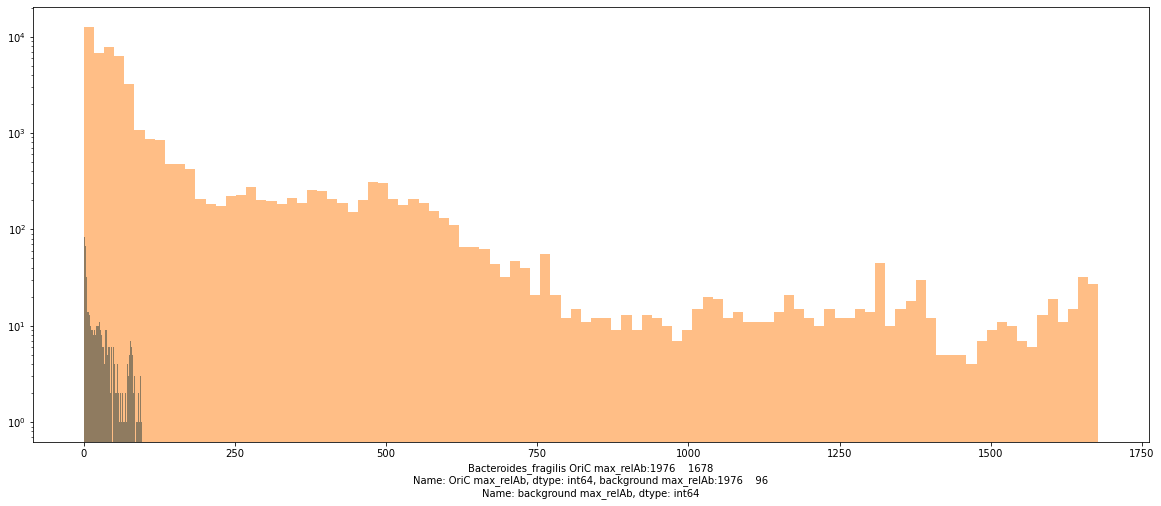

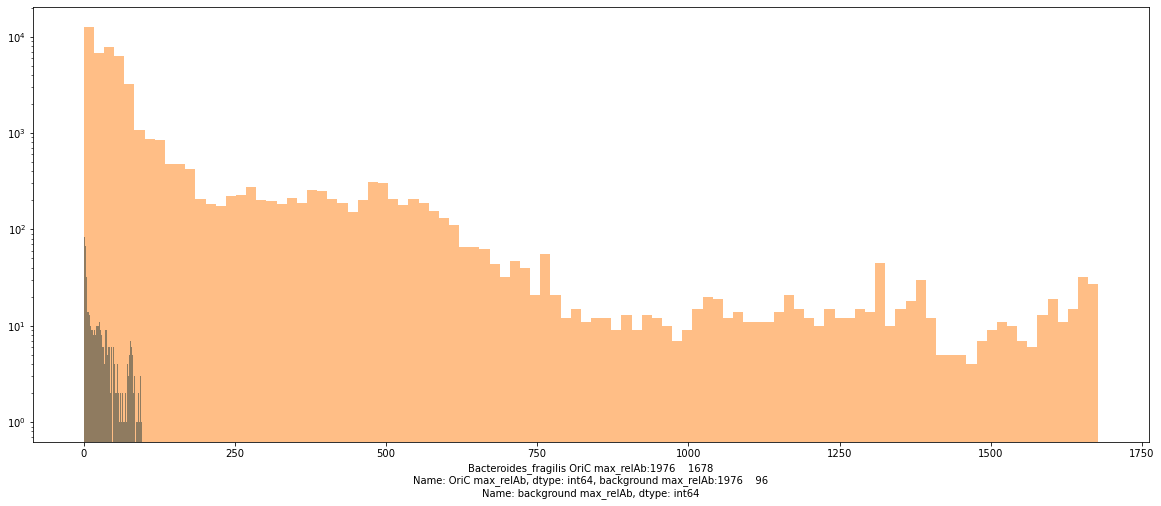

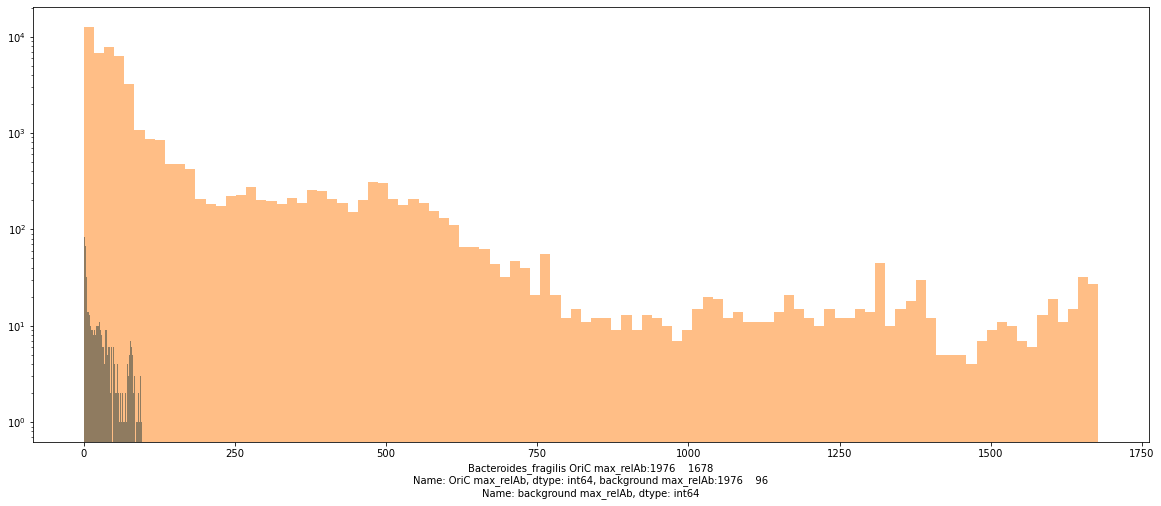

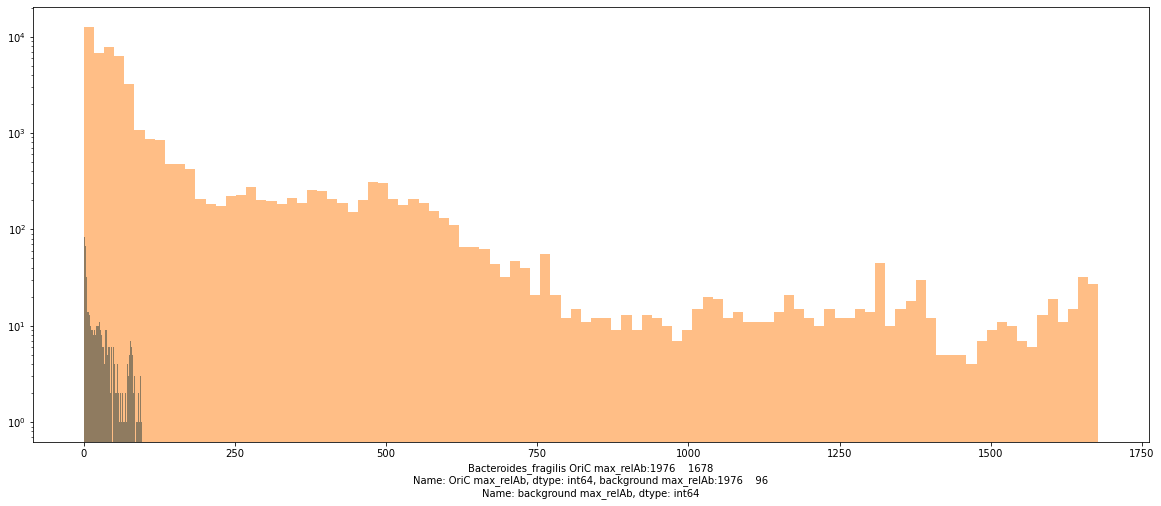

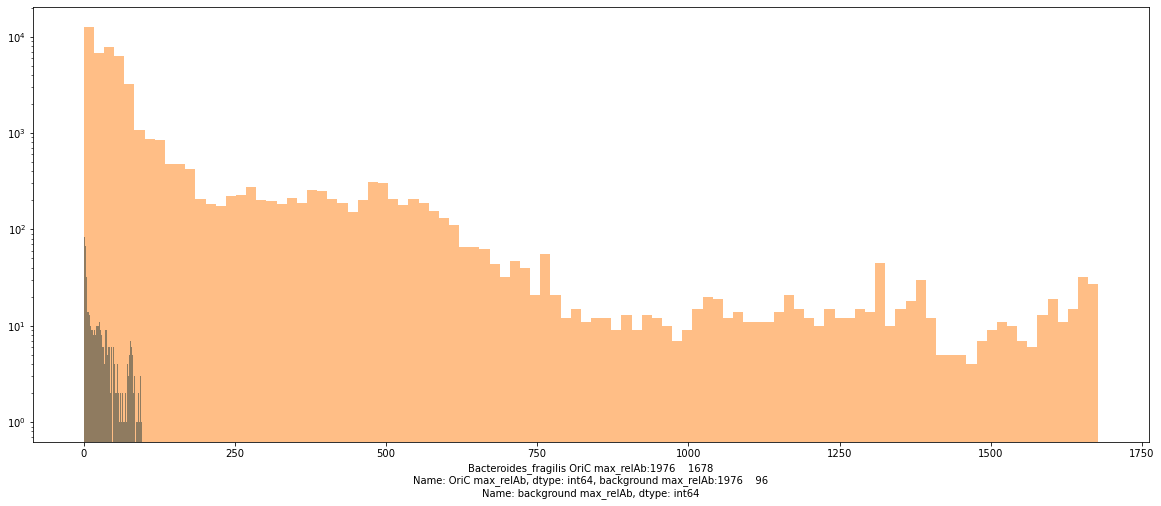

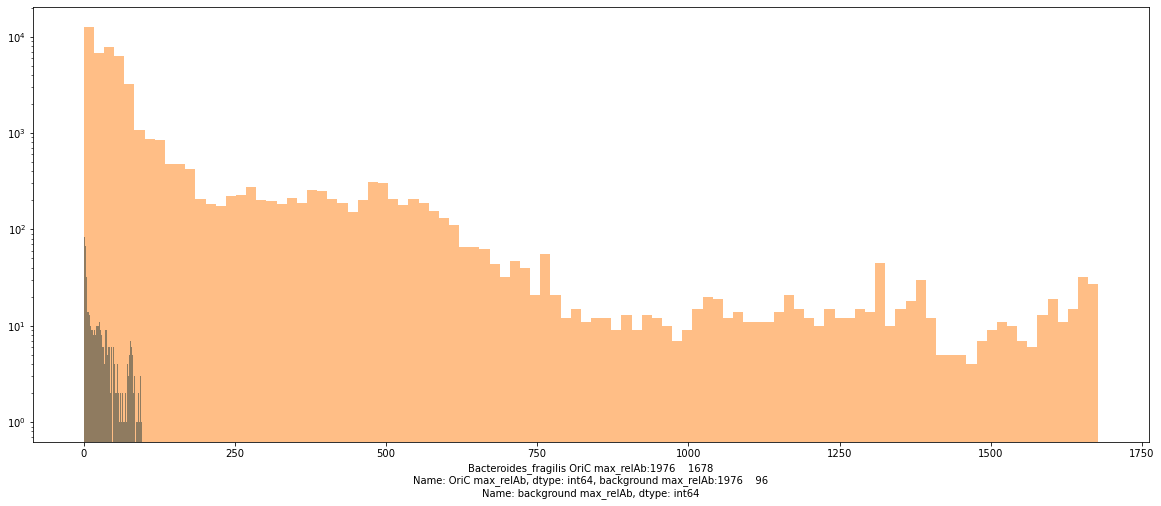

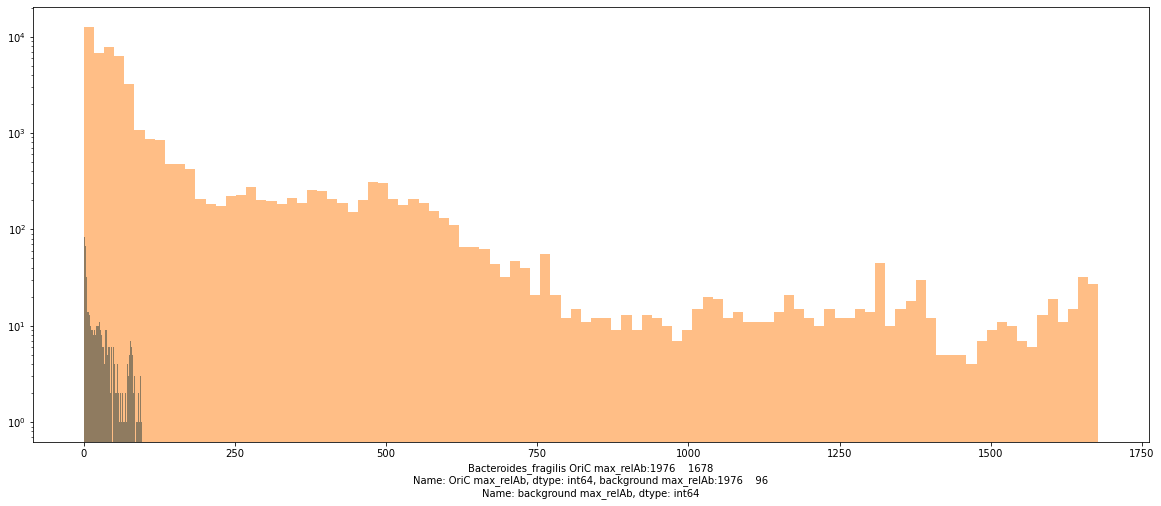

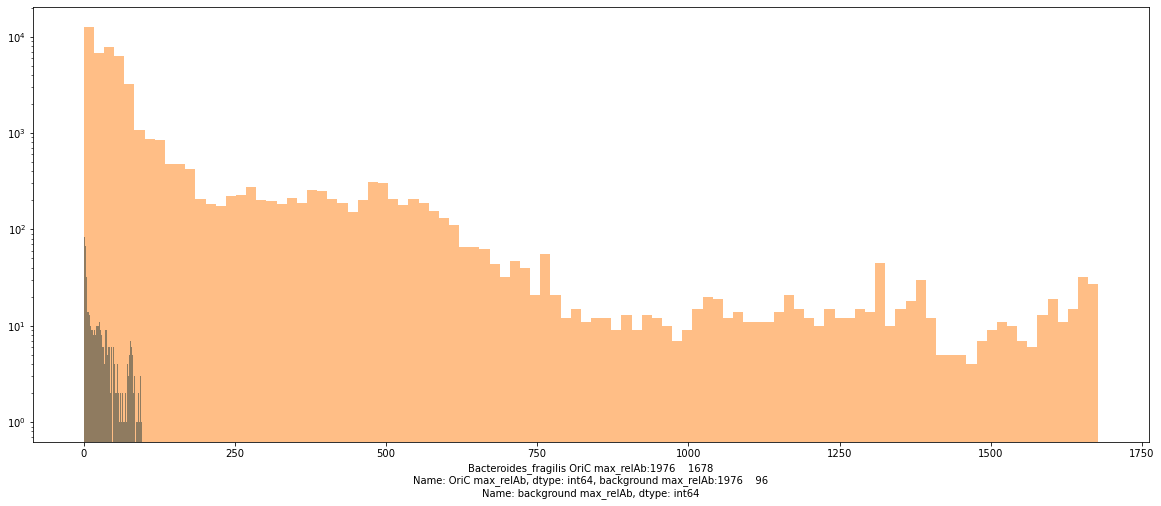

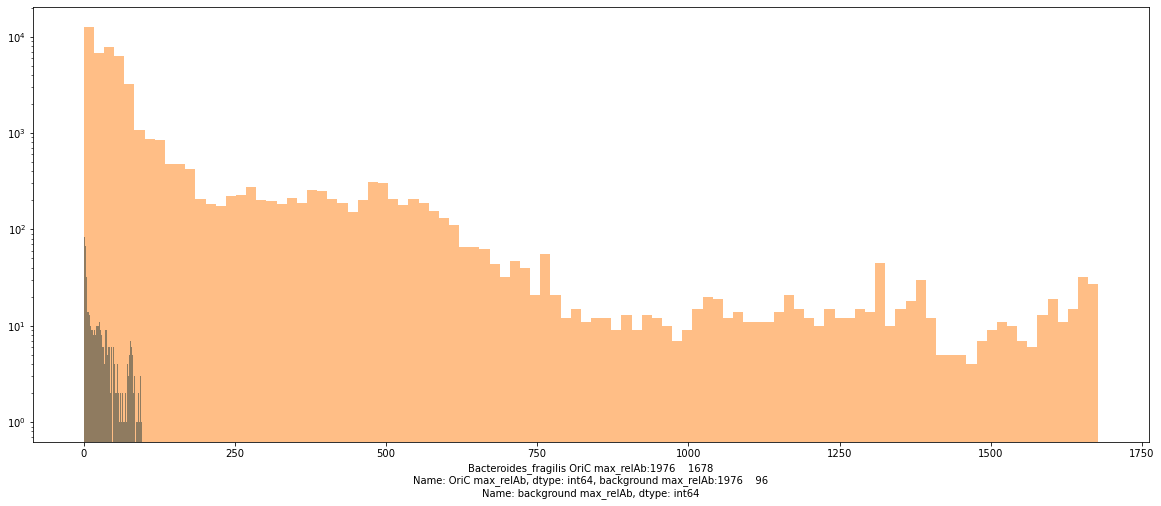

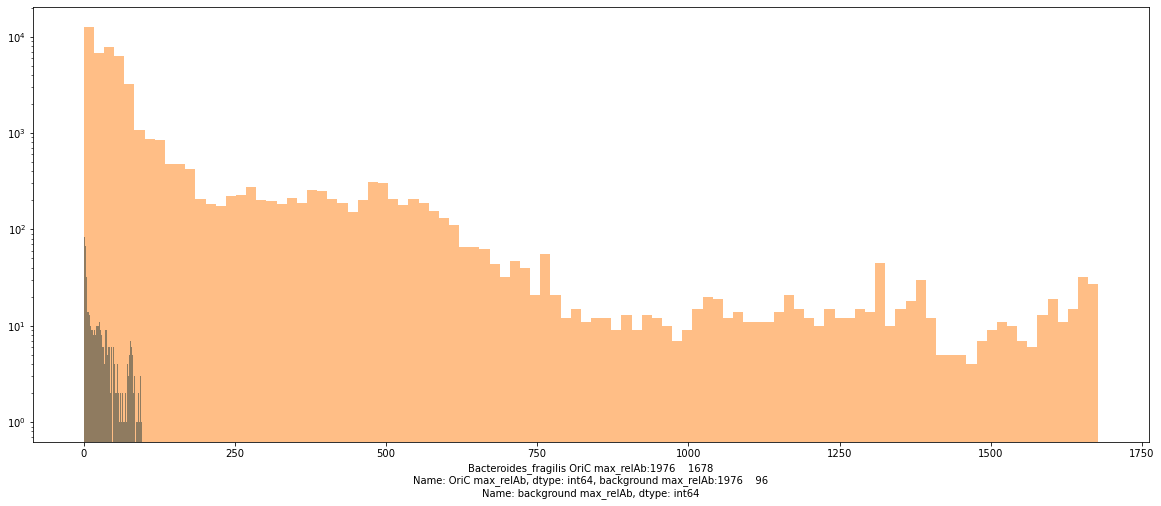

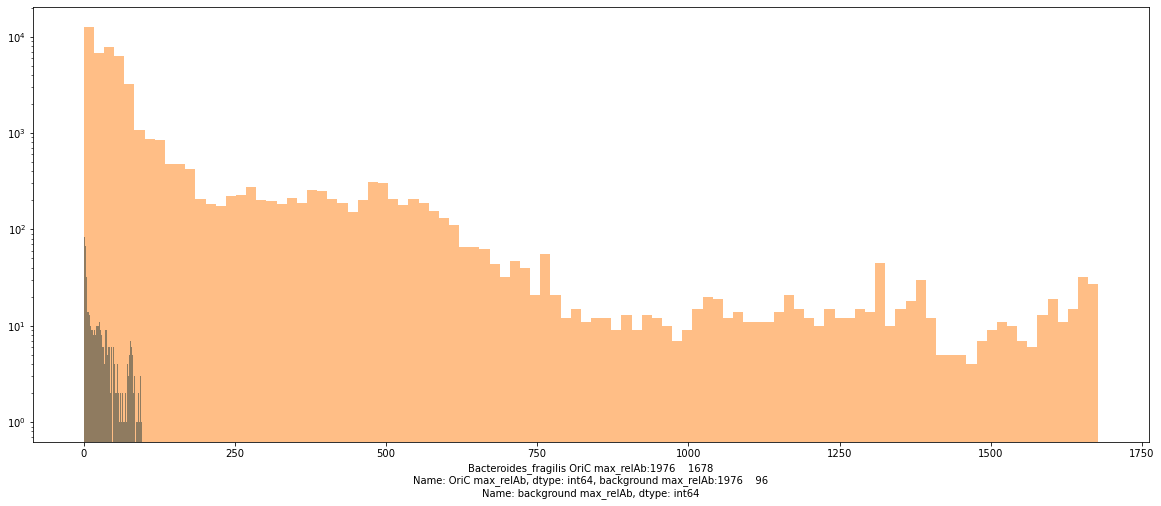

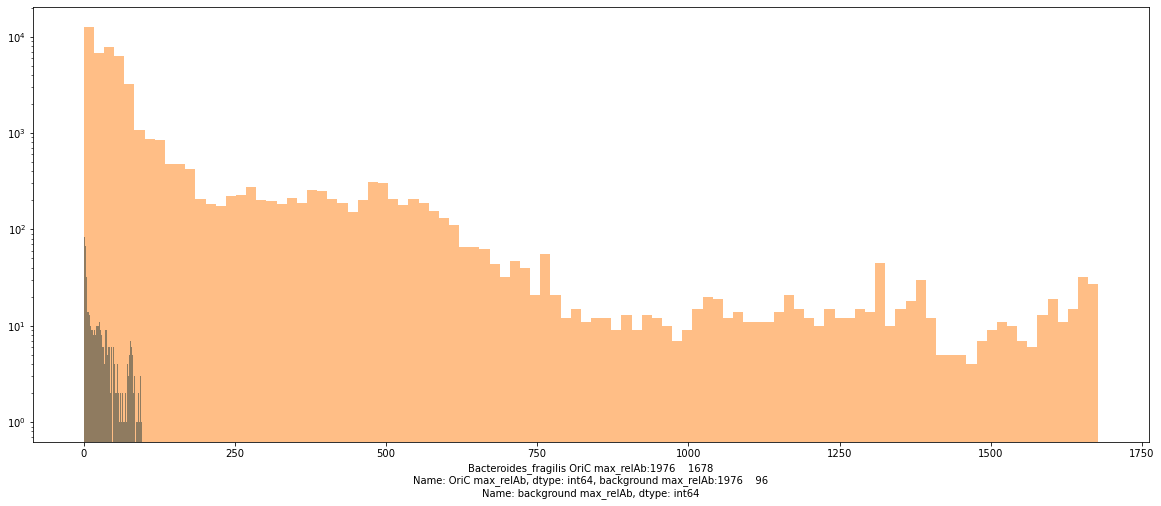

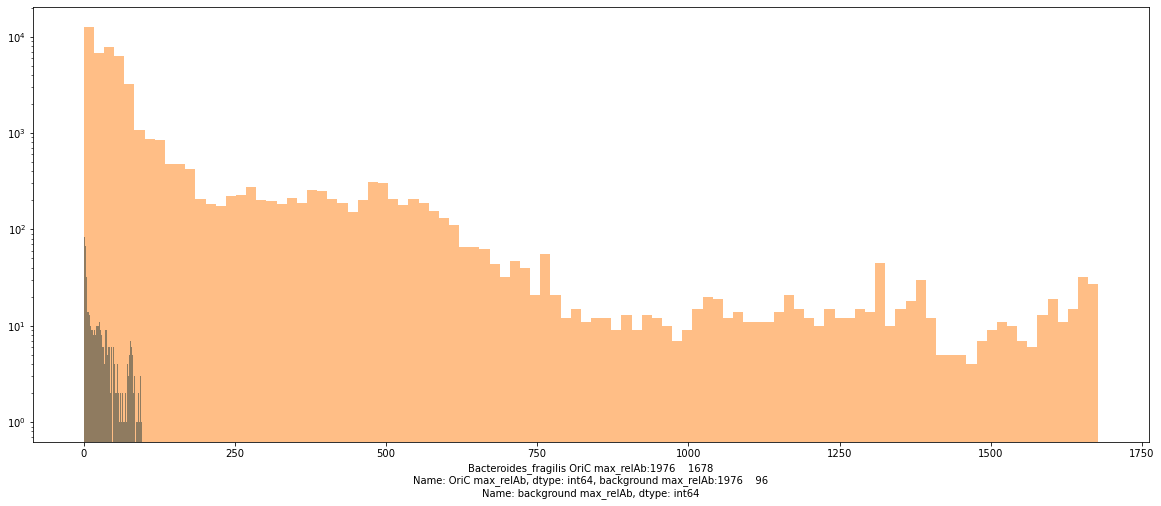

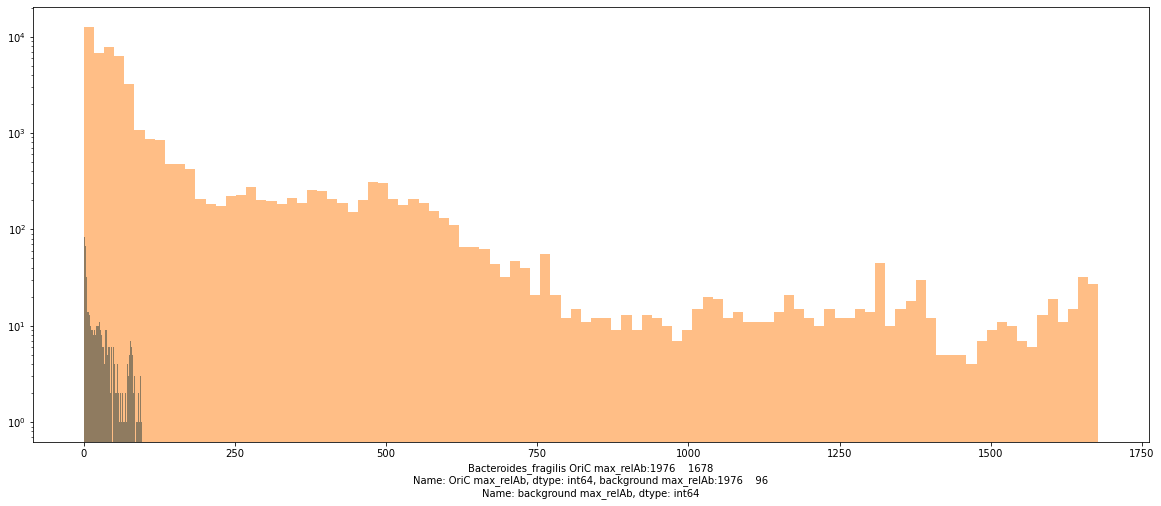

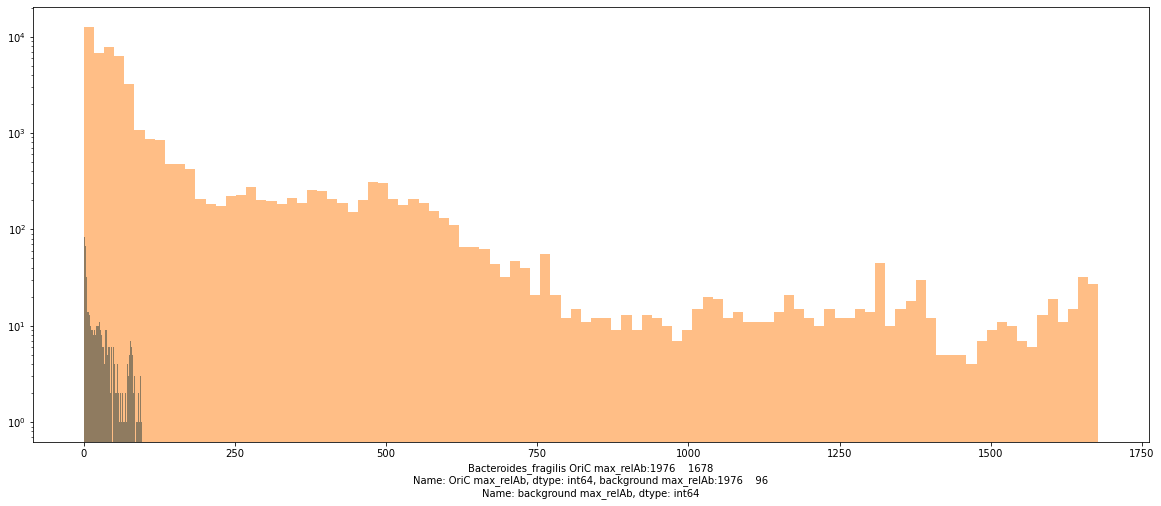

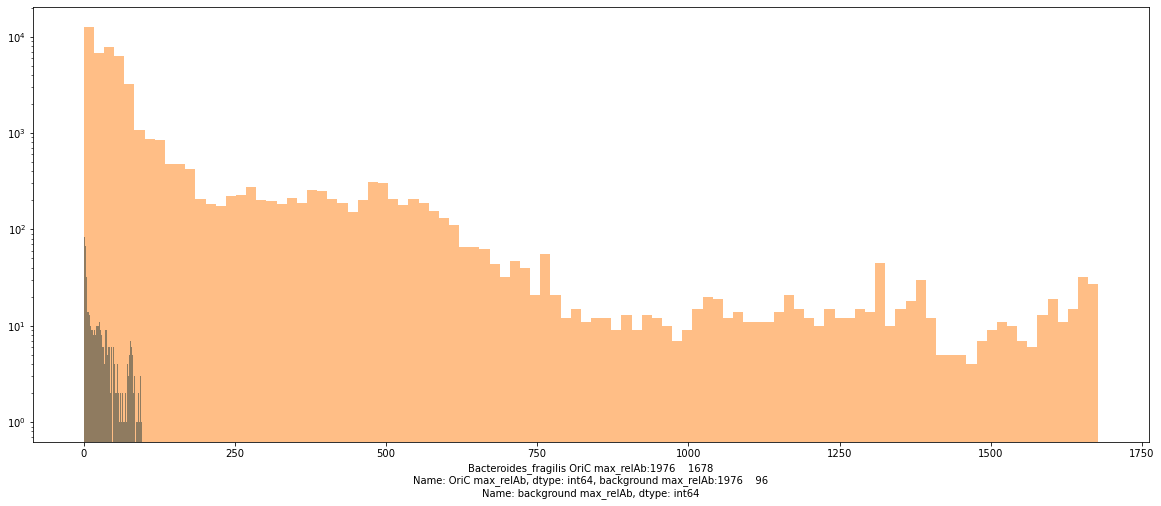

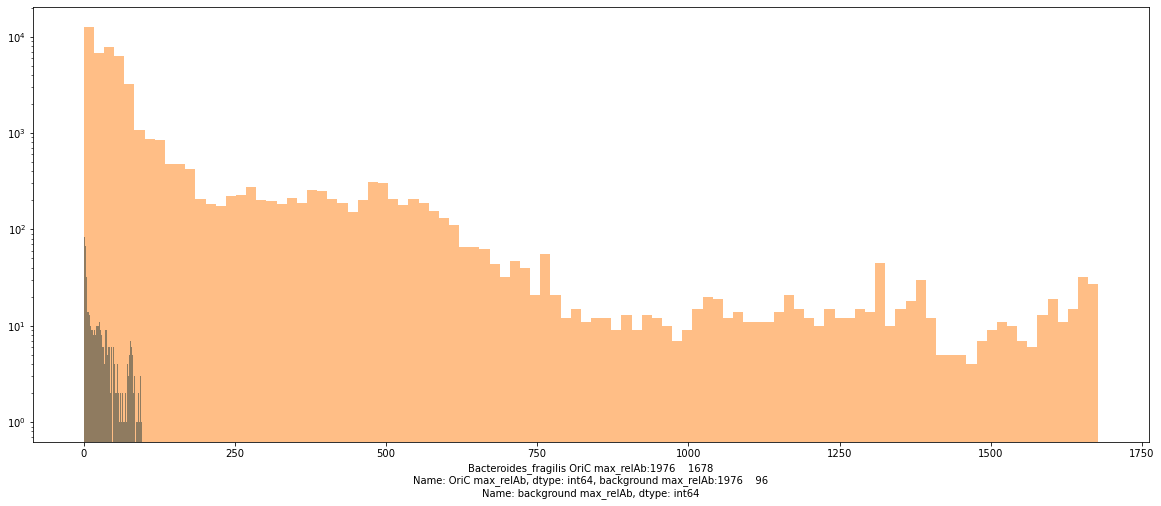

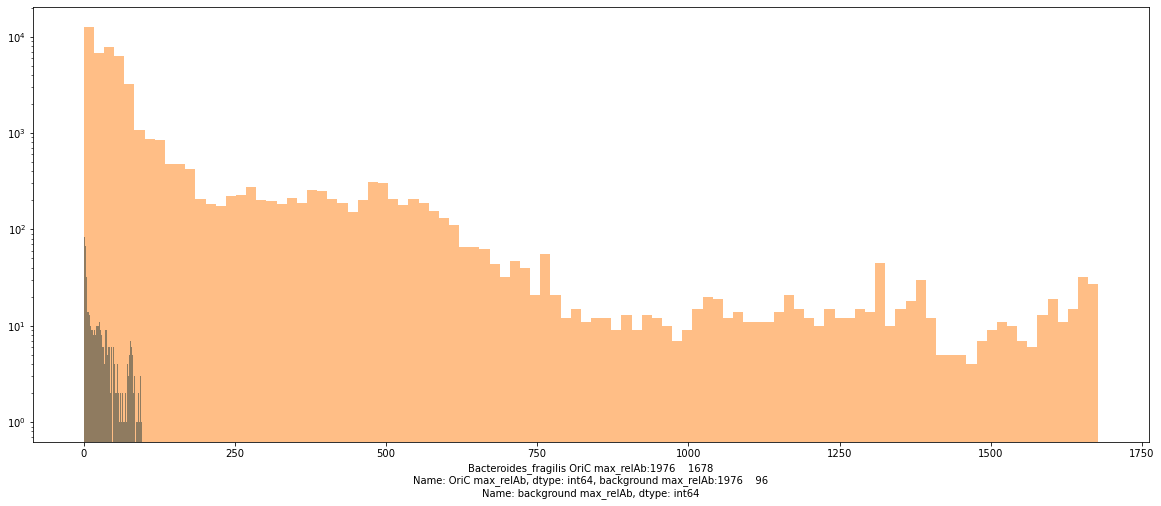

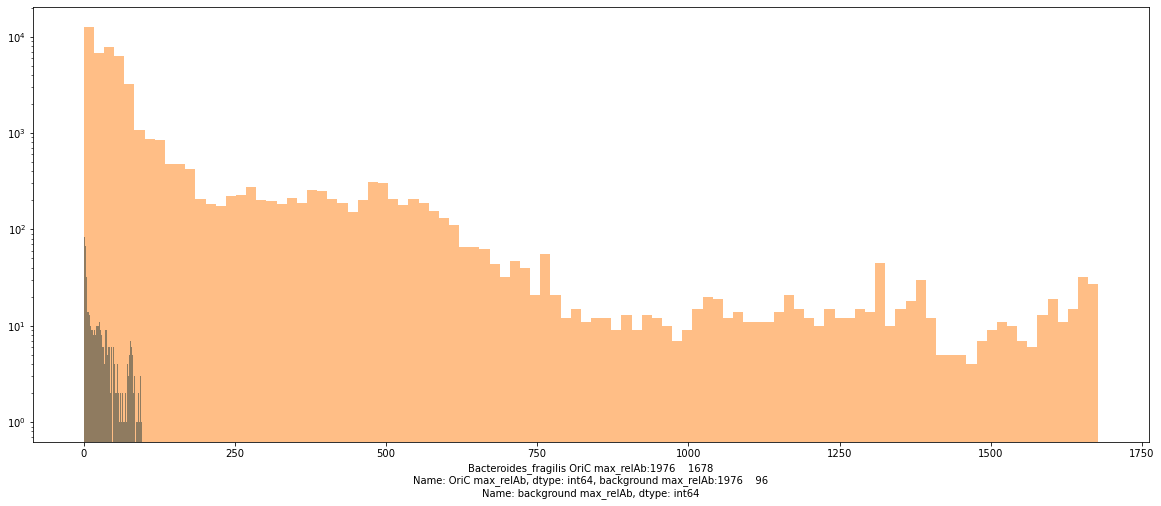

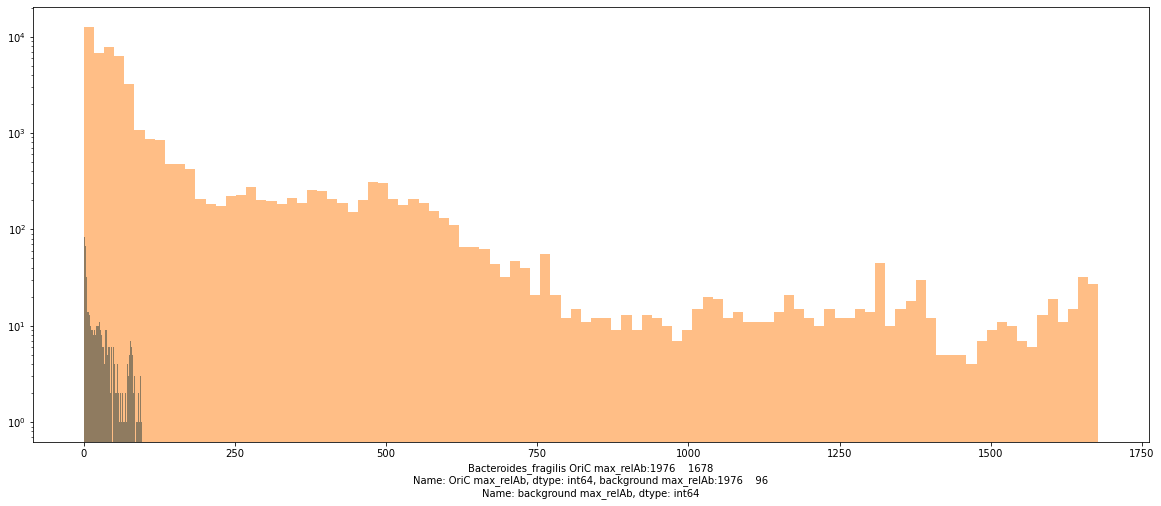

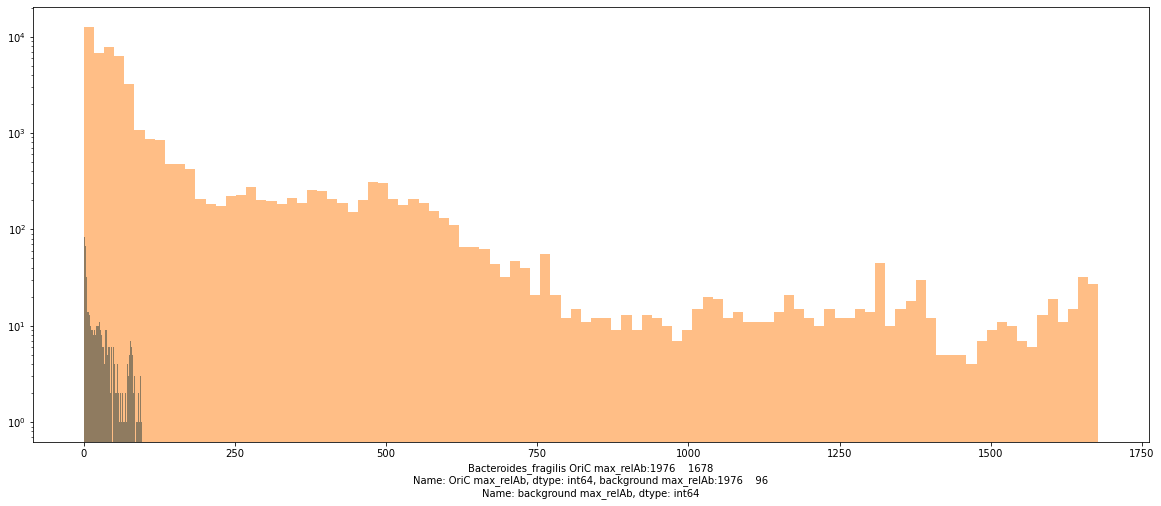

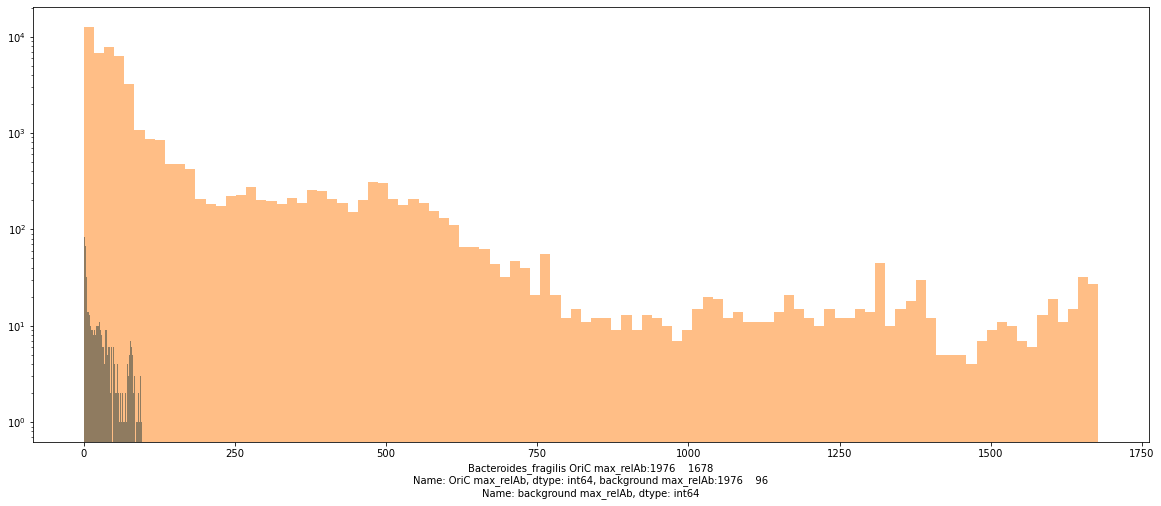

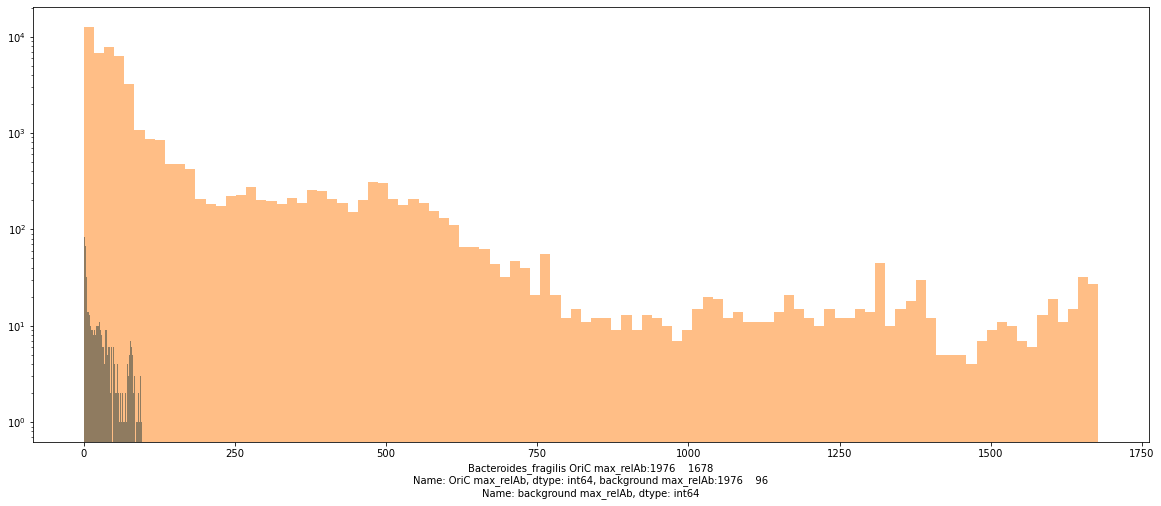

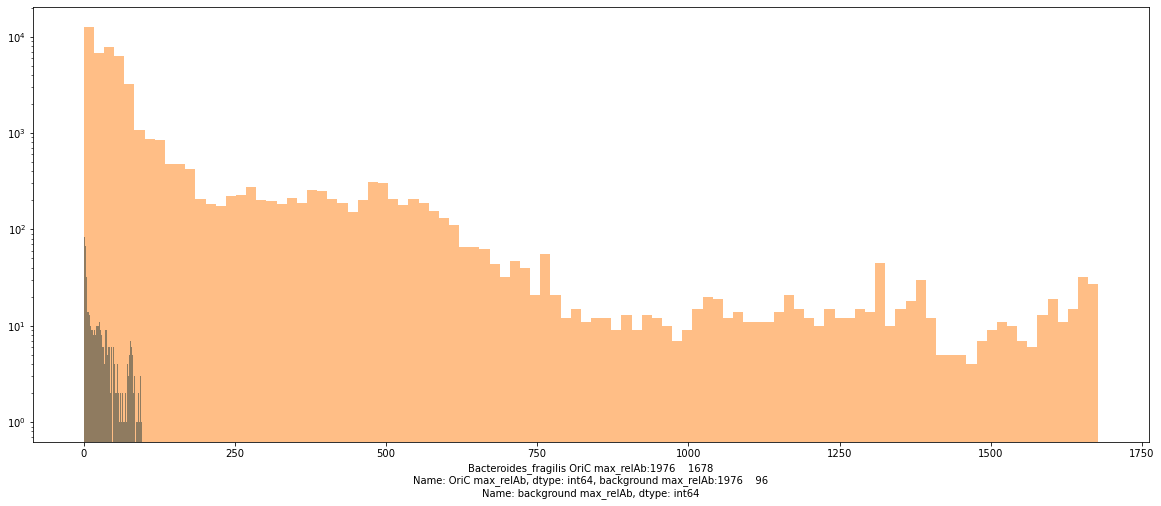

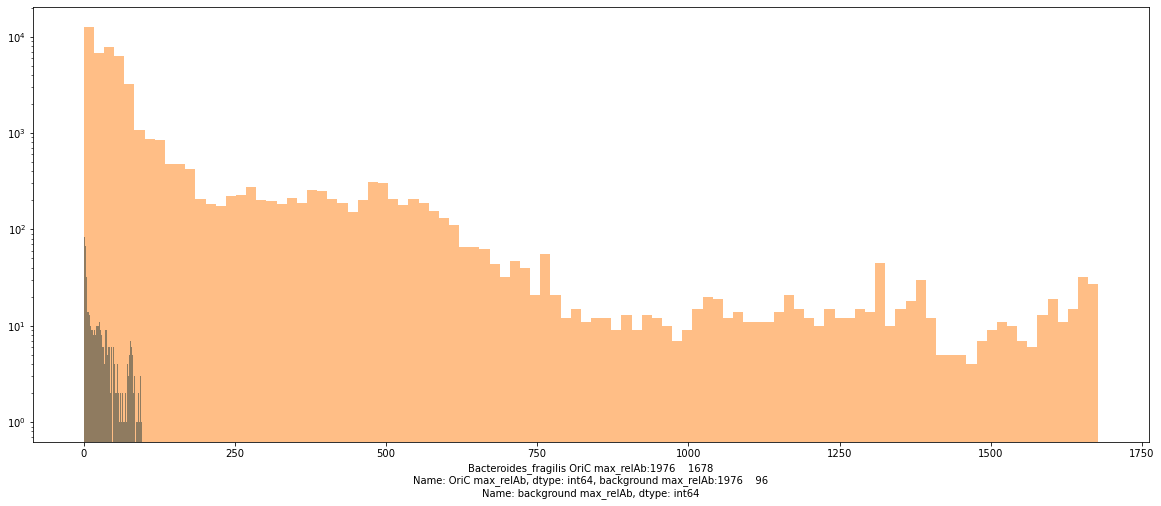

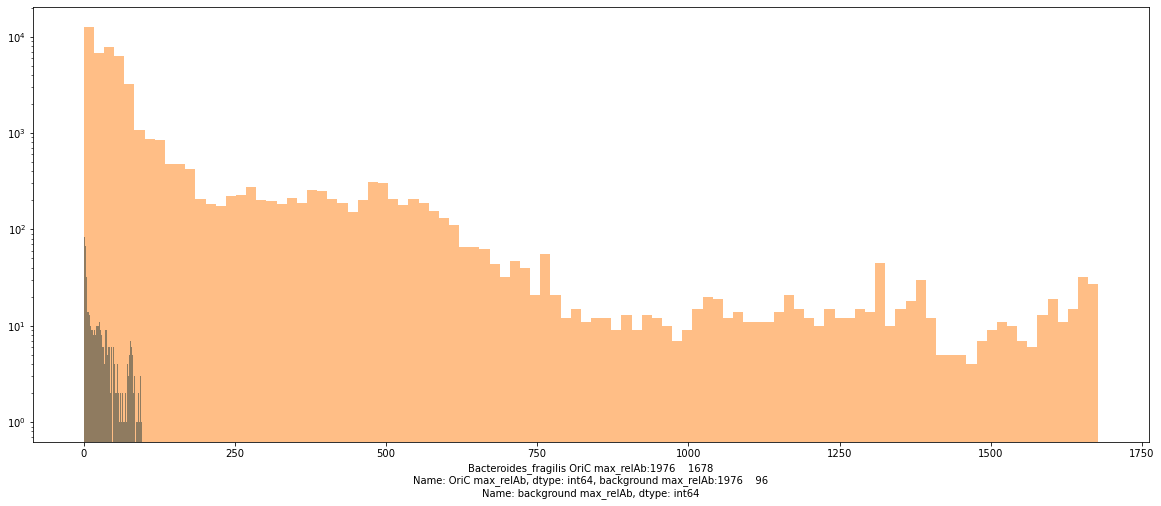

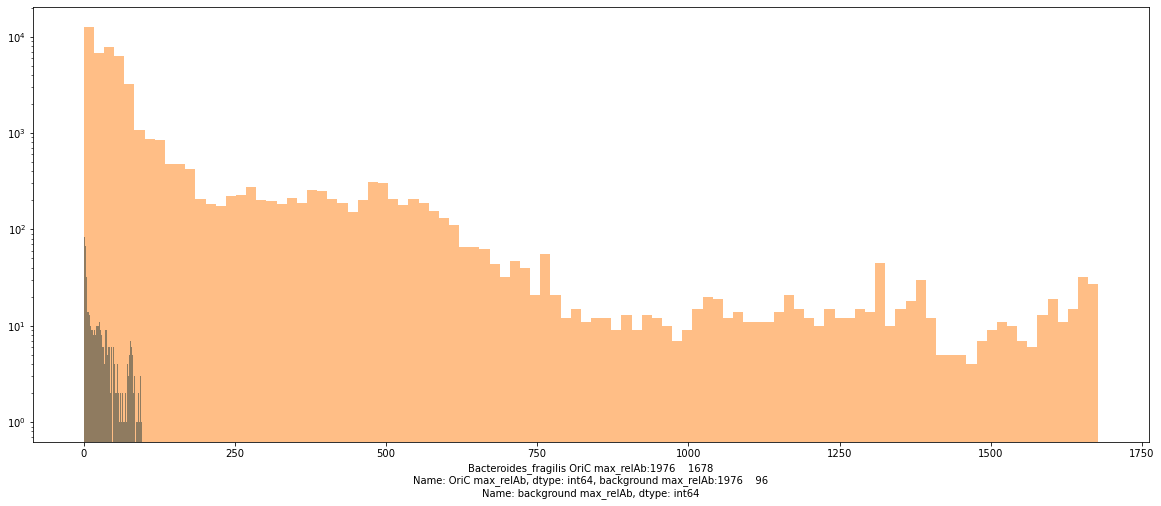

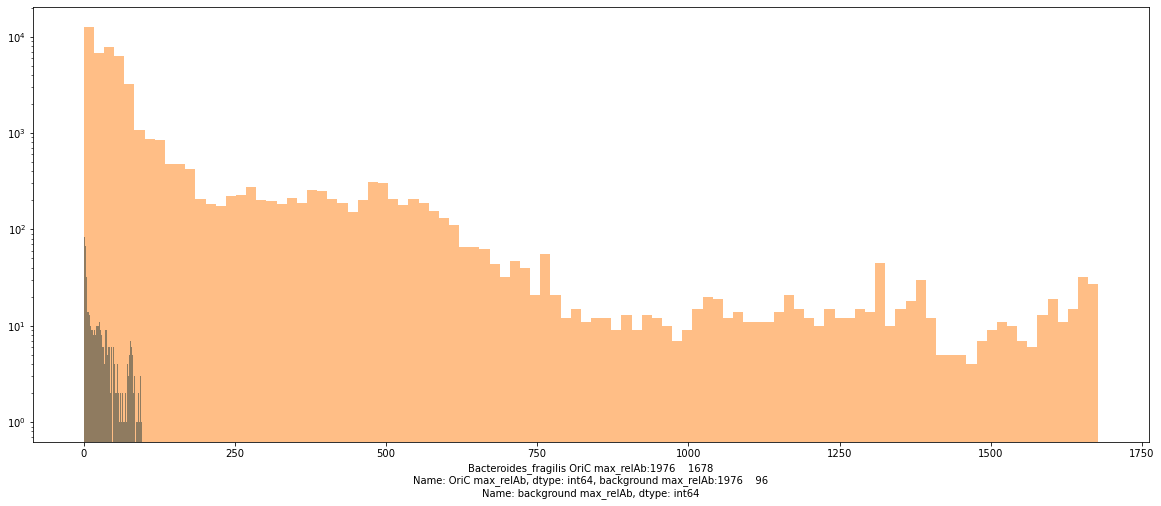

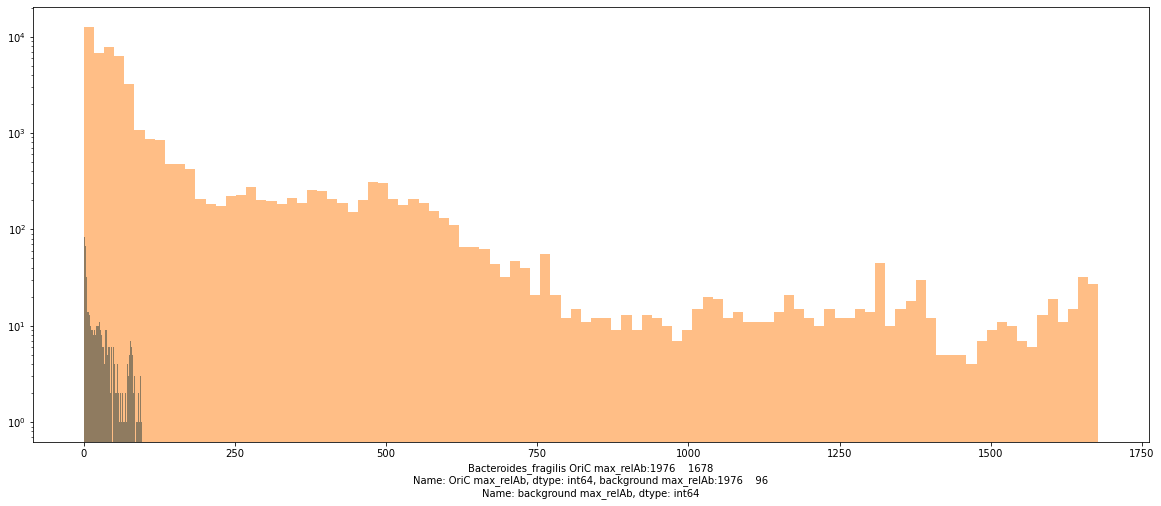

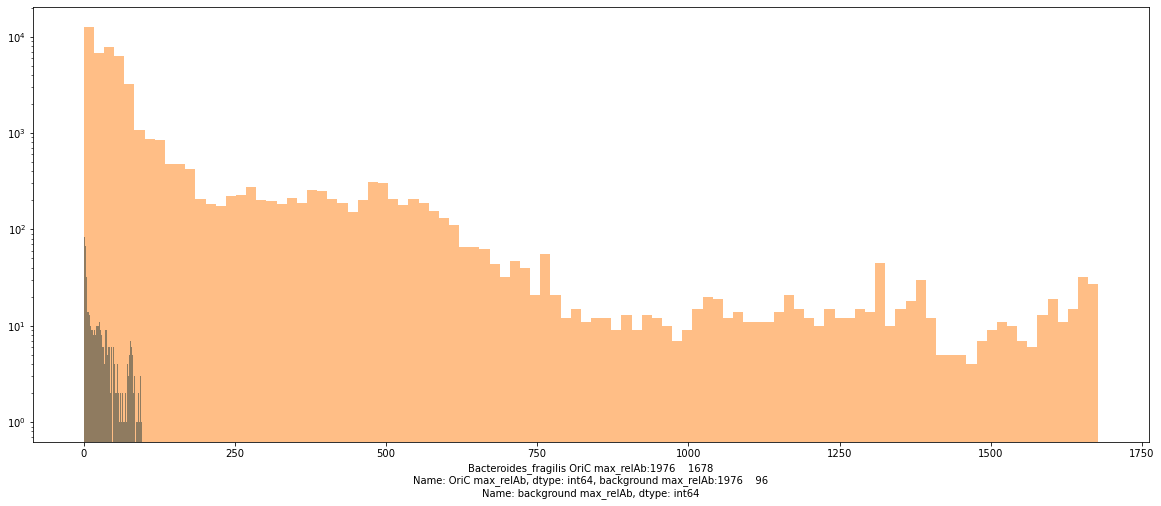

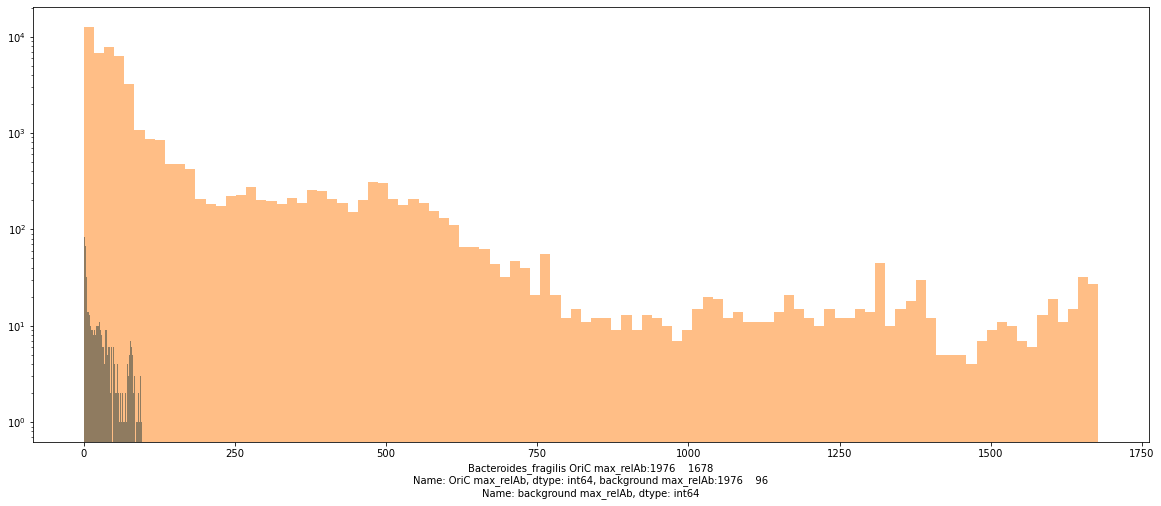

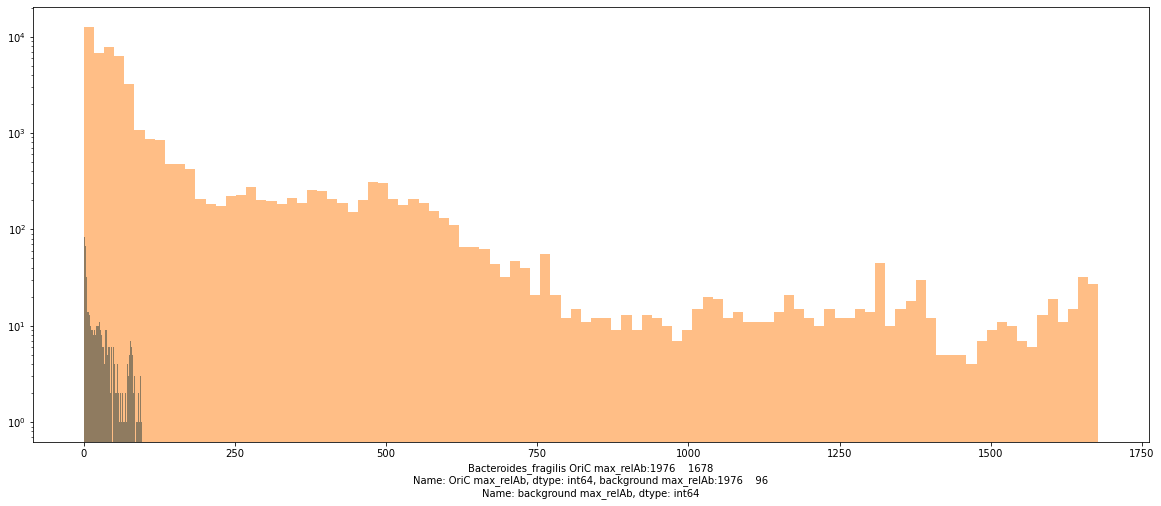

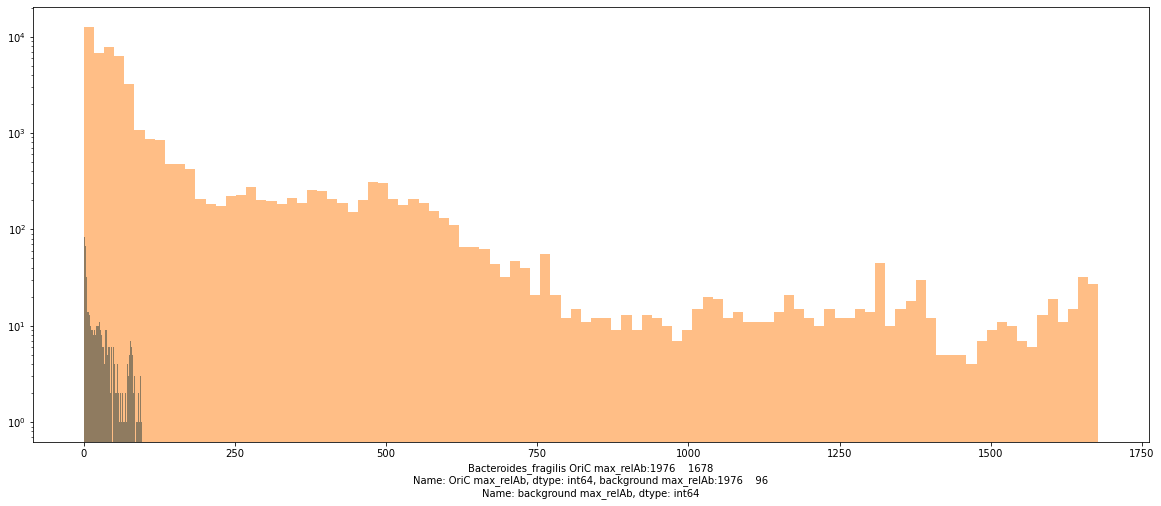

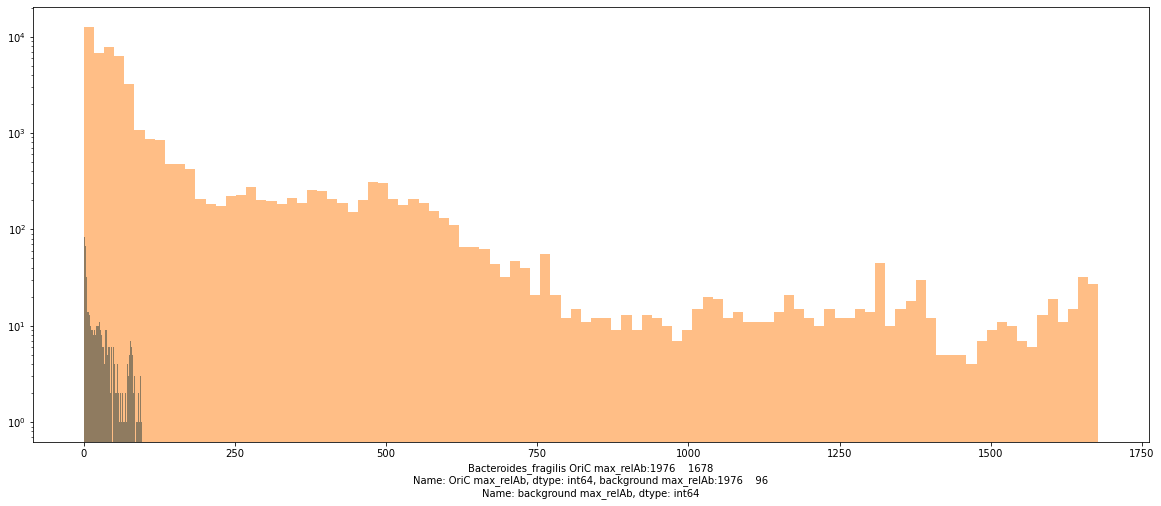

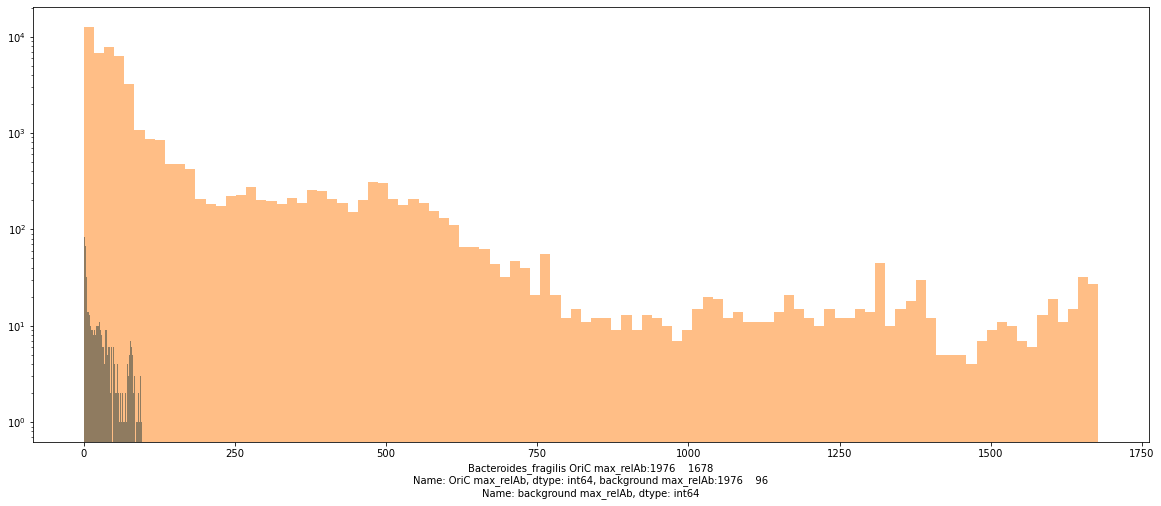

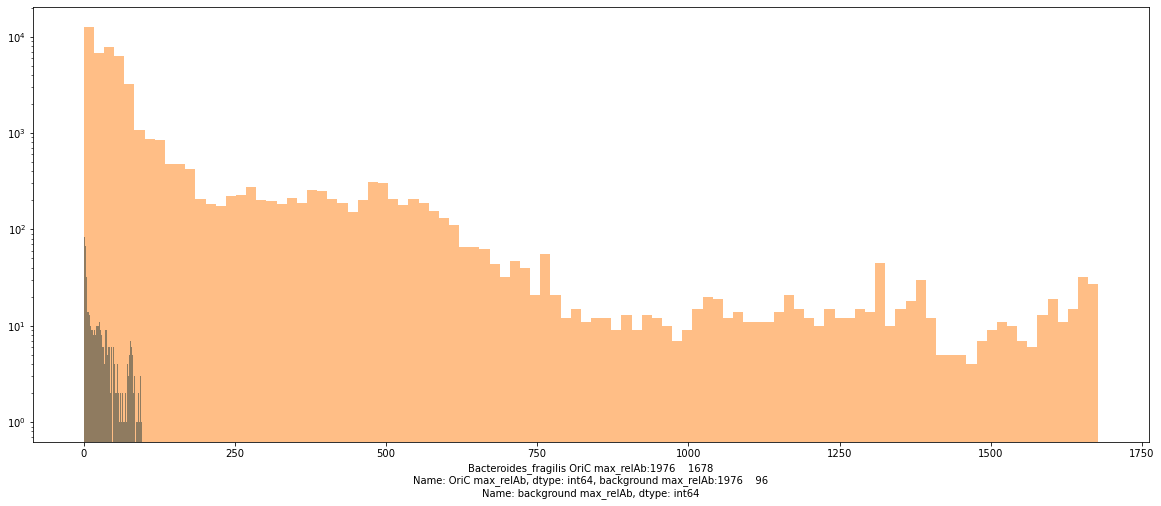

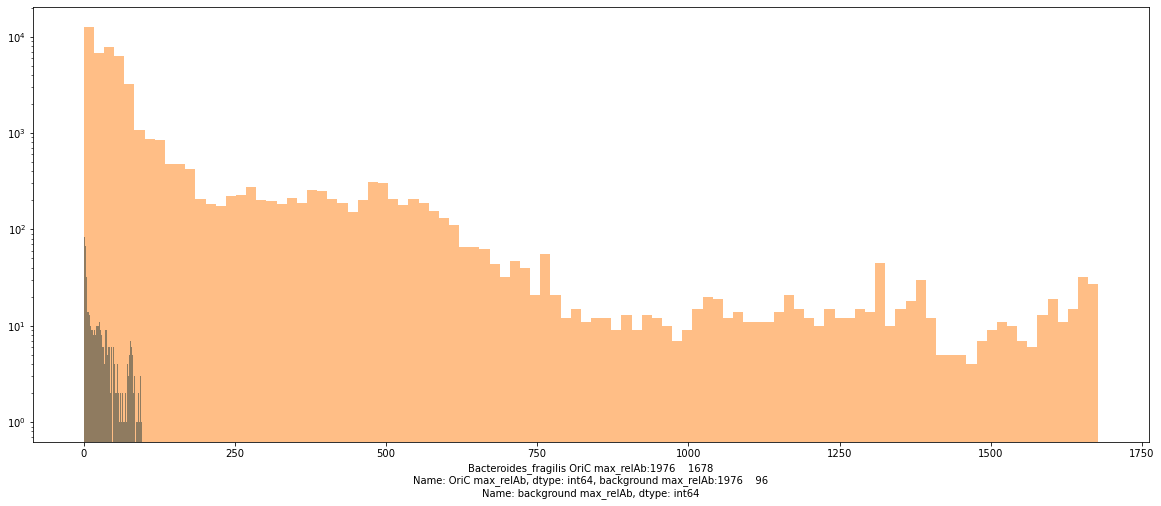

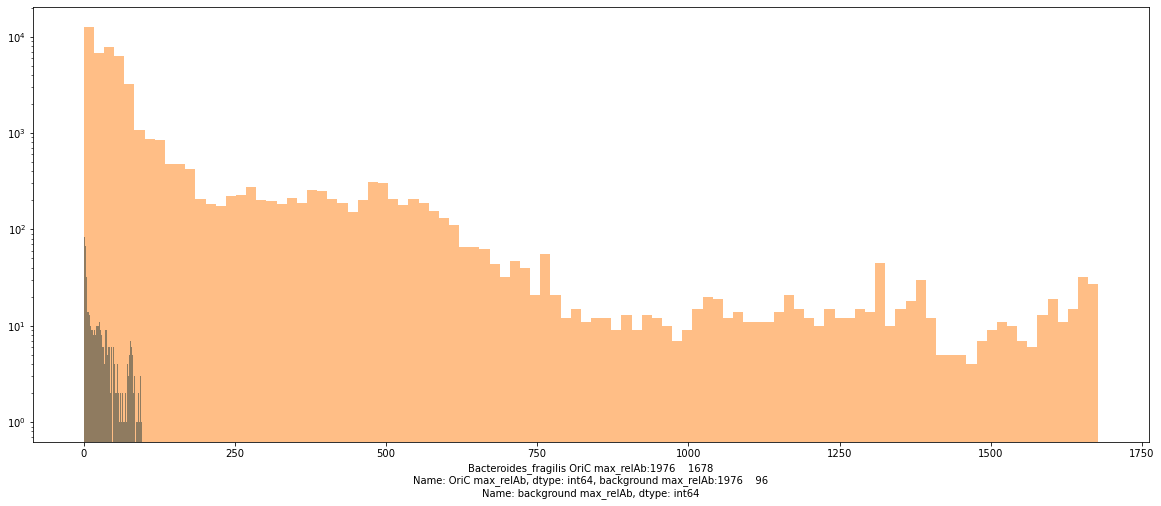

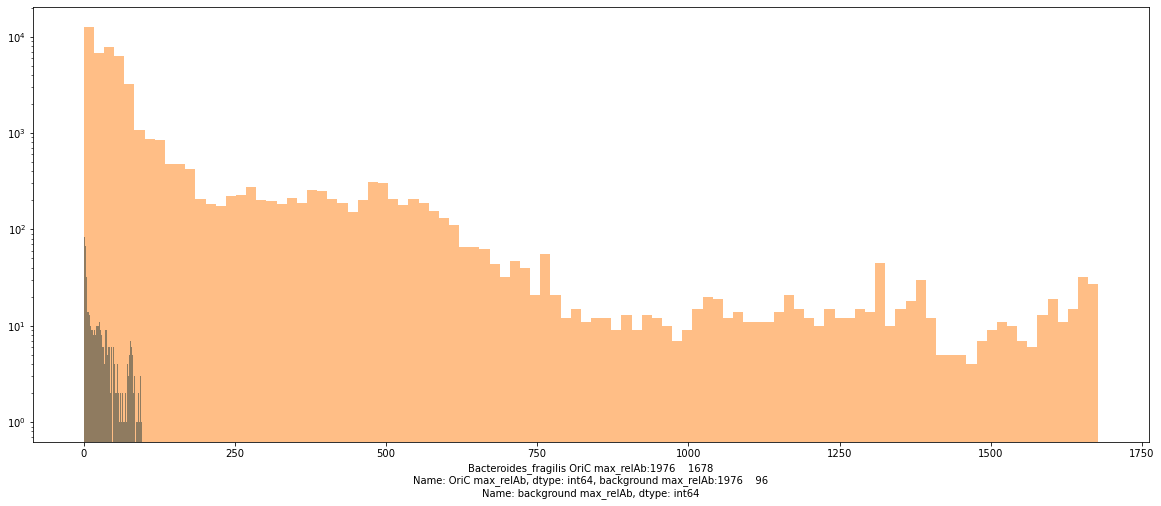

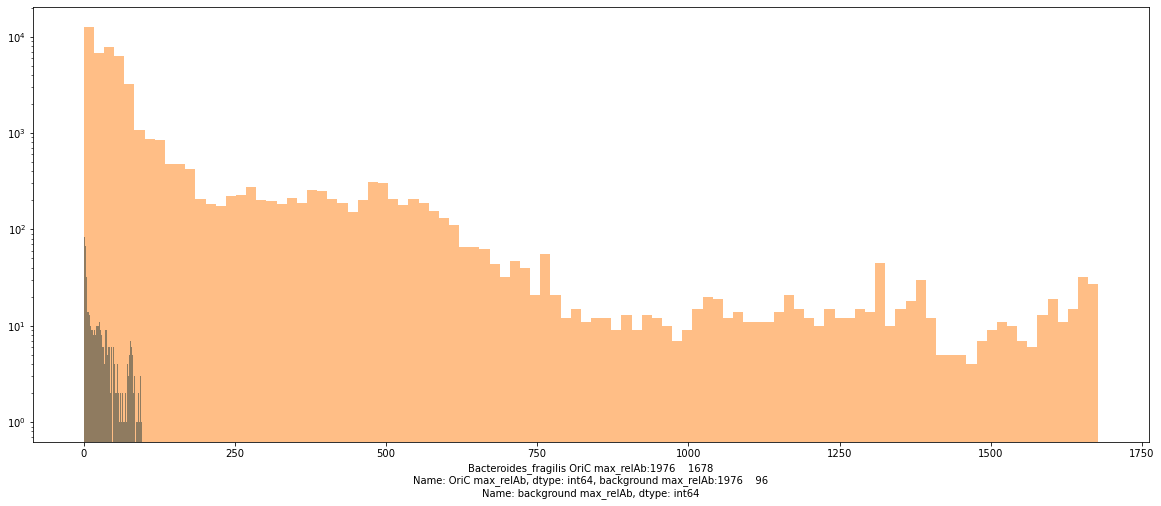

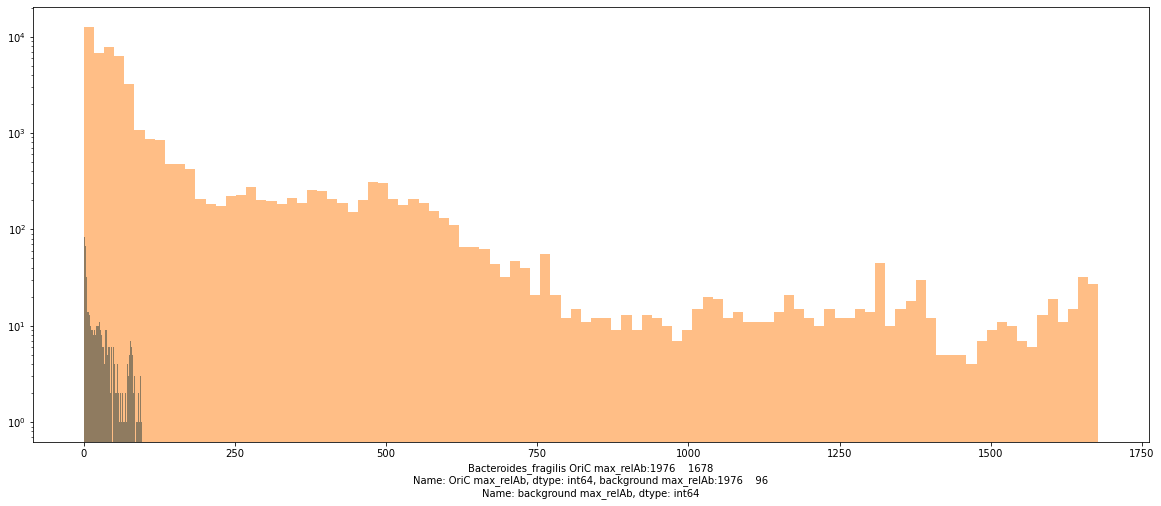

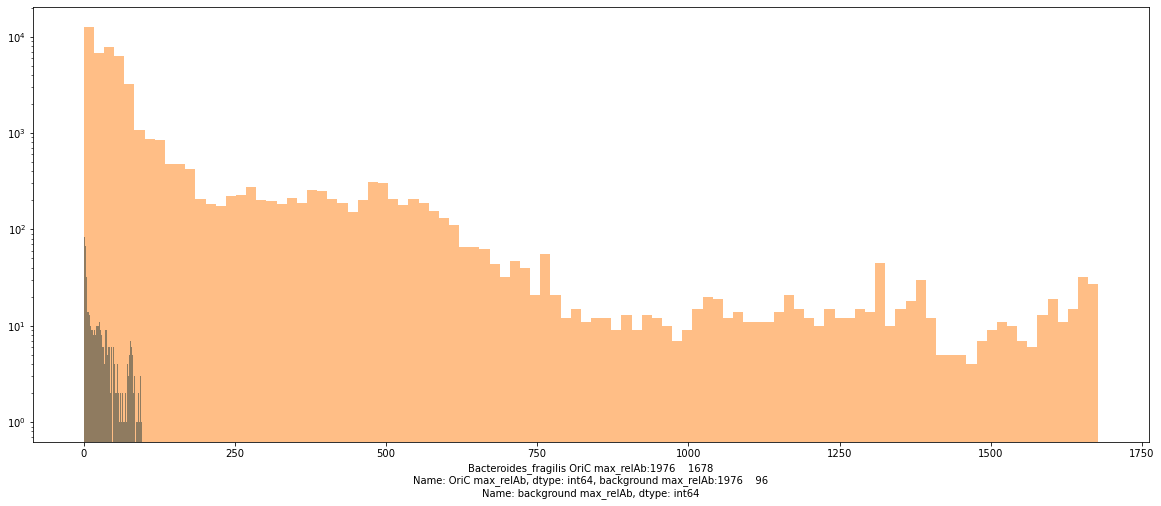

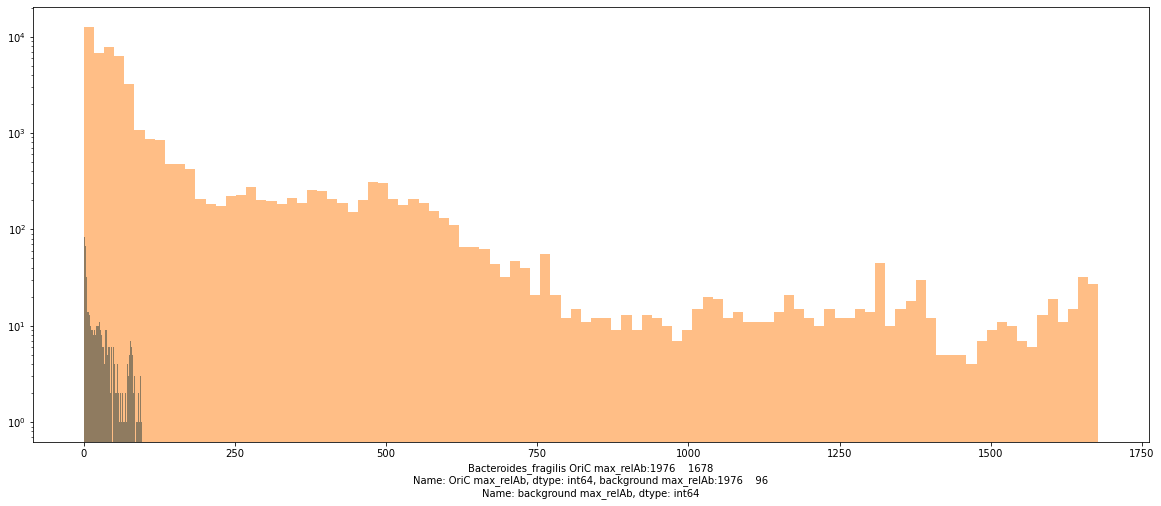

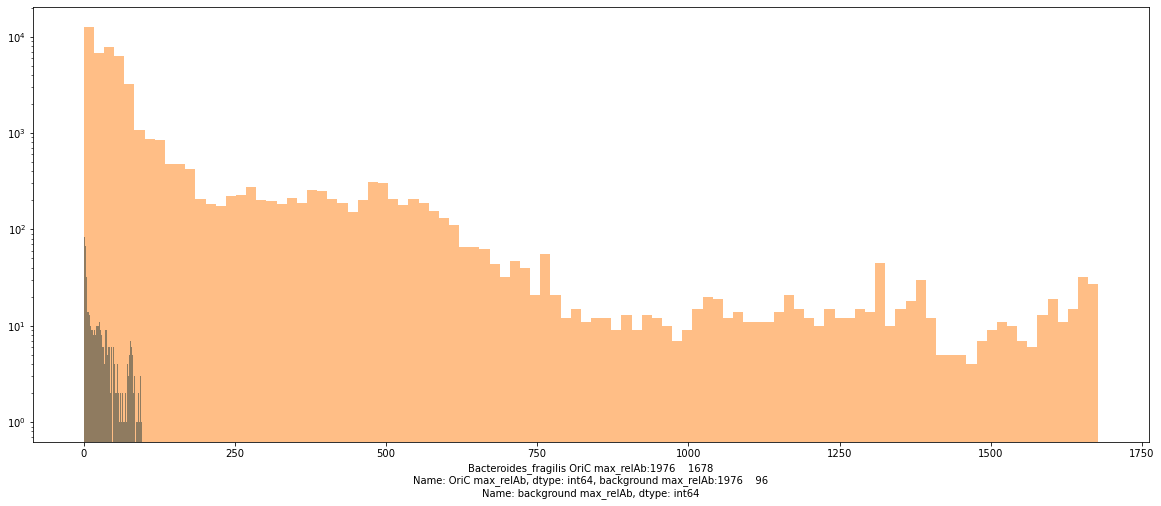

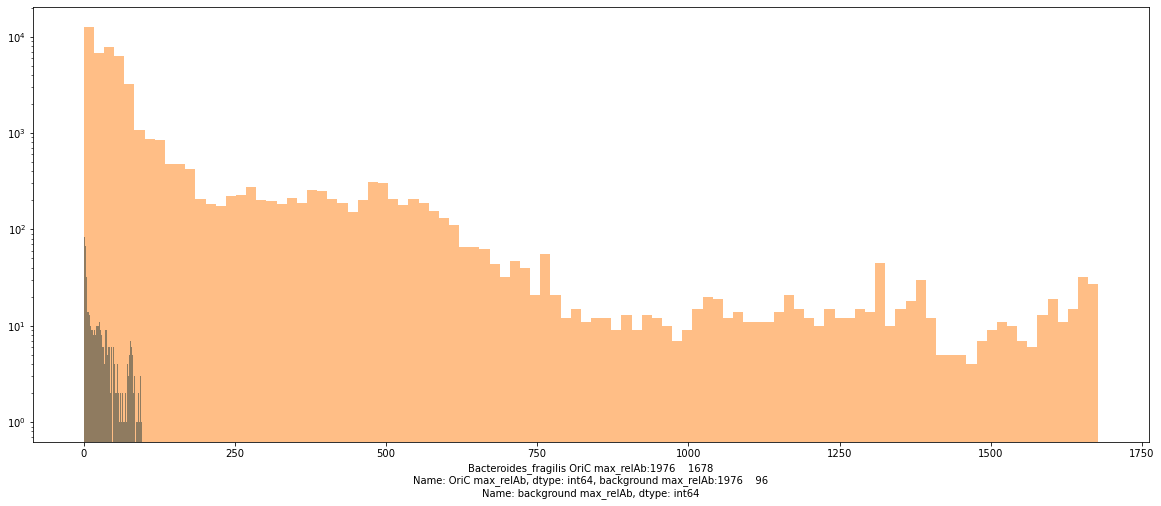

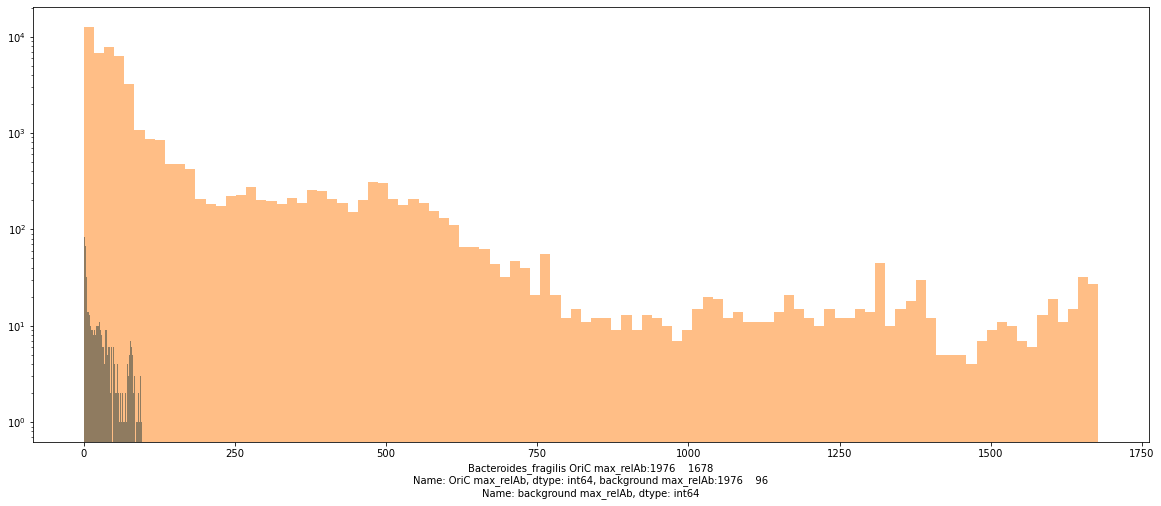

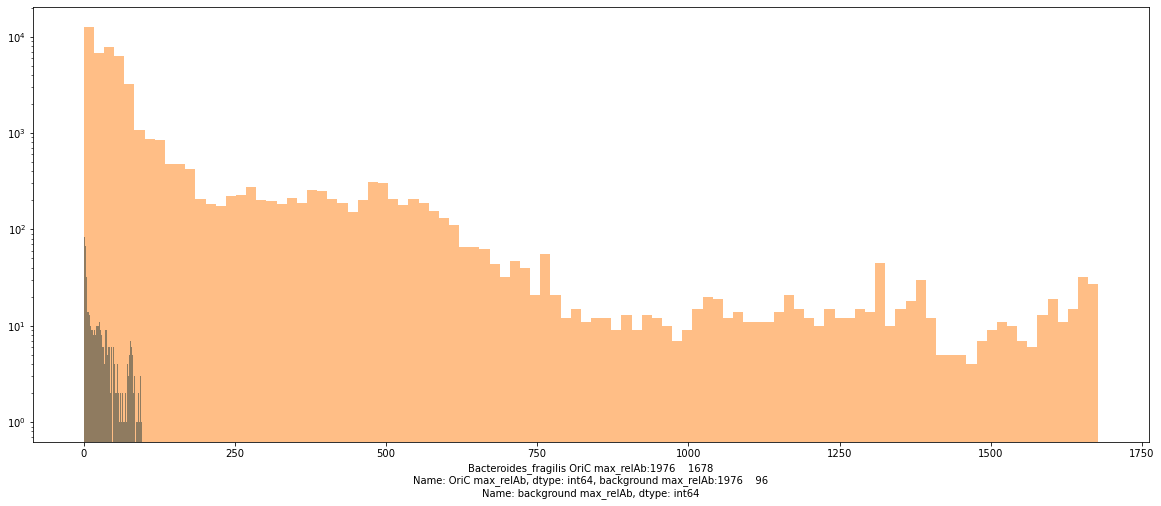

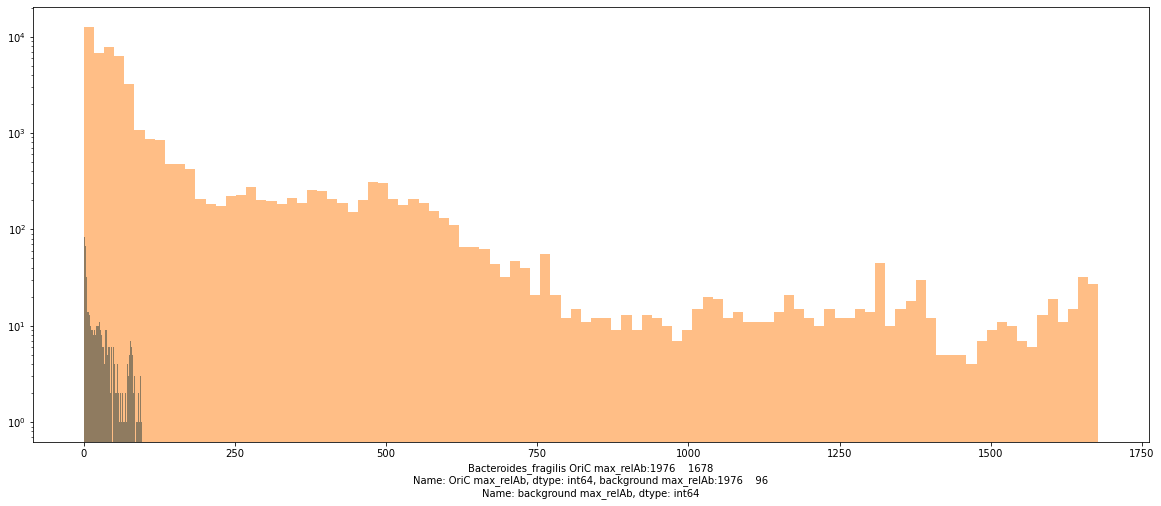

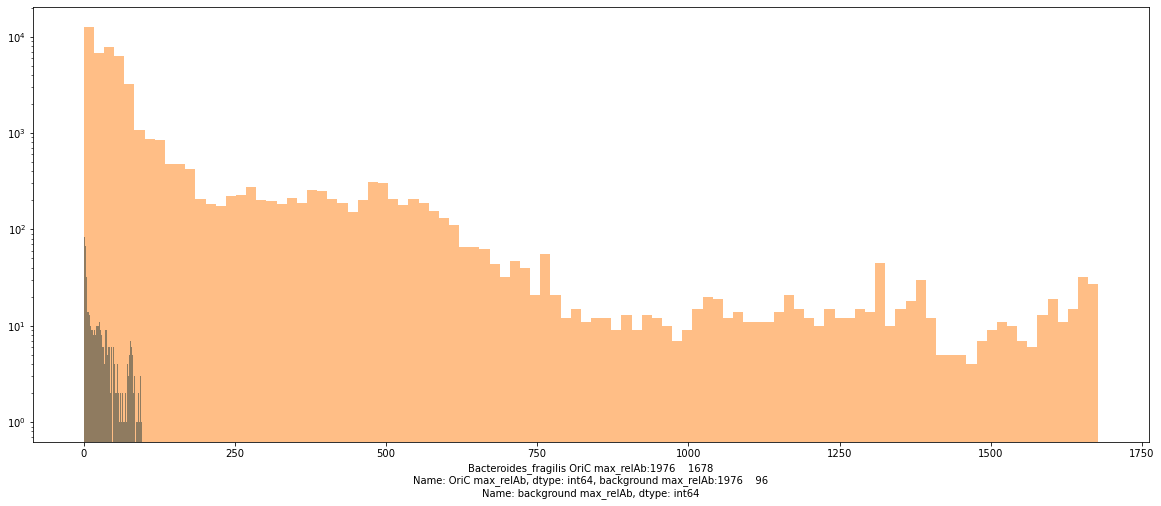

In [21]:
table=pd.DataFrame()
traces= glob.glob('data/meta_unfilt/*bedgraph')
traces=np.sort(traces)
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')
pattable=pd.DataFrame()

for jac in traces:
    zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
    tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]
    # print(str(tmp['Organism']))
    pat=jac.split('_')[2].split('.')[0]
    try:
        zzz['len']=zzz['end']-zzz['start']
        # zzz=zzz[zzz['len']==50]
        # zzz['relAb'].replace(0,1)
        # zzz['score']=zzz['relAb']/zzz['len']
        # zzz['score']=
        ss=np.int(np.round(tmp['start'].item(),-1))
        tt=np.int(np.round(tmp['end'].item(),-1))
        tmpd=zzz[(zzz['start']>ss) &(zzz['end']<tt)]
        tmpdd=zzz[(zzz['start']>ss-250) &(zzz['end']<tt+250)]
        tmpddd=zzz[(zzz['start']>ss-500) &(zzz['end']<tt+500)]

        tmp['mean']=np.sum(zzz['relAb']*zzz['len'])/np.sum(zzz['len'])#np.mean(zzz['score'])
        tmp['ori_mean']=np.sum(tmpd['relAb']*tmpd['len'])/np.sum(tmpd['len'])#np.mean(tmpd['score'])
        tmp['ori_mean_250']=np.sum(tmpdd['relAb']*tmpdd['len'])/np.sum(tmpdd['len'])#np.mean(tmpdd['score'])
        tmp['ori_mean_500']=np.sum(tmpddd['relAb']*tmpddd['len'])/np.sum(tmpddd['len'])#np.mean(tmpddd['score'])
        
        tmp['trim_mean01']=stats.trim_mean(zzz['relAb'],0.01)
        tmp['ori_trim_mean01']=stats.trim_mean(tmpd['relAb'],0.01)
        tmp['ori_trim_mean01_250']=stats.trim_mean(tmpdd['relAb'],0.01)
        tmp['ori_trim_mean01_500']=stats.trim_mean(tmpddd['relAb'],0.01)
        
        tmp['trim_mean1']=stats.trim_mean(zzz['relAb'],0.1)
        tmp['ori_trim_mean1']=stats.trim_mean(tmpd['relAb'],0.1)
        tmp['ori_trim_mean1_250']=stats.trim_mean(tmpdd['relAb'],0.1)
        tmp['ori_trim_mean1_500']=stats.trim_mean(tmpddd['relAb'],0.1)
        
        tmp['trim_mean25']=stats.trim_mean(zzz['relAb'],0.25)
        tmp['ori_trim_mean25']=stats.trim_mean(tmpd['relAb'],0.25)
        tmp['ori_trim_mean25_250']=stats.trim_mean(tmpdd['relAb'],0.25)
        tmp['ori_trim_mean25_500']=stats.trim_mean(tmpddd['relAb'],0.25)
        
        tmp['pat']=pat
        
        
        ccc=np.int(np.round(tmp['start'].item(),0))-50
        ddd=np.int(np.round(tmp['end'].item(),0))+50
        www0=zzz[((zzz['start']<ccc)|(zzz['end']>ddd))]
        # www1=zzz[]
        yyy=zzz[(zzz['start']>ccc)&(zzz['end']<ddd)]
        # print([len(zzz),len(www0),len(yyy)])
        if (np.max(www0.relAb)<np.max(yyy.relAb)):
            # print(str(tmp['Organism'].item()))
            # print([np.max(www0.relAb),np.max(yyy.relAb)])
            plt.figure(figsize=(20,8))
            tmpA=plt.hist(www0.relAb,bins=100,log=True)
            # tmpA=plt.hist(www1.relAb,bins=100,log=True)
            tmpA=plt.hist(yyy.relAb,bins=100,log=True,alpha=0.5)
            # tmpD=(np .max(yyy.relAb))
            tmp['OriC max_relAb']=(np.max(yyy.relAb))
            tmp['background max_relAb']=(np.max(www0.relAb))
            (np.max(www0.relAb))
            plt.xlabel(str(tmp['Organism'].item())+' OriC max_relAb:'+str(tmp['OriC max_relAb'])+', background max_relAb:'+str(tmp['background max_relAb']))
            # pattable=pd.concat([pattable,pat],axis=0)
            table=pd.concat([table,tmp],axis=0)
    except ValueError:
        pass
table['subj']=table['pat'].str.split('-').str[0].tolist()
table.to_csv('data/unfilt_oriC_calc_lenWeighted_trim_mean.txt',sep='\t')

In [22]:
table.to_csv('data/unfilt_oriC_calc_lenWeighted_trim_mean.txt',sep='\t')

In [4]:
table=pd.read_csv('data/oriC_calc_lenWeighted_trim_mean.txt',sep='\t')

In [26]:
run_vRand(diet,table,100)

Legumes_veg_serve 0.0025465814437420527 0.0025932402222074978 1.1482503898758924e-37
Legumes_protein_serve 0.0016064300417524603 0.0016386520224877855 9.30985987259847e-38
Milk_alternatives_serve 0.003935641132957037 0.004008296017710796 0.00012904635492433402


In [399]:
aa=diet.loc[diet.index.isin(np.unique(table['subj']))]
aa['ecoli']=1
aa=aa.select_dtypes(include=np.number)
aa=aa.dropna(how='any',axis=1)

bb=diet.loc[~diet.index.isin(np.unique(table['subj']))]
bb['ecoli']=0
bb=bb.select_dtypes(include=np.number)
bb=bb.dropna(how='any',axis=1)

In [ ]:
aa=aa.append(bb)
sns.violinplot(x=aa['ecoli'],y=aa['Niacin_mg'])

In [406]:
aa['Niacin_mg']

300 Cohort
R0395    35.50082
R0396    44.04193
R0397    21.27193
R0398    23.72597
R0399    30.12182
           ...   
R0460    12.27725
R0461    14.75925
R0462    17.84305
R0463    31.17107
R0465    18.84118
Name: Niacin_mg, Length: 783, dtype: float64

In [ ]:
run_vRand(primary,table,100)

In [ ]:
run_vRand(secondary,table,100)

In [392]:
run_vRand(blood_stool,table,100)

Stool SCFA Acetic Acid (mmol/kg wet feces) 1.1358056698120364e-12 1.1443811915235635e-12 1.804957472889119e-12
Stool SCFA Propionic Acid (mmol/kg wet feces) 2.1629305496066046e-07 2.175006462601488e-07 1.157613071915063e-06
ecoli 3.6994798899325415e-64 3.810892025247883e-64 0.0
LDL Cholesterol (mmol/L) 0.0009971015992800835 0.001000430748547537 0.002030766720489445


In [398]:
run_vRand(MRI,table,100)

ecoli 3.6994798899325415e-64 3.810892025247883e-64 0.0


In [357]:
aa=secondary.loc[secondary.index.isin(np.unique(table['subj']))]
aa=aa.select_dtypes(include=np.number)
aa=aa.dropna(how='any',axis=1)

bb=secondary.loc[~secondary.index.isin(np.unique(table['subj']))]
bb=bb.select_dtypes(include=np.number)
bb=bb.dropna(how='any',axis=1)

In [358]:
for i in aa.columns:
    try:
        cc=stats.kruskal(aa[i].dropna(),bb[i].dropna())
        dd=stats.mannwhitneyu(aa[i].dropna(),bb[i].dropna())
        ee=stats.ttest_ind(aa[i].dropna(),bb[i].dropna())
        # ff=stats.wilcoxon(aa[i].dropna(),bb[i].dropna())
        if ((cc.pvalue<0.05) & (dd.pvalue<0.05)&(ee.pvalue<0.05)&(ee.pvalue<0.05)):
            print (i,cc.pvalue,dd.pvalue,ee.pvalue)

    except:
        pass

Stroop task age group(1=40-49;2=50-59;3=60-65) 0.00010988928991157288 0.00011040077336373072 9.674999253748957e-05


In [ ]:
tmp=plt.hist(zzz['score'],bins=100,log=True)
tmp=plt.hist(tmpd['score'],bins=100,log=True)
tmp=plt.hist(tmpdd['score'],bins=100,log=True)
tmp=plt.hist(tmpddd['score'],bins=100,log=True)

### compare output

In [ ]:
table.groupby('pat').mean()

In [ ]:
a=plt.hist(table['mean'],bins=100,log=True,alpha=.65)
a=plt.hist(table['ori_mean'],bins=100,log=True,alpha=.5)
a=plt.hist(table['ori_mean_250'],bins=100,log=True,alpha=.35)
a=plt.hist(table['ori_mean_500'],bins=100,log=True,alpha=.25)

In [ ]:
np.sum(table['mean']>table['ori_mean'])/len(table)

In [ ]:
np.sum(table['median']>table['ori_median'])/len(table)

In [ ]:
table.groupby('Organism').median()

In [ ]:
table.groupby('Organism').mean()

In [ ]:
unibact=pd.read_csv('data/328_krakenuniq_raw.csv',index_col=0)
unibact['spec']=(unibact.index).str.split(';').str[0:6].tolist()
jeff=pd.DataFrame(unibact['spec'].tolist(),columns=['tmp','tmp','tmp','tmp','tmp','species'])
jeff=jeff.fillna(method='ffill',axis=1)

In [ ]:
(unibact.index).str.split(';').str[0:6].tolist()[0][5] ## transfered a bunch of these from hku to personal cpos

In [ ]:
jeff[jeff['species'].str.contains('prevot')]#[1:50]
# jeff.ind# tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
# N = np.sum(zzz.len)#len(table['mean'])
bottom = 8
max_height = 4

theta = zzz['start']#np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = zzz['relAb']#max_height*np.random.rand(N)
width = zzz['len'] #(2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(x=theta, height=radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)

plt.show()

In [ ]:
ccc=np.int(np.round(tmp['start'].item(),0))-500
ddd=np.int(np.round(tmp['end'].item(),0))+500
www0=zzz[(zzz['start']<ccc)]
www1=zzz[(zzz['end']>ddd)]
yyy=zzz[(zzz['start']>ccc)&(zzz['end']<ddd)]
[len(zzz),len(www0),len(yyy),len(www1)]
[np.max(www0.relAb),np.max(www1.relAb),np.max(yyy.relAb)]

In [ ]:
np.int(np.round(np.max(yyy.relAb),-3)/100)

In [ ]:
plt.figure(figsize=(20,8))
tmpA=plt.hist(www0.relAb,bins=100,log=True)
tmpA=plt.hist(www1.relAb,bins=100,log=True)
tmpA=plt.hist(yyy.relAb,bins=100,log=True)
# plt.label

In [ ]:
# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#61a4b2",
)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df["Name"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

# neurIPS

In [ ]:
# ori['len']=ori['end']-ori['start']
np.sort(ori['len'])ATACxGEX=pd.read_csv('/content/drive/My

In [ ]:
ATACxGEX=pd.read_csv('data/neurIPS2021/ATACxGEX_O.bed',sep='\t',names=['chr','start','end','id','gene','chr2','start2','end2','hits'])
GEXxATAC=pd.read_csv('data/neurIPS2021/GEXxATAC_O.bed',sep='\t',names=['chr','start','end','id','gene','chr2','start2','end2','hits'])

In [ ]:
plt.figure(figsize=(20, 5))
dd=GEXxATAC[GEXxATAC['chr']=='chr1']
plt.bar(data=dd,x=np.log(dd['start']),height='hits')

# Duolingo

In [ ]:
import duolingo
lingo  = duolingo.Duolingo('dcolinmorgan', 'M6742632')

In [ ]:
# lingo  = duolingo.Duolingo('kartik', '...')
ww=(lingo.get_known_words('sv'))
vv=lingo.get_translations(ww, source='sv', target='en')

In [ ]:
# with open('dcm_duolingo.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
#     w = csv.DictWriter(f, vv.keys())
#     w.writeheader()
#     w.writerow(vv)

import json
# with open('dcm_duolingo.txt', 'w') as file:
#      file.write(json.dumps(vv))
        
with open('dcm_duolingo.txt', 'w', encoding='utf-8') as f:
    json.dump(vv, f, ensure_ascii=False, indent=4)

In [ ]:
# pp=(lingo.get_vocabulary(language_abbr='sv'))
pd.DataFrame((pp))

In [ ]:

pp.keys()

In [ ]:
pp.vocab_overview